# DETECCIÓN DE GLIOMAS CEREBRALES MEDIANTE UN AUTOENCODER CONVOLUCIONAL

La detección temprana y precisa de tumores cerebrales es un aspecto crítico en la atención médica moderna. Los tumores cerebrales representan una amenaza seria para la salud y la calidad de vida de los pacientes, y su detec-ción precoz puede ser determinante para un tratamiento efectivo y mejores resultados clínicos. Según datos estadísticos recientes, los tumores cerebrales son la décima causa de muerte en todo el mundo, tanto en hombres como en mujeres, lo que subraya la importancia de abordar este problema de manera eficaz y oportuna.

Las imágenes de resonancia magnética (MRI, por sus siglas en inglés) son imágenes tomadas con resonancia magnética, una técnica de imagenología médica que utiliza campos magnéticos y ondas de radio para generar imágenes detalladas del interior del cuerpo humano. Este tipo de imágenes proporcionan información valiosa sobre los tejidos blandos, los órganos y las estructuras internas del cuerpo. Sin embargo, la identificación manual de tumores cerebrales en imágenes médicas, como resonancias magnéticas (RM), es un proceso laborioso y propenso a errores.

Uno de los desafíos clave en la aplicación del aprendizaje profundo a las imágenes de resonancia magnética es la disponibilidad limitada de conjuntos de datos grandes y etiquetados para entrenar modelos. Es aquí donde ganan importancia los Autoencoders (respecto a otras arquitecturas como las Redes Neuronales Convolucionales), ya que estos modelos son un tipo de aprendizaje no supervisado, es decir, no necesitan de un conjunto de datos etiquetado para poder hacer una clasificación. Es por ello por lo que, como solución a este problema, sugiero el uso de un Autoencoder Convolucional (CAE, por sus siglas en inglés). Un CAE como el empleado en este proyecto solo necesita de imágenes de pacientes sanos para ser entrenado y posteriormente hacer una clasificación de pacientes sanos y con anomalías.

Primero de todo deben importarse todas las librerías que se van a usar.

In [19]:
import torch
import os
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import json
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from scipy.ndimage import zoom
from sklearn.model_selection import KFold, GridSearchCV
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
import optuna
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, classification_report, roc_curve
from sklearn.manifold import TSNE
from sklearn.neighbors import KernelDensity
import gc

Estas dos celdas de a continuación hacen referencia a la memoria GPU. Deben modificarse según el entorno que se vaya a usar u omitir en caso de no usar la memoria GPU (no recomendado).

In [21]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
torch.cuda.set_per_process_memory_fraction(0.7)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
!nvidia-smi

Tue Jul  2 08:22:30 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P40           Off  | 00000000:3B:00.0 Off |                  Off |
| N/A   67C    P0   142W / 250W |  23134MiB / 24451MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P40           Off  | 00000000:86:00.0 Off |                    0 |
| N/A   

## DATASET PACIENTES SANOS

Esta clase sirve para leer las imágenes de los pacientes que usaremos para entrenar el AutoEncoder. Para seguir con nuestra hipótesis de qué la reconstrucción de una imagen de un paciente con patologías será mayor, entrenaremos el CAE con solo pacientes sanos. Para quedarnos solo con las imágenes de los pacientes sanos, ejecutar preprocessing.py.

El conjunto de datos puede descargarse en: https://www.kaggle.com/competitions/rsna-miccai-brain-tumor-radiogenomic-classification/data

Y antes de ejecutar esta celda debe ejecutarse el archivo preprocessing.py que se encuentra en esta misma carpeta. En ese archivo se aplican las transformaciones en el conjunto descargado para separar entre pacientes sanos y con glioma, además de convertir las imágenes DICOM en volúmenes NIFTI.

In [4]:
class NIFTIDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        self.volume_sizes = []
        self.resized_volumes = []
        self.root_dir = root_dir
        self.transform = transform
        self.nifti_files = self.get_nifti_files()
        self.map_id = np.zeros(len(self.nifti_files)) # Fila de 0 de longitud N pacientes, se añade un 1 donde el volumen cumpla el intervalo
        self.modal_size = self.get_modal_volume_size()
        
        if len(self.resized_volumes) == 0:
            self.resized_volumes = self.resize_volumes() # Una vez calculadas las dimensiones modales, redimensionamos los volúmenes

    def get_nifti_files(self):
        """ Función que lee los archivos NIFTI y 
            guarda los volúmenes en la lista self.nifti_files. """
        nifti_files = []
        resized_volumes = []
        total_patients = 0
        for root, dirs, patients in os.walk(self.root_dir):
            for file in patients:
                # Caso de dataset OASIS
                if file.endswith(".nii_registered.nii.gz"):
                    file_path = os.path.join(root, file)
                    nifti_data = nib.load(file_path) # Se carga el archivo NIfTI utilizando la biblioteca NiBabel (nib). Esto devuelve un objeto que contiene los datos de la imagen médica.
                    volume_array = nifti_data.get_fdata() # Se obtienen los datos de la imagen en forma de matriz NumPy
                    modal_size = np.array((256,256,32))
                    resized_volume = self.resize_volume(volume_array, modal_size[0], modal_size[1], modal_size[2])
                    self.resized_volumes.append(resized_volume)
                    self.volume_sizes.append(volume_array.shape)
                    
                # Caso de dataset RSNA-MICCAI
                elif file.endswith('.nii.gz'):
                    file_path = os.path.join(root, file)
                    nifti_files.append(file_path)
                    nifti_data = nib.load(file_path) # Se carga el archivo NIfTI utilizando la biblioteca NiBabel (nib). Esto devuelve un objeto que contiene los datos de la imagen médica.
                    volume_array = nifti_data.get_fdata() # Se obtienen los datos de la imagen en forma de matriz NumPy
                    self.volume_sizes.append(volume_array.shape)

                total_patients += 1

        print("Total de pacientes:", len(self.volume_sizes))

        return nifti_files
    
    def visualize_volume_sizes(self):
        """ Este método permite visualizar los tamaños de dimensión
            más frecuentes entre los volumenes."""
        # Crear la figura y los subplots
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        
        x_sizes = [size[0] for size in self.volume_sizes]
        y_sizes = [size[1] for size in self.volume_sizes]
        z_sizes = [size[2] for size in self.volume_sizes]

        # Histograma de x_sizes
        axs[0].hist(x_sizes, bins=20, color='blue', alpha=0.7)
        axs[0].set_title('Histograma de x')
        axs[0].set_xlabel('Tamaño')
        axs[0].set_ylabel('Frecuencia')

        # Histograma de y_sizes
        axs[1].hist(y_sizes, bins=20, color='green', alpha=0.7)
        axs[1].set_title('Histograma de y')
        axs[1].set_xlabel('Tamaño')
        axs[1].set_ylabel('Frecuencia')

        # Histograma de z_sizes
        axs[2].hist(z_sizes, bins=20, color='red', alpha=0.7)
        axs[2].set_title('Histograma de z')
        axs[2].set_xlabel('Tamaño')
        axs[2].set_ylabel('Frecuencia')

        # Mostrar la figura
        plt.tight_layout()
        plt.show()
        
        x_sizes_counter = Counter(x_sizes)
        y_sizes_counter = Counter(y_sizes)
        z_sizes_counter = Counter(z_sizes)
        
        print("Top 3 tamaños más repetidos de dimensión x: (Tamaño, frecuencia):", x_sizes_counter.most_common(3))
        print("Top 2 tamaños más repetidos de dimensióy y: (Tamaño, frecuencia):", y_sizes_counter.most_common(2))
        print("Top 2 tamaños más repetidos de dimensión z: (Tamaño, frecuencia):", z_sizes_counter.most_common(2))
        
        x_more_common = [tupla[0] for tupla in x_sizes_counter.most_common(3)]
        y_more_common = [tupla[0] for tupla in y_sizes_counter.most_common(2)]
        z_more_common = [tupla[0] for tupla in z_sizes_counter.most_common(2)]
        
        return x_more_common, y_more_common, z_more_common

    def get_modal_volume_size(self):
        """ Función que calcula las dimensiones 
            más repetidas de los volúmenes almacenados 
            y devuelve la dimensionalidad modal."""
        # Obtenemos las dimensiones de cada volumen por separado
#         x_sizes = [size[0] for size in self.volume_sizes]
#         y_sizes = [size[1] for size in self.volume_sizes]
#         z_sizes = [size[2] for size in self.volume_sizes]

#         # Calculamos las dimensiones modales para cada dimensión
#         modal_x = Counter(x_sizes).most_common(1)[0][0]
#         modal_y = Counter(y_sizes).most_common(1)[0][0]
#         modal_z = Counter(z_sizes).most_common(1)[0][0]

        # Si quieren volverse a calcular, descomentar el código de arriba
        modal_size = (256,256,32)

        return modal_size

    def resize_volumes(self):
        """ Función que calcula las dimensiones 
            del intervalo y devuelve los volumenes
            redimensionados."""
        resized_volumes = []
        i = 0
        for file_path in self.nifti_files:
            nifti_data = nib.load(file_path)# Se carga el archivo NIfTI utilizando la biblioteca NiBabel (nib). Esto devuelve un objeto que contiene los datos de la imagen médica.
            volume_array = nifti_data.get_fdata() # Se obtienen los datos de la imagen en forma de matriz NumPy

            # Obtenemos las dimensiones del volumen
            dims = volume_array.shape

            modal_size = np.array(self.modal_size)

            # Calculamos los límites del intervalo
            lower_bound = np.floor(modal_size * 0.5)
            upper_bound = np.floor(modal_size * 2)

            # Comprobamos si las dimensiones están dentro del intervalo
            if (dims[0] >= lower_bound[0] and dims[0] <= upper_bound[0] and
                dims[1] >= lower_bound[1] and dims[1] <= upper_bound[1] and
                dims[2] >= lower_bound[2] and dims[2] <= upper_bound[2]):

                # Si está dentro del intervalo, redimensionamos
                resized_volume = self.resize_volume(volume_array, modal_size[0], modal_size[1], modal_size[2])
                resized_volumes.append(resized_volume)
                self.map_id[i] = 1 # Gurdamos la posición del paciente
            
            i += 1

        return resized_volumes

    def resize_volume(self, volume_array, target_width, target_depth, target_height):
        """ Función que redimensiona un volumen de
            entrada a las dimensiones pasadas por
            parámetro."""
        width, depth, height = volume_array.shape # (x,z,y) (256,32,256) -> p.ej
        
        resized_volume = zoom(volume_array, (target_width/width,
                        target_depth/depth,
                        target_height/height), order=3)

        return resized_volume

    def __len__(self):
        """ Devuelve la cantidad de pacientes redimensionados."""
        return len(self.resized_volumes)

    def __getitem__(self, idx):
        """ Devuelve el paciente correspondiente al índice que
            recibe por parámetro."""
        resized_volume = self.resized_volumes[idx]

        if self.transform:
            resized_volume = self.transform(resized_volume)

        return resized_volume


### NORMALIZACIÓN


Estas dos celdas sirven para encontrar la media y desviación estándar del conjunto, pueden omitirse dado que las transformaciones en los tensores ya contienen estos valores, sin embargo, de quererse ejecutar, con una única vez por tipo de MRI basta.

In [5]:
# CREAMOS EL CONJUNTO DE DATOS
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.float())]) # caso sin normalizar los datos

dataset = NIFTIDataset(root_dir=("./train_unhealthy_nifti_T1"), transform=transform)
modal_size = dataset.modal_size # Tamaño de la imagen más frecuente
print("Tamaño de la imagen más frecuente:", modal_size)

#CREAMOS EL DATA LOADER
dataloader = torch.utils.data.DataLoader(dataset, batch_size=12, shuffle=True, num_workers=2)

Total de pacientes: 312
Tamaño de la imagen más frecuente: (256, 256, 32)


Vamos a estandarizar los datos a ver si así se obtienen mejores resultados. Para ello, vamos a leer todos los datos, calcular la media y desviación estándar.

In [5]:
def calculate_mean_std(loader):
    """ Calcula la media y la desviación estandar 
        de un conjunto de datos."""
    mean_accumulator = torch.zeros(1, dtype=torch.float32, device=device) #
    std_accumulator = torch.zeros(1, dtype=torch.float32, device=device) #

    total_samples = 0

    for batch in loader:
        image = batch.to(device) # Cada batch contiene image, label
        image = image.float()
        batch_samples = image.size(0)
        # Calculate mean and std across channels (axis=1)
        mean_accumulator += torch.mean(image, dim=(1,2,3)).sum(0)
        std_accumulator += torch.std(image, dim=(1,2,3)).sum(0)

        total_samples += batch_samples

    mean_global = mean_accumulator / total_samples
    std_global = std_accumulator / total_samples

    return mean_global, std_global

mean_data, std_data = calculate_mean_std(dataloader)
print("Mean data: " + str(mean_data) + " - STD data: " + str(std_data))

NameError: name 'dataloader' is not defined

## FUNCIONES DE ENTRENAMIENTO Y TEST

In [8]:
# TRAIN
def train(model, loader, optimizer, criterion):
    """ Función que sirve para entrenar un modelo."""
    loss = 0
    model.train() # Indicamos al modelo que vamos a entrenarlo (debe indicarse para que sepa como actuar en distintos casos, como en Dropout, donde funciona distinto en función de si se entrena o evalua).

    for batch_features in loader:
        # Cargamos los datos en la GPU
        batch_features = batch_features.to(device)

        # Reeiniciamos los gradientes a cero
        # PyTorch acumula gradientes en pasadas posteriores hacia atrás
        optimizer.zero_grad()

        # Genera las reconstrucciones
        outputs = model(batch_features)

        # Calcula la pérdida de reconstrucción en el entrenamiento
        train_loss = criterion(outputs, batch_features)

        # Calcula los gradientes acumulados
        train_loss.backward()
        
        # realiza la actualización de parámetros en función de los gradientes actuales
        optimizer.step()

        # Añade la pérdida de entrenamiento del mini-batch a la pérdida de época
        loss += train_loss.item()

    # Calcula la pérdida por época
    loss = loss / len(loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))

    return loss


In [9]:
# TEST
def test(model, loader, criterion):
    """ Función que sirve para testear el modelo
        que recibe por parámetro."""
    MSEs_fold = []
    outputs = []
    model.eval() # Indicamos al modelo que vamos a evaluarlo

    with torch.no_grad():
        for batch_features in loader:
            batch_features = batch_features.to(device) # Enviamos los datos a la GPU
            output_batch = model(batch_features).cpu() # Una vez generados los outputs los devolvemos a CPU, para calcular el MSE ahí y ahorrar memoria GPU

            if isinstance(model, ConvAE): # Si el modelo es el CAE: se calculan los MSE. Si es encoder, los vectores latentes
                for output, feature in zip(output_batch, batch_features.cpu()):
                    MSEs_fold.append(criterion(output, feature).item())
            else:
                outputs.append(output_batch)

    if isinstance(model, ConvAE): # Si el modelo es el CAE: se devuelve el MSE. Si es encoder, los vectores latentes
        return MSEs_fold
    else:
        return [tensor for sublist in outputs for tensor in sublist]


#### Pequeña comprobación que se obtienen los valores esperados en la función test

In [60]:
encoded_volumes_train_fold = test(encoder_fold, train_loader, criterion)
print("Elemento lista:", encoded_volumes_train_fold[0].shape)
print("Total de tensores en la lista:", len(encoded_volumes_train_fold))
print("Total de pacientes en el conjunto:", len(train_dataset))

Elemento lista: torch.Size([16, 8, 64, 64])
Total de tensores en la lista: 72
Total de pacientes en el conjunto: 72


In [61]:
_, mse_list = test(model_fold, train_loader, criterion)
print("Elemento lista:", mse_list[0])
print("Total de tensores en la lista:", len(mse_list))
print("Total de pacientes en el conjunto:", len(train_dataset))

epoch : 10/10, Test loss = 0.020127
Elemento lista: tensor(0.0284, device='cuda:0')
Total de tensores en la lista: 72
Total de pacientes en el conjunto: 72


## DEFINICIÓN DE LOS MODELOS USADOS

### AUTOENCODER CONVOLUCIONAL 3D

In [10]:
class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),

            nn.Conv3d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2)

            )

        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose3d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        # ENCODER

        x = x.unsqueeze(1)
        x = self.encoder[0](x)
        x = self.encoder[1](x)
        x = self.encoder[2](x)
        x = self.encoder[3](x)
        x = self.encoder[4](x)
        x = self.encoder[5](x)
        
        # DECODER

        x = self.decoder[0](x)
        x = self.decoder[1](x)
        x = self.decoder[2](x)
        x = x.squeeze(1) # Igualamos tensor al esperado en la salida

        return x


### ENCODER CONVOLUCIONAL 3D (MISMA ARQUITECTURA, SIN EL DESCODIFICADOR)

In [11]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),

            nn.Conv3d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2)

            )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.encoder[0](x)
        x = self.encoder[1](x)
        x = self.encoder[2](x)
        x = self.encoder[3](x)
        x = self.encoder[4](x)
        x = self.encoder[5](x)
        x = x.squeeze(1) # Igualamos tensor al esperado en la salida

        return x


## EJECUCIÓN Y EVALUACIÓN

Luego de haber normalizado todos los conjuntos de datos, abajo se muestran los valores de media y desviación estándar de cada uno de ellos.

#### HEALTHY
MEDIA Y DESVIACIÓN ESTÁNDAR PARA T1: mean=156.7395, std=405.9176
    
MEDIA Y DESVIACIÓN ESTÁNDAR PARA T2: mean=98.4008, std=231.8167

MEDIA Y DESVIACIÓN ESTÁNDAR PARA FLAIR: mean=65.8606, std=184.9198

#### UNHEALTHY

MEDIA Y DESVIACIÓN ESTÁNDAR PARA T1: mean=124.5437, std=269.3226
    
MEDIA Y DESVIACIÓN ESTÁNDAR PARA T2: mean=104.0635, std=242.1927

MEDIA Y DESVIACIÓN ESTÁNDAR PARA FLAIR: mean=50.2807, std=113.5249

Aplicamos la normalización a los conjuntos de datos. Ddeberá cambiarse la ruta de archivo en función de donde se tengan almacenados los conjuntos de datos (recordar que, como ya he mencionado, debe ejecutarse primero el archivo 'preprocessing.py', para tener los datos separados por clases y armonizados).

In [9]:
transform_T1 = transforms.Compose([transforms.ToTensor(),
                                         transforms.Lambda(lambda x: x.float()), 
                                         transforms.Normalize(mean=156.7395, std=405.9176)])  # Ajustamos los valores de media y desviación estándar según los datos de train T1. mean=86.4945, std=200.8065 (cuando total_patients = 130)

transform_T2 = transforms.Compose([transforms.ToTensor(),
                                         transforms.Lambda(lambda x: x.float()), 
                                         transforms.Normalize(mean=98.4008, std=231.8167)])  # Ajustamos los valores de media y desviación estándar según los datos de train T1. mean=86.4945, std=200.8065 (cuando total_patients = 130)

transform_FLAIR = transforms.Compose([transforms.ToTensor(),
                                         transforms.Lambda(lambda x: x.float()), 
                                         transforms.Normalize(mean=65.8606, std=184.9198)])  # Ajustamos los valores de media y desviación estándar según los datos de train T1. mean=86.4945, std=200.8065 (cuando total_patients = 130)

dataset_T1 = NIFTIDataset(root_dir=("/../data/neurologia/train_healthy_nifti_T1"), transform=transform_T1)

dataset_T2 = NIFTIDataset(root_dir=("/../data/neurologia/train_healthy_nifti_T2w"), transform=transform_T2)

dataset_FLAIR = NIFTIDataset(root_dir=("/../data/neurologia/train_healthy_nifti_FLAIR"), transform=transform_FLAIR)

print("Total de pacientes usados para entrenar el modelo T1:", len(dataset_T1))
print("Total de pacientes usados para entrenar el modelo T2:", len(dataset_T2))
print("Total de pacientes usados para entrenar el modelo FLAIR:", len(dataset_FLAIR))


KeyboardInterrupt: 

In [ ]:
transform_T1 = transforms.Compose([transforms.ToTensor(),
                                         transforms.Lambda(lambda x: x.float()), 
                                         transforms.Normalize(mean=124.5437, std=269.3226)])
transform_T2 = transforms.Compose([transforms.ToTensor(),
                                         transforms.Lambda(lambda x: x.float()), 
                                         transforms.Normalize(mean=104.0635, std=242.1927)])
transform_FLAIR = transforms.Compose([transforms.ToTensor(),
                                         transforms.Lambda(lambda x: x.float()), 
                                         transforms.Normalize(mean=50.2807, std=113.5249)])

glioma_dataset_T1 = NIFTIDataset(root_dir=("/../data/neurologia/train_unhealthy_nifti_T1"), transform=transform_T1)

glioma_dataset_T2 = NIFTIDataset(root_dir=("/../data/neurologia/train_unhealthy_nifti_T2w"), transform=transform_T2)

glioma_dataset_FLAIR = NIFTIDataset(root_dir=("/../data/neurologia/train_unhealthy_nifti_FLAIR"), transform=transform_FLAIR)

print("Total de pacientes usados para entrenar el modelo T1:", len(glioma_dataset_T1))
print("Total de pacientes usados para entrenar el modelo T2:", len(glioma_dataset_T2))
print("Total de pacientes usados para entrenar el modelo FLAIR:", len(glioma_dataset_FLAIR))

Se puede observar que cada conjunto entrena el modelo con un número distinto de pacientes. Por eso se han almacenado las posiciones de los pacientes y más adelante se deberá estabelcer una función que permita encontrar estos pacientes en común para poder hacer una comparativa correcta.

### Vamos a guardar las estructuras creadas para mapear los pacientes y los índices de glioma (nos servirá de cara a la clasificación)

In [55]:
with open("./Patients_map.json", "w") as f:
    json.dump({"Patients_healthy_T1": dataset_T1.map_id.tolist(), "Patients_glioma_T1": glioma_dataset_T1.map_id.tolist(), 
               "Patients_healthy_T2": dataset_T2.map_id.tolist(), "Patients_glioma_T2": glioma_dataset_T2.map_id.tolist(), 
               "Patients_healthy_FLAIR": dataset_FLAIR.map_id.tolist(), "Patients_glioma_FLAIR": glioma_dataset_FLAIR.map_id.tolist()}, f)

In [49]:
num_folds = 10
kf = KFold(n_splits=num_folds)

volume_types_glioma = {"T1": glioma_dataset_T1, "T2": glioma_dataset_T2, "FLAIR": glioma_dataset_FLAIR} # Este dict nos sirve para elegir el tipo de volumen

v_type = "FLAIR"

train_glioma_idxs = [] # Lista de los índices de train del fold para poder recuperar los datos pertenecientes a este grupo
test_glioma_idxs = [] # Lista de los índices de test del fold para poder recuperar los datos pertenecientes a este grupo

for train_index, test_index in kf.split(range(len(volume_types_glioma[v_type]))):
    train_glioma_idxs.append(train_index.tolist())
    test_glioma_idxs.append(test_index.tolist())
    
with open("./fold_indices_glioma_"+v_type+".json", "w") as f:
    json.dump({"glioma_train_idxs": train_glioma_idxs, "glioma_test_idxs": test_glioma_idxs}, f)

### VAMOS A ENTRENAR LOS MODELOS Y A GUARDARLOS PARA NO TENER QUE ENTRENAR CADA VEZ QUE EJECUTAMOS 
(Esta celda deberá ejecutarse solo 3 veces sustituyendo cada vez la variable v_type por cada tipo de imagen)

epoch : 1/10, Train loss = 0.287182
epoch : 2/10, Train loss = 0.058136
epoch : 3/10, Train loss = 0.044977
epoch : 4/10, Train loss = 0.039593
epoch : 5/10, Train loss = 0.035094
epoch : 6/10, Train loss = 0.032026
epoch : 7/10, Train loss = 0.030532
epoch : 8/10, Train loss = 0.029260
epoch : 9/10, Train loss = 0.028413
epoch : 10/10, Train loss = 0.027368


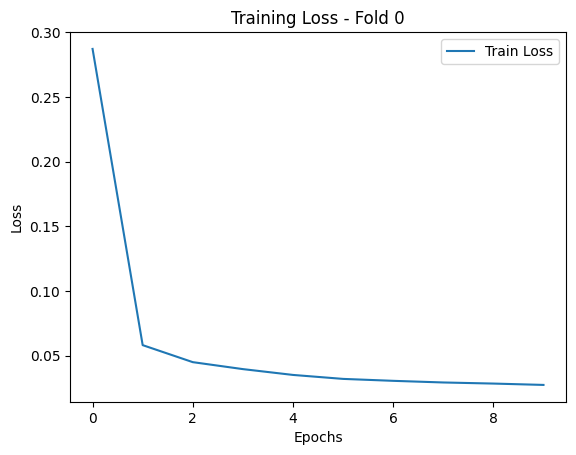

epoch : 1/10, Train loss = 0.178251
epoch : 2/10, Train loss = 0.056236
epoch : 3/10, Train loss = 0.038286
epoch : 4/10, Train loss = 0.037453
epoch : 5/10, Train loss = 0.030502
epoch : 6/10, Train loss = 0.033728
epoch : 7/10, Train loss = 0.028232
epoch : 8/10, Train loss = 0.029254
epoch : 9/10, Train loss = 0.027814
epoch : 10/10, Train loss = 0.026111


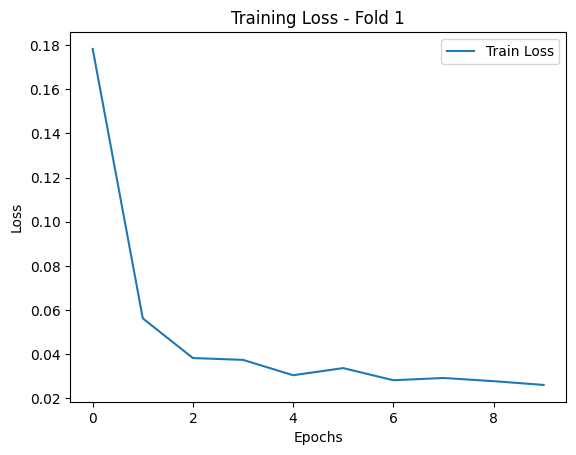

epoch : 1/10, Train loss = 0.172543
epoch : 2/10, Train loss = 0.053299
epoch : 3/10, Train loss = 0.044702
epoch : 4/10, Train loss = 0.031285
epoch : 5/10, Train loss = 0.034378
epoch : 6/10, Train loss = 0.026919
epoch : 7/10, Train loss = 0.032683
epoch : 8/10, Train loss = 0.024853
epoch : 9/10, Train loss = 0.027556
epoch : 10/10, Train loss = 0.024285


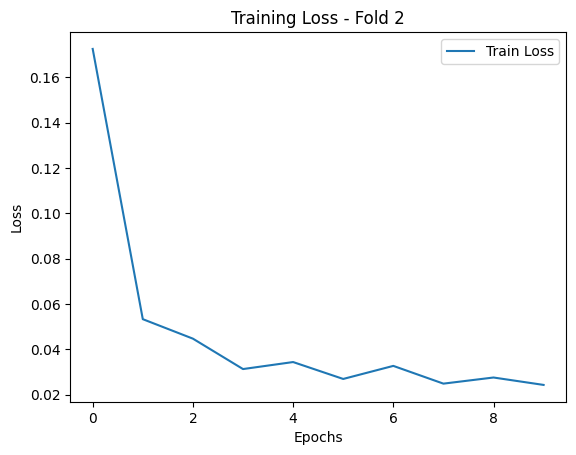

epoch : 1/10, Train loss = 0.238307
epoch : 2/10, Train loss = 0.053599
epoch : 3/10, Train loss = 0.042452
epoch : 4/10, Train loss = 0.037288
epoch : 5/10, Train loss = 0.033117
epoch : 6/10, Train loss = 0.031658
epoch : 7/10, Train loss = 0.030381
epoch : 8/10, Train loss = 0.029666
epoch : 9/10, Train loss = 0.028614
epoch : 10/10, Train loss = 0.028712


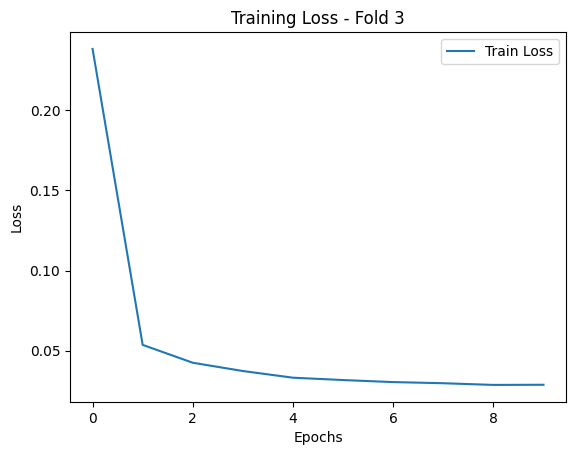

epoch : 1/10, Train loss = 0.164264
epoch : 2/10, Train loss = 0.042150
epoch : 3/10, Train loss = 0.036722
epoch : 4/10, Train loss = 0.032622
epoch : 5/10, Train loss = 0.031632
epoch : 6/10, Train loss = 0.029241
epoch : 7/10, Train loss = 0.028861
epoch : 8/10, Train loss = 0.026668
epoch : 9/10, Train loss = 0.026255
epoch : 10/10, Train loss = 0.025291


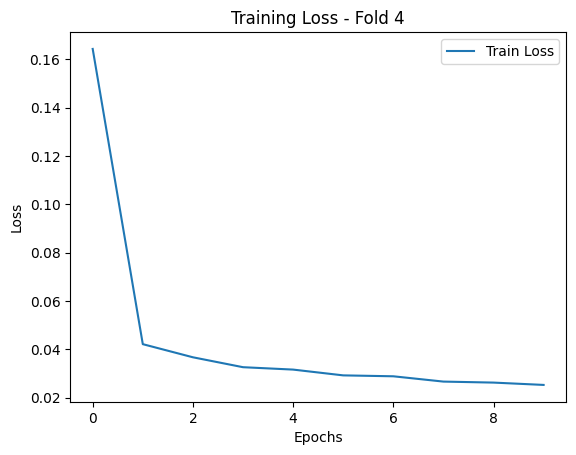

epoch : 1/10, Train loss = 0.224429
epoch : 2/10, Train loss = 0.054757
epoch : 3/10, Train loss = 0.045121
epoch : 4/10, Train loss = 0.040383
epoch : 5/10, Train loss = 0.037499
epoch : 6/10, Train loss = 0.033714
epoch : 7/10, Train loss = 0.033078
epoch : 8/10, Train loss = 0.029966
epoch : 9/10, Train loss = 0.030887
epoch : 10/10, Train loss = 0.027000


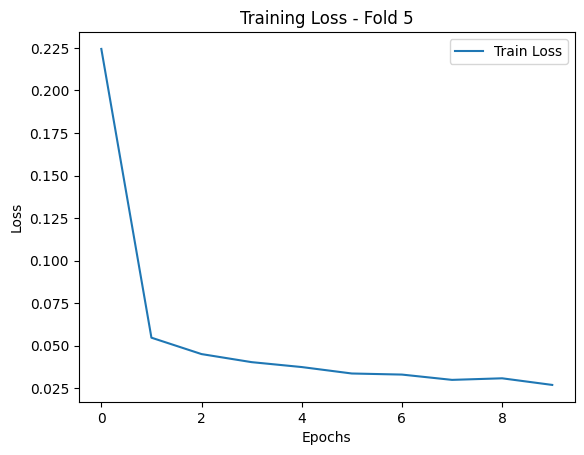

epoch : 1/10, Train loss = 0.211809
epoch : 2/10, Train loss = 0.055701
epoch : 3/10, Train loss = 0.043693
epoch : 4/10, Train loss = 0.035834
epoch : 5/10, Train loss = 0.032823
epoch : 6/10, Train loss = 0.028226
epoch : 7/10, Train loss = 0.030680
epoch : 8/10, Train loss = 0.028874
epoch : 9/10, Train loss = 0.024800
epoch : 10/10, Train loss = 0.029675


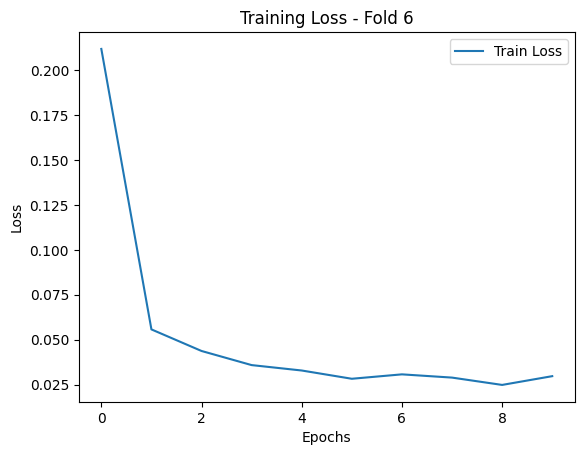

epoch : 1/10, Train loss = 0.159517
epoch : 2/10, Train loss = 0.047713
epoch : 3/10, Train loss = 0.040636
epoch : 4/10, Train loss = 0.035039
epoch : 5/10, Train loss = 0.034380
epoch : 6/10, Train loss = 0.030846
epoch : 7/10, Train loss = 0.030210
epoch : 8/10, Train loss = 0.029059
epoch : 9/10, Train loss = 0.027207
epoch : 10/10, Train loss = 0.025567


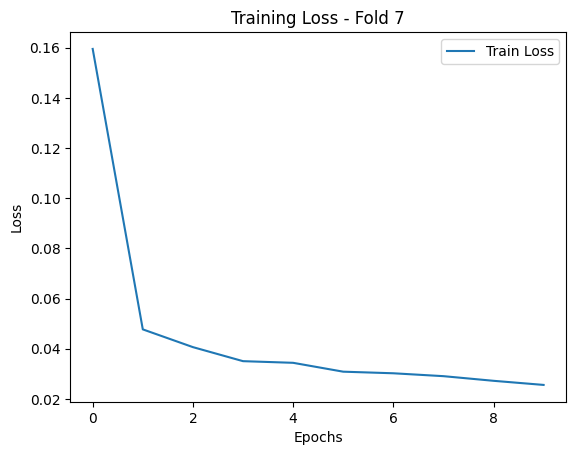

epoch : 1/10, Train loss = 0.193455
epoch : 2/10, Train loss = 0.058078
epoch : 3/10, Train loss = 0.043675
epoch : 4/10, Train loss = 0.041276
epoch : 5/10, Train loss = 0.034341
epoch : 6/10, Train loss = 0.031930
epoch : 7/10, Train loss = 0.030129
epoch : 8/10, Train loss = 0.027325
epoch : 9/10, Train loss = 0.027691
epoch : 10/10, Train loss = 0.029104


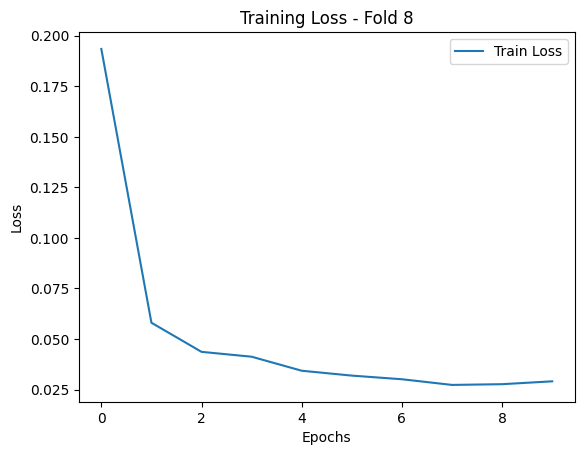

epoch : 1/10, Train loss = 0.221588
epoch : 2/10, Train loss = 0.051643
epoch : 3/10, Train loss = 0.037588
epoch : 4/10, Train loss = 0.033271
epoch : 5/10, Train loss = 0.031564
epoch : 6/10, Train loss = 0.029161
epoch : 7/10, Train loss = 0.028468
epoch : 8/10, Train loss = 0.027126
epoch : 9/10, Train loss = 0.026352
epoch : 10/10, Train loss = 0.025332


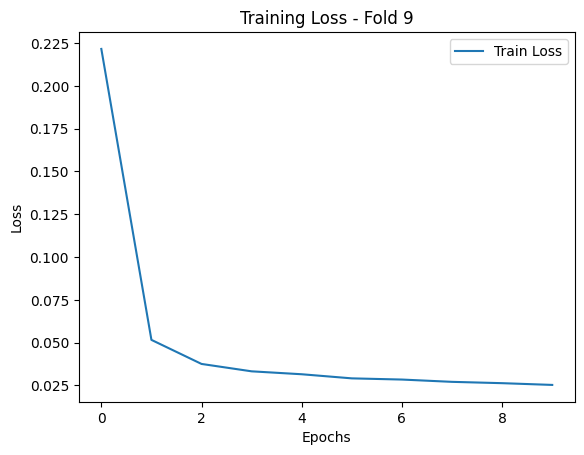

In [19]:
num_folds = 10
kf = KFold(n_splits=num_folds)

volume_types = {"T1": dataset_T1, "T2": dataset_T2, "FLAIR": dataset_FLAIR} # Este dict nos sirve para elegir el tipo de volumen

v_type = "FLAIR"

train_idxs = [] # Lista de los índices de train del fold para poder recuperar los datos pertenecientes a este grupo
test_idxs = [] # Lista de los índices de test del fold para poder recuperar los datos pertenecientes a este grupo

# Mean-squared error loss
criterion = nn.MSELoss()
epochs=10

for fold_index, (train_index, test_index) in enumerate(kf.split(range(len(volume_types[v_type])))):
    train_losses = [] # Guardamos las pérdidas para ahcer el plot
    # Creamos el modelo para este fold
    model_fold = ConvAE().to(device)
    optimizer = torch.optim.RMSprop(model_fold.parameters(), lr=1e-3)
    
    # Obtenemos los datos de train de este fold y creamos el data loader
    train_dataset = [volume_types[v_type][idx] for idx in train_index]
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers=2)
    
    for epoch in range(epochs):
        # Entrenamos el modelo -> obtenemos la función de pérdida
        train_loss = train(model_fold, train_loader, optimizer, criterion) #se obtiene tanto la pérdida como el volumen reconstruido       
        train_losses.append(train_loss)
    
    # Guardamos índices
    train_idxs.append(train_index.tolist())
    test_idxs.append(test_index.tolist())
    
    # Guardamos modelo entrenado
    torch.save(model_fold.state_dict(), "./MODELS_"+v_type+"/model_weights_fold_"+str(fold_index)+"_"+v_type+".pth")
    
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss - Fold '+str(fold_index))
    plt.legend()
    plt.show()

with open("./fold_indices_"+v_type+".json", "w") as f:
    json.dump({"train_idxs": train_idxs, "test_idxs": test_idxs}, f)

### CON LOS MODELOS ENTRENADOS, PROCEDEMOS A EVALUAR

In [52]:
volume_types_healthy = {"T1": dataset_T1, "T2": dataset_T2, "FLAIR": dataset_FLAIR} # Este dict nos sirve para elegir el tipo de volumen
volume_types_glioma = {"T1": glioma_dataset_T1, "T2": glioma_dataset_T2, "FLAIR": glioma_dataset_FLAIR} # Este dict nos sirve para elegir el tipo de volumen

v_type = "T2"

MSE_healthy_train = []
LOGL_healthy_train = []

MSE_healthy_test = []
LOGL_healthy_test = []

MSE_glioma_train = []
LOGL_glioma_train = []

MSE_glioma_test = []
LOGL_glioma_test = []

# Mean-squared error loss
criterion = nn.MSELoss()

# Leemos los índices para que coincidan con los de entrenamiento
with open("./fold_indices_"+v_type+".json", "r") as f:
    indices = json.load(f)
    train_idxs = indices["train_idxs"]
    test_idxs = indices["test_idxs"]
    
with open("./fold_indices_glioma_"+v_type+".json", "r") as f:
    indices_g = json.load(f)
    train_glioma_idxs = indices_g["glioma_train_idxs"]
    test_glioma_idxs = indices_g["glioma_test_idxs"]
    
for fold_index, (train_idxs_fold, test_idxs_fold) in enumerate(zip(train_idxs, test_idxs)):
    # TRAIN
    state_dict = torch.load('./MODELS_'+v_type+'/model_weights_fold_'+str(fold_index)+'_'+v_type+'.pth') # Cargamos los pesos
    model_fold = ConvAE().to(device)
    model_fold.load_state_dict(state_dict) # Cargamos el modelo con los pesos
    
    # Recuperamos el conjunto de train
    train_dataset = [volume_types_healthy[v_type][idx] for idx in train_idxs[fold_index]]
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=False, num_workers=2)
    
    #Evaluamos el modelo con datos de train
    MSEs_train = test(model_fold, train_loader, criterion) 
    
    # Obtenemos los vectores latentes usando el modelo encoder
    encoder_fold = Encoder().to(device) # Cargamos el modelo
    
    # Cargamos los pesos del entrenamiento al codificador
    encoder_fold.encoder[0].weight.data = state_dict['encoder.0.weight']
    encoder_fold.encoder[0].bias.data = state_dict['encoder.0.bias']
    encoder_fold.encoder[3].weight.data = state_dict['encoder.3.weight']
    encoder_fold.encoder[3].bias.data = state_dict['encoder.3.bias']
    
    # Generamos los tensores latentes de train
    encoded_volumes_train_fold = test(encoder_fold, train_loader, criterion) # 72 tensores = 72 pacientes en train

    # Vamos a convertir los tensores de 4 dimensiones a un vector (1 dimensión) -> de tensor latente a vector latente
    out_vector_shape = encoded_volumes_train_fold[0].shape[0]*encoded_volumes_train_fold[0].shape[1]*encoded_volumes_train_fold[0].shape[2]*encoded_volumes_train_fold[0].shape[3] # Multiplicamos las 4 dimensiones del tensor latente para un volumen
    latent_vectors_fold_train = [np.reshape(np.array(encoded_vol), (out_vector_shape)) for encoded_vol in encoded_volumes_train_fold]

    bandwidths = np.logspace(-1, 1, 20) # Definimos una cuadrícula de valores de ancho de banda

    # Realizamos una búsqueda de ancho de banda utilizando validación cruzada
    grid = GridSearchCV(KernelDensity(), {'bandwidth': bandwidths})
    grid.fit(latent_vectors_fold_train)

    # Obtener el mejor ancho de banda
    best_bandwidth = grid.best_params_['bandwidth']
    
    # Entrenamos el modelo de KDE -> generamos la función de probabilidad de los vectores latentes de los pacientes sanos
    kde = KernelDensity(kernel='gaussian',bandwidth=best_bandwidth).fit(latent_vectors_fold_train) 

    # Calculamos las log-likelihoods para el conjunto train
    log_likelihoods_train = kde.score_samples(latent_vectors_fold_train)
    
    MSE_healthy_train.append(MSEs_train)
    LOGL_healthy_train.append(log_likelihoods_train.tolist())
    
    # Eliminamos variables para mejor gestión de memoria
    del train_loader, train_dataset, encoded_volumes_train_fold, latent_vectors_fold_train
    gc.collect()
    torch.cuda.empty_cache()
    
    
    # TEST
    # Recuperamos conjunto de test
    test_dataset = [volume_types_healthy[v_type][idx] for idx in test_idxs[fold_index]]
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)
    
    #Evaluamos el modelo con datos de test
    MSEs_test = test(model_fold, test_loader, criterion)
    
    # Generamos los vectores latentes de test
    encoded_volumes_test_fold = test(encoder_fold, test_loader, criterion) 

    out_vector_shape = encoded_volumes_test_fold[0].shape[0]*encoded_volumes_test_fold[0].shape[1]*encoded_volumes_test_fold[0].shape[2]*encoded_volumes_test_fold[0].shape[3] # Multiplicamos las 4 dimensiones del tensor latente para un volumen

    latent_vectors_fold_test = [np.reshape(np.array(encoded_vol), (out_vector_shape)) for encoded_vol in encoded_volumes_test_fold]

    # Calculamos las log-likelihoods para el conjunto test
    log_likelihoods_test = kde.score_samples(latent_vectors_fold_test)
    
    MSE_healthy_test.append(MSEs_test)
    LOGL_healthy_test.append(log_likelihoods_test.tolist())
    
    # Eliminamos variables para mejor gestión de memoria
    del test_loader, test_dataset, encoded_volumes_test_fold, latent_vectors_fold_test
    gc.collect()
    torch.cuda.empty_cache()
    
    
    # TRAIN GLIOMA
    glioma_train_dataset = [volume_types_glioma[v_type][idx] for idx in train_glioma_idxs[fold_index]]
    glioma_train_loader = torch.utils.data.DataLoader(glioma_train_dataset, batch_size=4, shuffle=False, num_workers=2)
    
    #Evaluamos el modelo con datos de test
    MSEs_train_glioma = test(model_fold, glioma_train_loader, criterion)
    
    # Generamos los vectores latentes de test
    encoded_volumes_glioma_fold = test(encoder_fold, glioma_train_loader, criterion) 

    out_vector_shape = encoded_volumes_glioma_fold[0].shape[0]*encoded_volumes_glioma_fold[0].shape[1]*encoded_volumes_glioma_fold[0].shape[2]*encoded_volumes_glioma_fold[0].shape[3] # Multiplicamos las 4 dimensiones del tensor latente para un volumen

    latent_vectors_train_fold_glioma = [np.reshape(np.array(encoded_vol), (out_vector_shape)) for encoded_vol in encoded_volumes_glioma_fold]

    # Calculamos las log-likelihoods para el conjunto glioma
    log_likelihoods_train_glioma = kde.score_samples(latent_vectors_train_fold_glioma)
    
    MSE_glioma_train.append(MSEs_train_glioma)
    LOGL_glioma_train.append(log_likelihoods_train_glioma.tolist())
    
    # Eliminamos variables para mejor gestión de memoria
    del glioma_train_loader, glioma_train_dataset, encoded_volumes_glioma_fold, latent_vectors_train_fold_glioma
    gc.collect()
    torch.cuda.empty_cache()
    
    
    # TEST GLIOMA
    glioma_test_dataset = [volume_types_glioma[v_type][idx] for idx in test_glioma_idxs[fold_index]]
    glioma_test_loader = torch.utils.data.DataLoader(glioma_test_dataset, batch_size=4, shuffle=False, num_workers=2)
    
    #Evaluamos el modelo con datos de test
    MSEs_test_glioma = test(model_fold, glioma_test_loader, criterion)
    
    # Generamos los vectores latentes de test
    encoded_volumes_glioma_fold = test(encoder_fold, glioma_test_loader, criterion) 

    out_vector_shape = encoded_volumes_glioma_fold[0].shape[0]*encoded_volumes_glioma_fold[0].shape[1]*encoded_volumes_glioma_fold[0].shape[2]*encoded_volumes_glioma_fold[0].shape[3] # Multiplicamos las 4 dimensiones del tensor latente para un volumen

    latent_vectors_test_fold_glioma = [np.reshape(np.array(encoded_vol), (out_vector_shape)) for encoded_vol in encoded_volumes_glioma_fold]

    # Calculamos las log-likelihoods para el conjunto glioma
    log_likelihoods_test_glioma = kde.score_samples(latent_vectors_test_fold_glioma)
    
    MSE_glioma_test.append(MSEs_test_glioma)
    LOGL_glioma_test.append(log_likelihoods_test_glioma.tolist())
    
    # Eliminamos variables para mejor gestión de memoria
    del glioma_test_loader, glioma_test_dataset, encoded_volumes_glioma_fold, latent_vectors_test_fold_glioma
    gc.collect()
    torch.cuda.empty_cache()

#### Vamos a guardar los MSE y Log-Likelihoods en disco. De esta forma, no hace falta ejecutar las celdas de arriba cada vez.

In [53]:
with open("./results3_"+v_type+".json", "w") as f:
    json.dump({"MSE_healthy_train": MSE_healthy_train, "LOGL_healthy_train": LOGL_healthy_train, 
               "MSE_healthy_test": MSE_healthy_test, "LOGL_healthy_test": LOGL_healthy_test,
               "MSE_glioma_train": MSE_glioma_train, "LOGL_glioma_train": LOGL_glioma_train,
              "MSE_glioma_test": MSE_glioma_test, "LOGL_glioma_test": LOGL_glioma_test}, f)

#### Una vez se tienen las características de cada tipo de volumen, vamos a hacer algunas visualizaciones conjuntas. Es por ello, que cargamos todos los datos de disco. Si ya se disponen en disco (se ha entrenado el modelo y se han obtenido las características), no hace falta ejecutar las celdas de arriba.

In [28]:
for v_type in ["T1", "T2", "FLAIR"]:
    if v_type == "T1":
        with open("./results3_"+v_type+".json", "r") as f:
            results = json.load(f)
            MSE_healthy_train_T1 = results["MSE_healthy_train"]
            LOGL_healthy_train_T1 = results["LOGL_healthy_train"]
            MSE_healthy_test_T1 = results["MSE_healthy_test"]
            LOGL_healthy_test_T1 = results["LOGL_healthy_test"]
            MSE_glioma_train_T1 = results["MSE_glioma_train"]
            LOGL_glioma_train_T1= results["LOGL_glioma_train"]
            MSE_glioma_test_T1 = results["MSE_glioma_test"]
            LOGL_glioma_test_T1= results["LOGL_glioma_test"]
    
    elif v_type == "T2":
        with open("./results3_"+v_type+".json", "r") as f:
            results = json.load(f)
            MSE_healthy_train_T2 = results["MSE_healthy_train"]
            LOGL_healthy_train_T2 = results["LOGL_healthy_train"]
            MSE_healthy_test_T2 = results["MSE_healthy_test"]
            LOGL_healthy_test_T2 = results["LOGL_healthy_test"]
            MSE_glioma_train_T2 = results["MSE_glioma_train"]
            LOGL_glioma_train_T2= results["LOGL_glioma_train"]
            MSE_glioma_test_T2 = results["MSE_glioma_test"]
            LOGL_glioma_test_T2= results["LOGL_glioma_test"]
            
    if v_type == "FLAIR":
        with open("./results3_"+v_type+".json", "r") as f:
            results = json.load(f)
            MSE_healthy_train_FLAIR = results["MSE_healthy_train"]
            LOGL_healthy_train_FLAIR = results["LOGL_healthy_train"]
            MSE_healthy_test_FLAIR = results["MSE_healthy_test"]
            LOGL_healthy_test_FLAIR = results["LOGL_healthy_test"]
            MSE_glioma_train_FLAIR = results["MSE_glioma_train"]
            LOGL_glioma_train_FLAIR= results["LOGL_glioma_train"]
            MSE_glioma_test_FLAIR = results["MSE_glioma_test"]
            LOGL_glioma_test_FLAIR= results["LOGL_glioma_test"]
            

Agrupamos las características de los 3 tipos de MRI.

In [29]:
mse_train = [MSE_healthy_train_T1, MSE_healthy_train_T2, MSE_healthy_train_FLAIR]
mse_test = [MSE_healthy_test_T1, MSE_healthy_test_T2, MSE_healthy_test_FLAIR]
mse_glioma_train = [MSE_glioma_train_T1, MSE_glioma_train_T2, MSE_glioma_train_FLAIR]
mse_glioma_test = [MSE_glioma_test_T1, MSE_glioma_test_T2, MSE_glioma_test_FLAIR]


loglikelihoods_train = [LOGL_healthy_train_T1, LOGL_healthy_train_T2, LOGL_healthy_train_FLAIR]
loglikelihoods_test = [LOGL_healthy_test_T1, LOGL_healthy_test_T2, LOGL_healthy_test_FLAIR]
loglikelihoods_glioma_train = [LOGL_glioma_train_T1, LOGL_glioma_train_T2, LOGL_glioma_train_FLAIR]
loglikelihoods_glioma_test = [LOGL_glioma_test_T1, LOGL_glioma_test_T2, LOGL_glioma_test_FLAIR]

####  GUARDAMOS LOS RESULTADOS POR PACIENTE (NOS SERVIRÁ PARA COMPARAR LOS RESULTADOS DE LA CLASIFICACIÓN)

In [30]:
for i, MRI_type in enumerate(["T1", "T2", "FLAIR"]):
    mse_train_per_index = {}
    mse_test_per_index = {}
    mse_glioma_train_per_index = {}
    mse_glioma_test_per_index = {}
    logl_train_per_index = {}
    logl_test_per_index = {}
    logl_glioma_train_per_index = {}
    logl_glioma_test_per_index = {}
    with open("./fold_indices_"+MRI_type+".json", "r") as f:
        indices = json.load(f)
        train_idxs = indices["train_idxs"]
        test_idxs = indices["test_idxs"]

    with open("./fold_indices_glioma_"+MRI_type+".json", "r") as f:
        indices_g = json.load(f)
        train_glioma_idxs = indices_g["glioma_train_idxs"]
        test_glioma_idxs = indices_g["glioma_test_idxs"]

    for j, fold in enumerate(train_idxs):
        for k, idx in enumerate(fold):
            if idx in mse_train_per_index.keys():
                mse_train_per_index[idx].append(mse_train[i][j][k])
                logl_train_per_index[idx].append(loglikelihoods_train[i][j][k])
            else:
                mse_train_per_index[idx] = [mse_train[i][j][k]]
                logl_train_per_index[idx] = [loglikelihoods_train[i][j][k]]

    for j, fold in enumerate(test_idxs):
        for k, idx in enumerate(fold):
            if idx in mse_test_per_index.keys():
                mse_test_per_index[idx].append(mse_test[i][j][k])
                logl_test_per_index[idx].append(loglikelihoods_test[i][j][k])
            else:
                mse_test_per_index[idx] = [mse_test[i][j][k]]
                logl_test_per_index[idx] = [loglikelihoods_test[i][j][k]]

    for j, fold in enumerate(train_glioma_idxs):
        for k, idx in enumerate(fold):
            if idx in mse_glioma_train_per_index.keys():
                mse_glioma_train_per_index[idx].append(mse_glioma_train[i][j][k])
                logl_glioma_train_per_index[idx].append(loglikelihoods_glioma_train[i][j][k])
            else:
                mse_glioma_train_per_index[idx] = [mse_glioma_train[i][j][k]]
                logl_glioma_train_per_index[idx] = [loglikelihoods_glioma_train[i][j][k]]

    for j, fold in enumerate(test_glioma_idxs):
        for k, idx in enumerate(fold):
            if idx in mse_glioma_test_per_index.keys():
                mse_glioma_test_per_index[idx].append(mse_glioma_test[i][j][k])
                logl_glioma_test_per_index[idx].append(loglikelihoods_glioma_test[i][j][k])
            else:
                mse_glioma_test_per_index[idx] = [mse_glioma_test[i][j][k]]
                logl_glioma_test_per_index[idx] = [loglikelihoods_glioma_test[i][j][k]]


    with open("./results3_per_index"+MRI_type+".json", "w") as f:
        json.dump({"mse_train_per_index": mse_train_per_index, "logl_train_per_index": logl_train_per_index, 
                   "mse_test_per_index": mse_test_per_index, "logl_test_per_index": logl_test_per_index,
                   "mse_glioma_train_per_index": mse_glioma_train_per_index, "logl_glioma_train_per_index": logl_glioma_train_per_index,
                  "mse_glioma_test_per_index": mse_glioma_test_per_index, "logl_glioma_test_per_index": logl_glioma_test_per_index}, f)

#### ESTA CELDA SIRVE PARA RECUPERAR EN VARIABLES LOS RESULTADOS GUARDADOS. SI SE HA EJECUTADO LA CELDA DE ARRIBA, PUEDE OMITIRSE ESTA. DE NO TENER EN DISCO LOS RESULTADOS AÚN, NO EJECUTAR.

In [31]:
for MRI_type in ["T1", "T2", "FLAIR"]:
    if MRI_type == "T1":
        with open("./results3_per_index"+MRI_type+".json", "r") as f:
            results = json.load(f)
            mse_train_per_index_T1 = results["mse_train_per_index"]
            logl_train_per_index_T1 = results["logl_train_per_index"]
            mse_test_per_index_T1 = results["mse_test_per_index"]
            logl_test_per_index_T1 = results["logl_test_per_index"]
            mse_glioma_train_per_index_T1 = results["mse_glioma_train_per_index"]
            logl_glioma_train_per_index_T1= results["logl_glioma_train_per_index"]
            mse_glioma_test_per_index_T1 = results["mse_glioma_test_per_index"]
            logl_glioma_test_per_index_T1= results["logl_glioma_test_per_index"]
    
    elif MRI_type == "T2":
        with open("./results3_per_index"+MRI_type+".json", "r") as f:
            results = json.load(f)
            mse_train_per_index_T2 = results["mse_train_per_index"]
            logl_train_per_index_T2 = results["logl_train_per_index"]
            mse_test_per_index_T2 = results["mse_test_per_index"]
            logl_test_per_index_T2 = results["logl_test_per_index"]
            mse_glioma_train_per_index_T2 = results["mse_glioma_train_per_index"]
            logl_glioma_train_per_index_T2= results["logl_glioma_train_per_index"]
            mse_glioma_test_per_index_T2 = results["mse_glioma_test_per_index"]
            logl_glioma_test_per_index_T2= results["logl_glioma_test_per_index"]
            
    if MRI_type == "FLAIR":
        with open("./results3_per_index"+MRI_type+".json", "r") as f:
            results = json.load(f)
            mse_train_per_index_FLAIR = results["mse_train_per_index"]
            logl_train_per_index_FLAIR = results["logl_train_per_index"]
            mse_test_per_index_FLAIR = results["mse_test_per_index"]
            logl_test_per_index_FLAIR = results["logl_test_per_index"]
            mse_glioma_train_per_index_FLAIR = results["mse_glioma_train_per_index"]
            logl_glioma_train_per_index_FLAIR = results["logl_glioma_train_per_index"]
            mse_glioma_test_per_index_FLAIR = results["mse_glioma_test_per_index"]
            logl_glioma_test_per_index_FLAIR = results["logl_glioma_test_per_index"]
            

Para poder hacer las comparaciones correctamente en la clasificación, debemos comparar entre mismos pacientes. Por ello se ha guardado el archivo Patients_map, una lista de listas (para cada tipo de MRI) hay un 1.0 si un paciente se encuentra en ese conjunto. Por tanto, se compararán aquellos pacientes que aparezcan en todos los conjuntos (haya un 1.0 en la misma posición).

In [32]:
def find_common_positions(*lists):
    if not lists:
        return []
    
    # Longitud mínima entre las listas para evitar IndexError
    min_length = min(len(lst) for lst in lists)
    
    common_positions = []
    
    for i in range(min_length):
        if all(lst[i] == 1.0 for lst in lists):
            common_positions.append(i)
    
    return common_positions

# Leemos el archivo JSON
with open("./Patients_map.json", "r") as f:
    data = json.load(f)

patients_healthy_T1 = data["Patients_healthy_T1"]
patients_glioma_T1 = data["Patients_glioma_T1"]
patients_healthy_T2 = data["Patients_healthy_T2"]
patients_glioma_T2 = data["Patients_glioma_T2"]
patients_healthy_FLAIR = data["Patients_healthy_FLAIR"]
patients_glioma_FLAIR = data["Patients_glioma_FLAIR"]

common_patients_healthy = find_common_positions(patients_healthy_T1, patients_healthy_T2,
                               patients_healthy_FLAIR)
print("Lista de pacientes sanos en común:", common_patients_healthy)
print("Número de pacientes de esta lista:", str(len(common_patients_healthy)))

common_patients_glioma = find_common_positions(patients_glioma_T1, patients_glioma_T2,
                               patients_glioma_FLAIR)
print("Lista de pacientes con glioma en común:", common_patients_glioma)
print("Número de pacientes de esta lista:", str(len(common_patients_glioma)))

Lista de pacientes sanos en común: [1, 6, 22, 26, 57, 75, 87, 95, 111, 116, 117, 125, 130, 131, 135, 140, 152, 153, 156, 164, 178, 179, 193, 201, 206, 208, 219, 221, 226, 230, 237, 255, 262]
Número de pacientes de esta lista: 33
Lista de pacientes con glioma en común: [34, 79, 88, 94, 101, 119, 144, 149, 152, 164, 171, 188, 189, 203, 207, 218, 235, 240, 250, 251, 268]
Número de pacientes de esta lista: 21


#### OBTENEMOS AHORA LAS CARACTERÍSTICAS (MSE Y LOG-LIKELIHOOD) DE CADA TIPO DE MRI AGRUPADA POR PACIENTE.

In [33]:
for MRI_type in ["T1", "T2", "FLAIR"]:
    if MRI_type == "T1":
        # Encontrar los índices de los valores 1.0 en la lista patients_healthy_T1
        indices_ones = [i for i, x in enumerate(patients_healthy_T1) if x == 1.0]
        # Crear el nuevo diccionario
        mse_train_per_patient_T1 = {indice: mse_train_per_index_T1[str(i)] for i, indice in enumerate(indices_ones)}
        mse_test_per_patient_T1 = {indice: mse_test_per_index_T1[str(i)] for i, indice in enumerate(indices_ones)}
        logl_train_per_patient_T1 = {indice: logl_train_per_index_T1[str(i)] for i, indice in enumerate(indices_ones)}
        logl_test_per_patient_T1 = {indice: logl_test_per_index_T1[str(i)] for i, indice in enumerate(indices_ones)}
        
        indices_ones = [i for i, x in enumerate(patients_glioma_T1) if x == 1.0]
        mse_glioma_train_per_patient_T1 = {indice: mse_glioma_train_per_index_T1[str(i)] for i, indice in enumerate(indices_ones)}
        mse_glioma_test_per_patient_T1 = {indice: mse_glioma_test_per_index_T1[str(i)] for i, indice in enumerate(indices_ones)}
        logl_glioma_train_per_patient_T1 = {indice: logl_glioma_train_per_index_T1[str(i)] for i, indice in enumerate(indices_ones)}
        logl_glioma_test_per_patient_T1 = {indice: logl_glioma_test_per_index_T1[str(i)] for i, indice in enumerate(indices_ones)}
        
    elif MRI_type == "T2":
        # Encontrar los índices de los valores 1.0 en la lista patients_healthy_T1
        indices_ones = [i for i, x in enumerate(patients_healthy_T2) if x == 1.0]
        # Crear el nuevo diccionario
        mse_train_per_patient_T2 = {indice: mse_train_per_index_T2[str(i)] for i, indice in enumerate(indices_ones)}
        mse_test_per_patient_T2 = {indice: mse_test_per_index_T2[str(i)] for i, indice in enumerate(indices_ones)}
        logl_train_per_patient_T2 = {indice: logl_train_per_index_T2[str(i)] for i, indice in enumerate(indices_ones)}
        logl_test_per_patient_T2 = {indice: logl_test_per_index_T2[str(i)] for i, indice in enumerate(indices_ones)}
        
        indices_ones = [i for i, x in enumerate(patients_glioma_T2) if x == 1.0]
        mse_glioma_train_per_patient_T2 = {indice: mse_glioma_train_per_index_T2[str(i)] for i, indice in enumerate(indices_ones)}
        mse_glioma_test_per_patient_T2 = {indice: mse_glioma_test_per_index_T2[str(i)] for i, indice in enumerate(indices_ones)}
        logl_glioma_train_per_patient_T2 = {indice: logl_glioma_train_per_index_T2[str(i)] for i, indice in enumerate(indices_ones)}
        logl_glioma_test_per_patient_T2 = {indice: logl_glioma_test_per_index_T2[str(i)] for i, indice in enumerate(indices_ones)}
        
    else:
        # Encontrar los índices de los valores 1.0 en la lista patients_healthy_T1
        indices_ones = [i for i, x in enumerate(patients_healthy_FLAIR) if x == 1.0]
        # Crear el nuevo diccionario
        mse_train_per_patient_FLAIR = {indice: mse_train_per_index_FLAIR[str(i)] for i, indice in enumerate(indices_ones)}
        mse_test_per_patient_FLAIR = {indice: mse_test_per_index_FLAIR[str(i)] for i, indice in enumerate(indices_ones)}
        logl_train_per_patient_FLAIR = {indice: logl_train_per_index_FLAIR[str(i)] for i, indice in enumerate(indices_ones)}
        logl_test_per_patient_FLAIR = {indice: logl_test_per_index_FLAIR[str(i)] for i, indice in enumerate(indices_ones)}
        
        indices_ones = [i for i, x in enumerate(patients_glioma_FLAIR) if x == 1.0]
        mse_glioma_train_per_patient_FLAIR = {indice: mse_glioma_train_per_index_FLAIR[str(i)] for i, indice in enumerate(indices_ones)}
        mse_glioma_test_per_patient_FLAIR = {indice: mse_glioma_test_per_index_FLAIR[str(i)] for i, indice in enumerate(indices_ones)}
        logl_glioma_train_per_patient_FLAIR = {indice: logl_glioma_train_per_index_FLAIR[str(i)] for i, indice in enumerate(indices_ones)}
        logl_glioma_test_per_patient_FLAIR = {indice: logl_glioma_test_per_index_FLAIR[str(i)] for i, indice in enumerate(indices_ones)}


### VISUALIZACIONES DE MSE Y LOGLIKELIHOODS POR TIPO MRI

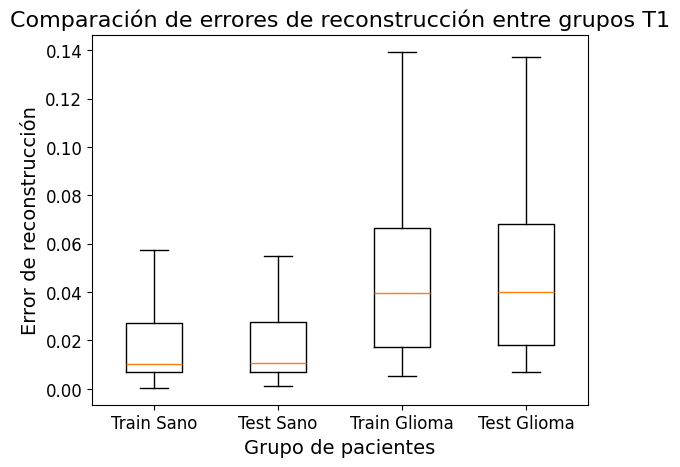

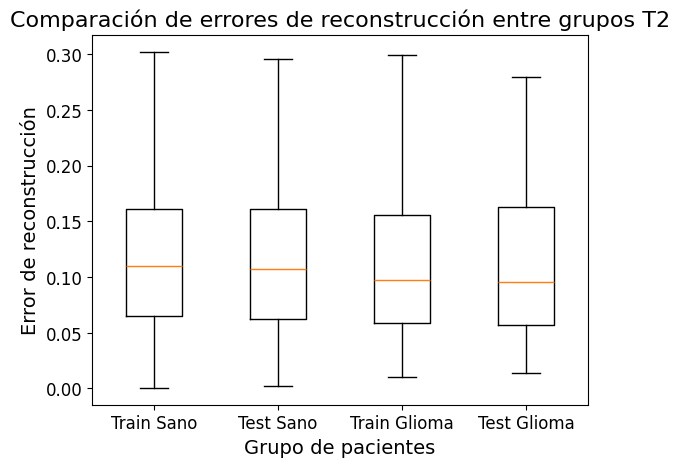

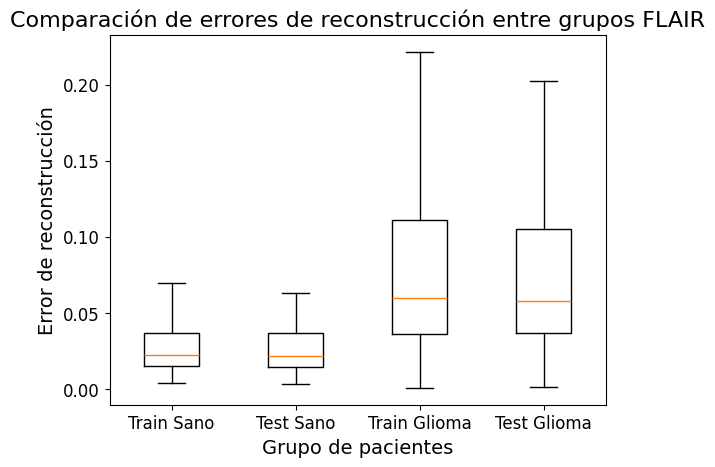

In [34]:
import matplotlib.pyplot as plt

for i, v_type in enumerate(["T1", "T2", "FLAIR"]):
    
    MSE_healthy_train_f = [elemento for sublista in mse_train[i] for elemento in sublista]
    MSE_healthy_test_f = [elemento for sublista in mse_test[i] for elemento in sublista]
    MSE_glioma_train_f = [elemento for sublista in mse_glioma_train[i] for elemento in sublista]
    MSE_glioma_test_f = [elemento for sublista in mse_glioma_test[i] for elemento in sublista]

    plt.boxplot([MSE_healthy_train_f, MSE_healthy_test_f, MSE_glioma_train_f, MSE_glioma_test_f],
                labels=['Train Sano', 'Test Sano', 'Train Glioma', 'Test Glioma'], showfliers=False)

    plt.xlabel('Grupo de pacientes', fontsize=14)
    plt.ylabel('Error de reconstrucción', fontsize=14)
    plt.title('Comparación de errores de reconstrucción entre grupos ' + v_type, fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

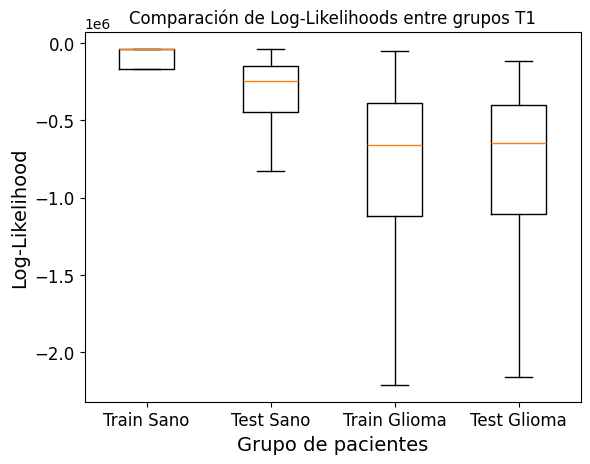

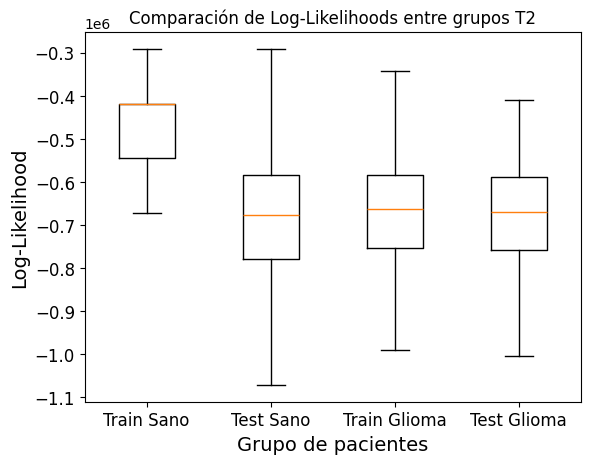

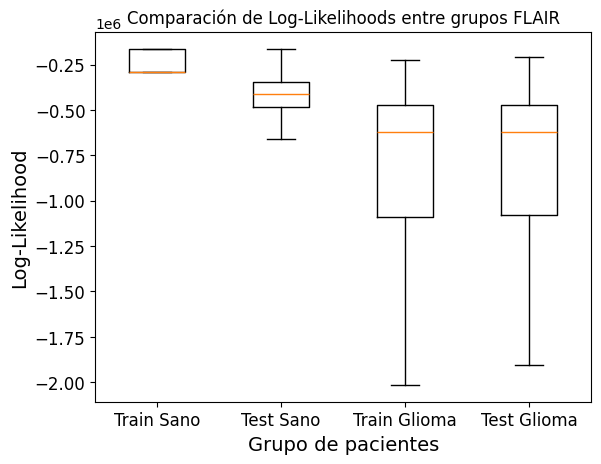

In [35]:
for i, v_type in enumerate(["T1", "T2", "FLAIR"]):
    LOGL_healthy_train_f = [elemento for sublista in loglikelihoods_train[i] for elemento in sublista]
    LOGL_healthy_test_f = [elemento for sublista in loglikelihoods_test[i] for elemento in sublista]
    LOGL_glioma_train_f = [elemento for sublista in loglikelihoods_glioma_train[i] for elemento in sublista]
    LOGL_glioma_test_f = [elemento for sublista in loglikelihoods_glioma_test[i] for elemento in sublista]

    plt.boxplot([LOGL_healthy_train_f, LOGL_healthy_test_f, LOGL_glioma_train_f, LOGL_glioma_test_f],
                labels=['Train Sano', 'Test Sano', 'Train Glioma', 'Test Glioma'], showfliers=False)

    plt.xlabel('Grupo de pacientes', fontsize=14)
    plt.ylabel('Log-Likelihood',fontsize=14)
    plt.title('Comparación de Log-Likelihoods entre grupos '+v_type)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

### VISUALIZACIONES DE MSE Y LOGLIKELIHOODS POR TIPO MRI DE CADA FOLD

Media MSE train: 0.017330248538766885
Media MSE test: 0.014697237918153406
Media MSE train glioma: 0.042931208787398915
Media MSE test glioma: 0.03364821818346778


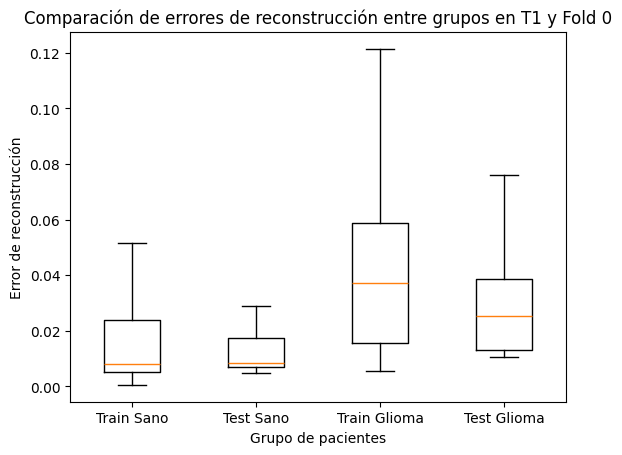

Media MSE train: 0.017009389241704614
Media MSE test: 0.029595125140622257
Media MSE train glioma: 0.04498299925422696
Media MSE test glioma: 0.05235482550536593


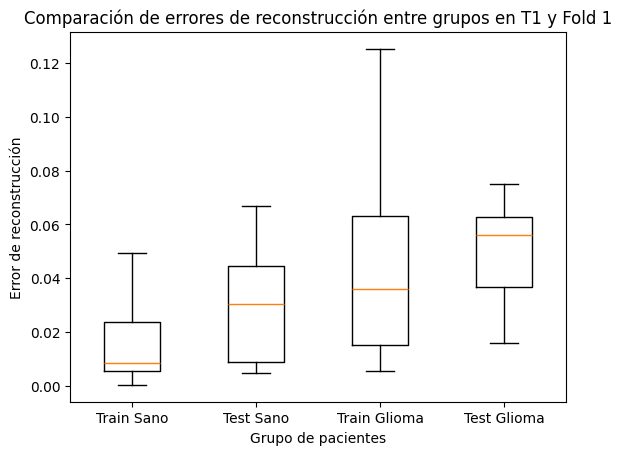

Media MSE train: 0.018874207314284932
Media MSE test: 0.019577195728197695
Media MSE train glioma: 0.045623309805850006
Media MSE test glioma: 0.07872890929381053


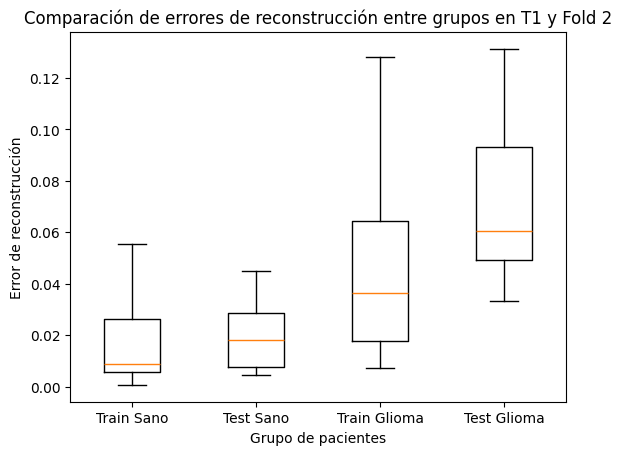

Media MSE train: 0.02061286200963271
Media MSE test: 0.03162395125254989
Media MSE train glioma: 0.05506963272378824
Media MSE test glioma: 0.05380843494397899


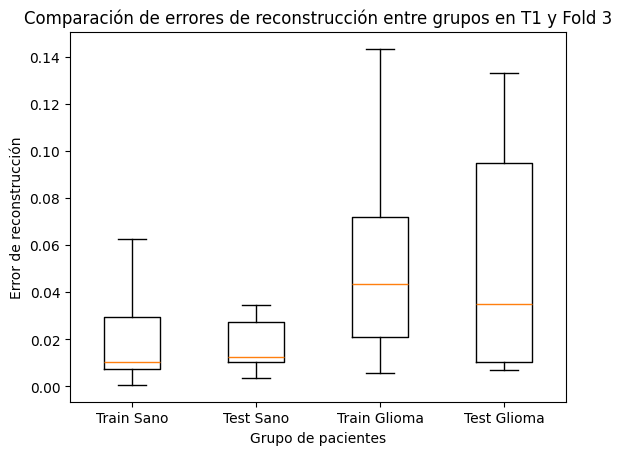

Media MSE train: 0.019139563848471475
Media MSE test: 0.01745726210065186
Media MSE train glioma: 0.046736446727136866
Media MSE test glioma: 0.04134500507886211


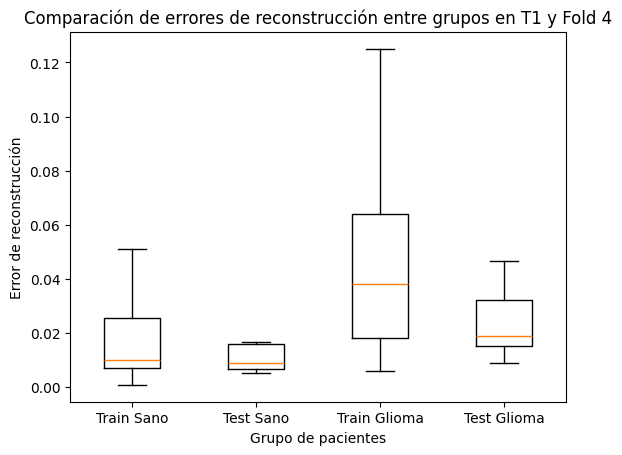

Media MSE train: 0.021651035159205398
Media MSE test: 0.018113122833892704
Media MSE train glioma: 0.05469899855240762
Media MSE test glioma: 0.031168056031068165


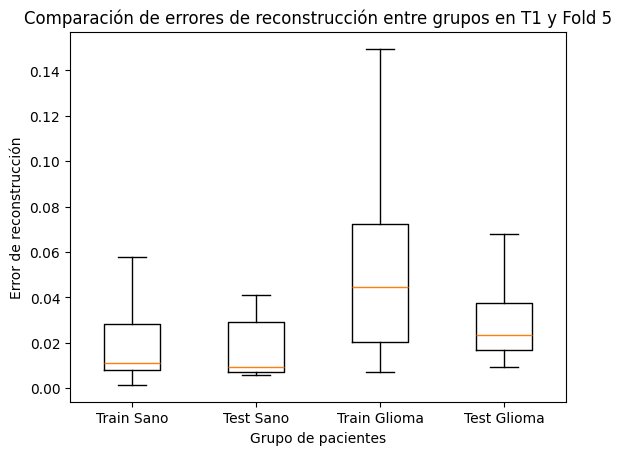

Media MSE train: 0.02284333246320279
Media MSE test: 0.012874259147793055
Media MSE train glioma: 0.052394894582750366
Media MSE test glioma: 0.05157397617585957


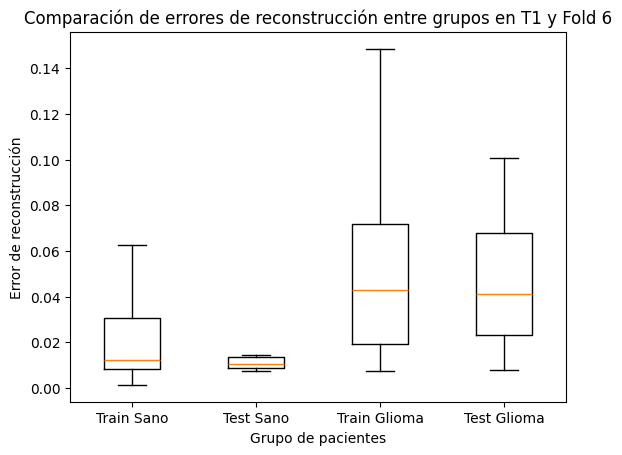

Media MSE train: 0.021798345596633024
Media MSE test: 0.014727299043443054
Media MSE train glioma: 0.049987898129865385
Media MSE test glioma: 0.053420231134320297


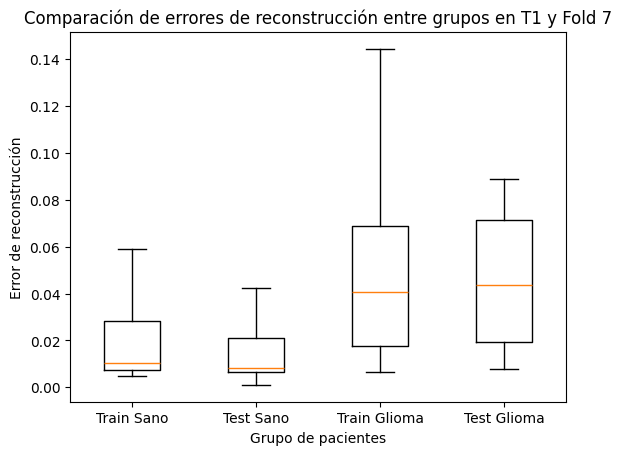

Media MSE train: 0.017616272100713103
Media MSE test: 0.023094211844727396
Media MSE train glioma: 0.04316717390162505
Media MSE test glioma: 0.0475411817121009


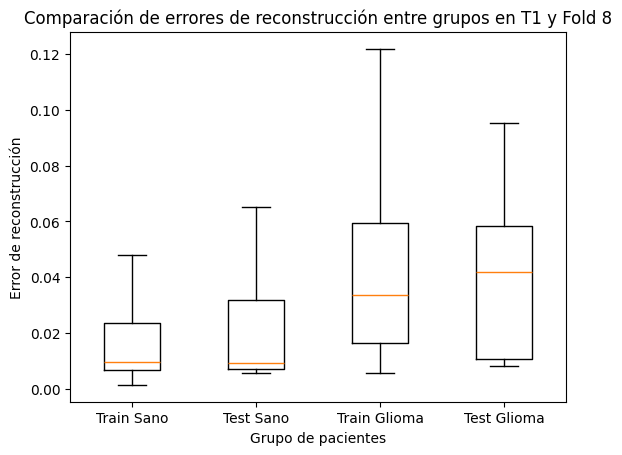

Media MSE train: 0.021432347911306552
Media MSE test: 0.0200544411316514
Media MSE train glioma: 0.05296580855631166
Media MSE test glioma: 0.041638593189418316


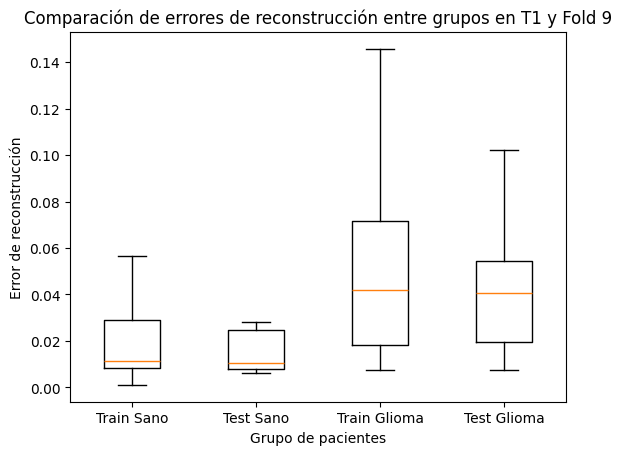

Media MSE train: 0.11958271625073816
Media MSE test: 0.13250322849489748
Media MSE train glioma: 0.12994858238183088
Media MSE test glioma: 0.09501021248953682


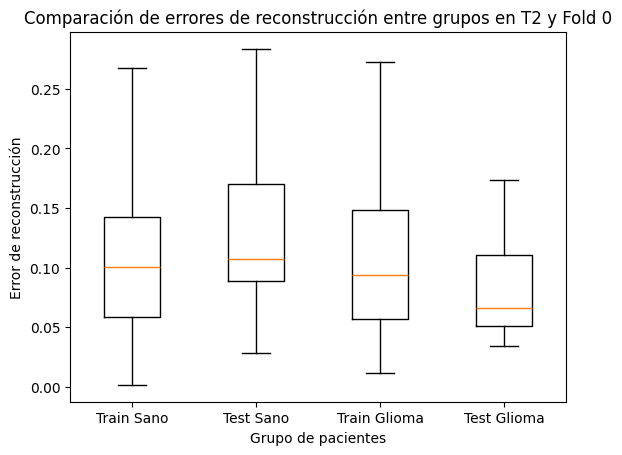

Media MSE train: 0.12977285904681607
Media MSE test: 0.12112211436033249
Media MSE train glioma: 0.12660798096587345
Media MSE test glioma: 0.19734440704009362


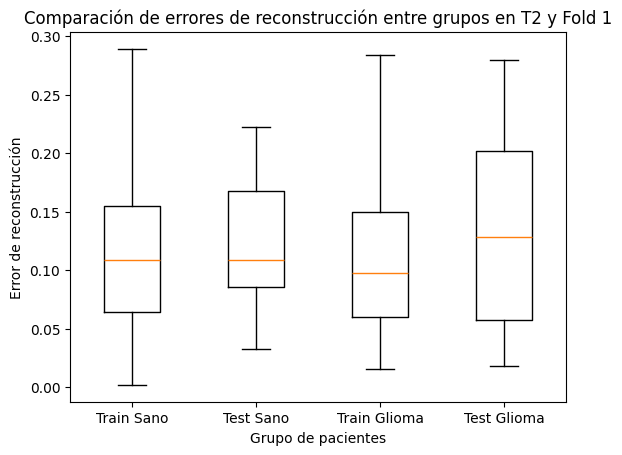

Media MSE train: 0.1618293586349034
Media MSE test: 0.22859715088270605
Media MSE train glioma: 0.18204966158520022
Media MSE test glioma: 0.13444890898580736


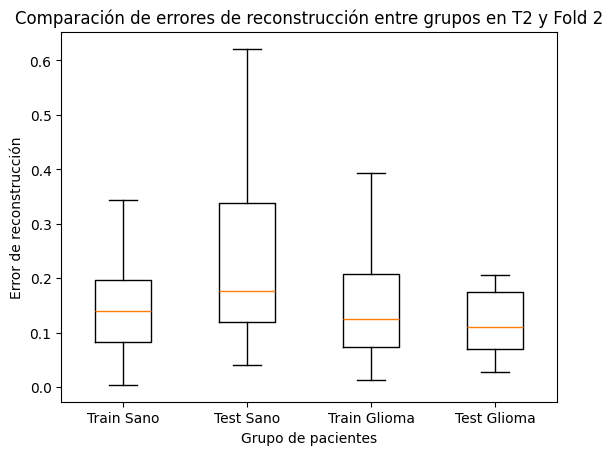

Media MSE train: 0.12109282033339115
Media MSE test: 0.1212262863991782
Media MSE train glioma: 0.12258188366232549
Media MSE test glioma: 0.1610004429060679


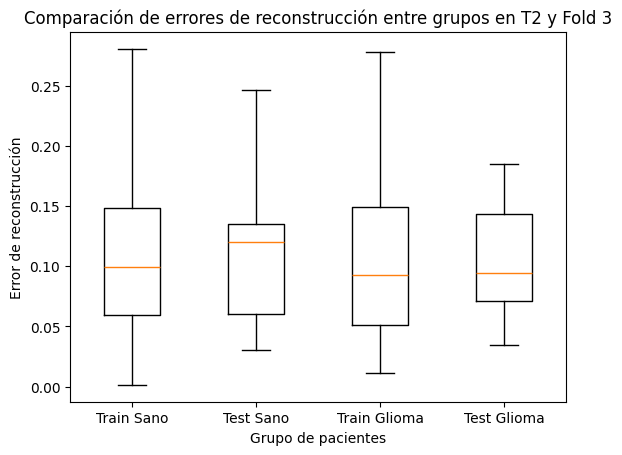

Media MSE train: 0.12321837416518372
Media MSE test: 0.13513444364070892
Media MSE train glioma: 0.13026071382107354
Media MSE test glioma: 0.12316705100238323


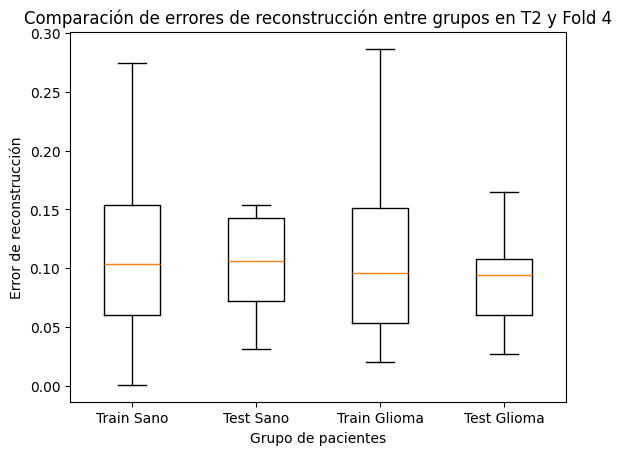

Media MSE train: 0.14519118041088203
Media MSE test: 0.1057299379259348
Media MSE train glioma: 0.15139264122684712
Media MSE test glioma: 0.11527130322960707


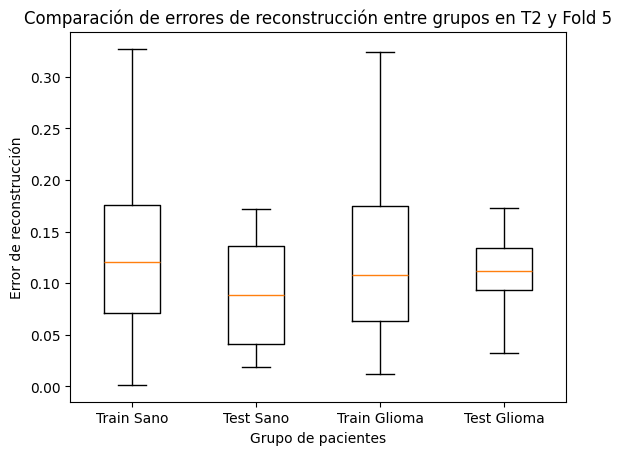

Media MSE train: 0.12249563013374297
Media MSE test: 0.10325292845567068
Media MSE train glioma: 0.12767926236505017
Media MSE test glioma: 0.1082042629042497


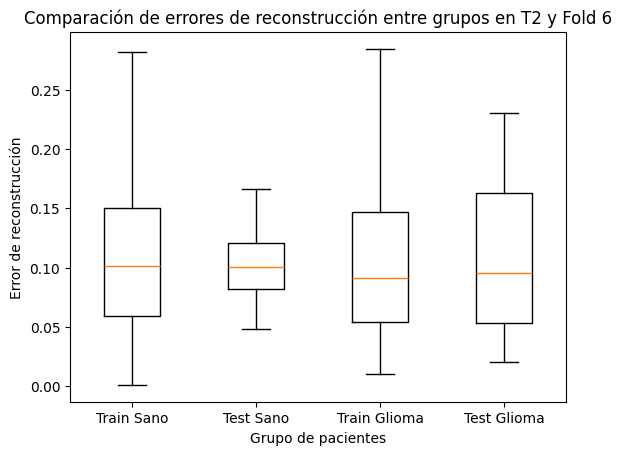

Media MSE train: 0.14369036222426154
Media MSE test: 0.13780561105037728
Media MSE train glioma: 0.13918743608128123
Media MSE test glioma: 0.24782702842584023


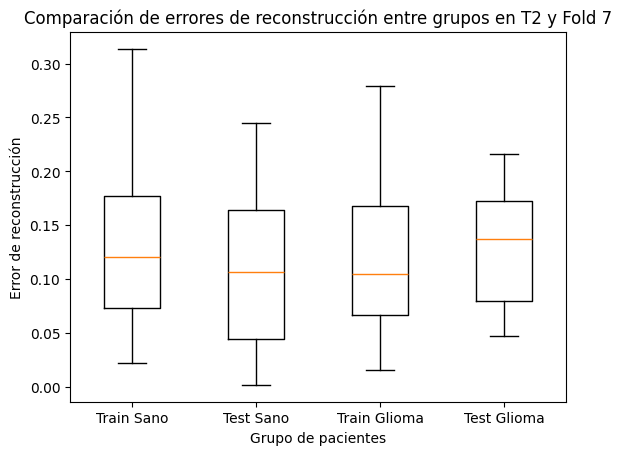

Media MSE train: 0.1150734926768237
Media MSE test: 0.1392420733968417
Media MSE train glioma: 0.1265435055320879
Media MSE test glioma: 0.08732290437015203


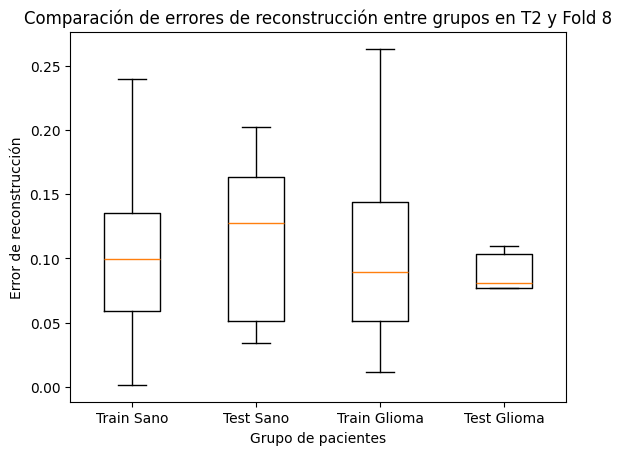

Media MSE train: 0.12641819511923819
Media MSE test: 0.09156479313969612
Media MSE train glioma: 0.12916685859946644
Media MSE test glioma: 0.10115520434024242


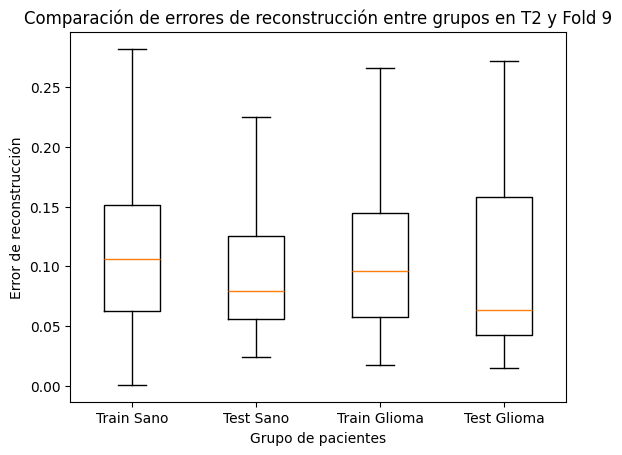

Media MSE train: 0.032606225802886246
Media MSE test: 0.028090997133404016
Media MSE train glioma: 0.1161419446727941
Media MSE test glioma: 0.13959369684259096


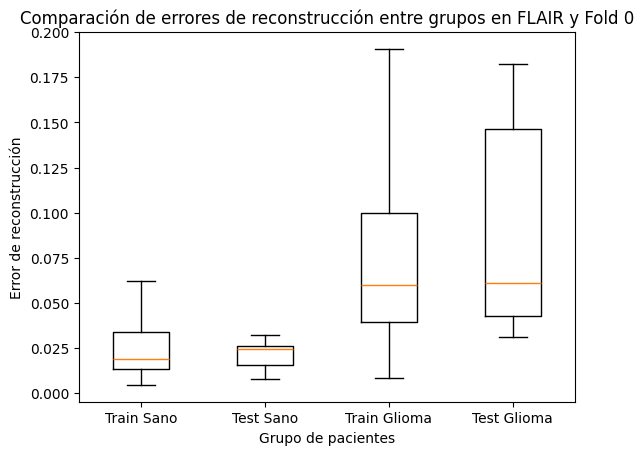

Media MSE train: 0.057727714791437804
Media MSE test: 0.03091509982614833
Media MSE train glioma: 0.17787230461395867
Media MSE test glioma: 0.22788166720420122


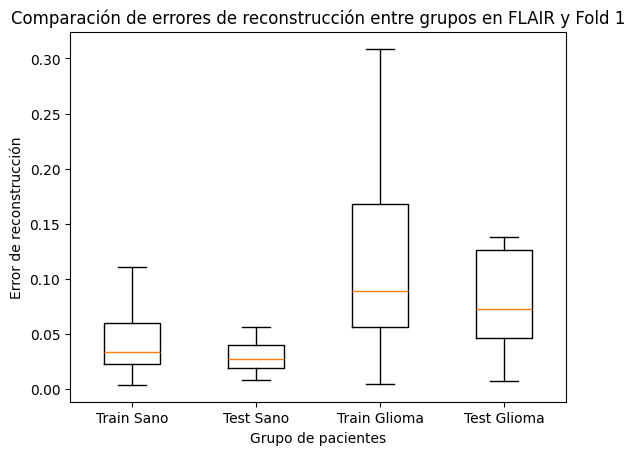

Media MSE train: 0.023761729716139587
Media MSE test: 0.03747840239392484
Media MSE train glioma: 0.09285293936392101
Media MSE test glioma: 0.07977097441575356


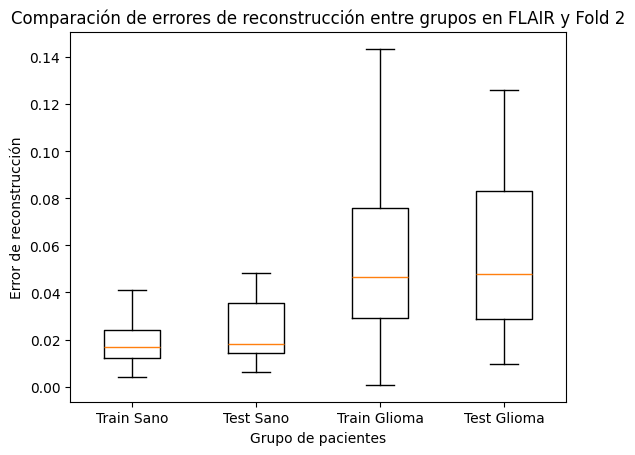

Media MSE train: 0.0372377450761645
Media MSE test: 0.03678983882726992
Media MSE train glioma: 0.11424346372675825
Media MSE test glioma: 0.2027574721723795


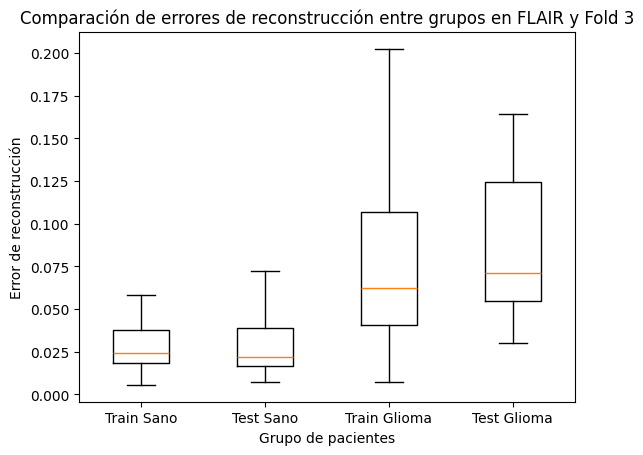

Media MSE train: 0.024262034979246155
Media MSE test: 0.025892466976074502
Media MSE train glioma: 0.0839364516299482
Media MSE test glioma: 0.0611591600297418


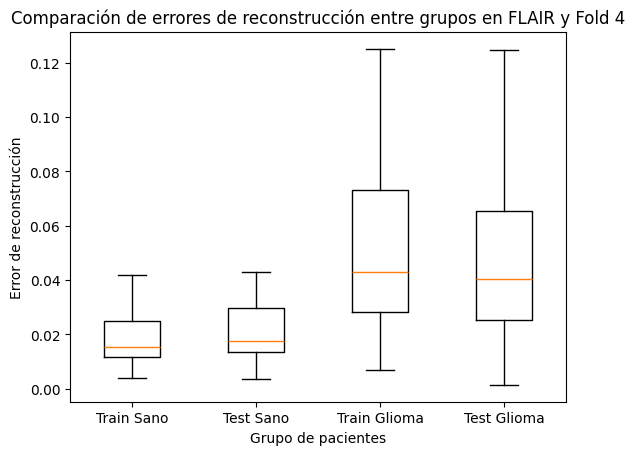

Media MSE train: 0.034488764519148785
Media MSE test: 0.01892694237176329
Media MSE train glioma: 0.12896533605209956
Media MSE test glioma: 0.057700790997062414


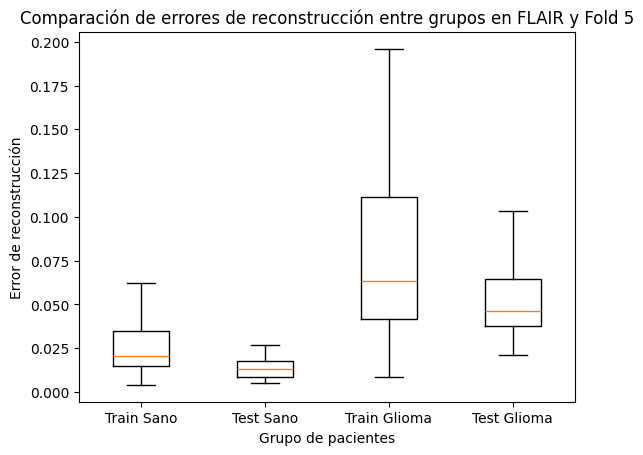

Media MSE train: 0.02917393406764982
Media MSE test: 0.022607663355302066
Media MSE train glioma: 0.09586408373892424
Media MSE test glioma: 0.056202897402857034


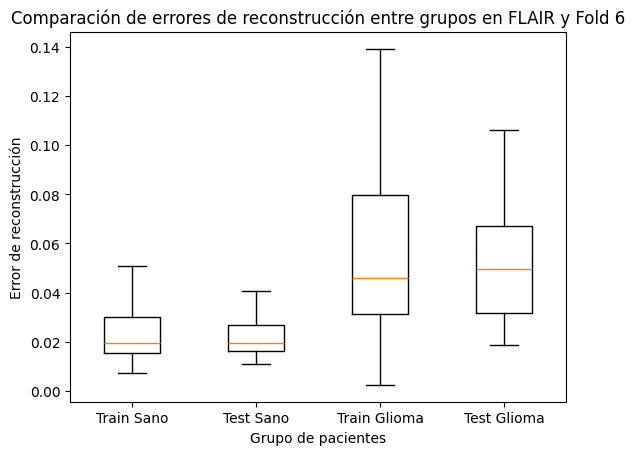

Media MSE train: 0.07221537739718081
Media MSE test: 0.11779215140268207
Media MSE train glioma: 0.24283542995905782
Media MSE test glioma: 0.412260876968503


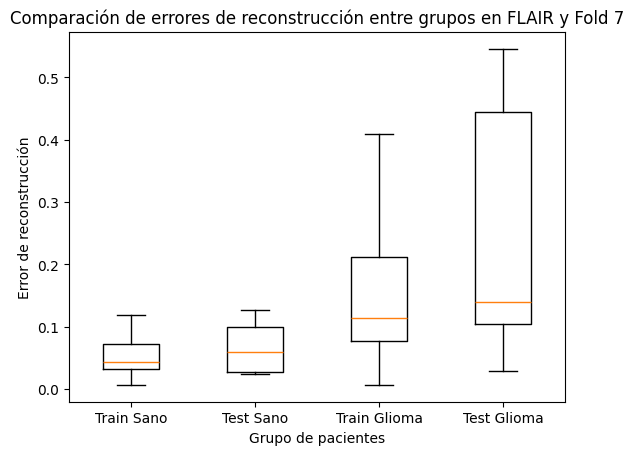

Media MSE train: 0.0379168191276541
Media MSE test: 0.04658094554906711
Media MSE train glioma: 0.14097814371545367
Media MSE test glioma: 0.09306353822882686


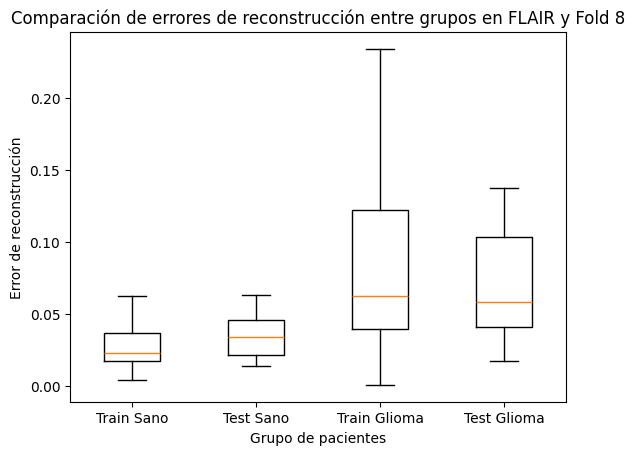

Media MSE train: 0.024713334819377476
Media MSE test: 0.024092718376778066
Media MSE train glioma: 0.08295935816287364
Media MSE test glioma: 0.0667875986546278


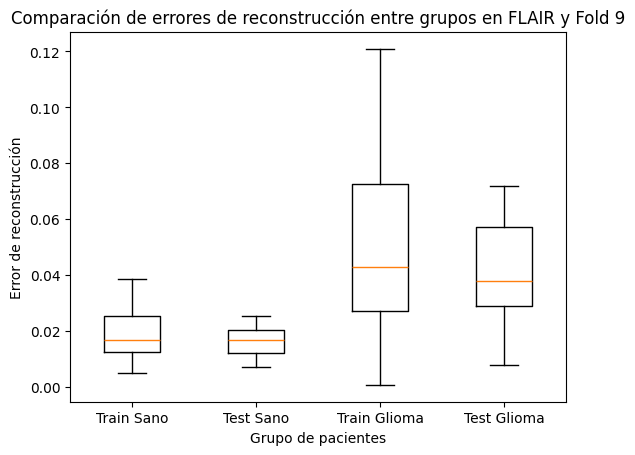

In [42]:
num_folds = 10

for i, v_type in enumerate(["T1", "T2", "FLAIR"]):
    for j in range(num_folds):
        plt.boxplot([mse_train[i][j], mse_test[i][j], mse_glioma_train[i][j], mse_glioma_test[i][j]],
                    labels=['Train Sano', 'Test Sano', 'Train Glioma', 'Test Glioma'], showfliers=False)
        
        print("Media MSE train:", np.mean(np.array(mse_train[i][j])))
        print("Media MSE test:", np.mean(np.array(mse_test[i][j])))
        print("Media MSE train glioma:", np.mean(np.array(mse_glioma_train[i][j])))
        print("Media MSE test glioma:", np.mean(np.array(mse_glioma_test[i][j])))
        
        plt.xlabel('Grupo de pacientes')
        plt.ylabel('Error de reconstrucción')
        plt.title('Comparación de errores de reconstrucción entre grupos en '+v_type+' y Fold '+str(j))
        plt.show()

Media LOG-LIKELIHOOD train: -37028.51747229038
Media LOG-LIKELIHOOD test: -206548.8232339893
Media LOG-LIKELIHOOD train glioma: -837676.593960261
Media LOG-LIKELIHOOD test glioma: -534909.3033192492


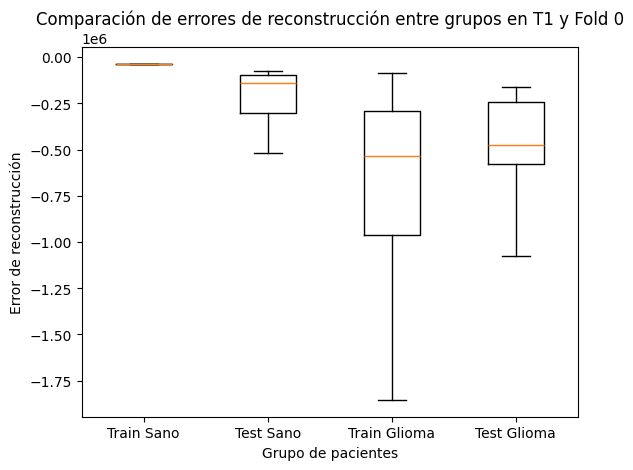

Media LOG-LIKELIHOOD train: -164104.06833920217
Media LOG-LIKELIHOOD test: -508725.9313168993
Media LOG-LIKELIHOOD train glioma: -1039083.1183355845
Media LOG-LIKELIHOOD test glioma: -1136491.6377348087


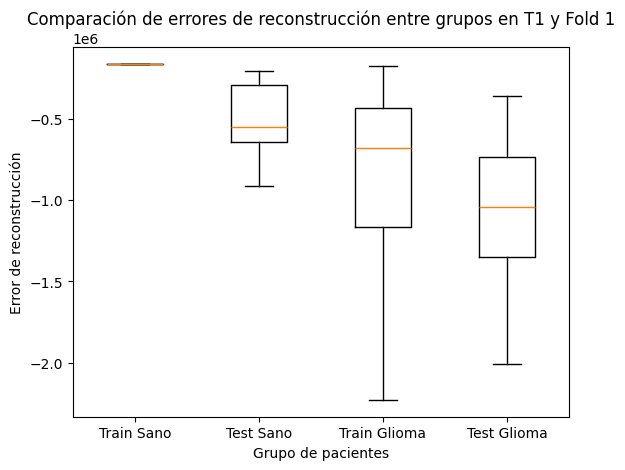

Media LOG-LIKELIHOOD train: -164104.06833920217
Media LOG-LIKELIHOOD test: -356041.15826208814
Media LOG-LIKELIHOOD train glioma: -864687.4105061461
Media LOG-LIKELIHOOD test glioma: -1264846.208168072


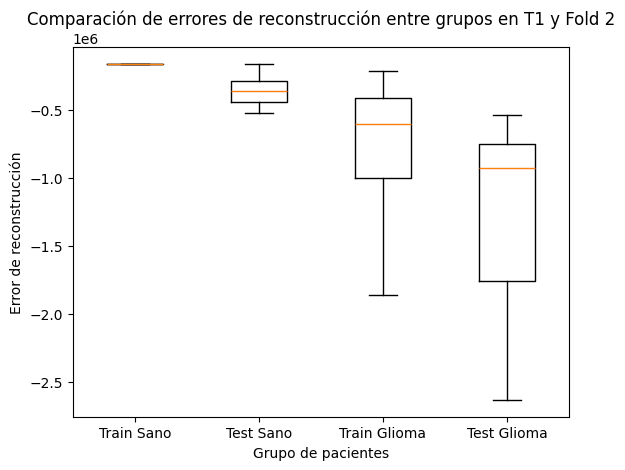

Media LOG-LIKELIHOOD train: -37028.51747229038
Media LOG-LIKELIHOOD test: -633402.2826681591
Media LOG-LIKELIHOOD train glioma: -1145892.4912385656
Media LOG-LIKELIHOOD test glioma: -1029651.0754144493


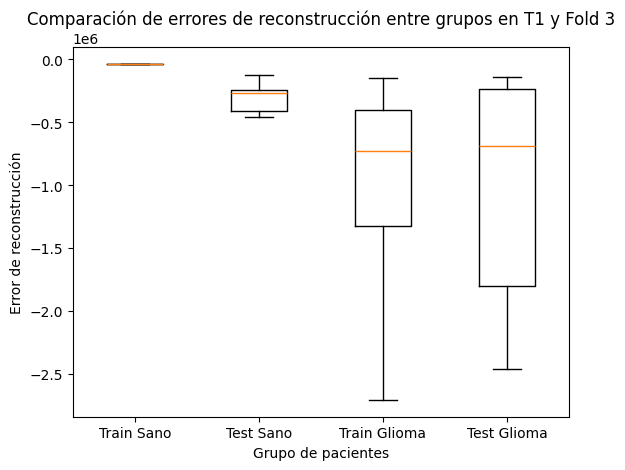

Media LOG-LIKELIHOOD train: -164104.06833920217
Media LOG-LIKELIHOOD test: -388670.5936227879
Media LOG-LIKELIHOOD train glioma: -922471.892162821
Media LOG-LIKELIHOOD test glioma: -932063.968161175


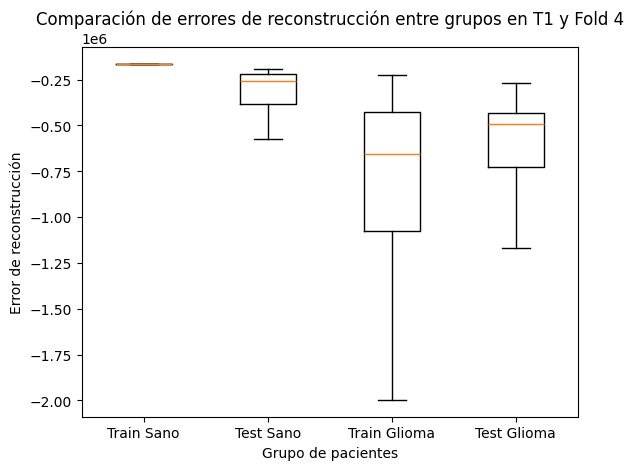

Media LOG-LIKELIHOOD train: -37028.51747229038
Media LOG-LIKELIHOOD test: -395558.0572430496
Media LOG-LIKELIHOOD train glioma: -1041361.6205977041
Media LOG-LIKELIHOOD test glioma: -534721.7895748658


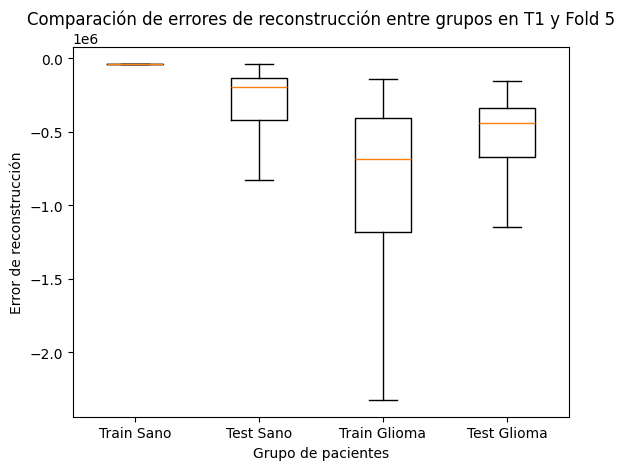

Media LOG-LIKELIHOOD train: -37028.51747229038
Media LOG-LIKELIHOOD test: -210034.12674708077
Media LOG-LIKELIHOOD train glioma: -932633.8736489204
Media LOG-LIKELIHOOD test glioma: -1186701.6806618203


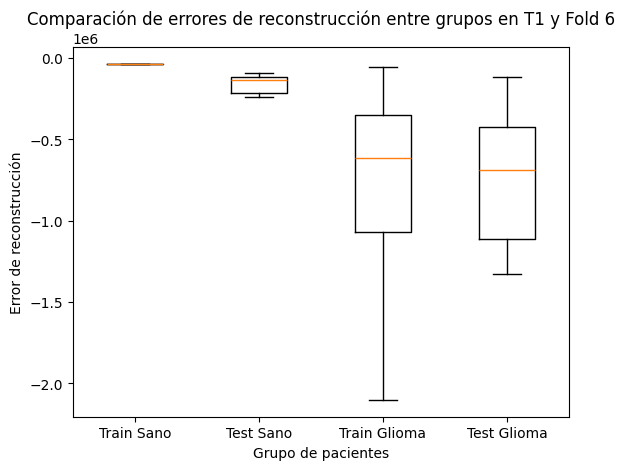

Media LOG-LIKELIHOOD train: -164104.06833920217
Media LOG-LIKELIHOOD test: -376122.80046958645
Media LOG-LIKELIHOOD train glioma: -925508.5462463849
Media LOG-LIKELIHOOD test glioma: -1123843.5760432896


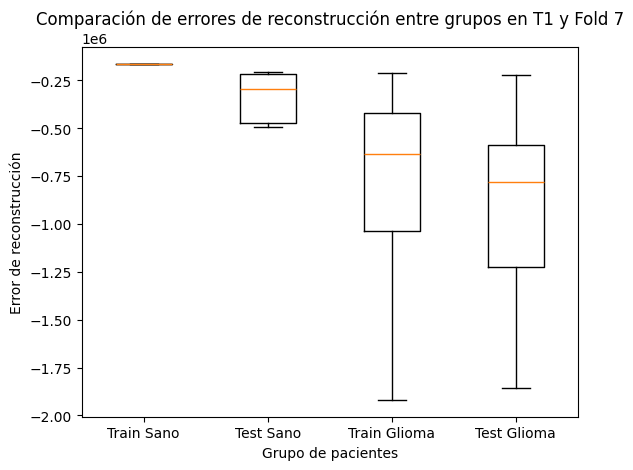

Media LOG-LIKELIHOOD train: -37028.51747229038
Media LOG-LIKELIHOOD test: -330817.30049364606
Media LOG-LIKELIHOOD train glioma: -928410.0717341759
Media LOG-LIKELIHOOD test glioma: -941781.2748959964


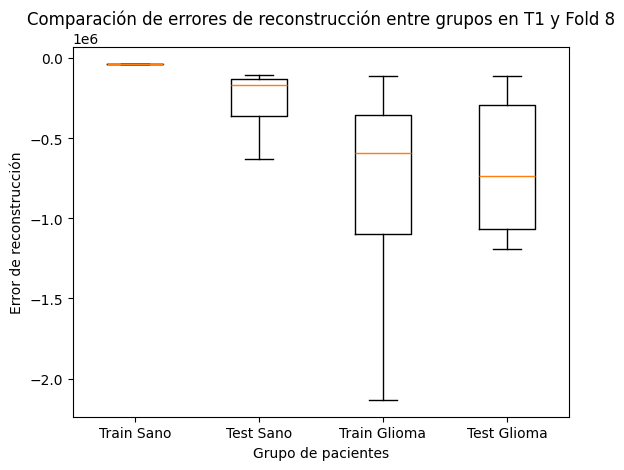

Media LOG-LIKELIHOOD train: -37028.51747229038
Media LOG-LIKELIHOOD test: -410056.2607064208
Media LOG-LIKELIHOOD train glioma: -1104991.7805296893
Media LOG-LIKELIHOOD test glioma: -783733.0140395008


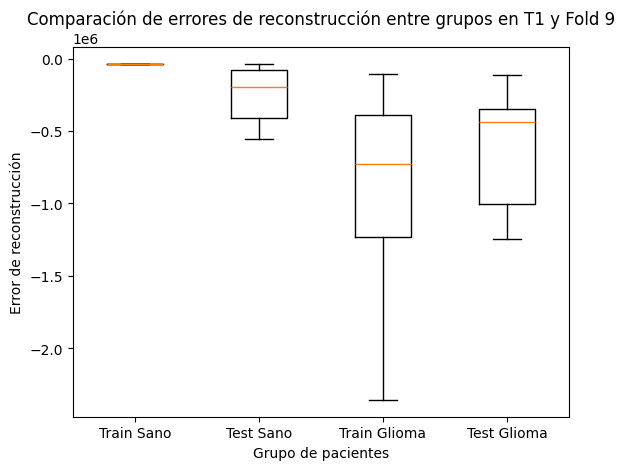

Media LOG-LIKELIHOOD train: -418255.5975170406
Media LOG-LIKELIHOOD test: -700338.0105543137
Media LOG-LIKELIHOOD train glioma: -716473.163164591
Media LOG-LIKELIHOOD test glioma: -649189.1931963761


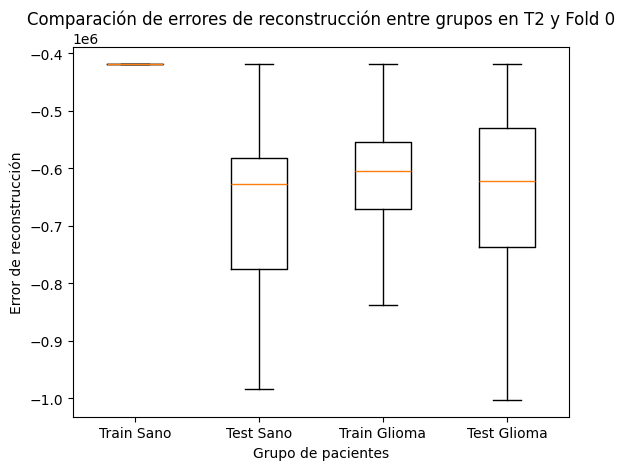

Media LOG-LIKELIHOOD train: -545331.1483839526
Media LOG-LIKELIHOOD test: -694179.5798150278
Media LOG-LIKELIHOOD train glioma: -778721.1770024588
Media LOG-LIKELIHOOD test glioma: -956578.6365045861


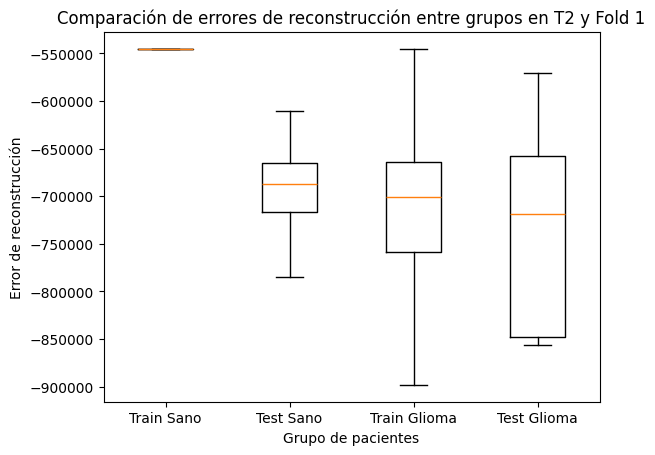

Media LOG-LIKELIHOOD train: -418255.5975170406
Media LOG-LIKELIHOOD test: -819171.7280516346
Media LOG-LIKELIHOOD train glioma: -793633.6869022399
Media LOG-LIKELIHOOD test glioma: -689643.8930045206


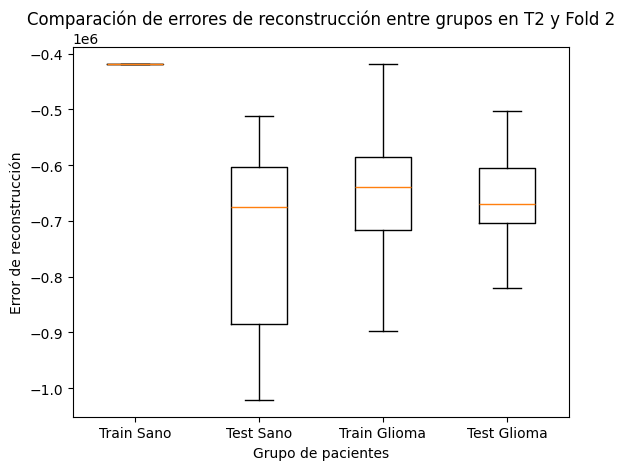

Media LOG-LIKELIHOOD train: -672406.6992508643
Media LOG-LIKELIHOOD test: -845410.7233055141
Media LOG-LIKELIHOOD train glioma: -908214.528002789
Media LOG-LIKELIHOOD test glioma: -986635.342288606


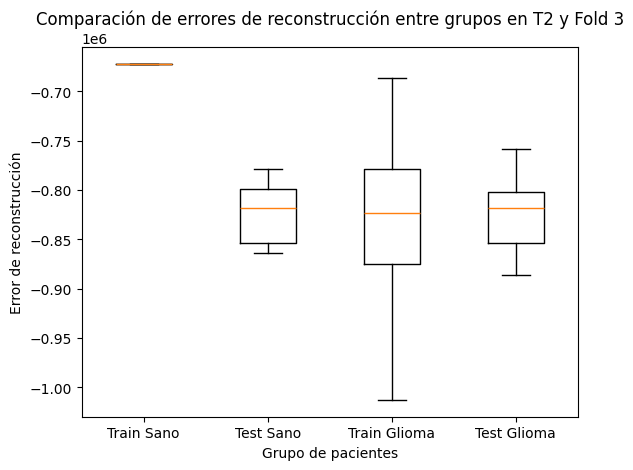

Media LOG-LIKELIHOOD train: -545331.1556042004
Media LOG-LIKELIHOOD test: -746922.1577114626
Media LOG-LIKELIHOOD train glioma: -784686.927092969
Media LOG-LIKELIHOOD test glioma: -764015.5095762236


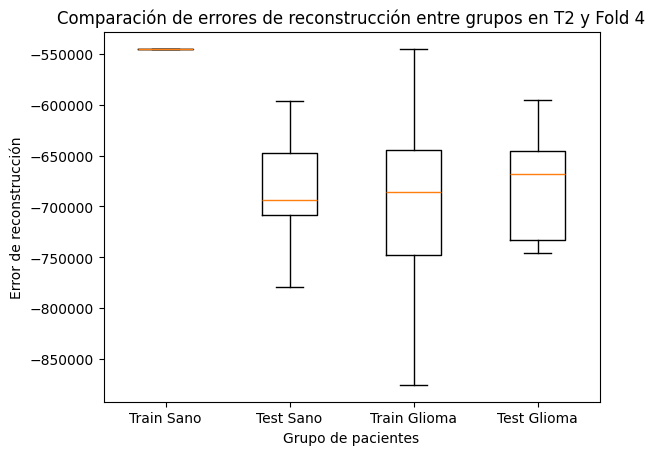

Media LOG-LIKELIHOOD train: -291180.0538703767
Media LOG-LIKELIHOOD test: -590460.451994493
Media LOG-LIKELIHOOD train glioma: -690469.3617395494
Media LOG-LIKELIHOOD test glioma: -528255.5682248924


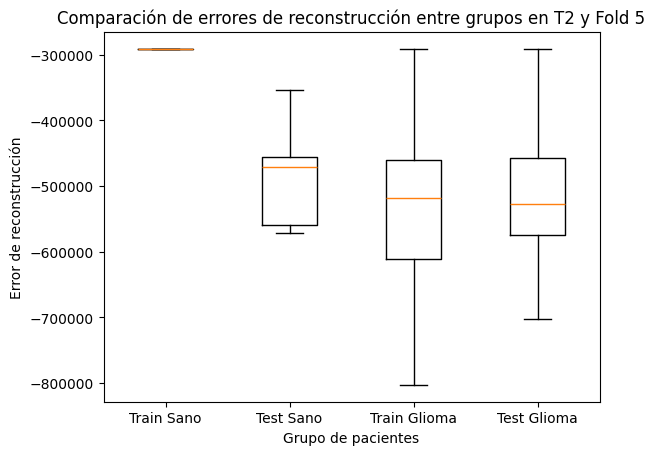

Media LOG-LIKELIHOOD train: -545331.1556042004
Media LOG-LIKELIHOOD test: -701861.3375912786
Media LOG-LIKELIHOOD train glioma: -800856.690988046
Media LOG-LIKELIHOOD test glioma: -712786.8564874186


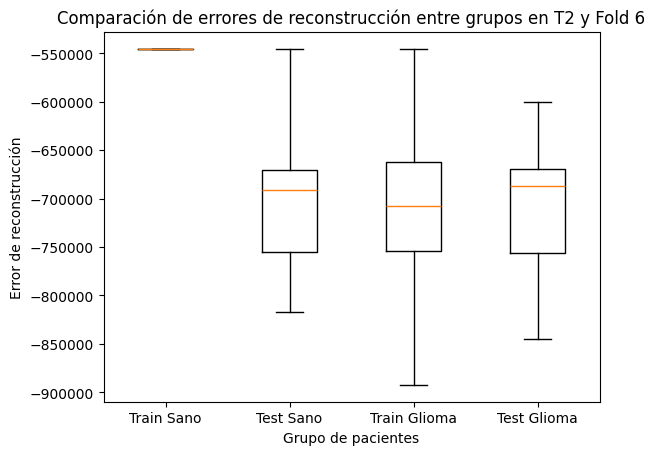

Media LOG-LIKELIHOOD train: -418255.60473728867
Media LOG-LIKELIHOOD test: -653607.8656445898
Media LOG-LIKELIHOOD train glioma: -700301.0639071086
Media LOG-LIKELIHOOD test glioma: -1073616.087118955


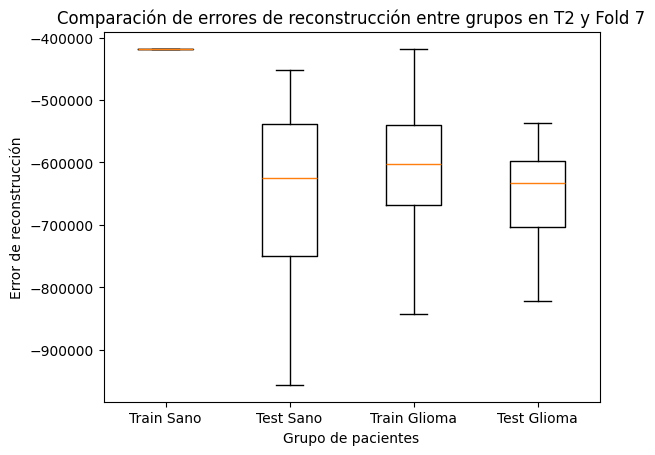

Media LOG-LIKELIHOOD train: -418255.60473728867
Media LOG-LIKELIHOOD test: -883660.5327445505
Media LOG-LIKELIHOOD train glioma: -832831.077777792
Media LOG-LIKELIHOOD test glioma: -634958.9736883395


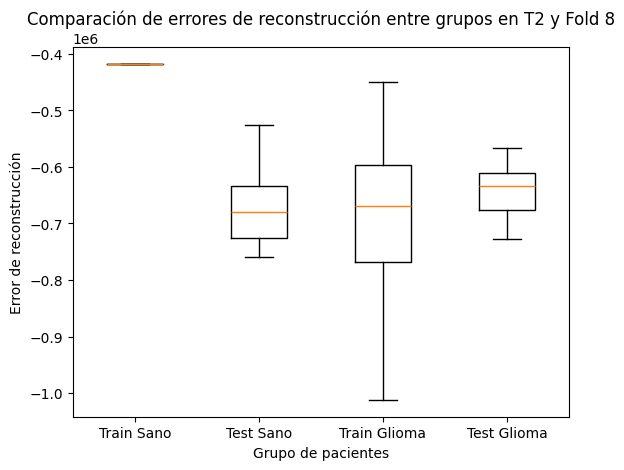

Media LOG-LIKELIHOOD train: -418255.60473728867
Media LOG-LIKELIHOOD test: -566107.3498117283
Media LOG-LIKELIHOOD train glioma: -689686.5517140026
Media LOG-LIKELIHOOD test glioma: -623171.3350328618


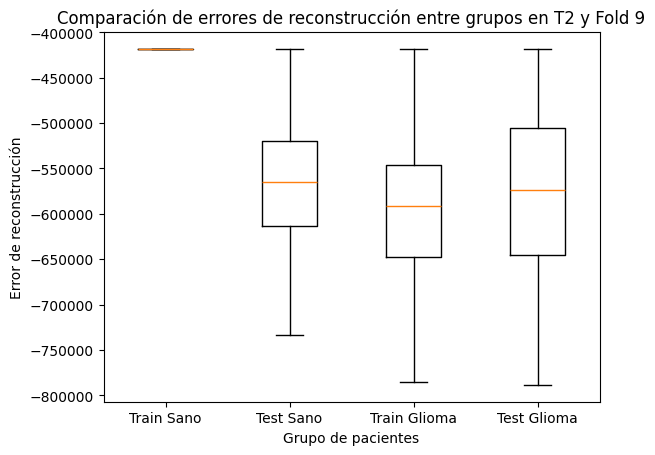

Media LOG-LIKELIHOOD train: -291180.1098290304
Media LOG-LIKELIHOOD test: -529732.1939819278
Media LOG-LIKELIHOOD train glioma: -1687376.294941605
Media LOG-LIKELIHOOD test glioma: -1699688.3887027411


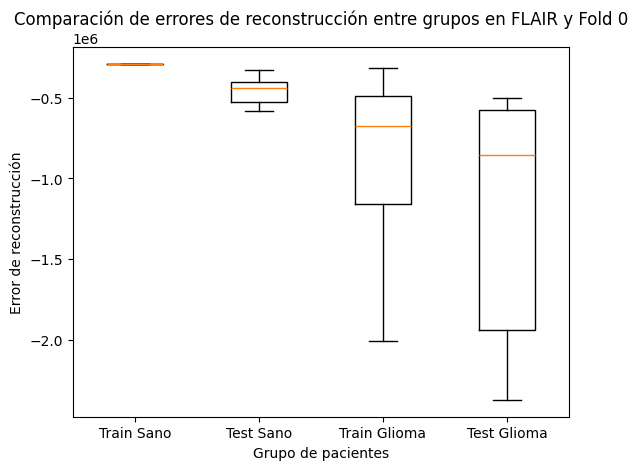

Media LOG-LIKELIHOOD train: -164104.55896211864
Media LOG-LIKELIHOOD test: -298183.3175312837
Media LOG-LIKELIHOOD train glioma: -1270285.6572495925
Media LOG-LIKELIHOOD test glioma: -1474543.2296298349


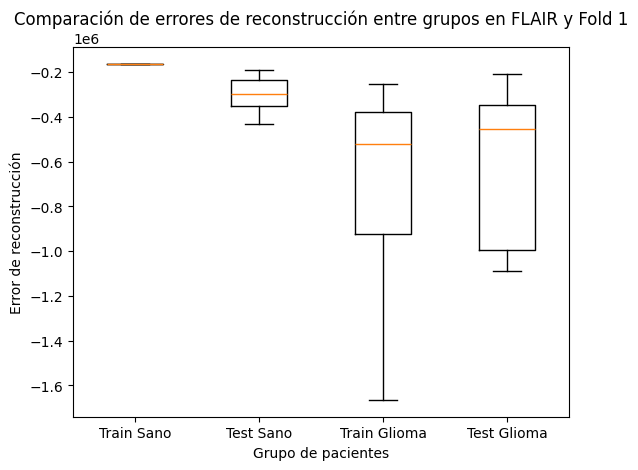

Media LOG-LIKELIHOOD train: -164104.55896211864
Media LOG-LIKELIHOOD test: -474935.61617089075
Media LOG-LIKELIHOOD train glioma: -1352737.2374910656
Media LOG-LIKELIHOOD test glioma: -1162858.9028947358


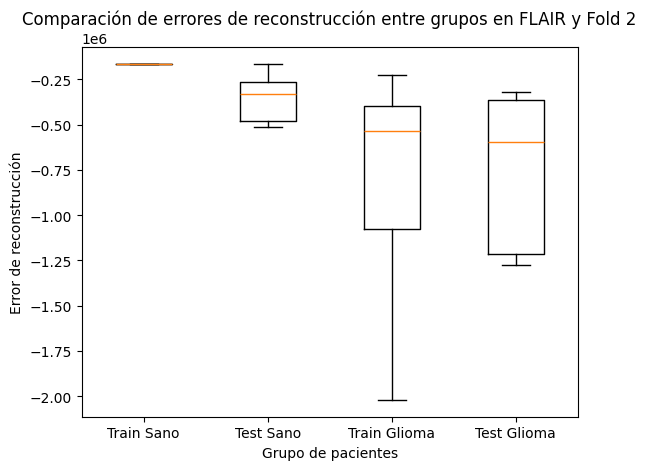

Media LOG-LIKELIHOOD train: -291180.1098290304
Media LOG-LIKELIHOOD test: -495852.84431405214
Media LOG-LIKELIHOOD train glioma: -1183986.1949666208
Media LOG-LIKELIHOOD test glioma: -2451640.917729127


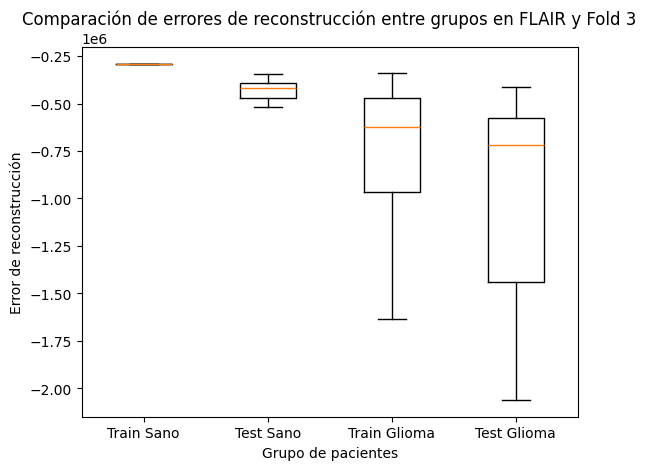

Media LOG-LIKELIHOOD train: -291180.1166087174
Media LOG-LIKELIHOOD test: -531641.1948950597
Media LOG-LIKELIHOOD train glioma: -1531742.012275679
Media LOG-LIKELIHOOD test glioma: -1100292.2084398395


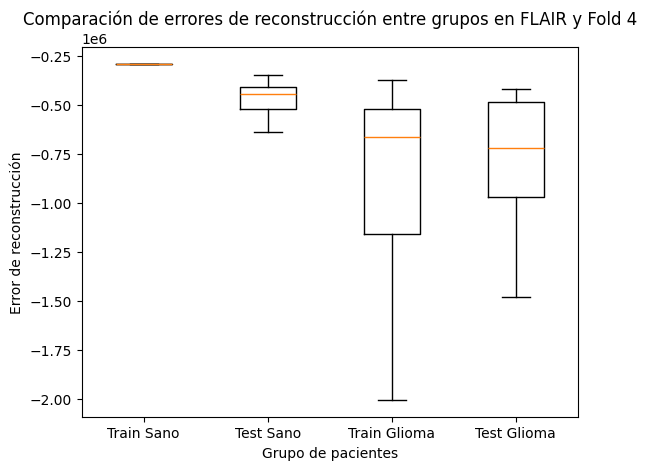

Media LOG-LIKELIHOOD train: -291180.1166087174
Media LOG-LIKELIHOOD test: -445310.9848421663
Media LOG-LIKELIHOOD train glioma: -1537058.2644474031
Media LOG-LIKELIHOOD test glioma: -640309.7110114362


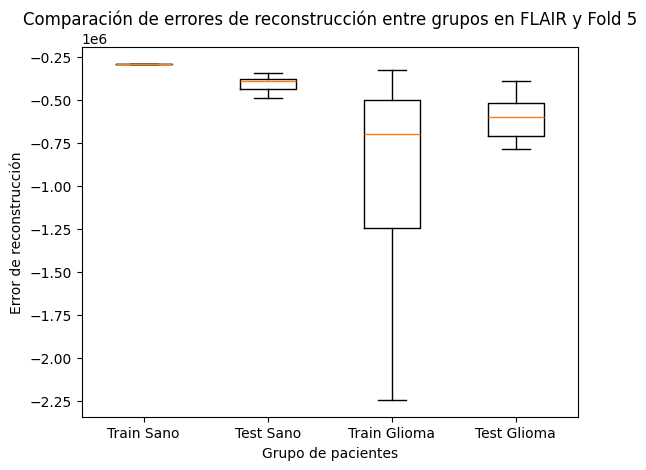

Media LOG-LIKELIHOOD train: -291180.1166087174
Media LOG-LIKELIHOOD test: -457034.7949713452
Media LOG-LIKELIHOOD train glioma: -1523014.4058433042
Media LOG-LIKELIHOOD test glioma: -958524.3616742055


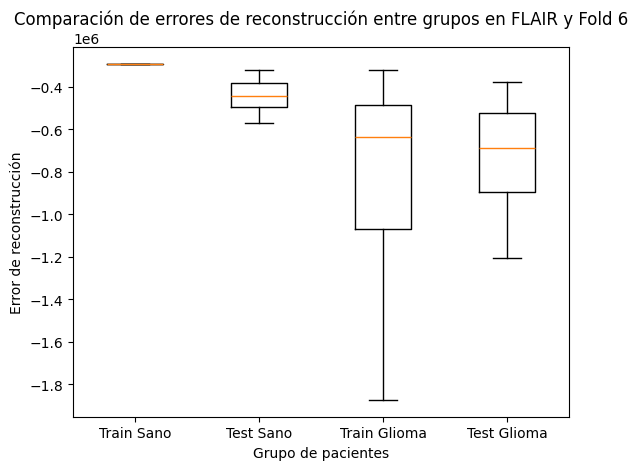

Media LOG-LIKELIHOOD train: -291180.1166087174
Media LOG-LIKELIHOOD test: -771003.8589704311
Media LOG-LIKELIHOOD train glioma: -1557409.682631793
Media LOG-LIKELIHOOD test glioma: -2610811.6827745633


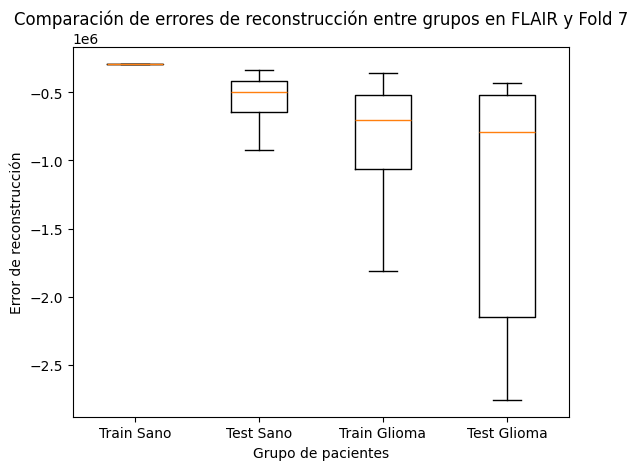

Media LOG-LIKELIHOOD train: -164104.56574180562
Media LOG-LIKELIHOOD test: -448202.22950725525
Media LOG-LIKELIHOOD train glioma: -1368399.4805656257
Media LOG-LIKELIHOOD test glioma: -874368.0975505734


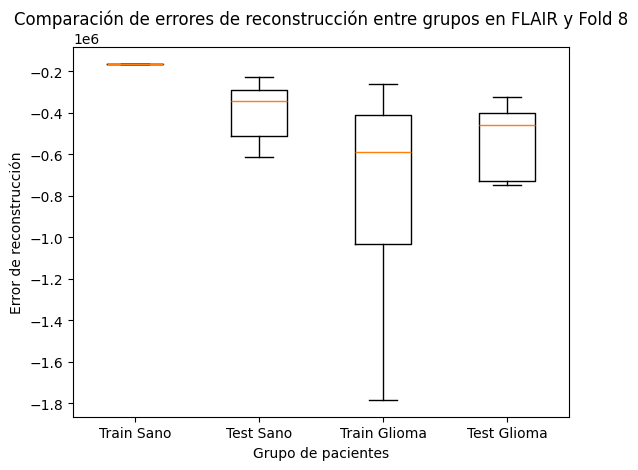

Media LOG-LIKELIHOOD train: -291180.1166087174
Media LOG-LIKELIHOOD test: -500709.6616143171
Media LOG-LIKELIHOOD train glioma: -1315892.1021225748
Media LOG-LIKELIHOOD test glioma: -1263852.5857256248


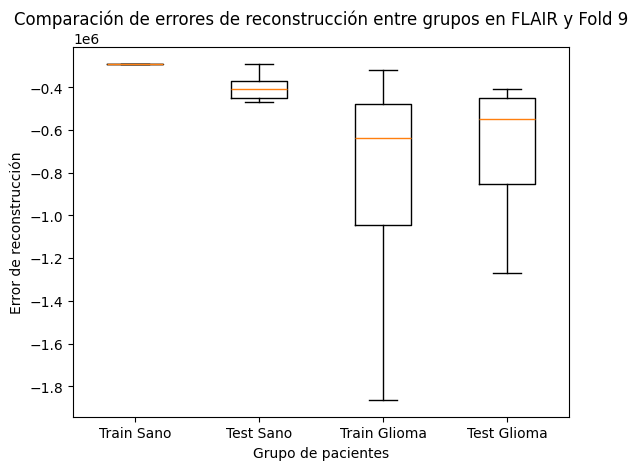

In [43]:
num_folds = 10

for i, v_type in enumerate(["T1", "T2", "FLAIR"]):
    for j in range(num_folds):
        plt.boxplot([loglikelihoods_train[i][j], loglikelihoods_test[i][j], loglikelihoods_glioma_train[i][j],
                     loglikelihoods_glioma_test[i][j]],
                    labels=['Train Sano', 'Test Sano', 'Train Glioma', 'Test Glioma'], showfliers=False)
        
        print("Media LOG-LIKELIHOOD train:", np.mean(np.array(loglikelihoods_train[i][j])))
        print("Media LOG-LIKELIHOOD test:", np.mean(np.array(loglikelihoods_test[i][j])))
        print("Media LOG-LIKELIHOOD train glioma:", np.mean(np.array(loglikelihoods_glioma_train[i][j])))
        print("Media LOG-LIKELIHOOD test glioma:", np.mean(np.array(loglikelihoods_glioma_test[i][j])))

        plt.xlabel('Grupo de pacientes')
        plt.ylabel('Error de reconstrucción')
        plt.title('Comparación de errores de reconstrucción entre grupos en '+v_type+' y Fold '+str(j))
        plt.show()

#### SCATTERPLOT DE MSE - LOGLIKELIHOOD POR CADA TIPO DE MRI

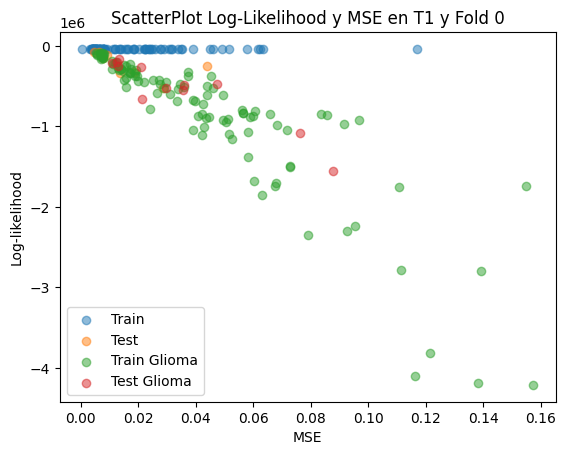

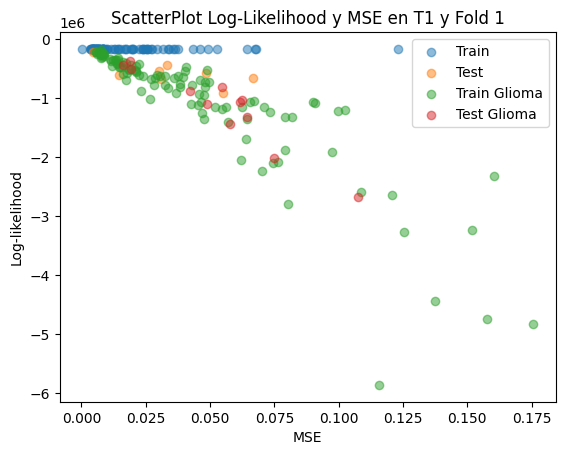

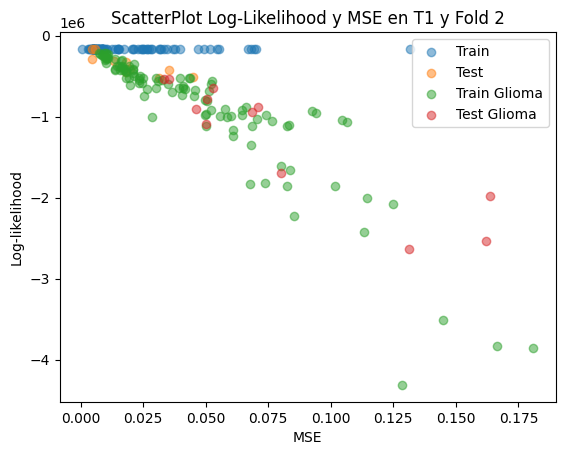

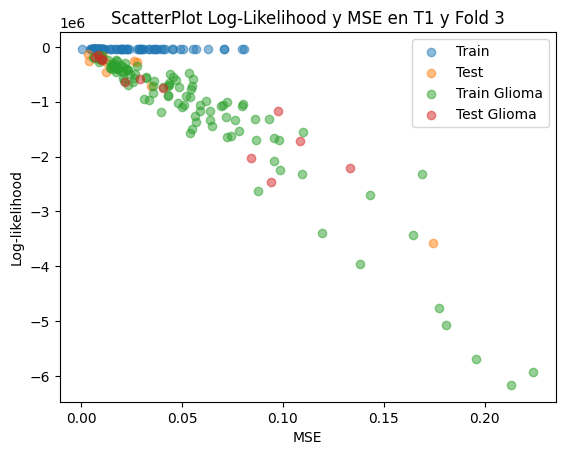

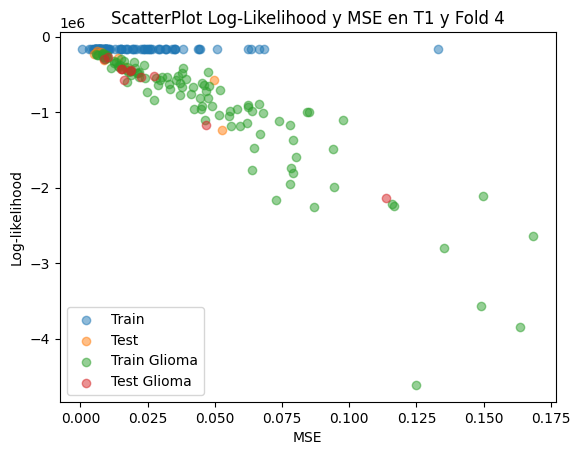

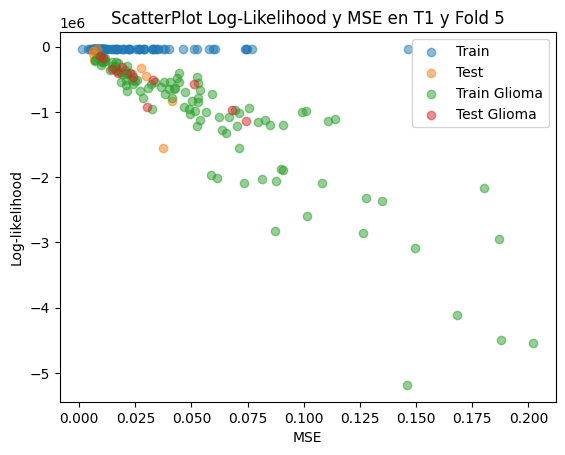

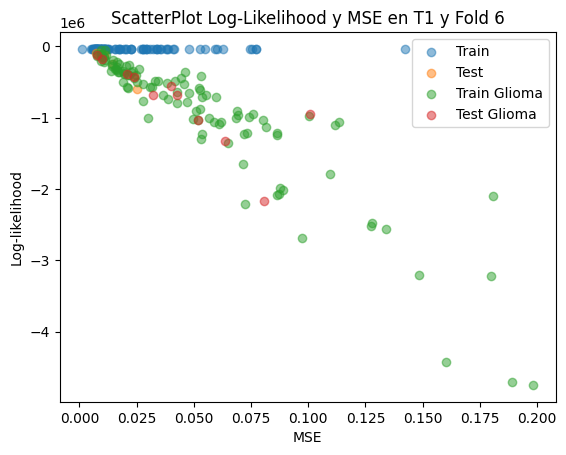

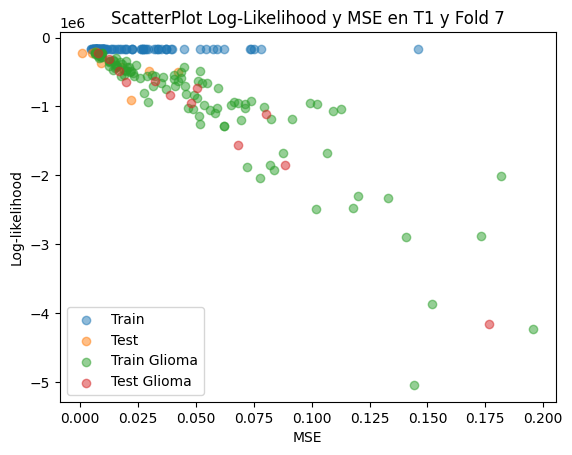

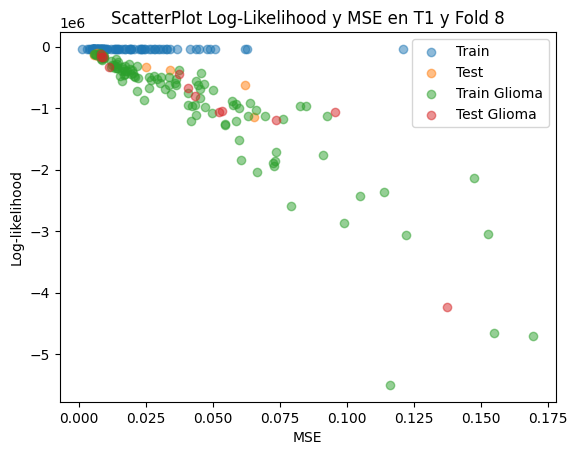

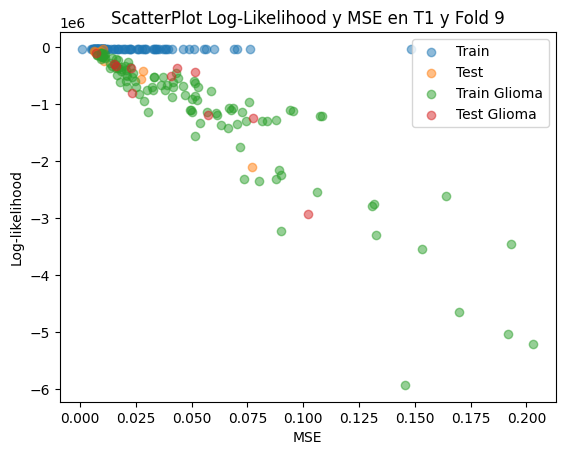

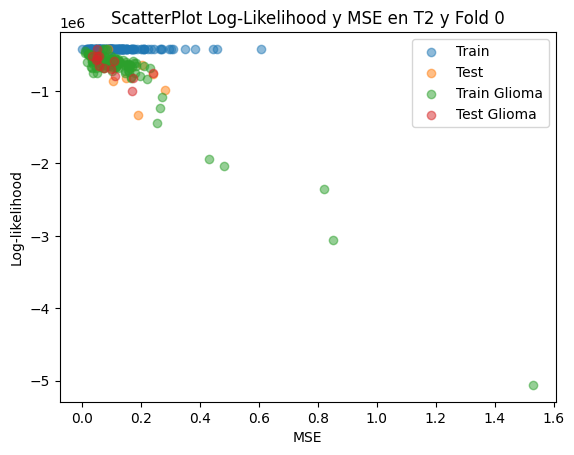

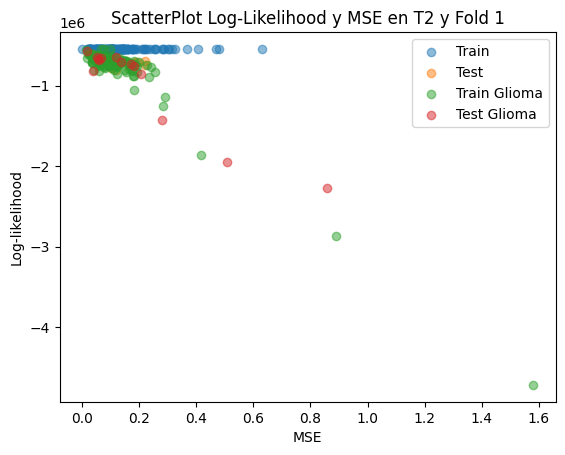

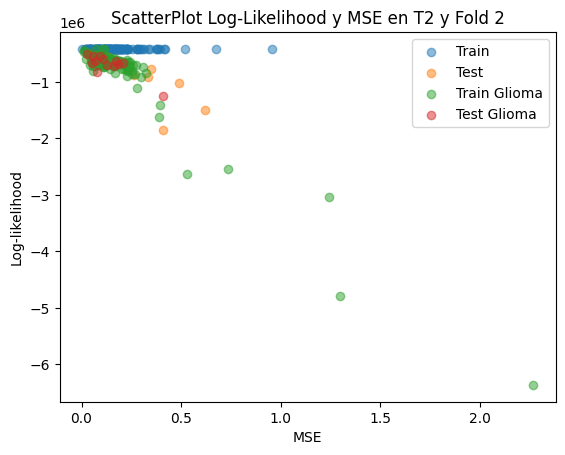

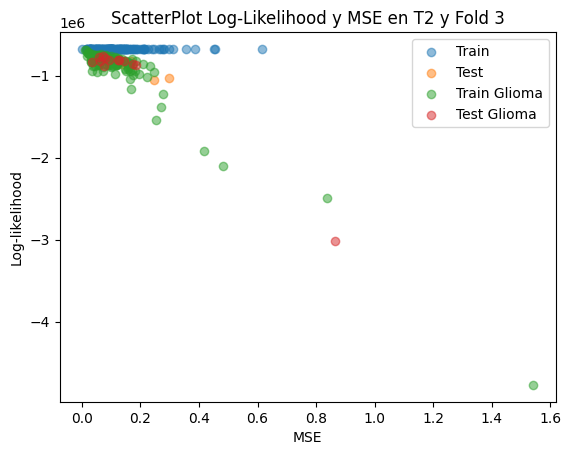

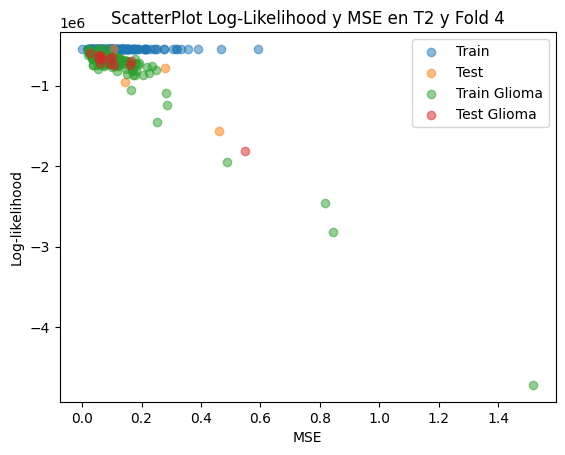

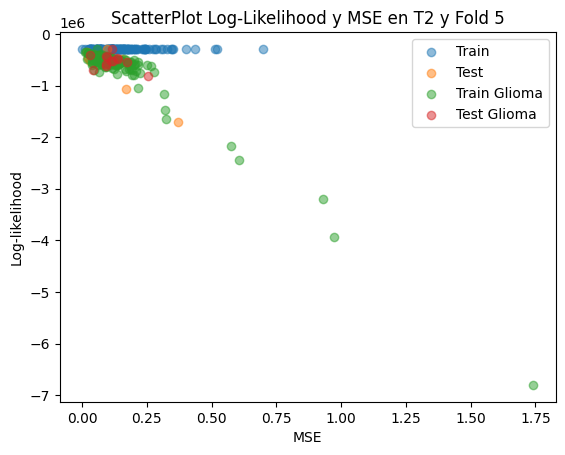

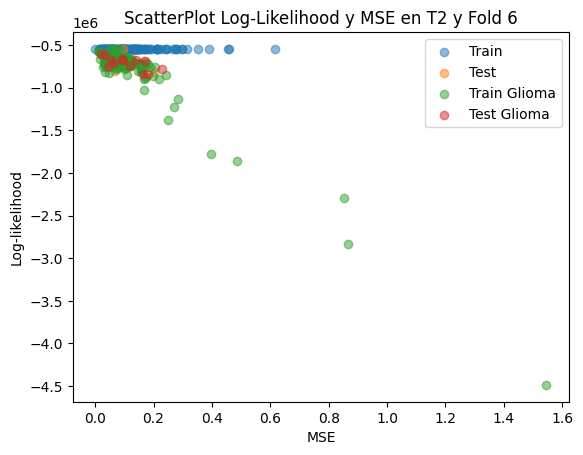

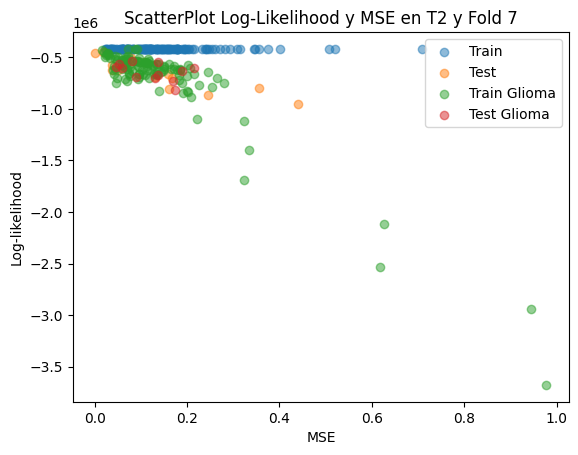

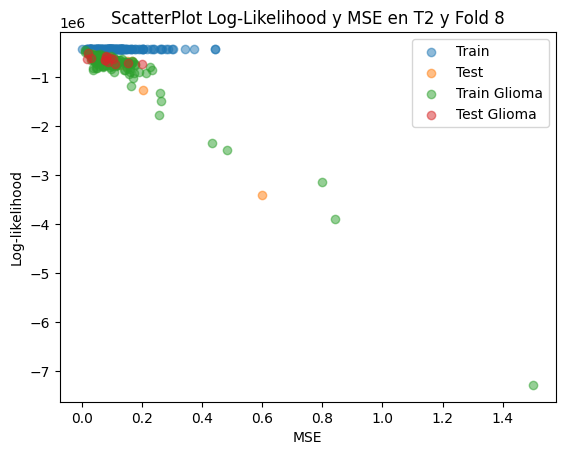

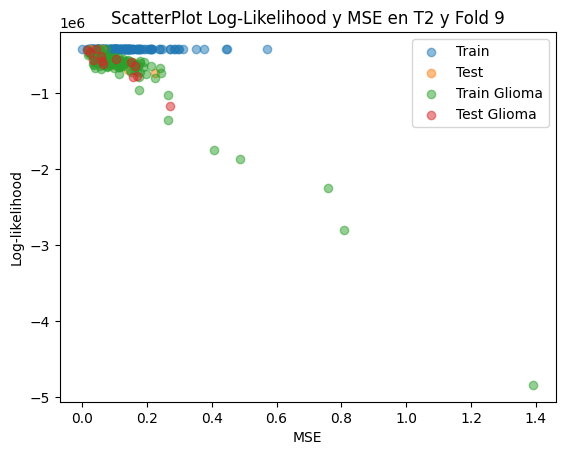

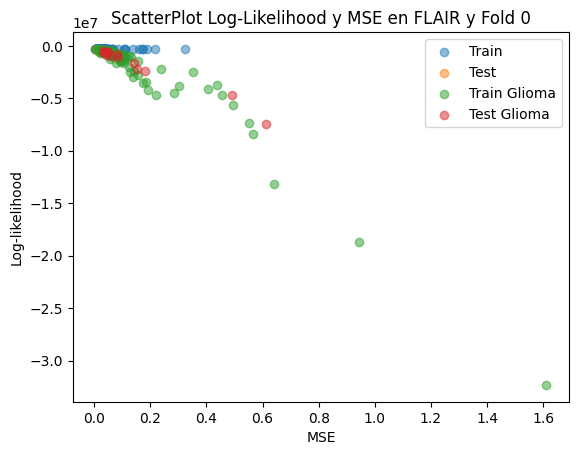

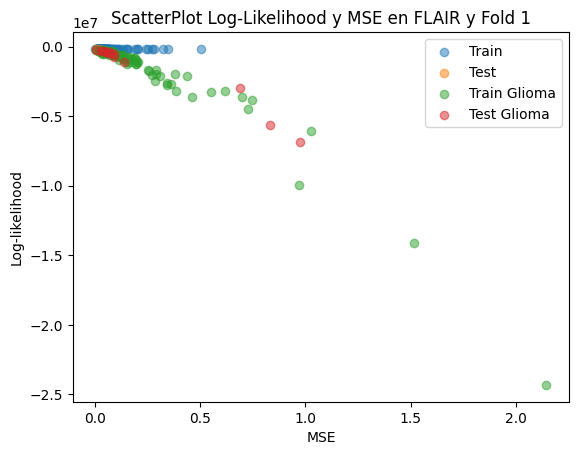

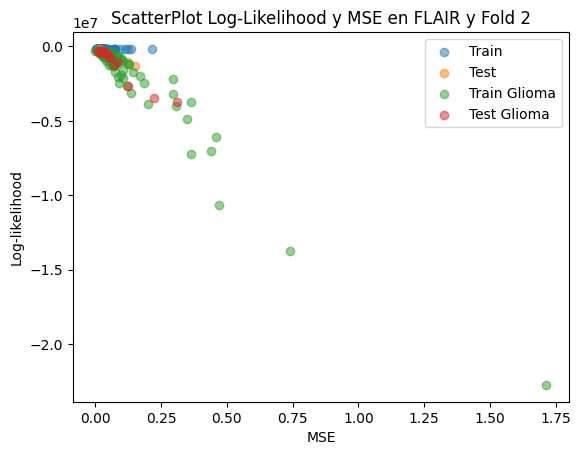

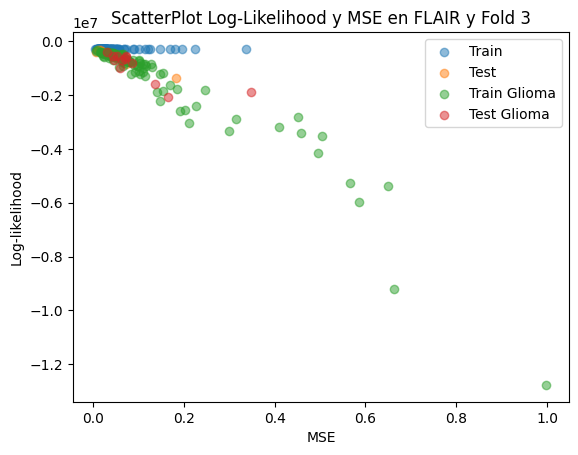

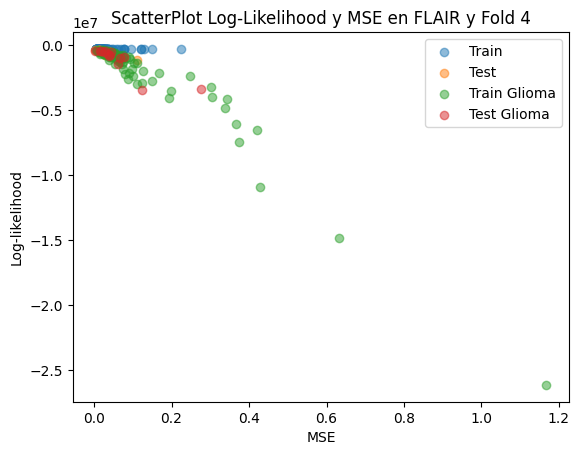

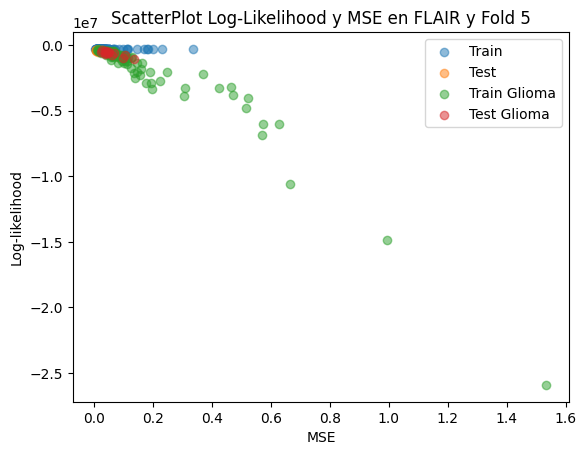

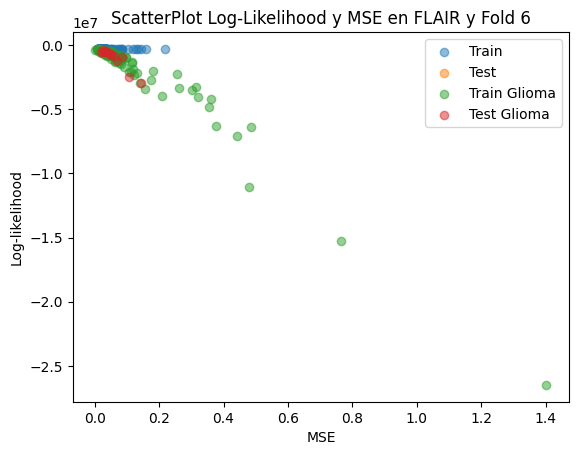

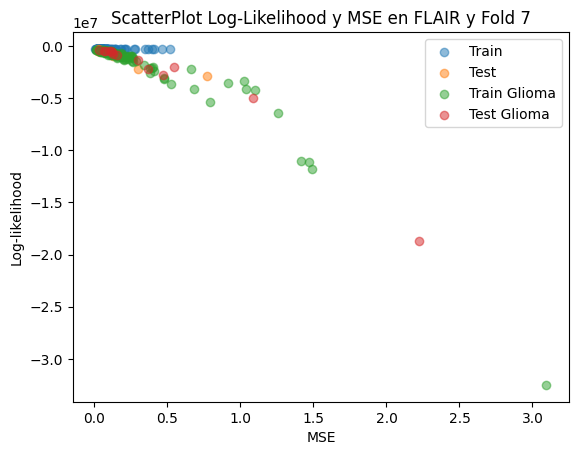

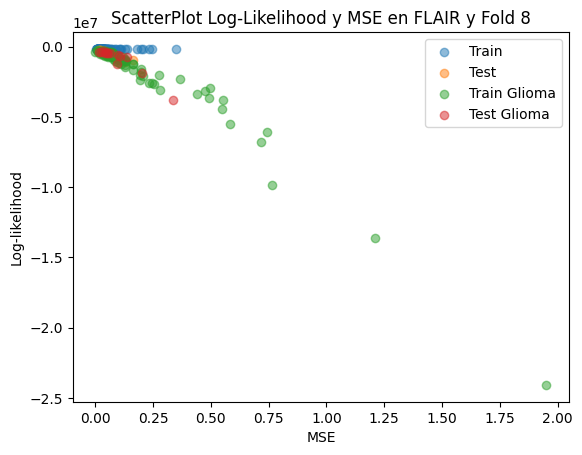

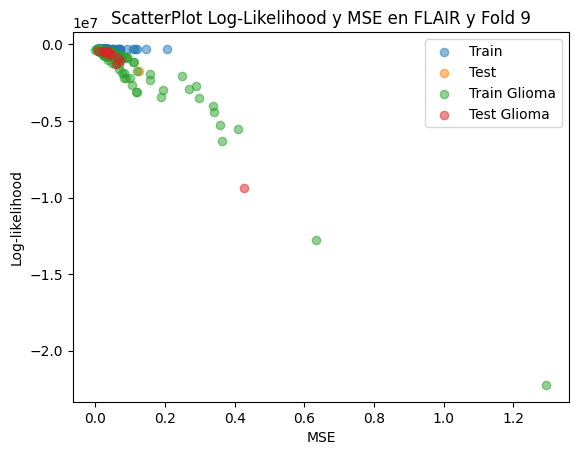

In [44]:
num_folds = 10

for i, v_type in enumerate(["T1", "T2", "FLAIR"]):
    for j in range(num_folds):
        fig, ax = plt.subplots()

        ax.scatter(mse_train[i][j], loglikelihoods_train[i][j], label='Train', alpha=0.5)
        ax.scatter(mse_test[i][j], loglikelihoods_test[i][j], label='Test', alpha=0.5)
        ax.scatter(mse_glioma_train[i][j], loglikelihoods_glioma_train[i][j], label='Train Glioma', alpha=0.5)
        ax.scatter(mse_glioma_test[i][j], loglikelihoods_glioma_test[i][j], label='Test Glioma', alpha=0.5)

        ax.set_xlabel('MSE')
        ax.set_ylabel('Log-likelihood')
        ax.legend()

        ax.relim()
        ax.autoscale_view()
        plt.title('ScatterPlot Log-Likelihood y MSE en '+v_type+' y Fold '+str(j))

        plt.show()

### COMPARAMOS AHORA LOS RESULTADOS DE LOS PACIENTES EN COMÚN EN LOS TRES TIPOS DE MRI

Primero de todo agrupamos los resultados de los pacientes en común por cada MRI

In [7]:
#T1
mse_train_per_patient_common_T1 = [mse_train_per_patient_T1[k] for k in mse_train_per_patient_T1 if int(k) in common_patients_healthy]
logl_train_per_patient_common_T1 = [logl_train_per_patient_T1[k] for k in logl_train_per_patient_T1 if int(k) in common_patients_healthy]
mse_test_per_patient_common_T1 = [mse_test_per_patient_T1[k] for k in mse_test_per_patient_T1 if int(k) in common_patients_healthy]
logl_test_per_patient_common_T1 = [logl_test_per_patient_T1[k] for k in logl_test_per_patient_T1 if int(k) in common_patients_healthy]

mse_glioma_train_per_patient_common_T1 = [mse_glioma_train_per_patient_T1[k] for k in mse_glioma_train_per_patient_T1 if int(k) in common_patients_glioma]
logl_glioma_train_per_patient_common_T1 = [logl_glioma_train_per_patient_T1[k] for k in logl_glioma_train_per_patient_T1 if int(k) in common_patients_glioma]
mse_glioma_test_per_patient_common_T1 = [mse_glioma_test_per_patient_T1[k] for k in mse_glioma_test_per_patient_T1 if int(k) in common_patients_glioma]
logl_glioma_test_per_patient_common_T1 = [logl_glioma_test_per_patient_T1[k] for k in logl_glioma_test_per_patient_T1 if int(k) in common_patients_glioma]

#T2
mse_train_per_patient_common_T2 = [mse_train_per_patient_T2[k] for k in mse_train_per_patient_T2 if int(k) in common_patients_healthy]
logl_train_per_patient_common_T2 = [logl_train_per_patient_T2[k] for k in logl_train_per_patient_T2 if int(k) in common_patients_healthy]
mse_test_per_patient_common_T2 = [mse_test_per_patient_T2[k] for k in mse_test_per_patient_T2 if int(k) in common_patients_healthy]
logl_test_per_patient_common_T2 = [logl_test_per_patient_T2[k] for k in logl_test_per_patient_T2 if int(k) in common_patients_healthy]

mse_glioma_train_per_patient_common_T2 = [mse_glioma_train_per_patient_T2[k] for k in mse_glioma_train_per_patient_T2 if int(k) in common_patients_glioma]
logl_glioma_train_per_patient_common_T2 = [logl_glioma_train_per_patient_T2[k] for k in logl_glioma_train_per_patient_T2 if int(k) in common_patients_glioma]
mse_glioma_test_per_patient_common_T2 = [mse_glioma_test_per_patient_T2[k] for k in mse_glioma_test_per_patient_T2 if int(k) in common_patients_glioma]
logl_glioma_test_per_patient_common_T2 = [logl_glioma_test_per_patient_T2[k] for k in logl_glioma_test_per_patient_T2 if int(k) in common_patients_glioma]

# FLAIR
mse_train_per_patient_common_FLAIR = [mse_train_per_patient_FLAIR[k] for k in mse_train_per_patient_FLAIR if int(k) in common_patients_healthy]
logl_train_per_patient_common_FLAIR = [logl_train_per_patient_FLAIR[k] for k in logl_train_per_patient_FLAIR if int(k) in common_patients_healthy]
mse_test_per_patient_common_FLAIR = [mse_test_per_patient_FLAIR[k] for k in mse_test_per_patient_FLAIR if int(k) in common_patients_healthy]
logl_test_per_patient_common_FLAIR = [logl_test_per_patient_FLAIR[k] for k in logl_test_per_patient_FLAIR if int(k) in common_patients_healthy]

mse_glioma_train_per_patient_common_FLAIR = [mse_glioma_train_per_patient_FLAIR[k] for k in mse_glioma_train_per_patient_FLAIR if int(k) in common_patients_glioma]
logl_glioma_train_per_patient_common_FLAIR = [logl_glioma_train_per_patient_FLAIR[k] for k in logl_glioma_train_per_patient_FLAIR if int(k) in common_patients_glioma]
mse_glioma_test_per_patient_common_FLAIR = [mse_glioma_test_per_patient_FLAIR[k] for k in mse_glioma_test_per_patient_FLAIR if int(k) in common_patients_glioma]
logl_glioma_test_per_patient_common_FLAIR = [logl_glioma_test_per_patient_FLAIR[k] for k in logl_glioma_test_per_patient_FLAIR if int(k) in common_patients_glioma]


En la lista MSE_healthy_train_T1 y correspondientes, se tiene para cada fold una lista de MSE de cada paciente de ese conjunto. En este caso, en mse_train_per_patient_common_T1 se tiene una lista de todos los pacientes donde cada elemento es la lista de MSE de todos los folds de ese paciente, es decir, len(mse_train_per_patient_common_T1) = N_PACIENTES y len(mse_train_per_patient_common_T1[0]) = 10.

Para poder aprovechar las funciones y el código ya hecho, vamos a crear la lista mse_train_common_T1 que contenga la misma distribución que MSE_healthy_train_T1, pero que solo salgan los pacientes que aparecen en los tres tipo de MRI de sanos. Básaicamente, transponer la matriz.

In [8]:
# T1
mse_train_common_T1 = np.transpose(np.array(mse_train_per_patient_common_T1))
logl_train_common_T1 = np.transpose(np.array(logl_train_per_patient_common_T1))
mse_test_common_T1 = np.transpose(np.array(mse_test_per_patient_common_T1))
logl_test_common_T1 = np.transpose(np.array(logl_test_per_patient_common_T1))

mse_glioma_train_common_T1 = np.transpose(np.array(mse_glioma_train_per_patient_common_T1))
logl_glioma_train_common_T1 = np.transpose(np.array(logl_glioma_train_per_patient_common_T1))
mse_glioma_test_common_T1 = np.transpose(np.array(mse_glioma_test_per_patient_common_T1))
logl_glioma_test_common_T1 = np.transpose(np.array(logl_glioma_test_per_patient_common_T1))

# T2
mse_train_common_T2 = np.transpose(np.array(mse_train_per_patient_common_T2))
logl_train_common_T2 = np.transpose(np.array(logl_train_per_patient_common_T2))
mse_test_common_T2 = np.transpose(np.array(mse_test_per_patient_common_T2))
logl_test_common_T2 = np.transpose(np.array(logl_test_per_patient_common_T2))

mse_glioma_train_common_T2 = np.transpose(np.array(mse_glioma_train_per_patient_common_T2))
logl_glioma_train_common_T2 = np.transpose(np.array(logl_glioma_train_per_patient_common_T2))
mse_glioma_test_common_T2 = np.transpose(np.array(mse_glioma_test_per_patient_common_T2))
logl_glioma_test_common_T2 = np.transpose(np.array(logl_glioma_test_per_patient_common_T2))

# FLAIR
mse_train_common_FLAIR = np.transpose(np.array(mse_train_per_patient_common_FLAIR))
logl_train_common_FLAIR = np.transpose(np.array(logl_train_per_patient_common_FLAIR))
mse_test_common_FLAIR = np.transpose(np.array(mse_test_per_patient_common_FLAIR))
logl_test_common_FLAIR = np.transpose(np.array(logl_test_per_patient_common_FLAIR))

mse_glioma_train_common_FLAIR = np.transpose(np.array(mse_glioma_train_per_patient_common_FLAIR))
logl_glioma_train_common_FLAIR = np.transpose(np.array(logl_glioma_train_per_patient_common_FLAIR))
mse_glioma_test_common_FLAIR = np.transpose(np.array(mse_glioma_test_per_patient_common_FLAIR))
logl_glioma_test_common_FLAIR = np.transpose(np.array(logl_glioma_test_per_patient_common_FLAIR))

In [9]:
mse_train_common = [mse_train_common_T1, mse_train_common_T2, mse_train_common_FLAIR]
logl_train_common = [logl_train_common_T1, logl_train_common_T2, logl_train_common_FLAIR]
mse_test_common = [mse_test_common_T1, mse_test_common_T2, mse_test_common_FLAIR]
logl_test_common = [logl_test_common_T1, logl_test_common_T2, logl_test_common_FLAIR]

mse_glioma_train_common = [mse_glioma_train_common_T1, mse_glioma_train_common_T2, mse_glioma_train_common_FLAIR]
logl_glioma_train_common = [logl_glioma_train_common_T1, logl_glioma_train_common_T2, logl_glioma_train_common_FLAIR]
mse_glioma_test_common = [mse_glioma_test_common_T1, mse_glioma_test_common_T2, mse_glioma_test_common_FLAIR]
logl_glioma_test_common = [logl_glioma_test_common_T1, logl_glioma_test_common_T2, logl_glioma_test_common_FLAIR]

En cada una de estas las listas de train se tiene: una matriz por tipo de MRI, donde las filas de esta matriz son los MSE del fold de train (9 filas en total) y cada columna corresponde a un paciente (33 columnas, que son los pacientes comunes en los tres tipos de MRI).

En test, sin embargo, se tiene: una fila por tipo de MRI (porque cada paciente solo pertenece al grupo de test una única vez) y hay 33 elementos en cada fila, que corresponden a los pacientes en común.

### VISUALIZACIONES DE MSE Y LOGLIKELIHOODS POR TIPO MRI DE LOS PACIENTES EN COMÚN

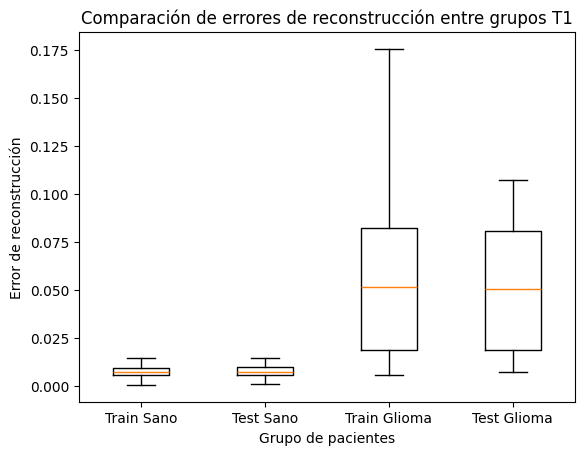

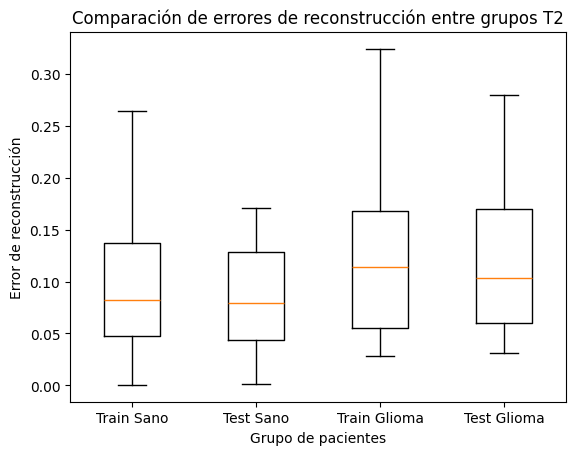

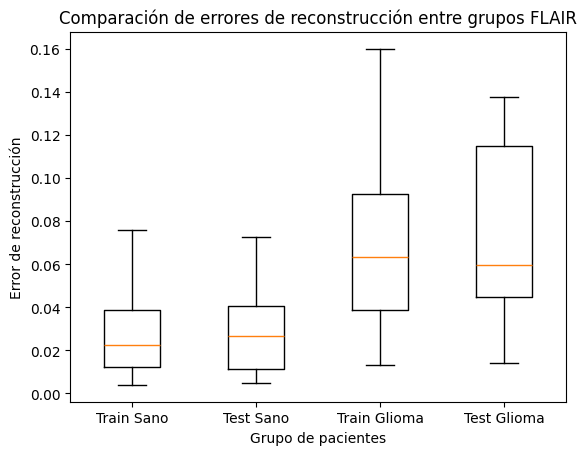

In [48]:
for i, v_type in enumerate(["T1", "T2", "FLAIR"]):
    
    MSE_healthy_train_common_f = [elemento for sublista in mse_train_common[i] for elemento in sublista]
    MSE_healthy_test_common_f = [elemento for sublista in mse_test_common[i] for elemento in sublista]
    MSE_glioma_train_common_f = [elemento for sublista in mse_glioma_train_common[i] for elemento in sublista]
    MSE_glioma_test_common_f = [elemento for sublista in mse_glioma_test_common[i] for elemento in sublista]

    plt.boxplot([MSE_healthy_train_common_f, MSE_healthy_test_common_f, MSE_glioma_train_common_f, MSE_glioma_test_common_f],
                labels=['Train Sano', 'Test Sano', 'Train Glioma', 'Test Glioma'], showfliers=False)

    plt.xlabel('Grupo de pacientes')
    plt.ylabel('Error de reconstrucción')
    plt.title('Comparación de errores de reconstrucción entre grupos '+v_type)
    plt.show()

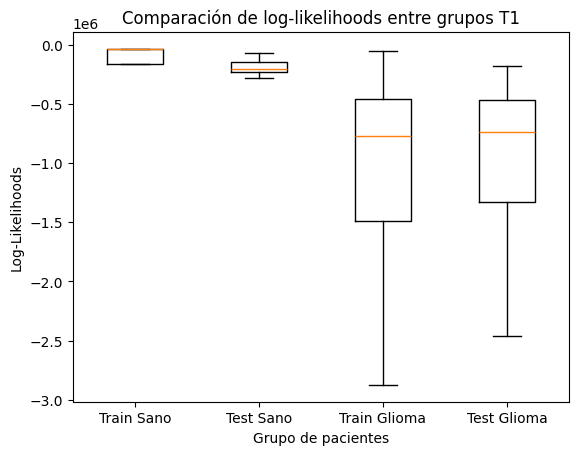

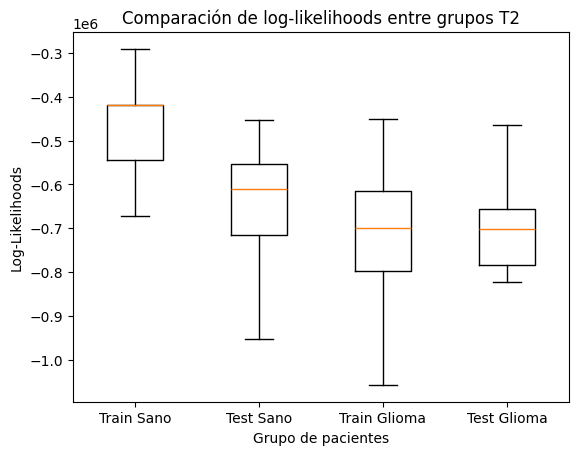

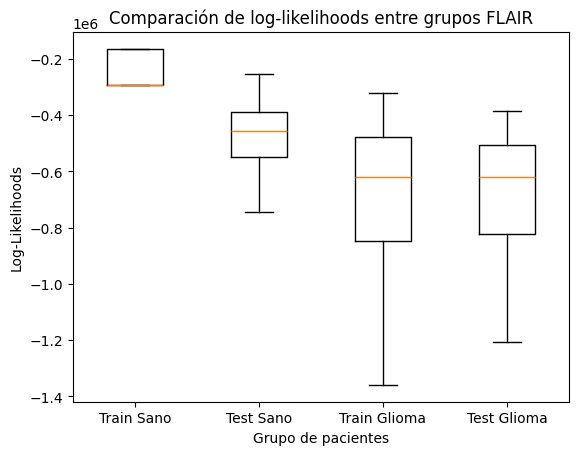

In [49]:
for i, v_type in enumerate(["T1", "T2", "FLAIR"]):
    
    LOGL_healthy_train_common_f = [elemento for sublista in logl_train_common[i] for elemento in sublista]
    LOGL_healthy_test_common_f = [elemento for sublista in logl_test_common[i] for elemento in sublista]
    LOGL_glioma_train_common_f = [elemento for sublista in logl_glioma_train_common[i] for elemento in sublista]
    LOGL_glioma_test_common_f = [elemento for sublista in logl_glioma_test_common[i] for elemento in sublista]

    plt.boxplot([LOGL_healthy_train_common_f, LOGL_healthy_test_common_f, LOGL_glioma_train_common_f, LOGL_glioma_test_common_f],
                labels=['Train Sano', 'Test Sano', 'Train Glioma', 'Test Glioma'], showfliers=False)

    plt.xlabel('Grupo de pacientes')
    plt.ylabel('Log-Likelihoods')
    plt.title('Comparación de log-likelihoods entre grupos '+v_type)
    plt.show()

#### SCATTERPLOT DE MSE - LOGLIKELIHOOD POR CADA TIPO DE MRI DE PACIENTES EN COMÚN

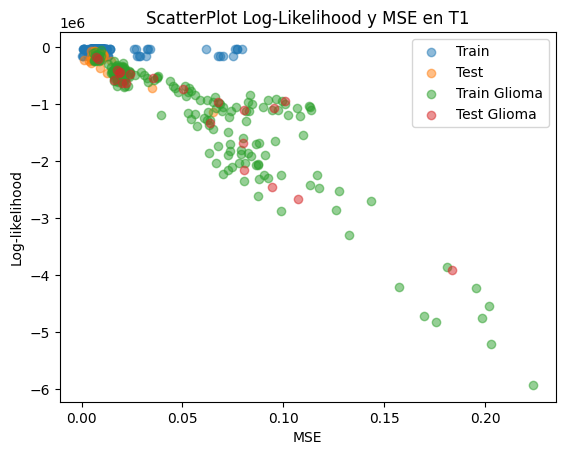

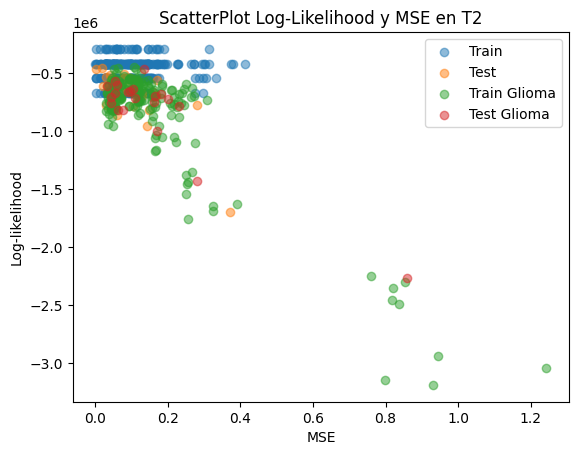

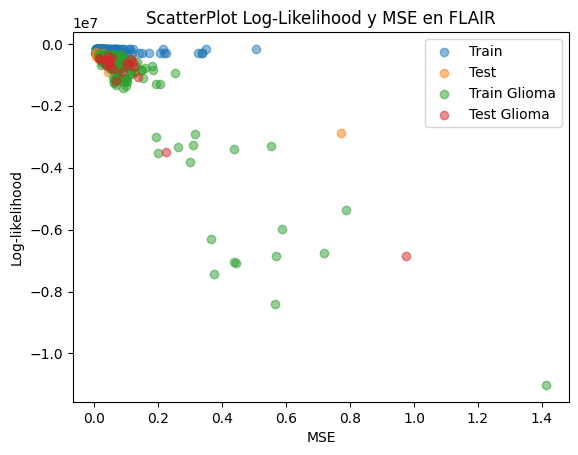

In [50]:
num_folds = 10

for i, v_type in enumerate(["T1", "T2", "FLAIR"]):
    MSE_healthy_train_common_f = [elemento for sublista in mse_train_common[i] for elemento in sublista]
    MSE_healthy_test_common_f = [elemento for sublista in mse_test_common[i] for elemento in sublista]
    MSE_glioma_train_common_f = [elemento for sublista in mse_glioma_train_common[i] for elemento in sublista]
    MSE_glioma_test_common_f = [elemento for sublista in mse_glioma_test_common[i] for elemento in sublista]
    
    LOGL_healthy_train_common_f = [elemento for sublista in logl_train_common[i] for elemento in sublista]
    LOGL_healthy_test_common_f = [elemento for sublista in logl_test_common[i] for elemento in sublista]
    LOGL_glioma_train_common_f = [elemento for sublista in logl_glioma_train_common[i] for elemento in sublista]
    LOGL_glioma_test_common_f = [elemento for sublista in logl_glioma_test_common[i] for elemento in sublista]
    
    fig, ax = plt.subplots()

    ax.scatter(mse_train_common[i], logl_train_common[i], label='Train', alpha=0.5)
    ax.scatter(mse_test_common[i], logl_test_common[i], label='Test', alpha=0.5)
    ax.scatter(mse_glioma_train_common[i], logl_glioma_train_common[i], label='Train Glioma', alpha=0.5)
    ax.scatter(mse_glioma_test_common[i], logl_glioma_test_common[i], label='Test Glioma', alpha=0.5)

    ax.set_xlabel('MSE')
    ax.set_ylabel('Log-likelihood')
    ax.legend()

    ax.relim()
    ax.autoscale_view()
    plt.title('ScatterPlot Log-Likelihood y MSE en '+v_type)

    plt.show()

# CLASIFICACIÓN

En cada una de las celdas de a continuación se encuentra un modelo de clasificación con parámetros concretos, los que se han usado para clasificar los pacientes.

Se han empleado un total de 3 modelos: SVM con kernel="rbf", Random Forest y SVM con kernel="poly". 
Para cada uno de estos modelos hay 4 versiones:
- Pacientes en común y resultado por cada tipo de MRI
- Pacientes en común y resultado conjunto (espacio de 6 características)
- Pacientes en común y resultado conjunto sin T2 (espacio de 4 características)
- Todos los pacientes y resultado por partición

### SVM CON KERNEL RBF SIN SMOTE Y PACIENTES COMUNES (RESULTADO POR TIPO DE MRI)

In [51]:
def objective(trial, X_train, y_train, X_test, y_test):
    C = trial.suggest_float("C", 1e-3, 1e2, log=True)

    base_clf = SVC(C=C, kernel="rbf", random_state=42, probability=True)
#     clf = CalibratedClassifierCV(estimator=base_clf, cv=5)

    base_clf.fit(X_train, y_train)
    y_pred = base_clf.predict(X_test)
    return f1_score(y_test, y_pred)

def classificate(mse_train_common, mse_test_common, 
             mse_glioma_train_common, mse_glioma_test_common,
             logl_train_common, logl_test_common,
             logl_glioma_train_common, logl_glioma_test_common):
    
    for i, MRI_type in enumerate(["T1", "T2", "FLAIR"]):
        # Paso 1: Aplanamos las listas para que no estén separadas por fold
        MSE_healthy_train_common_f = [elemento for sublista in mse_train_common[i] for elemento in sublista]
        MSE_healthy_test_common_f = [elemento for sublista in mse_test_common[i] for elemento in sublista]
        MSE_glioma_train_common_f = [elemento for sublista in mse_glioma_train_common[i] for elemento in sublista]
        MSE_glioma_test_common_f = [elemento for sublista in mse_glioma_test_common[i] for elemento in sublista]

        LOGL_healthy_train_common_f = [elemento for sublista in logl_train_common[i] for elemento in sublista]
        LOGL_healthy_test_common_f = [elemento for sublista in logl_test_common[i] for elemento in sublista]
        LOGL_glioma_train_common_f = [elemento for sublista in logl_glioma_train_common[i] for elemento in sublista]
        LOGL_glioma_test_common_f = [elemento for sublista in logl_glioma_test_common[i] for elemento in sublista]
        
        # Paso 2: Generamos las matrices de X_train y X_test y los vectores de y_train y y_test
        X_healthy_train = list(zip(MSE_healthy_train_common_f, LOGL_healthy_train_common_f))
        X_glioma_train = list(zip(MSE_glioma_train_common_f, LOGL_glioma_train_common_f))
        y_train = [0] * len(X_healthy_train) + [1] * len(X_glioma_train)
        
        X_train = X_healthy_train + X_glioma_train
        
        X_healthy_test = list(zip(MSE_healthy_test_common_f, LOGL_healthy_test_common_f))
        X_glioma_test = list(zip(MSE_glioma_test_common_f, LOGL_glioma_test_common_f))
        
        y_test = [0] * len(X_healthy_test) + [1] * len(X_glioma_test)
        
        X_test = X_healthy_test + X_glioma_test
        
        # Aplicar SMOTE
        sm = SMOTE(random_state=42)
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

        study = optuna.create_study(direction="maximize")
        study.optimize(lambda trial: objective(trial, X_train_res, y_train_res, X_test, y_test), n_trials=500, n_jobs=-1)

        # Inicializamos el clasificador con los mejores parámetros
        best_clf = SVC(**study.best_params, probability=True, random_state=42)
        
        print(f"Best parameters for MRI type {MRI_type}: {study.best_params}")
        
#         best_base_clf = SVC(**study.best_params, class_weight="balanced", random_state=42, probability=True)
#         best_clf = CalibratedClassifierCV(estimator=best_base_clf)
        best_clf.fit(X_train_res, y_train_res)
        
        # Hacemos predicciones
        y_prob = best_clf.predict_proba(X_test)[:, 1]

        # Calcular la curva ROC y encontrar el umbral óptimo
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        J = tpr - fpr
        ix = np.argmax(J)
        best_threshold = thresholds[ix]
        print('Best Threshold=%f' % best_threshold)

        # Hacer predicciones usando el umbral óptimo
        y_pred_opt = (y_prob >= best_threshold).astype(int)

        # Paso 5: Evaluar el modelo
        conf_matrix = confusion_matrix(y_test, y_pred_opt)
        accuracy = accuracy_score(y_test, y_pred_opt)
        f1 = f1_score(y_test, y_pred_opt)
        recall_per_class = recall_score(y_test, y_pred_opt, average=None)
        class_report = classification_report(y_test, y_pred_opt)

        # Imprimir resultados
        print("Resultados para Tipo MRI:", MRI_type + "\n")
        print("Confusion Matrix:")
        print(conf_matrix)
        for j, recall in enumerate(recall_per_class):
            print(f"Recall for class {j}: {recall}")
        print(f"Accuracy: {accuracy}")
        print(f"F1 Score: {f1}")
        print("\nClassification Report:\n", class_report)
        print("\n")
        
        print("Training set - healthy:", len(MSE_healthy_train_common_f), "glioma:", len(MSE_glioma_train_common_f))
        print("Test set - healthy:", len(MSE_healthy_test_common_f), "glioma:", len(MSE_glioma_test_common_f))


# Supongo que ya tienes las variables mse_train, mse_test, mse_glioma, logl_train, logl_test, logl_glioma definidas
classificate(mse_train_common, mse_test_common, 
             mse_glioma_train_common, mse_glioma_test_common,
             logl_train_common, logl_test_common,
             logl_glioma_train_common, logl_glioma_test_common)


[I 2024-06-28 09:27:50,240] A new study created in memory with name: no-name-056d634f-66fd-4ca7-aa41-31f508c41cfc
[I 2024-06-28 09:27:50,290] Trial 0 finished with value: 0.8444444444444444 and parameters: {'C': 0.9700225892000806}. Best is trial 0 with value: 0.8444444444444444.
[I 2024-06-28 09:27:50,296] Trial 4 finished with value: 0.8085106382978723 and parameters: {'C': 41.3121456813418}. Best is trial 0 with value: 0.8444444444444444.
[I 2024-06-28 09:27:50,310] Trial 8 finished with value: 0.8260869565217391 and parameters: {'C': 13.082326595014592}. Best is trial 0 with value: 0.8444444444444444.
[I 2024-06-28 09:27:50,312] Trial 1 finished with value: 0.7450980392156863 and parameters: {'C': 80.31963918998169}. Best is trial 0 with value: 0.8444444444444444.
[I 2024-06-28 09:27:50,317] Trial 6 finished with value: 0.8444444444444444 and parameters: {'C': 1.3222199514704753}. Best is trial 0 with value: 0.8444444444444444.
[I 2024-06-28 09:27:50,318] Trial 2 finished with valu

[I 2024-06-28 09:27:50,689] Trial 49 finished with value: 0.7894736842105263 and parameters: {'C': 0.019027895892166583}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:50,696] Trial 51 finished with value: 0.8444444444444444 and parameters: {'C': 4.111985712745803}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:50,702] Trial 48 finished with value: 0.8205128205128205 and parameters: {'C': 0.02071955873620089}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:50,722] Trial 50 finished with value: 0.7894736842105263 and parameters: {'C': 0.012009181021686544}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:50,740] Trial 55 finished with value: 0.8444444444444444 and parameters: {'C': 5.573050163407795}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:50,742] Trial 58 finished with value: 0.8260869565217391 and parameters: {'C': 8.134452597306039}. Best is trial 5 with value: 0.88372093

[I 2024-06-28 09:27:51,131] Trial 101 finished with value: 0.8636363636363636 and parameters: {'C': 0.5590154636340419}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:51,137] Trial 95 finished with value: 0.8636363636363636 and parameters: {'C': 0.5483110931635509}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:51,140] Trial 100 finished with value: 0.8636363636363636 and parameters: {'C': 0.5471690494695906}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:51,142] Trial 97 finished with value: 0.7222222222222222 and parameters: {'C': 0.0019928342515436585}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:51,145] Trial 93 finished with value: 0.7222222222222222 and parameters: {'C': 0.0025992667250819956}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:51,147] Trial 102 finished with value: 0.8636363636363636 and parameters: {'C': 0.7515595072166881}. Best is trial 5 with value: 0.8

[I 2024-06-28 09:27:51,615] Trial 149 finished with value: 0.8636363636363636 and parameters: {'C': 0.10799851410667392}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:51,621] Trial 151 finished with value: 0.8636363636363636 and parameters: {'C': 0.13024704703365933}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:51,627] Trial 148 finished with value: 0.8636363636363636 and parameters: {'C': 0.1494214602065292}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:51,629] Trial 144 finished with value: 0.8636363636363636 and parameters: {'C': 0.07050577940536533}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:51,641] Trial 147 finished with value: 0.8636363636363636 and parameters: {'C': 0.1494865815383528}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:51,645] Trial 150 finished with value: 0.8636363636363636 and parameters: {'C': 0.1058404814363524}. Best is trial 5 with value: 0.8

[I 2024-06-28 09:27:52,111] Trial 194 finished with value: 0.8636363636363636 and parameters: {'C': 0.2882178043023679}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:52,114] Trial 198 finished with value: 0.8837209302325582 and parameters: {'C': 0.0334289053489705}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:52,123] Trial 197 finished with value: 0.8636363636363636 and parameters: {'C': 0.24196362733165547}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:52,129] Trial 201 finished with value: 0.8636363636363636 and parameters: {'C': 0.293223627695381}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:52,132] Trial 200 finished with value: 0.8636363636363636 and parameters: {'C': 0.2684116117375456}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:52,136] Trial 199 finished with value: 0.8636363636363636 and parameters: {'C': 0.25434395483977384}. Best is trial 5 with value: 0.883

[I 2024-06-28 09:27:52,569] Trial 245 finished with value: 0.8837209302325582 and parameters: {'C': 0.0327512118710378}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:52,580] Trial 244 finished with value: 0.8837209302325582 and parameters: {'C': 0.035639647094348}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:52,584] Trial 246 finished with value: 0.8837209302325582 and parameters: {'C': 0.03405008112009158}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:52,588] Trial 247 finished with value: 0.8571428571428571 and parameters: {'C': 0.02597175577729911}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:52,624] Trial 248 finished with value: 0.8571428571428571 and parameters: {'C': 0.027389237866806224}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:52,628] Trial 249 finished with value: 0.8571428571428571 and parameters: {'C': 0.02851409522657708}. Best is trial 5 with value: 0.

[I 2024-06-28 09:27:53,159] Trial 295 finished with value: 0.8205128205128205 and parameters: {'C': 0.01918434631506822}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:53,161] Trial 293 finished with value: 0.8837209302325582 and parameters: {'C': 0.03065214977875464}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:53,193] Trial 298 finished with value: 0.8837209302325582 and parameters: {'C': 0.03187037957826944}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:53,197] Trial 299 finished with value: 0.8837209302325582 and parameters: {'C': 0.030702870526513146}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:53,198] Trial 294 finished with value: 0.8837209302325582 and parameters: {'C': 0.03153179609012738}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:53,202] Trial 300 finished with value: 0.8205128205128205 and parameters: {'C': 0.019167940828063505}. Best is trial 5 with value

[I 2024-06-28 09:27:53,702] Trial 341 finished with value: 0.8571428571428571 and parameters: {'C': 0.026369576397862374}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:53,708] Trial 344 finished with value: 0.8636363636363636 and parameters: {'C': 0.049367588248512416}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:53,728] Trial 345 finished with value: 0.8636363636363636 and parameters: {'C': 0.05130384646151583}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:53,730] Trial 343 finished with value: 0.8636363636363636 and parameters: {'C': 0.05120137990298819}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:53,743] Trial 346 finished with value: 0.8636363636363636 and parameters: {'C': 0.04995949504004267}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:53,751] Trial 348 finished with value: 0.8636363636363636 and parameters: {'C': 0.04977567486935711}. Best is trial 5 with value

[I 2024-06-28 09:27:54,242] Trial 391 finished with value: 0.8837209302325582 and parameters: {'C': 0.04059278036180675}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:54,278] Trial 394 finished with value: 0.8837209302325582 and parameters: {'C': 0.04026149629520775}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:54,281] Trial 392 finished with value: 0.8837209302325582 and parameters: {'C': 0.04228181184078992}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:54,309] Trial 397 finished with value: 0.8636363636363636 and parameters: {'C': 0.0449716470064466}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:54,320] Trial 399 finished with value: 0.8636363636363636 and parameters: {'C': 0.07187265787980467}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:54,322] Trial 396 finished with value: 0.8837209302325582 and parameters: {'C': 0.039856635304083766}. Best is trial 5 with value: 

[I 2024-06-28 09:27:54,808] Trial 439 finished with value: 0.8571428571428571 and parameters: {'C': 0.027156786587983504}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:54,836] Trial 442 finished with value: 0.8571428571428571 and parameters: {'C': 0.027082235469266053}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:54,840] Trial 441 finished with value: 0.8571428571428571 and parameters: {'C': 0.027767209227084897}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:54,870] Trial 443 finished with value: 0.8571428571428571 and parameters: {'C': 0.02534438561435567}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:54,883] Trial 447 finished with value: 0.8837209302325582 and parameters: {'C': 0.037257668453647606}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:54,886] Trial 445 finished with value: 0.8571428571428571 and parameters: {'C': 0.026961482359352657}. Best is trial 5 with va

[I 2024-06-28 09:27:55,419] Trial 489 finished with value: 0.7894736842105263 and parameters: {'C': 0.016695728475849398}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:55,422] Trial 490 finished with value: 0.7894736842105263 and parameters: {'C': 0.01546353866145256}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:55,426] Trial 491 finished with value: 0.7894736842105263 and parameters: {'C': 0.01629228014135385}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:55,428] Trial 492 finished with value: 0.8292682926829268 and parameters: {'C': 0.02272939621512004}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:55,430] Trial 493 finished with value: 0.8292682926829268 and parameters: {'C': 0.022303989645078317}. Best is trial 5 with value: 0.8837209302325582.
[I 2024-06-28 09:27:55,440] Trial 495 finished with value: 0.8292682926829268 and parameters: {'C': 0.022757116503575422}. Best is trial 5 with valu

Best parameters for MRI type T1: {'C': 0.03087108949069986}
Best Threshold=0.990606
Resultados para Tipo MRI: T1

Confusion Matrix:
[[30  3]
 [ 2 19]]
Recall for class 0: 0.9090909090909091
Recall for class 1: 0.9047619047619048
Accuracy: 0.9074074074074074
F1 Score: 0.8837209302325582

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92        33
           1       0.86      0.90      0.88        21

    accuracy                           0.91        54
   macro avg       0.90      0.91      0.90        54
weighted avg       0.91      0.91      0.91        54



Training set - healthy: 297 glioma: 189
Test set - healthy: 33 glioma: 21


[I 2024-06-28 09:27:55,638] Trial 8 finished with value: 0.6129032258064516 and parameters: {'C': 0.06351672192107986}. Best is trial 0 with value: 0.6333333333333333.
[I 2024-06-28 09:27:55,642] Trial 1 finished with value: 0.6129032258064516 and parameters: {'C': 0.0559912229633813}. Best is trial 0 with value: 0.6333333333333333.
[I 2024-06-28 09:27:55,646] Trial 7 finished with value: 0.6296296296296297 and parameters: {'C': 0.0012386724326767635}. Best is trial 0 with value: 0.6333333333333333.
[I 2024-06-28 09:27:55,657] Trial 16 finished with value: 0.6333333333333333 and parameters: {'C': 27.263483520563984}. Best is trial 0 with value: 0.6333333333333333.
[I 2024-06-28 09:27:55,659] Trial 18 finished with value: 0.6206896551724138 and parameters: {'C': 1.4026956664252268}. Best is trial 0 with value: 0.6333333333333333.
[I 2024-06-28 09:27:55,662] Trial 13 finished with value: 0.6333333333333333 and parameters: {'C': 60.095023865322}. Best is trial 0 with value: 0.633333333333

[I 2024-06-28 09:27:56,065] Trial 56 finished with value: 0.6333333333333333 and parameters: {'C': 13.184987076625}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:56,094] Trial 58 finished with value: 0.6333333333333333 and parameters: {'C': 6.787390002068207}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:56,119] Trial 59 finished with value: 0.6333333333333333 and parameters: {'C': 12.665680765235514}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:56,133] Trial 60 finished with value: 0.6333333333333333 and parameters: {'C': 9.17913901839143}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:56,135] Trial 65 finished with value: 0.6333333333333333 and parameters: {'C': 8.608939141194899}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:56,137] Trial 57 finished with value: 0.6333333333333333 and parameters: {'C': 7.4997498354899745}. Best is trial 17 with value: 0.64285714285

[I 2024-06-28 09:27:56,488] Trial 103 finished with value: 0.6060606060606061 and parameters: {'C': 0.4627374449834118}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:56,506] Trial 106 finished with value: 0.625 and parameters: {'C': 0.6038632254997527}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:56,507] Trial 107 finished with value: 0.6060606060606061 and parameters: {'C': 0.5514561386898358}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:56,516] Trial 108 finished with value: 0.6129032258064516 and parameters: {'C': 0.6273161855478833}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:56,541] Trial 109 finished with value: 0.6060606060606061 and parameters: {'C': 0.4362542988133608}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:56,553] Trial 110 finished with value: 0.6129032258064516 and parameters: {'C': 0.7075315231507222}. Best is trial 17 with value: 0.64285714285

[I 2024-06-28 09:27:57,002] Trial 153 finished with value: 0.6333333333333333 and parameters: {'C': 40.023173884362635}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:57,005] Trial 155 finished with value: 0.6333333333333333 and parameters: {'C': 38.69960299897375}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:57,039] Trial 159 finished with value: 0.6333333333333333 and parameters: {'C': 37.48282928910928}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:57,054] Trial 156 finished with value: 0.6333333333333333 and parameters: {'C': 34.51939869914195}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:57,056] Trial 160 finished with value: 0.6333333333333333 and parameters: {'C': 33.38726580222187}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:57,058] Trial 158 finished with value: 0.6333333333333333 and parameters: {'C': 36.01598566220348}. Best is trial 17 with value: 0.642

[I 2024-06-28 09:27:57,500] Trial 200 finished with value: 0.6206896551724138 and parameters: {'C': 1.6933705150939888}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:57,511] Trial 204 finished with value: 0.6333333333333333 and parameters: {'C': 3.363432098147248}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:57,512] Trial 207 finished with value: 0.6333333333333333 and parameters: {'C': 3.7963913318217632}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:57,518] Trial 206 finished with value: 0.6333333333333333 and parameters: {'C': 4.035468032668774}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:57,523] Trial 203 finished with value: 0.6333333333333333 and parameters: {'C': 4.406004852415219}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:57,528] Trial 208 finished with value: 0.6333333333333333 and parameters: {'C': 4.090733926088492}. Best is trial 17 with value: 0.64

[I 2024-06-28 09:27:58,006] Trial 248 finished with value: 0.6333333333333333 and parameters: {'C': 0.039719375127553684}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:58,037] Trial 254 finished with value: 0.6333333333333333 and parameters: {'C': 10.408874266054356}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:58,052] Trial 253 finished with value: 0.6333333333333333 and parameters: {'C': 11.598188286428263}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:58,079] Trial 257 finished with value: 0.6333333333333333 and parameters: {'C': 11.564168166512626}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:58,080] Trial 258 finished with value: 0.6333333333333333 and parameters: {'C': 10.250815967147766}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:58,081] Trial 256 finished with value: 0.6333333333333333 and parameters: {'C': 9.759453443003299}. Best is trial 17 with value:

[I 2024-06-28 09:27:58,636] Trial 300 finished with value: 0.6129032258064516 and parameters: {'C': 0.08450540369147624}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:58,645] Trial 303 finished with value: 0.6206896551724138 and parameters: {'C': 1.8722736322726476}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:58,653] Trial 298 finished with value: 0.6206896551724138 and parameters: {'C': 0.013888735227019154}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:58,653] Trial 306 finished with value: 0.6333333333333333 and parameters: {'C': 13.509069853270033}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:58,667] Trial 305 finished with value: 0.6333333333333333 and parameters: {'C': 42.79620979004105}. Best is trial 17 with value: 0.6428571428571429.
[I 2024-06-28 09:27:58,667] Trial 304 finished with value: 0.6545454545454545 and parameters: {'C': 0.012980303384500761}. Best is trial 304 with va

[I 2024-06-28 09:27:59,174] Trial 352 finished with value: 0.6333333333333333 and parameters: {'C': 29.488391887766394}. Best is trial 304 with value: 0.6545454545454545.
[I 2024-06-28 09:27:59,178] Trial 349 finished with value: 0.6296296296296297 and parameters: {'C': 0.01247940735682225}. Best is trial 304 with value: 0.6545454545454545.
[I 2024-06-28 09:27:59,185] Trial 350 finished with value: 0.6333333333333333 and parameters: {'C': 3.3556850504888662}. Best is trial 304 with value: 0.6545454545454545.
[I 2024-06-28 09:27:59,201] Trial 353 finished with value: 0.6333333333333333 and parameters: {'C': 60.51601675658878}. Best is trial 304 with value: 0.6545454545454545.
[I 2024-06-28 09:27:59,205] Trial 351 finished with value: 0.6296296296296297 and parameters: {'C': 0.00924694857223924}. Best is trial 304 with value: 0.6545454545454545.
[I 2024-06-28 09:27:59,253] Trial 357 finished with value: 0.6060606060606061 and parameters: {'C': 0.32910066400160176}. Best is trial 304 with

[I 2024-06-28 09:27:59,763] Trial 396 finished with value: 0.6333333333333333 and parameters: {'C': 76.4209318692435}. Best is trial 304 with value: 0.6545454545454545.
[I 2024-06-28 09:27:59,772] Trial 399 finished with value: 0.6333333333333333 and parameters: {'C': 70.53415683711239}. Best is trial 304 with value: 0.6545454545454545.
[I 2024-06-28 09:27:59,775] Trial 400 finished with value: 0.6333333333333333 and parameters: {'C': 19.924465846801294}. Best is trial 304 with value: 0.6545454545454545.
[I 2024-06-28 09:27:59,778] Trial 402 finished with value: 0.6129032258064516 and parameters: {'C': 0.05284439506529957}. Best is trial 304 with value: 0.6545454545454545.
[I 2024-06-28 09:27:59,780] Trial 398 finished with value: 0.6333333333333333 and parameters: {'C': 69.10934395081412}. Best is trial 304 with value: 0.6545454545454545.
[I 2024-06-28 09:27:59,799] Trial 401 finished with value: 0.6129032258064516 and parameters: {'C': 0.05544606170631823}. Best is trial 304 with val

[I 2024-06-28 09:28:00,334] Trial 445 finished with value: 0.6333333333333333 and parameters: {'C': 25.47376072320359}. Best is trial 304 with value: 0.6545454545454545.
[I 2024-06-28 09:28:00,345] Trial 450 finished with value: 0.6333333333333333 and parameters: {'C': 27.731077256727364}. Best is trial 304 with value: 0.6545454545454545.
[I 2024-06-28 09:28:00,365] Trial 449 finished with value: 0.6333333333333333 and parameters: {'C': 27.31644442998019}. Best is trial 304 with value: 0.6545454545454545.
[I 2024-06-28 09:28:00,366] Trial 448 finished with value: 0.6333333333333333 and parameters: {'C': 28.042587266669624}. Best is trial 304 with value: 0.6545454545454545.
[I 2024-06-28 09:28:00,367] Trial 451 finished with value: 0.6060606060606061 and parameters: {'C': 0.39090486537042507}. Best is trial 304 with value: 0.6545454545454545.
[I 2024-06-28 09:28:00,383] Trial 447 finished with value: 0.6296296296296297 and parameters: {'C': 0.012255609952727307}. Best is trial 304 with 

[I 2024-06-28 09:28:00,884] Trial 494 finished with value: 0.6428571428571429 and parameters: {'C': 0.02419372161314093}. Best is trial 304 with value: 0.6545454545454545.
[I 2024-06-28 09:28:00,890] Trial 492 finished with value: 0.6333333333333333 and parameters: {'C': 0.03465046044643774}. Best is trial 304 with value: 0.6545454545454545.
[I 2024-06-28 09:28:00,898] Trial 496 finished with value: 0.6296296296296297 and parameters: {'C': 0.02189657404153663}. Best is trial 304 with value: 0.6545454545454545.
[I 2024-06-28 09:28:00,910] Trial 498 finished with value: 0.6545454545454545 and parameters: {'C': 0.022660844592568664}. Best is trial 304 with value: 0.6545454545454545.
[I 2024-06-28 09:28:00,913] Trial 499 finished with value: 0.6206896551724138 and parameters: {'C': 0.025228101265474798}. Best is trial 304 with value: 0.6545454545454545.
[I 2024-06-28 09:28:00,922] Trial 497 finished with value: 0.6333333333333333 and parameters: {'C': 0.029103509906746747}. Best is trial 3

Best parameters for MRI type T2: {'C': 0.012980303384500761}
Best Threshold=0.662883
Resultados para Tipo MRI: T2

Confusion Matrix:
[[17 16]
 [ 3 18]]
Recall for class 0: 0.5151515151515151
Recall for class 1: 0.8571428571428571
Accuracy: 0.6481481481481481
F1 Score: 0.6545454545454545

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.52      0.64        33
           1       0.53      0.86      0.65        21

    accuracy                           0.65        54
   macro avg       0.69      0.69      0.65        54
weighted avg       0.73      0.65      0.65        54



Training set - healthy: 297 glioma: 189
Test set - healthy: 33 glioma: 21


[I 2024-06-28 09:28:01,092] Trial 9 finished with value: 0.6046511627906976 and parameters: {'C': 0.02789509046644278}. Best is trial 10 with value: 0.6451612903225806.
[I 2024-06-28 09:28:01,102] Trial 18 finished with value: 0.6666666666666666 and parameters: {'C': 0.04495411752264328}. Best is trial 18 with value: 0.6666666666666666.
[I 2024-06-28 09:28:01,107] Trial 17 finished with value: 0.6 and parameters: {'C': 2.908781490740671}. Best is trial 18 with value: 0.6666666666666666.
[I 2024-06-28 09:28:01,108] Trial 21 finished with value: 0.6 and parameters: {'C': 4.240495356343097}. Best is trial 18 with value: 0.6666666666666666.
[I 2024-06-28 09:28:01,111] Trial 0 finished with value: 0.6451612903225806 and parameters: {'C': 0.24268995989843786}. Best is trial 18 with value: 0.6666666666666666.
[I 2024-06-28 09:28:01,114] Trial 19 finished with value: 0.6896551724137931 and parameters: {'C': 0.15528636911982907}. Best is trial 19 with value: 0.6896551724137931.
[I 2024-06-28 09

[I 2024-06-28 09:28:01,575] Trial 56 finished with value: 0.6666666666666666 and parameters: {'C': 0.12447995239163744}. Best is trial 23 with value: 0.6909090909090909.
[I 2024-06-28 09:28:01,579] Trial 58 finished with value: 0.6666666666666666 and parameters: {'C': 0.11498255121560232}. Best is trial 23 with value: 0.6909090909090909.
[I 2024-06-28 09:28:01,584] Trial 57 finished with value: 0.6666666666666666 and parameters: {'C': 0.10958880309488644}. Best is trial 23 with value: 0.6909090909090909.
[I 2024-06-28 09:28:01,594] Trial 62 finished with value: 0.6666666666666666 and parameters: {'C': 0.11764086197214084}. Best is trial 23 with value: 0.6909090909090909.
[I 2024-06-28 09:28:01,602] Trial 63 finished with value: 0.6274509803921569 and parameters: {'C': 0.09941980353823819}. Best is trial 23 with value: 0.6909090909090909.
[I 2024-06-28 09:28:01,608] Trial 64 finished with value: 0.6792452830188679 and parameters: {'C': 0.1062241461787047}. Best is trial 23 with value: 0

[I 2024-06-28 09:28:02,028] Trial 108 finished with value: 0.5555555555555556 and parameters: {'C': 0.014288351966138244}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:02,030] Trial 106 finished with value: 0.5853658536585366 and parameters: {'C': 0.02281144257515571}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:02,030] Trial 109 finished with value: 0.5853658536585366 and parameters: {'C': 0.02386069736923767}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:02,031] Trial 111 finished with value: 0.6268656716417911 and parameters: {'C': 0.6356220746316164}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:02,049] Trial 107 finished with value: 0.5853658536585366 and parameters: {'C': 0.02032819297159506}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:02,081] Trial 112 finished with value: 0.5853658536585366 and parameters: {'C': 0.022333523873404926}. Best is trial 83 with 

[I 2024-06-28 09:28:02,508] Trial 157 finished with value: 0.6896551724137931 and parameters: {'C': 0.057147774559855036}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:02,512] Trial 153 finished with value: 0.6896551724137931 and parameters: {'C': 0.05866926274268312}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:02,535] Trial 158 finished with value: 0.6896551724137931 and parameters: {'C': 0.05797591473240066}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:02,554] Trial 160 finished with value: 0.6909090909090909 and parameters: {'C': 0.05237882885380484}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:02,556] Trial 159 finished with value: 0.6896551724137931 and parameters: {'C': 0.05645929501337957}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:02,568] Trial 166 finished with value: 0.6909090909090909 and parameters: {'C': 0.05215625295049066}. Best is trial 83 with 

[I 2024-06-28 09:28:02,953] Trial 205 finished with value: 0.6779661016949152 and parameters: {'C': 0.1620292912409697}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:02,965] Trial 207 finished with value: 0.6896551724137931 and parameters: {'C': 0.1531572590252566}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:02,975] Trial 206 finished with value: 0.6274509803921569 and parameters: {'C': 0.0752967529305618}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:02,998] Trial 208 finished with value: 0.6896551724137931 and parameters: {'C': 0.15047600202924283}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:03,001] Trial 209 finished with value: 0.6779661016949152 and parameters: {'C': 0.15818793221245586}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:03,007] Trial 212 finished with value: 0.7017543859649122 and parameters: {'C': 0.14166492158135646}. Best is trial 83 with valu

[I 2024-06-28 09:28:03,470] Trial 255 finished with value: 0.5833333333333334 and parameters: {'C': 20.69822267818701}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:03,484] Trial 253 finished with value: 0.6666666666666666 and parameters: {'C': 0.04684783094352193}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:03,486] Trial 256 finished with value: 0.5833333333333334 and parameters: {'C': 16.582353311282557}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:03,488] Trial 257 finished with value: 0.6666666666666666 and parameters: {'C': 0.04668866171640287}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:03,493] Trial 258 finished with value: 0.6896551724137931 and parameters: {'C': 0.06393610588431203}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:03,520] Trial 259 finished with value: 0.5833333333333334 and parameters: {'C': 24.912946439394986}. Best is trial 83 with value

[I 2024-06-28 09:28:03,996] Trial 303 finished with value: 0.6896551724137931 and parameters: {'C': 0.05884979447068861}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:04,020] Trial 304 finished with value: 0.6896551724137931 and parameters: {'C': 0.06067157831774804}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:04,033] Trial 307 finished with value: 0.5909090909090909 and parameters: {'C': 0.028909280221396348}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:04,037] Trial 305 finished with value: 0.5909090909090909 and parameters: {'C': 0.029046137511412044}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:04,045] Trial 306 finished with value: 0.6046511627906976 and parameters: {'C': 0.02804751676560323}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:04,088] Trial 308 finished with value: 0.6896551724137931 and parameters: {'C': 0.06047872668041578}. Best is trial 83 with

[I 2024-06-28 09:28:04,575] Trial 351 finished with value: 0.6909090909090909 and parameters: {'C': 0.05225838619985022}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:04,584] Trial 353 finished with value: 0.6792452830188679 and parameters: {'C': 0.10501268467851116}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:04,602] Trial 355 finished with value: 0.6666666666666666 and parameters: {'C': 0.10935617427502033}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:04,619] Trial 356 finished with value: 0.6909090909090909 and parameters: {'C': 0.0531615193991763}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:04,625] Trial 354 finished with value: 0.6909090909090909 and parameters: {'C': 0.05275777934649968}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:04,638] Trial 357 finished with value: 0.6896551724137931 and parameters: {'C': 0.15326976005569834}. Best is trial 83 with va

[I 2024-06-28 09:28:05,146] Trial 397 finished with value: 0.64 and parameters: {'C': 0.08594138959087651}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:05,167] Trial 403 finished with value: 0.6896551724137931 and parameters: {'C': 0.15074394607975033}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:05,179] Trial 404 finished with value: 0.7017543859649122 and parameters: {'C': 0.14180081146524826}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:05,191] Trial 401 finished with value: 0.6785714285714286 and parameters: {'C': 0.13517449883338417}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:05,195] Trial 400 finished with value: 0.6896551724137931 and parameters: {'C': 0.1529270704329843}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:05,199] Trial 405 finished with value: 0.6779661016949152 and parameters: {'C': 0.1570976651124793}. Best is trial 83 with value: 0.70175438

[I 2024-06-28 09:28:05,715] Trial 445 finished with value: 0.625 and parameters: {'C': 0.03331463047046651}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:05,721] Trial 451 finished with value: 0.6792452830188679 and parameters: {'C': 0.07176960800101422}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:05,723] Trial 450 finished with value: 0.5555555555555556 and parameters: {'C': 0.00479989623859308}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:05,741] Trial 452 finished with value: 0.6666666666666666 and parameters: {'C': 0.06945130494930007}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:05,785] Trial 454 finished with value: 0.6666666666666666 and parameters: {'C': 0.07031647402338805}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:05,799] Trial 462 finished with value: 0.6 and parameters: {'C': 4.506823720537273}. Best is trial 83 with value: 0.7017543859649122.
[I 2

[I 2024-06-28 09:28:06,233] Trial 495 finished with value: 0.6274509803921569 and parameters: {'C': 0.09736329706982703}. Best is trial 83 with value: 0.7017543859649122.
[I 2024-06-28 09:28:06,237] Trial 497 finished with value: 0.6274509803921569 and parameters: {'C': 0.08951050965604304}. Best is trial 83 with value: 0.7017543859649122.


Best parameters for MRI type FLAIR: {'C': 0.14075501029387716}
Best Threshold=1.000000
Resultados para Tipo MRI: FLAIR

Confusion Matrix:
[[17 16]
 [ 1 20]]
Recall for class 0: 0.5151515151515151
Recall for class 1: 0.9523809523809523
Accuracy: 0.6851851851851852
F1 Score: 0.7017543859649122

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.52      0.67        33
           1       0.56      0.95      0.70        21

    accuracy                           0.69        54
   macro avg       0.75      0.73      0.68        54
weighted avg       0.79      0.69      0.68        54



Training set - healthy: 297 glioma: 189
Test set - healthy: 33 glioma: 21


### SVM CON KERNEL RBF CON SMOTE Y PACIENTES COMUNES (RESULTADO COLECTIVO)

In [52]:
def objective(trial, X_train, y_train, X_test, y_test):
    C = trial.suggest_float("C", 1e-3, 1e2, log=True)
    clf = SVC(C=C, kernel="rbf", probability=True, random_state=42)    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return f1_score(y_test, y_pred)

def classificate(mse_train_common, mse_test_common, 
                 mse_glioma_train_common, mse_glioma_test_common,
                 logl_train_common, logl_test_common,
                 logl_glioma_train_common, logl_glioma_test_commo):
    
    X_healthy_train, X_glioma_train, X_healthy_test, X_glioma_test = [], [], [], []
    
    for i, MRI_type in enumerate(["T1", "T2", "FLAIR"]):
        # Paso 1: Aplanamos las listas para que no estén separadas por fold
        MSE_healthy_train_common_f = [elemento for sublista in mse_train_common[i] for elemento in sublista]
        MSE_healthy_test_common_f = [elemento for sublista in mse_test_common[i] for elemento in sublista]
        MSE_glioma_train_common_f = [elemento for sublista in mse_glioma_train_common[i] for elemento in sublista]
        MSE_glioma_test_common_f = [elemento for sublista in mse_glioma_test_common[i] for elemento in sublista]

        LOGL_healthy_train_common_f = [elemento for sublista in logl_train_common[i] for elemento in sublista]
        LOGL_healthy_test_common_f = [elemento for sublista in logl_test_common[i] for elemento in sublista]
        LOGL_glioma_train_common_f = [elemento for sublista in logl_glioma_train_common[i] for elemento in sublista]
        LOGL_glioma_test_common_f = [elemento for sublista in logl_glioma_test_common[i] for elemento in sublista]
        
        # Queremos generar una matriz que contenga en cada fila los valores de un paciente: 
        # [MSE_T1, LOGL_T1, MSE_T2, LOGL_T2, MSE_FLAIR, LOGL_FLAIR]
        
        # Longitud 33, porque hay 33 pacientes, cada sublista contiene los 6 valores de arriba
        for j in range(len(MSE_healthy_train_common_f)):
            if i == 0: # Si estamos en el primer tipo de MRI creamos una lista, sino añadimos a la lista
                X_healthy_train.append([MSE_healthy_train_common_f[j], LOGL_healthy_train_common_f[j]])
            else: # Concatenamos los valores que ya había de ese paciente con los del siguiente tipo MRI
                X_healthy_train[j] = X_healthy_train[j] + [MSE_healthy_train_common_f[j], LOGL_healthy_train_common_f[j]]
                
        for j in range(len(MSE_healthy_test_common_f)):
            if i == 0: # Si estamos en el primer tipo de MRI creamos una lista, sino añadimos a la lista
                X_healthy_test.append([MSE_healthy_test_common_f[j], LOGL_healthy_test_common_f[j]])
            else: # Concatenamos los valores que ya había de ese paciente con los del siguiente tipo MRI
                X_healthy_test[j] = X_healthy_test[j] + [MSE_healthy_test_common_f[j], LOGL_healthy_test_common_f[j]]
                
        for j in range(len(MSE_glioma_train_common_f)):
            if i == 0: # Si estamos en el primer tipo de MRI creamos una lista, sino añadimos a la lista
                X_glioma_train.append([MSE_glioma_train_common_f[j], LOGL_glioma_train_common_f[j]])
            else: # Concatenamos los valores que ya había de ese paciente con los del siguiente tipo MRI
                X_glioma_train[j] = X_glioma_train[j] + [MSE_glioma_train_common_f[j], LOGL_glioma_train_common_f[j]]
                
        for j in range(len(MSE_glioma_test_common_f)):
            if i == 0: # Si estamos en el primer tipo de MRI creamos una lista, sino añadimos a la lista
                X_glioma_test.append([MSE_glioma_test_common_f[j], LOGL_glioma_test_common_f[j]])
            else: # Concatenamos los valores que ya había de ese paciente con los del siguiente tipo MRI
                X_glioma_test[j] = X_glioma_test[j] + [MSE_glioma_test_common_f[j], LOGL_glioma_test_common_f[j]]
        
    y_train = [0] * len(X_healthy_train) + [1] * len(X_glioma_train)
    X_train = X_healthy_train + X_glioma_train
    y_test = [0] * len(X_healthy_test) + [1] * len(X_glioma_test)
    X_test = X_healthy_test + X_glioma_test
    
    # Aplicar SMOTE
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, X_train_res, y_train_res, X_test, y_test), n_trials=500, n_jobs=-1)

    # Inicializamos el clasificador con los mejores parámetros
    best_clf = SVC(**study.best_params, probability=True, random_state=42)
    best_clf.fit(X_train_res, y_train_res)

    # Hacemos predicciones
    y_prob = best_clf.predict_proba(X_test)[:, 1]

    # Calcular la curva ROC y encontrar el umbral óptimo
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    J = tpr - fpr
    ix = np.argmax(J)
    best_threshold = thresholds[ix]
    print('Best Threshold=%f' % best_threshold)

    # Hacer predicciones usando el umbral óptimo
    y_pred_opt = (y_prob >= best_threshold).astype(int)

    # Paso 5: Evaluar el modelo
    conf_matrix = confusion_matrix(y_test, y_pred_opt)
    accuracy = accuracy_score(y_test, y_pred_opt)
    f1 = f1_score(y_test, y_pred_opt)
    recall_per_class = recall_score(y_test, y_pred_opt, average=None)
    class_report = classification_report(y_test, y_pred_opt)

    # Imprimir resultados
    print("Confusion Matrix:")
    print(conf_matrix)
    for j, recall in enumerate(recall_per_class):
        print(f"Recall for class {j}: {recall}")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print("\nClassification Report:\n", class_report)
    print("\n")

    print("Training set - healthy:", y_train_res.count(0), "glioma:", y_train_res.count(1))
    print("Test set - healthy:", y_test.count(0), "glioma:", y_test.count(1))

classificate(mse_train_common, mse_test_common, mse_glioma_train_common, mse_glioma_test_common, logl_train_common,
             logl_test_common, logl_glioma_train_common, logl_glioma_test_common)

[I 2024-06-28 09:29:02,575] A new study created in memory with name: no-name-860c09f7-6361-42b3-a2a2-ba98b0409a9e
[I 2024-06-28 09:29:02,628] Trial 1 finished with value: 0.7547169811320755 and parameters: {'C': 0.22062770302286688}. Best is trial 1 with value: 0.7547169811320755.
[I 2024-06-28 09:29:02,629] Trial 7 finished with value: 0.6086956521739131 and parameters: {'C': 56.0577394808659}. Best is trial 1 with value: 0.7547169811320755.
[I 2024-06-28 09:29:02,631] Trial 3 finished with value: 0.7142857142857143 and parameters: {'C': 0.33676505712884997}. Best is trial 1 with value: 0.7547169811320755.
[I 2024-06-28 09:29:02,635] Trial 9 finished with value: 0.6086956521739131 and parameters: {'C': 6.939926812081914}. Best is trial 1 with value: 0.7547169811320755.
[I 2024-06-28 09:29:02,641] Trial 5 finished with value: 0.7692307692307693 and parameters: {'C': 0.14023949981777406}. Best is trial 5 with value: 0.7692307692307693.
[I 2024-06-28 09:29:02,646] Trial 13 finished with 

[I 2024-06-28 09:29:03,077] Trial 43 finished with value: 0.8333333333333334 and parameters: {'C': 0.04583195229523965}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:03,091] Trial 51 finished with value: 0.8085106382978723 and parameters: {'C': 0.03941595140304956}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:03,093] Trial 50 finished with value: 0.6885245901639344 and parameters: {'C': 0.936904966457707}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:03,134] Trial 55 finished with value: 0.8085106382978723 and parameters: {'C': 0.033505487401509916}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:03,139] Trial 56 finished with value: 0.8181818181818182 and parameters: {'C': 0.023709336958119373}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:03,140] Trial 53 finished with value: 0.8333333333333334 and parameters: {'C': 0.04649789674099705}. Best is trial 19 with value: 

[I 2024-06-28 09:29:03,534] Trial 96 finished with value: 0.8085106382978723 and parameters: {'C': 0.03542422282743391}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:03,546] Trial 95 finished with value: 0.8181818181818182 and parameters: {'C': 0.0254810824673457}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:03,603] Trial 104 finished with value: 0.7804878048780488 and parameters: {'C': 0.015344251030422208}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:03,621] Trial 101 finished with value: 0.7804878048780488 and parameters: {'C': 0.018233456176134217}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:03,632] Trial 103 finished with value: 0.7222222222222222 and parameters: {'C': 0.010629617460901972}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:03,638] Trial 102 finished with value: 0.7027027027027027 and parameters: {'C': 0.010879935763734043}. Best is trial 19 with 

[I 2024-06-28 09:29:04,050] Trial 144 finished with value: 0.8333333333333334 and parameters: {'C': 0.06054241380568865}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:04,058] Trial 150 finished with value: 0.8333333333333334 and parameters: {'C': 0.06160255823705212}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:04,059] Trial 148 finished with value: 0.8333333333333334 and parameters: {'C': 0.06015579168862753}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:04,073] Trial 152 finished with value: 0.8333333333333334 and parameters: {'C': 0.05884908306313932}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:04,074] Trial 154 finished with value: 0.8333333333333334 and parameters: {'C': 0.05625865649762308}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:04,084] Trial 156 finished with value: 0.8163265306122449 and parameters: {'C': 0.07236603586904045}. Best is trial 19 with v

[I 2024-06-28 09:29:04,507] Trial 195 finished with value: 0.7222222222222222 and parameters: {'C': 0.004611364965789756}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:04,528] Trial 197 finished with value: 0.7843137254901961 and parameters: {'C': 0.09373475144716492}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:04,533] Trial 198 finished with value: 0.7843137254901961 and parameters: {'C': 0.09327959682422615}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:04,535] Trial 200 finished with value: 0.7843137254901961 and parameters: {'C': 0.08967611991798356}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:04,536] Trial 199 finished with value: 0.7843137254901961 and parameters: {'C': 0.09412003816871396}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:04,541] Trial 201 finished with value: 0.7843137254901961 and parameters: {'C': 0.09028791976432576}. Best is trial 19 with 

[I 2024-06-28 09:29:05,029] Trial 242 finished with value: 0.8163265306122449 and parameters: {'C': 0.07335775058407297}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:05,045] Trial 245 finished with value: 0.8333333333333334 and parameters: {'C': 0.06265106090102354}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:05,055] Trial 246 finished with value: 0.8333333333333334 and parameters: {'C': 0.06454601117198487}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:05,062] Trial 247 finished with value: 0.8333333333333334 and parameters: {'C': 0.0700412947323896}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:05,063] Trial 249 finished with value: 0.8333333333333334 and parameters: {'C': 0.06386530062265046}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:05,066] Trial 250 finished with value: 0.8333333333333334 and parameters: {'C': 0.062170510484758405}. Best is trial 19 with v

[I 2024-06-28 09:29:05,571] Trial 295 finished with value: 0.8163265306122449 and parameters: {'C': 0.08123038388024932}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:05,583] Trial 293 finished with value: 0.7843137254901961 and parameters: {'C': 0.09152674982337987}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:05,599] Trial 298 finished with value: 0.7843137254901961 and parameters: {'C': 0.09637668681684128}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:05,599] Trial 297 finished with value: 0.7222222222222222 and parameters: {'C': 0.0022413669355518}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:05,609] Trial 294 finished with value: 0.8 and parameters: {'C': 0.032832409437618865}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:05,618] Trial 299 finished with value: 0.7843137254901961 and parameters: {'C': 0.0931397298145988}. Best is trial 19 with value: 0.83333333

[I 2024-06-28 09:29:06,098] Trial 342 finished with value: 0.8 and parameters: {'C': 0.027047730866717738}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:06,125] Trial 344 finished with value: 0.8163265306122449 and parameters: {'C': 0.07232282735660034}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:06,142] Trial 346 finished with value: 0.8163265306122449 and parameters: {'C': 0.07475908724343525}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:06,169] Trial 347 finished with value: 0.8 and parameters: {'C': 0.0268682599362115}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:06,185] Trial 348 finished with value: 0.8163265306122449 and parameters: {'C': 0.07421207936264791}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:06,202] Trial 354 finished with value: 0.6666666666666666 and parameters: {'C': 2.4080338293605275}. Best is trial 19 with value: 0.8333333333333334.
[I 20

[I 2024-06-28 09:29:06,736] Trial 395 finished with value: 0.7843137254901961 and parameters: {'C': 0.10540054053841277}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:06,737] Trial 393 finished with value: 0.8333333333333334 and parameters: {'C': 0.0469903610166595}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:06,746] Trial 394 finished with value: 0.7843137254901961 and parameters: {'C': 0.0969096689667767}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:06,762] Trial 399 finished with value: 0.7843137254901961 and parameters: {'C': 0.09999770580231862}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:06,762] Trial 397 finished with value: 0.7843137254901961 and parameters: {'C': 0.10040991727298593}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:06,768] Trial 398 finished with value: 0.7843137254901961 and parameters: {'C': 0.1041796624891419}. Best is trial 19 with valu

[I 2024-06-28 09:29:07,261] Trial 440 finished with value: 0.8181818181818182 and parameters: {'C': 0.024508515006852173}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:07,264] Trial 441 finished with value: 0.8181818181818182 and parameters: {'C': 0.023821022736277706}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:07,272] Trial 442 finished with value: 0.8181818181818182 and parameters: {'C': 0.023307146441284763}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:07,351] Trial 448 finished with value: 0.8333333333333334 and parameters: {'C': 0.0581053395283028}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:07,362] Trial 446 finished with value: 0.8333333333333334 and parameters: {'C': 0.05632061816610734}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:07,374] Trial 444 finished with value: 0.8333333333333334 and parameters: {'C': 0.05691863870376548}. Best is trial 19 with

[I 2024-06-28 09:29:07,855] Trial 487 finished with value: 0.7843137254901961 and parameters: {'C': 0.09117707645499433}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:07,860] Trial 490 finished with value: 0.8 and parameters: {'C': 0.028020730342261393}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:07,872] Trial 498 finished with value: 0.6086956521739131 and parameters: {'C': 9.164977751063537}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:07,874] Trial 492 finished with value: 0.7692307692307693 and parameters: {'C': 0.14331790643287287}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:07,887] Trial 491 finished with value: 0.7222222222222222 and parameters: {'C': 0.001052071597622769}. Best is trial 19 with value: 0.8333333333333334.
[I 2024-06-28 09:29:07,897] Trial 495 finished with value: 0.8 and parameters: {'C': 0.028706678708028253}. Best is trial 19 with value: 0.8333333333333334.
[I 

Best Threshold=1.000000
Confusion Matrix:
[[26  7]
 [ 1 20]]
Recall for class 0: 0.7878787878787878
Recall for class 1: 0.9523809523809523
Accuracy: 0.8518518518518519
F1 Score: 0.8333333333333334

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.79      0.87        33
           1       0.74      0.95      0.83        21

    accuracy                           0.85        54
   macro avg       0.85      0.87      0.85        54
weighted avg       0.88      0.85      0.85        54



Training set - healthy: 297 glioma: 297
Test set - healthy: 33 glioma: 21


### LO MISMO PERO SIN T2

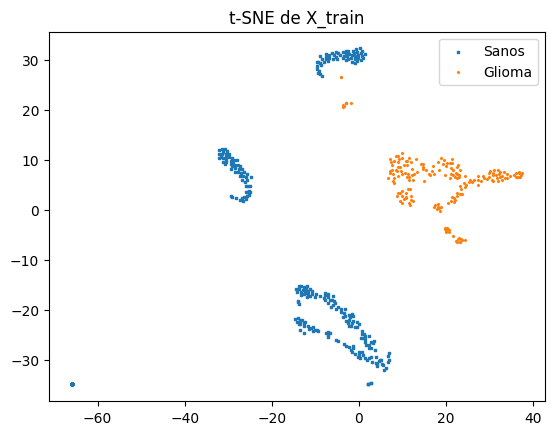

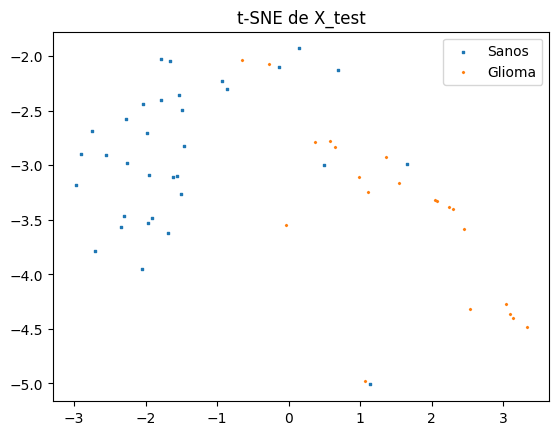

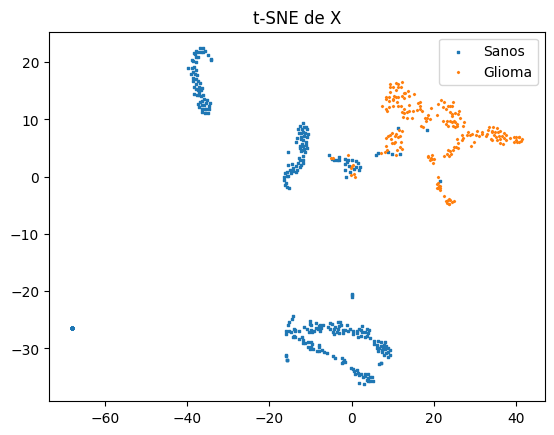

[I 2024-06-28 09:39:39,368] A new study created in memory with name: no-name-04a164b7-ecd7-45ec-879e-52b964c72245
[I 2024-06-28 09:39:39,410] Trial 4 finished with value: 0.5915492957746479 and parameters: {'C': 62.50617173475904}. Best is trial 4 with value: 0.5915492957746479.
[I 2024-06-28 09:39:39,419] Trial 2 finished with value: 0.84 and parameters: {'C': 0.5945221040162312}. Best is trial 2 with value: 0.84.
[I 2024-06-28 09:39:39,420] Trial 7 finished with value: 0.8076923076923077 and parameters: {'C': 1.1007655970933288}. Best is trial 2 with value: 0.84.
[I 2024-06-28 09:39:39,428] Trial 3 finished with value: 0.875 and parameters: {'C': 0.06503103197717125}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:39,434] Trial 11 finished with value: 0.5915492957746479 and parameters: {'C': 72.82153969410045}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:39,435] Trial 1 finished with value: 0.7222222222222222 and parameters: {'C': 0.0014092770269441052}. Best is tr

[I 2024-06-28 09:39:39,869] Trial 58 finished with value: 0.84 and parameters: {'C': 0.28713693126389533}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:39,870] Trial 57 finished with value: 0.7777777777777778 and parameters: {'C': 0.30618455466927197}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:39,880] Trial 53 finished with value: 0.7777777777777778 and parameters: {'C': 0.3838224432537644}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:39,886] Trial 68 finished with value: 0.84 and parameters: {'C': 0.22790704486710764}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:39,898] Trial 56 finished with value: 0.7777777777777778 and parameters: {'C': 0.3401307115143954}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:39,903] Trial 59 finished with value: 0.84 and parameters: {'C': 0.2804860209977425}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:39,905] Trial 61 finished with value: 0.84 and parameters: {'C': 0.2833209448769516}. Bes

[I 2024-06-28 09:39:40,285] Trial 108 finished with value: 0.84 and parameters: {'C': 0.9615988150642529}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:40,312] Trial 114 finished with value: 0.84 and parameters: {'C': 1.0745352171168316}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:40,316] Trial 113 finished with value: 0.84 and parameters: {'C': 0.9617845288731763}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:40,326] Trial 109 finished with value: 0.84 and parameters: {'C': 0.8183087951476478}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:40,332] Trial 116 finished with value: 0.84 and parameters: {'C': 0.9186400307895288}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:40,341] Trial 118 finished with value: 0.7924528301886793 and parameters: {'C': 1.1542192865397476}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:40,345] Trial 115 finished with value: 0.7924528301886793 and parameters: {'C': 1.1746952580151226}. Best is trial

[I 2024-06-28 09:39:40,769] Trial 166 finished with value: 0.8095238095238095 and parameters: {'C': 0.02439307612720271}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:40,772] Trial 167 finished with value: 0.8292682926829268 and parameters: {'C': 0.022285337599857753}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:40,788] Trial 168 finished with value: 0.8292682926829268 and parameters: {'C': 0.023507492441956546}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:40,791] Trial 170 finished with value: 0.8095238095238095 and parameters: {'C': 0.02448139841739603}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:40,794] Trial 171 finished with value: 0.8372093023255814 and parameters: {'C': 0.02617970221406752}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:40,805] Trial 169 finished with value: 0.8181818181818182 and parameters: {'C': 0.030521164725256508}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:40,809] Trial 172 finished with val

[I 2024-06-28 09:39:41,186] Trial 221 finished with value: 0.875 and parameters: {'C': 0.061842916795672435}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:41,200] Trial 222 finished with value: 0.875 and parameters: {'C': 0.06128428309287639}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:41,207] Trial 223 finished with value: 0.875 and parameters: {'C': 0.06521167290249517}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:41,210] Trial 225 finished with value: 0.875 and parameters: {'C': 0.06432910340456563}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:41,215] Trial 224 finished with value: 0.875 and parameters: {'C': 0.060668705716054226}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:41,246] Trial 227 finished with value: 0.875 and parameters: {'C': 0.06687689436208476}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:41,246] Trial 226 finished with value: 0.875 and parameters: {'C': 0.06213090647661142}. Best is trial 3 with valu

[I 2024-06-28 09:39:41,721] Trial 279 finished with value: 0.8571428571428571 and parameters: {'C': 0.07141976021066453}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:41,721] Trial 278 finished with value: 0.8571428571428571 and parameters: {'C': 0.07034498352388002}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:41,729] Trial 276 finished with value: 0.84 and parameters: {'C': 0.17772518859384512}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:41,730] Trial 282 finished with value: 0.8571428571428571 and parameters: {'C': 0.0715217386124018}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:41,738] Trial 281 finished with value: 0.8571428571428571 and parameters: {'C': 0.07133154609980719}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:41,742] Trial 280 finished with value: 0.8571428571428571 and parameters: {'C': 0.0677125648196286}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:41,770] Trial 283 finished with value: 0.8571428571428

[I 2024-06-28 09:39:42,250] Trial 332 finished with value: 0.851063829787234 and parameters: {'C': 0.048227219316800914}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:42,268] Trial 333 finished with value: 0.851063829787234 and parameters: {'C': 0.049607115501481565}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:42,295] Trial 334 finished with value: 0.851063829787234 and parameters: {'C': 0.050690044320469495}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:42,306] Trial 335 finished with value: 0.851063829787234 and parameters: {'C': 0.04901355194923234}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:42,309] Trial 336 finished with value: 0.851063829787234 and parameters: {'C': 0.049452880034129135}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:42,313] Trial 338 finished with value: 0.851063829787234 and parameters: {'C': 0.05011375718383385}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:42,316] Trial 337 finished with value: 0

[I 2024-06-28 09:39:42,824] Trial 388 finished with value: 0.851063829787234 and parameters: {'C': 0.057750825787452234}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:42,827] Trial 387 finished with value: 0.851063829787234 and parameters: {'C': 0.058233511392451705}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:42,846] Trial 389 finished with value: 0.851063829787234 and parameters: {'C': 0.05859404492147826}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:42,866] Trial 390 finished with value: 0.851063829787234 and parameters: {'C': 0.05544842033681751}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:42,870] Trial 392 finished with value: 0.851063829787234 and parameters: {'C': 0.05490179573096567}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:42,878] Trial 391 finished with value: 0.851063829787234 and parameters: {'C': 0.05630641568251973}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:42,914] Trial 394 finished with value: 0.8

[I 2024-06-28 09:39:43,424] Trial 443 finished with value: 0.875 and parameters: {'C': 0.06473871509553673}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:43,474] Trial 442 finished with value: 0.84 and parameters: {'C': 0.10609322528276614}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:43,479] Trial 445 finished with value: 0.84 and parameters: {'C': 0.109461129489988}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:43,486] Trial 446 finished with value: 0.84 and parameters: {'C': 0.1152413230152979}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:43,500] Trial 444 finished with value: 0.84 and parameters: {'C': 0.10229893226129466}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:43,503] Trial 450 finished with value: 0.84 and parameters: {'C': 0.10926519190990816}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:43,504] Trial 448 finished with value: 0.84 and parameters: {'C': 0.10168916577775397}. Best is trial 3 with value: 0.875.
[

[I 2024-06-28 09:39:43,992] Trial 496 finished with value: 0.851063829787234 and parameters: {'C': 0.05386135363629908}. Best is trial 3 with value: 0.875.
[I 2024-06-28 09:39:43,999] Trial 499 finished with value: 0.851063829787234 and parameters: {'C': 0.05268401241860466}. Best is trial 3 with value: 0.875.


Best Threshold=0.999999
Confusion Matrix:
[[27  6]
 [ 0 21]]
Recall for class 0: 0.8181818181818182
Recall for class 1: 1.0
Accuracy: 0.8888888888888888
F1 Score: 0.875

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.82      0.90        33
           1       0.78      1.00      0.88        21

    accuracy                           0.89        54
   macro avg       0.89      0.91      0.89        54
weighted avg       0.91      0.89      0.89        54



Training set - healthy: 297 glioma: 297
Test set - healthy: 33 glioma: 21


In [56]:
def objective(trial, X_train, y_train, X_test, y_test):
    C = trial.suggest_float("C", 1e-3, 1e2, log=True)
    clf = SVC(C=C, kernel="rbf", random_state=42)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return f1_score(y_test, y_pred)

def classificate(mse_train_common, mse_test_common, 
                 mse_glioma_train_common, mse_glioma_test_common,
                 logl_train_common, logl_test_common,
                 logl_glioma_train_common, logl_glioma_test_commo):
    
    X_healthy_train, X_glioma_train, X_healthy_test, X_glioma_test = [], [], [], []
    
    for i, MRI_type in enumerate(["T1", "FLAIR"]):
        # Paso 1: Aplanamos las listas para que no estén separadas por fold
        MSE_healthy_train_common_f = [elemento for sublista in mse_train_common[i] for elemento in sublista]
        MSE_healthy_test_common_f = [elemento for sublista in mse_test_common[i] for elemento in sublista]
        MSE_glioma_train_common_f = [elemento for sublista in mse_glioma_train_common[i] for elemento in sublista]
        MSE_glioma_test_common_f = [elemento for sublista in mse_glioma_test_common[i] for elemento in sublista]

        LOGL_healthy_train_common_f = [elemento for sublista in logl_train_common[i] for elemento in sublista]
        LOGL_healthy_test_common_f = [elemento for sublista in logl_test_common[i] for elemento in sublista]
        LOGL_glioma_train_common_f = [elemento for sublista in logl_glioma_train_common[i] for elemento in sublista]
        LOGL_glioma_test_common_f = [elemento for sublista in logl_glioma_test_common[i] for elemento in sublista]
        
        # Queremos generar una matriz que contenga en cada fila los valores de un paciente: 
        # [MSE_T1, LOGL_T1, MSE_T2, LOGL_T2, MSE_FLAIR, LOGL_FLAIR]
        
        # Longitud 33, porque hay 33 pacientes, cada sublista contiene los 6 valores de arriba
        for j in range(len(MSE_healthy_train_common_f)):
            if i == 0: # Si estamos en el primer tipo de MRI creamos una lista, sino añadimos a la lista
                X_healthy_train.append([MSE_healthy_train_common_f[j], LOGL_healthy_train_common_f[j]])
            else: # Concatenamos los valores que ya había de ese paciente con los del siguiente tipo MRI
                X_healthy_train[j] = X_healthy_train[j] + [MSE_healthy_train_common_f[j], LOGL_healthy_train_common_f[j]]
                
        for j in range(len(MSE_healthy_test_common_f)):
            if i == 0: # Si estamos en el primer tipo de MRI creamos una lista, sino añadimos a la lista
                X_healthy_test.append([MSE_healthy_test_common_f[j], LOGL_healthy_test_common_f[j]])
            else: # Concatenamos los valores que ya había de ese paciente con los del siguiente tipo MRI
                X_healthy_test[j] = X_healthy_test[j] + [MSE_healthy_test_common_f[j], LOGL_healthy_test_common_f[j]]
                
        for j in range(len(MSE_glioma_train_common_f)):
            if i == 0: # Si estamos en el primer tipo de MRI creamos una lista, sino añadimos a la lista
                X_glioma_train.append([MSE_glioma_train_common_f[j], LOGL_glioma_train_common_f[j]])
            else: # Concatenamos los valores que ya había de ese paciente con los del siguiente tipo MRI
                X_glioma_train[j] = X_glioma_train[j] + [MSE_glioma_train_common_f[j], LOGL_glioma_train_common_f[j]]
                
        for j in range(len(MSE_glioma_test_common_f)):
            if i == 0: # Si estamos en el primer tipo de MRI creamos una lista, sino añadimos a la lista
                X_glioma_test.append([MSE_glioma_test_common_f[j], LOGL_glioma_test_common_f[j]])
            else: # Concatenamos los valores que ya había de ese paciente con los del siguiente tipo MRI
                X_glioma_test[j] = X_glioma_test[j] + [MSE_glioma_test_common_f[j], LOGL_glioma_test_common_f[j]]
        
    y_train = [0] * len(X_healthy_train) + [1] * len(X_glioma_train)
    X_train = X_healthy_train + X_glioma_train
    y_test = [0] * len(X_healthy_test) + [1] * len(X_glioma_test)
    X_test = X_healthy_test + X_glioma_test
    
    # Visualizamos X_train para ver como los espacios de 6 valores de sanos y gliomas se distribuyen
    tsne = TSNE(n_components=2)
    X_2D = tsne.fit_transform(np.array(X_train))
    
    plt.figure()    
    # Graficar cuadrados para la clase 0 (Sanos)
    plt.scatter(X_2D[np.array(y_train) == 0, 0], X_2D[np.array(y_train) == 0, 1], 
                marker='s', s=2, label='Sanos')
    
    # Graficar cruces para la clase 1 (Glioma)
    plt.scatter(X_2D[np.array(y_train) == 1, 0], X_2D[np.array(y_train) == 1, 1], 
                marker='x', s=2, label='Glioma')
    
    plt.title('t-SNE de X_train')
    plt.legend()
    plt.show()
    
    # Visualizamos X_test para ver como los espacios de 6 valores de sanos y gliomas se distribuyen
    tsne = TSNE(n_components=2)
    X_2D = tsne.fit_transform(np.array(X_test))

    plt.figure()    
    # Graficar cuadrados para la clase 0 (Sanos)
    plt.scatter(X_2D[np.array(y_test) == 0, 0], X_2D[np.array(y_test) == 0, 1], 
                marker='s', s=2, label='Sanos')
    
    # Graficar cruces para la clase 1 (Glioma)
    plt.scatter(X_2D[np.array(y_test) == 1, 0], X_2D[np.array(y_test) == 1, 1], 
                marker='x', s=2, label='Glioma')
    
    plt.title('t-SNE de X_test')
    plt.legend()
    plt.show()
    
    # Visualizamos todo X para ver como los espacios de 6 valores de sanos y gliomas se distribuyen
    tsne = TSNE(n_components=2)
    X_2D = tsne.fit_transform(np.array(X_train + X_test))

    plt.figure()    
    # Graficar cuadrados para la clase 0 (Sanos)
    plt.scatter(X_2D[np.array(y_train+y_test) == 0, 0], X_2D[np.array(y_train+y_test) == 0, 1], 
                marker='s', s=2, label='Sanos')
    
    # Graficar cruces para la clase 1 (Glioma)
    plt.scatter(X_2D[np.array(y_train+y_test) == 1, 0], X_2D[np.array(y_train+y_test) == 1, 1], 
                marker='x', s=2, label='Glioma')
    
    plt.title('t-SNE de X')
    plt.legend()
    plt.show()
    
    # Aplicar SMOTE
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, X_train_res, y_train_res, X_test, y_test), n_trials=500, n_jobs=-1)

    # Inicializamos el clasificador con los mejores parámetros
    best_clf = SVC(**study.best_params, probability=True, random_state=42)
    best_clf.fit(X_train_res, y_train_res)

    # Hacemos predicciones
    y_prob = best_clf.predict_proba(X_test)[:, 1]

    # Calcular la curva ROC y encontrar el umbral óptimo
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    J = tpr - fpr
    ix = np.argmax(J)
    best_threshold = thresholds[ix]
    print('Best Threshold=%f' % best_threshold)

    # Hacer predicciones usando el umbral óptimo
    y_pred_opt = (y_prob >= best_threshold).astype(int)

    # Paso 5: Evaluar el modelo
    conf_matrix = confusion_matrix(y_test, y_pred_opt)
    accuracy = accuracy_score(y_test, y_pred_opt)
    f1 = f1_score(y_test, y_pred_opt)
    recall_per_class = recall_score(y_test, y_pred_opt, average=None)
    class_report = classification_report(y_test, y_pred_opt)

    # Imprimir resultados
    print("Confusion Matrix:")
    print(conf_matrix)
    for j, recall in enumerate(recall_per_class):
        print(f"Recall for class {j}: {recall}")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print("\nClassification Report:\n", class_report)
    print("\n")

    print("Training set - healthy:", y_train_res.count(0), "glioma:", y_train_res.count(1))
    print("Test set - healthy:", y_test.count(0), "glioma:", y_test.count(1))


mse_train_common2 = [mse_train_common_T1, mse_train_common_FLAIR]
logl_train_common2 = [logl_train_common_T1, logl_train_common_FLAIR]
mse_test_common2 = [mse_test_common_T1, mse_test_common_FLAIR]
logl_test_common2 = [logl_test_common_T1, logl_test_common_FLAIR]

mse_glioma_train_common2 = [mse_glioma_train_common_T1, mse_glioma_train_common_FLAIR]
logl_glioma_train_common2 = [logl_glioma_train_common_T1, logl_glioma_train_common_FLAIR]
mse_glioma_test_common2 = [mse_glioma_test_common_T1, mse_glioma_test_common_FLAIR]
logl_glioma_test_common2 = [logl_glioma_test_common_T1, logl_glioma_test_common_FLAIR]

classificate(mse_train_common2, mse_test_common2, mse_glioma_train_common2, mse_glioma_test_common2, logl_train_common2,
             logl_test_common2, logl_glioma_train_common2, logl_glioma_test_common2)

### SVM CON KERNEL RBF CON SMOTE POR FOLD

In [58]:
num_folds = 10

accuracies = []
recalls_0 = []
recalls_1 = []
f1_scores = []

def objective(trial, X_train, y_train, X_test, y_test):
    C = trial.suggest_float("C", 1e-3, 1e2, log=True)
    clf = SVC(C=C, kernel="rbf", class_weight="balanced", probability=True, random_state=42)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return f1_score(y_test, y_pred)

def classificate(mse_train, mse_test, mse_glioma_train, mse_glioma_test, logl_train, logl_test, logl_glioma_train,
                 logl_glioma_test):
    
    for i, MRI_type in enumerate(["T1", "T2", "FLAIR"]):
        accuracy_MRI = []
        recall_0_MRI = []
        recall_1_MRI = []
        f1_score_MRI = []

        for fold_index in range(num_folds):
            # Obtenemos los resultados de cada fold
            mse_train_fold = mse_train[i][fold_index]
            logl_train_fold = logl_train[i][fold_index]

            mse_test_fold = mse_test[i][fold_index]
            logl_test_fold = logl_test[i][fold_index]

            mse_glioma_train_fold = mse_glioma_train[i][fold_index]
            logl_glioma_train_fold = logl_glioma_train[i][fold_index]

            mse_glioma_test_fold = mse_glioma_test[i][fold_index]
            logl_glioma_test_fold = logl_glioma_test[i][fold_index]

            # Los guardamos en listas healthy o glioma, en función de la clase
            X_train_healthy = list(zip(mse_train_fold, logl_train_fold))
            X_train_glioma = list(zip(mse_glioma_train_fold, logl_glioma_train_fold))
            
            # En base a las listas anteriores podemos definir las etiquetas de y
            X_train = X_train_healthy + X_train_glioma
            y_train = [0] * len(X_train_healthy) + [1] * len(X_train_glioma)

            X_test_healthy = list(zip(mse_test_fold, logl_test_fold))
            X_test_glioma = list(zip(mse_glioma_test_fold, logl_glioma_test_fold))

            X_test = X_test_healthy + X_test_glioma
            y_test = [0] * len(X_test_healthy) + [1] * len(X_test_glioma)
            
            # Aplicar SMOTE
#             sm = SMOTE(random_state=42)
#             X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
            
            # Empleamos Optuna para optimizar parámetros del clasificador
            study = optuna.create_study(direction="maximize")
            study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=100, n_jobs=-1)

            print(f"Best parameters for MRI type {MRI_type}: {study.best_params}")
            
            # Inicializamos el clasificador con los mejores parámetros
            best_clf = SVC(**study.best_params, class_weight="balanced", probability=True, random_state=42)
            best_clf.fit(X_train, y_train)
            
            # Hacemos predicciones
            y_prob = best_clf.predict_proba(X_test)[:, 1]

            # Calcular la curva ROC y encontrar el umbral óptimo
            fpr, tpr, thresholds = roc_curve(y_test, y_prob)
            J = tpr - fpr
            ix = np.argmax(J)
            best_threshold = thresholds[ix]
            print('Best Threshold ROC =',best_threshold)

            precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

            f1_s = 2 * (precision * recall) / (precision + recall)
            best_index = np.argmax(f1_s)
            best_threshold = thresholds[best_index]
            print('Best Threshold PR =', best_threshold)

            # Hacer predicciones usando el umbral óptimo
            y_pred_opt = (y_prob >= best_threshold).astype(int)

            # Evaluar el modelo
            conf_matrix = confusion_matrix(y_test, y_pred_opt)
            accuracy = accuracy_score(y_test, y_pred_opt)
            accuracy_MRI.append(accuracy)
            f1 = f1_score(y_test, y_pred_opt)
            f1_score_MRI.append(f1)
            recall_per_class = recall_score(y_test, y_pred_opt, average=None)
            recall_0_MRI.append(recall_per_class[0])
            recall_1_MRI.append(recall_per_class[1])

            # Imprimir resultados
            print("Resultados para Tipo MRI:", MRI_type + " y fold " + str(fold_index) + "\n")
            print("Confusion Matrix:")
            print(conf_matrix)
            for j, recall in enumerate(recall_per_class):
                print(f"Recall for class {j}: {recall}")
            print(f"Accuracy: {accuracy}")
            print(f"F1 Score: {f1}")
            print("\n")
        
        accuracies.append(accuracy_MRI)
        f1_scores.append(f1_score_MRI)
        recalls_0.append(recall_0_MRI)
        recalls_1.append(recall_1_MRI)

classificate(mse_train, mse_test, mse_glioma_train, mse_glioma_test, loglikelihoods_train, loglikelihoods_test,
             loglikelihoods_glioma_train, loglikelihoods_glioma_test)
for i, MRI_type in enumerate(["T1", "T2", "FLAIR"]):
    print("Media de Accuracy en "+str(MRI_type)+":", np.mean(np.array(accuracies[i])))
    print("Media de Recall clase 0 en "+str(MRI_type)+":", np.mean(np.array(recalls_0[i])))
    print("Media de Recall clase 1 en "+str(MRI_type)+":", np.mean(np.array(recalls_1[i])))
    print("Media de F1-Score en "+str(MRI_type)+":", np.mean(np.array(f1_scores[i])))
    
    print("STD de Accuracy en "+str(MRI_type)+":", np.std(np.array(accuracies[i])))
    print("STD de Recall clase 0 en "+str(MRI_type)+":", np.std(np.array(recalls_0[i])))
    print("STD de Recall clase 1 en "+str(MRI_type)+":", np.std(np.array(recalls_1[i])))
    print("STD de F1-Score en "+str(MRI_type)+":", np.std(np.array(f1_scores[i])))
    print("\n")


[I 2024-06-28 09:47:45,543] A new study created in memory with name: no-name-67fd35e3-9a4b-4503-b2e2-71161c044674
[I 2024-06-28 09:47:45,689] Trial 12 finished with value: 0.8275862068965517 and parameters: {'C': 1.5125414163524888}. Best is trial 12 with value: 0.8275862068965517.
[I 2024-06-28 09:47:45,704] Trial 10 finished with value: 0.7741935483870968 and parameters: {'C': 6.304695312290959}. Best is trial 12 with value: 0.8275862068965517.
[I 2024-06-28 09:47:45,706] Trial 32 finished with value: 0.0 and parameters: {'C': 0.002276936547592877}. Best is trial 12 with value: 0.8275862068965517.
[I 2024-06-28 09:47:45,708] Trial 27 finished with value: 0.0 and parameters: {'C': 0.0020998787290785457}. Best is trial 12 with value: 0.8275862068965517.
[I 2024-06-28 09:47:45,710] Trial 29 finished with value: 0.7058823529411765 and parameters: {'C': 62.0770569543539}. Best is trial 12 with value: 0.8275862068965517.
[I 2024-06-28 09:47:45,714] Trial 30 finished with value: 0.774193548

[I 2024-06-28 09:47:45,942] Trial 53 finished with value: 0.8571428571428571 and parameters: {'C': 1.2337593022443438}. Best is trial 31 with value: 0.8571428571428571.
[I 2024-06-28 09:47:45,953] Trial 52 finished with value: 0.8275862068965517 and parameters: {'C': 1.3735237903153308}. Best is trial 31 with value: 0.8571428571428571.
[I 2024-06-28 09:47:45,957] Trial 48 finished with value: 0.8571428571428571 and parameters: {'C': 1.266622865742834}. Best is trial 31 with value: 0.8571428571428571.
[I 2024-06-28 09:47:45,957] Trial 51 finished with value: 0.8571428571428571 and parameters: {'C': 1.2633871116239732}. Best is trial 31 with value: 0.8571428571428571.
[I 2024-06-28 09:47:45,984] Trial 54 finished with value: 0.8571428571428571 and parameters: {'C': 1.2838200843949665}. Best is trial 31 with value: 0.8571428571428571.
[I 2024-06-28 09:47:45,997] Trial 56 finished with value: 0.8275862068965517 and parameters: {'C': 1.4612646231162798}. Best is trial 31 with value: 0.85714

[I 2024-06-28 09:47:46,410] Trial 1 finished with value: 0.7058823529411765 and parameters: {'C': 19.010874052372525}. Best is trial 1 with value: 0.7058823529411765.
[I 2024-06-28 09:47:46,413] Trial 0 finished with value: 0.7741935483870968 and parameters: {'C': 0.015691936448104894}. Best is trial 0 with value: 0.7741935483870968.
[I 2024-06-28 09:47:46,416] Trial 3 finished with value: 0.7741935483870968 and parameters: {'C': 0.6451727227084623}. Best is trial 0 with value: 0.7741935483870968.
[I 2024-06-28 09:47:46,419] Trial 4 finished with value: 0.0 and parameters: {'C': 0.0048640555268716365}. Best is trial 0 with value: 0.7741935483870968.
[I 2024-06-28 09:47:46,419] Trial 2 finished with value: 0.7333333333333333 and parameters: {'C': 0.2261921384857269}. Best is trial 0 with value: 0.7741935483870968.
[I 2024-06-28 09:47:46,427] Trial 6 finished with value: 0.7333333333333333 and parameters: {'C': 0.15428226929309585}. Best is trial 0 with value: 0.7741935483870968.
[I 2024

Best parameters for MRI type T1: {'C': 1.1177417088690111}
Best Threshold ROC = 0.964919008390326
Best Threshold PR = 0.964919008390326
Resultados para Tipo MRI: T1 y fold 0

Confusion Matrix:
[[ 6  4]
 [ 0 12]]
Recall for class 0: 0.6
Recall for class 1: 1.0
Accuracy: 0.8181818181818182
F1 Score: 0.8571428571428571




[I 2024-06-28 09:47:46,549] Trial 19 finished with value: 0.7741935483870968 and parameters: {'C': 1.2373543042999693}. Best is trial 0 with value: 0.7741935483870968.
[I 2024-06-28 09:47:46,551] Trial 18 finished with value: 0.7741935483870968 and parameters: {'C': 2.311077587015375}. Best is trial 0 with value: 0.7741935483870968.
[I 2024-06-28 09:47:46,569] Trial 20 finished with value: 0.7741935483870968 and parameters: {'C': 1.5214795752427133}. Best is trial 0 with value: 0.7741935483870968.
[I 2024-06-28 09:47:46,586] Trial 22 finished with value: 0.7741935483870968 and parameters: {'C': 2.0513259330248768}. Best is trial 0 with value: 0.7741935483870968.
[I 2024-06-28 09:47:46,591] Trial 21 finished with value: 0.7741935483870968 and parameters: {'C': 2.689660576277513}. Best is trial 0 with value: 0.7741935483870968.
[I 2024-06-28 09:47:46,611] Trial 26 finished with value: 0.7741935483870968 and parameters: {'C': 1.331970959798343}. Best is trial 0 with value: 0.7741935483870

[I 2024-06-28 09:47:47,040] Trial 73 finished with value: 0.75 and parameters: {'C': 6.325852126614607}. Best is trial 0 with value: 0.7741935483870968.
[I 2024-06-28 09:47:47,042] Trial 68 finished with value: 0.75 and parameters: {'C': 8.504857122355101}. Best is trial 0 with value: 0.7741935483870968.
[I 2024-06-28 09:47:47,057] Trial 69 finished with value: 0.7272727272727273 and parameters: {'C': 11.109260175507345}. Best is trial 0 with value: 0.7741935483870968.
[I 2024-06-28 09:47:47,129] Trial 70 finished with value: 0.75 and parameters: {'C': 5.592422103415617}. Best is trial 0 with value: 0.7741935483870968.
[I 2024-06-28 09:47:47,142] Trial 72 finished with value: 0.7272727272727273 and parameters: {'C': 12.509762094211178}. Best is trial 0 with value: 0.7741935483870968.
[I 2024-06-28 09:47:47,143] Trial 78 finished with value: 0.75 and parameters: {'C': 8.25151439426885}. Best is trial 0 with value: 0.7741935483870968.
[I 2024-06-28 09:47:47,144] Trial 71 finished with va

Best parameters for MRI type T1: {'C': 0.015691936448104894}
Best Threshold ROC = 0.6805527640697687
Best Threshold PR = 0.6805527640697687
Resultados para Tipo MRI: T1 y fold 1

Confusion Matrix:
[[9 1]
 [3 9]]
Recall for class 0: 0.9
Recall for class 1: 0.75
Accuracy: 0.8181818181818182
F1 Score: 0.8181818181818182




[I 2024-06-28 09:47:47,457] Trial 21 finished with value: 0.0 and parameters: {'C': 0.0013722603497581078}. Best is trial 13 with value: 1.0.
[I 2024-06-28 09:47:47,463] Trial 22 finished with value: 0.0 and parameters: {'C': 0.0013366821722178416}. Best is trial 13 with value: 1.0.
[I 2024-06-28 09:47:47,470] Trial 23 finished with value: 0.0 and parameters: {'C': 0.0010166578154372692}. Best is trial 13 with value: 1.0.
[I 2024-06-28 09:47:47,503] Trial 25 finished with value: 0.0 and parameters: {'C': 0.0022685927057002823}. Best is trial 13 with value: 1.0.
[I 2024-06-28 09:47:47,504] Trial 24 finished with value: 0.0 and parameters: {'C': 0.0010878545512540384}. Best is trial 13 with value: 1.0.
[I 2024-06-28 09:47:47,507] Trial 26 finished with value: 0.7058823529411765 and parameters: {'C': 0.004164006293881521}. Best is trial 13 with value: 1.0.
[I 2024-06-28 09:47:47,511] Trial 27 finished with value: 0.0 and parameters: {'C': 0.0012287424649576625}. Best is trial 13 with valu

[I 2024-06-28 09:47:48,004] Trial 74 finished with value: 0.9230769230769231 and parameters: {'C': 0.058851666926164364}. Best is trial 13 with value: 1.0.
[I 2024-06-28 09:47:48,006] Trial 82 finished with value: 0.9230769230769231 and parameters: {'C': 0.05579441952181361}. Best is trial 13 with value: 1.0.
[I 2024-06-28 09:47:48,013] Trial 81 finished with value: 0.9230769230769231 and parameters: {'C': 0.04608089172813391}. Best is trial 13 with value: 1.0.
[I 2024-06-28 09:47:48,013] Trial 73 finished with value: 0.9230769230769231 and parameters: {'C': 0.05635532413119533}. Best is trial 13 with value: 1.0.
[I 2024-06-28 09:47:48,018] Trial 80 finished with value: 0.9230769230769231 and parameters: {'C': 0.05199561557338691}. Best is trial 13 with value: 1.0.
[I 2024-06-28 09:47:48,040] Trial 88 finished with value: 0.9230769230769231 and parameters: {'C': 0.054929221741357975}. Best is trial 13 with value: 1.0.
[I 2024-06-28 09:47:48,042] Trial 84 finished with value: 0.92307692

Best parameters for MRI type T1: {'C': 0.027028384872039374}
Best Threshold ROC = 0.9475119111472189
Best Threshold PR = 0.9475119111472189
Resultados para Tipo MRI: T1 y fold 2

Confusion Matrix:
[[10  0]
 [ 0 12]]
Recall for class 0: 1.0
Recall for class 1: 1.0
Accuracy: 1.0
F1 Score: 1.0




[I 2024-06-28 09:47:48,282] Trial 24 finished with value: 0.7272727272727273 and parameters: {'C': 0.0385256064808163}. Best is trial 2 with value: 0.7272727272727273.
[I 2024-06-28 09:47:48,284] Trial 25 finished with value: 0.7272727272727273 and parameters: {'C': 0.05158296507324771}. Best is trial 2 with value: 0.7272727272727273.
[I 2024-06-28 09:47:48,284] Trial 23 finished with value: 0.0 and parameters: {'C': 0.002186480427167388}. Best is trial 2 with value: 0.7272727272727273.
[I 2024-06-28 09:47:48,319] Trial 26 finished with value: 0.7272727272727273 and parameters: {'C': 0.05990646383282114}. Best is trial 2 with value: 0.7272727272727273.
[I 2024-06-28 09:47:48,355] Trial 27 finished with value: 0.6956521739130435 and parameters: {'C': 0.0844556293973847}. Best is trial 2 with value: 0.7272727272727273.
[I 2024-06-28 09:47:48,371] Trial 30 finished with value: 0.7272727272727273 and parameters: {'C': 0.04225984001222269}. Best is trial 2 with value: 0.7272727272727273.
[I

[I 2024-06-28 09:47:48,829] Trial 71 finished with value: 0.7058823529411765 and parameters: {'C': 0.006651507088419798}. Best is trial 2 with value: 0.7272727272727273.
[I 2024-06-28 09:47:48,837] Trial 81 finished with value: 0.0 and parameters: {'C': 0.0074115227983546144}. Best is trial 2 with value: 0.7272727272727273.
[I 2024-06-28 09:47:48,841] Trial 78 finished with value: 0.0 and parameters: {'C': 0.006981935383659391}. Best is trial 2 with value: 0.7272727272727273.
[I 2024-06-28 09:47:48,846] Trial 74 finished with value: 0.7058823529411765 and parameters: {'C': 0.004591416176320391}. Best is trial 2 with value: 0.7272727272727273.
[I 2024-06-28 09:47:48,847] Trial 76 finished with value: 0.7058823529411765 and parameters: {'C': 0.0045992417101050264}. Best is trial 2 with value: 0.7272727272727273.
[I 2024-06-28 09:47:48,855] Trial 79 finished with value: 0.0 and parameters: {'C': 0.00583066438168759}. Best is trial 2 with value: 0.7272727272727273.
[I 2024-06-28 09:47:48,8

Best parameters for MRI type T1: {'C': 0.04605555780487111}
Best Threshold ROC = 0.9999999999240519
Best Threshold PR = 0.3710760042907882
Resultados para Tipo MRI: T1 y fold 3

Confusion Matrix:
[[ 1  9]
 [ 0 12]]
Recall for class 0: 0.1
Recall for class 1: 1.0
Accuracy: 0.5909090909090909
F1 Score: 0.7272727272727273




[I 2024-06-28 09:47:49,151] Trial 21 finished with value: 0.7741935483870968 and parameters: {'C': 5.773095966261733}. Best is trial 3 with value: 0.8275862068965517.
[I 2024-06-28 09:47:49,181] Trial 22 finished with value: 0.8275862068965517 and parameters: {'C': 4.4592549345326935}. Best is trial 3 with value: 0.8275862068965517.
[I 2024-06-28 09:47:49,185] Trial 23 finished with value: 0.8275862068965517 and parameters: {'C': 3.479284591229672}. Best is trial 3 with value: 0.8275862068965517.
[I 2024-06-28 09:47:49,195] Trial 24 finished with value: 0.8275862068965517 and parameters: {'C': 4.23527647544448}. Best is trial 3 with value: 0.8275862068965517.
[I 2024-06-28 09:47:49,213] Trial 25 finished with value: 0.8275862068965517 and parameters: {'C': 5.149059863791327}. Best is trial 3 with value: 0.8275862068965517.
[I 2024-06-28 09:47:49,240] Trial 26 finished with value: 0.8275862068965517 and parameters: {'C': 4.0379133861819945}. Best is trial 3 with value: 0.827586206896551

[I 2024-06-28 09:47:49,648] Trial 75 finished with value: 0.8275862068965517 and parameters: {'C': 2.1723290184945907}. Best is trial 3 with value: 0.8275862068965517.
[I 2024-06-28 09:47:49,657] Trial 74 finished with value: 0.8275862068965517 and parameters: {'C': 2.238220402858582}. Best is trial 3 with value: 0.8275862068965517.
[I 2024-06-28 09:47:49,658] Trial 77 finished with value: 0.8275862068965517 and parameters: {'C': 2.0689971149091653}. Best is trial 3 with value: 0.8275862068965517.
[I 2024-06-28 09:47:49,660] Trial 73 finished with value: 0.8275862068965517 and parameters: {'C': 1.6870349833696778}. Best is trial 3 with value: 0.8275862068965517.
[I 2024-06-28 09:47:49,667] Trial 70 finished with value: 0.8275862068965517 and parameters: {'C': 2.3532443399643976}. Best is trial 3 with value: 0.8275862068965517.
[I 2024-06-28 09:47:49,677] Trial 76 finished with value: 0.8275862068965517 and parameters: {'C': 1.9897791701128673}. Best is trial 3 with value: 0.82758620689

[I 2024-06-28 09:47:50,022] Trial 21 finished with value: 0.75 and parameters: {'C': 80.44039265082442}. Best is trial 2 with value: 0.7741935483870968.
[I 2024-06-28 09:47:50,030] Trial 19 finished with value: 0.7333333333333333 and parameters: {'C': 1.3407535242996083}. Best is trial 2 with value: 0.7741935483870968.


Best parameters for MRI type T1: {'C': 4.544735189468521}
Best Threshold ROC = 0.9912398357498596
Best Threshold PR = 0.9556457957640202
Resultados para Tipo MRI: T1 y fold 4

Confusion Matrix:
[[ 5  5]
 [ 0 12]]
Recall for class 0: 0.5
Recall for class 1: 1.0
Accuracy: 0.7727272727272727
F1 Score: 0.8275862068965517




[I 2024-06-28 09:47:50,047] Trial 23 finished with value: 0.75 and parameters: {'C': 78.62400903262719}. Best is trial 2 with value: 0.7741935483870968.
[I 2024-06-28 09:47:50,060] Trial 22 finished with value: 0.7741935483870968 and parameters: {'C': 1.9406981178333074}. Best is trial 2 with value: 0.7741935483870968.
[I 2024-06-28 09:47:50,069] Trial 26 finished with value: 0.7333333333333333 and parameters: {'C': 1.6469401263952077}. Best is trial 2 with value: 0.7741935483870968.
[I 2024-06-28 09:47:50,069] Trial 24 finished with value: 0.7333333333333333 and parameters: {'C': 1.7002398563627157}. Best is trial 2 with value: 0.7741935483870968.
[I 2024-06-28 09:47:50,078] Trial 25 finished with value: 0.7142857142857143 and parameters: {'C': 0.974575601070924}. Best is trial 2 with value: 0.7741935483870968.
[I 2024-06-28 09:47:50,090] Trial 28 finished with value: 0.7741935483870968 and parameters: {'C': 2.093276054789122}. Best is trial 2 with value: 0.7741935483870968.
[I 2024-0

[I 2024-06-28 09:47:50,549] Trial 74 finished with value: 0.7741935483870968 and parameters: {'C': 5.418802955075689}. Best is trial 2 with value: 0.7741935483870968.
[I 2024-06-28 09:47:50,557] Trial 72 finished with value: 0.7741935483870968 and parameters: {'C': 5.739663009781325}. Best is trial 2 with value: 0.7741935483870968.
[I 2024-06-28 09:47:50,558] Trial 76 finished with value: 0.7741935483870968 and parameters: {'C': 6.7362694000053205}. Best is trial 2 with value: 0.7741935483870968.
[I 2024-06-28 09:47:50,559] Trial 73 finished with value: 0.7741935483870968 and parameters: {'C': 5.347718047946939}. Best is trial 2 with value: 0.7741935483870968.
[I 2024-06-28 09:47:50,564] Trial 78 finished with value: 0.7741935483870968 and parameters: {'C': 5.58024449184294}. Best is trial 2 with value: 0.7741935483870968.
[I 2024-06-28 09:47:50,586] Trial 77 finished with value: 0.7741935483870968 and parameters: {'C': 5.484687879615592}. Best is trial 2 with value: 0.7741935483870968

Best parameters for MRI type T1: {'C': 2.3894487528784545}
Best Threshold ROC = 0.9999999882204812
Best Threshold PR = 0.6737197331410419
Resultados para Tipo MRI: T1 y fold 5

Confusion Matrix:
[[ 3  7]
 [ 0 12]]
Recall for class 0: 0.3
Recall for class 1: 1.0
Accuracy: 0.6818181818181818
F1 Score: 0.7741935483870968




[I 2024-06-28 09:47:50,887] Trial 21 finished with value: 0.8 and parameters: {'C': 0.39191887791445273}. Best is trial 16 with value: 0.8461538461538461.
[I 2024-06-28 09:47:50,900] Trial 23 finished with value: 0.8 and parameters: {'C': 0.6662557316284328}. Best is trial 16 with value: 0.8461538461538461.
[I 2024-06-28 09:47:50,906] Trial 22 finished with value: 0.8 and parameters: {'C': 0.45356470436132645}. Best is trial 16 with value: 0.8461538461538461.
[I 2024-06-28 09:47:50,922] Trial 24 finished with value: 0.8 and parameters: {'C': 0.6349529230152486}. Best is trial 16 with value: 0.8461538461538461.
[I 2024-06-28 09:47:50,923] Trial 25 finished with value: 0.8 and parameters: {'C': 0.6147993823782164}. Best is trial 16 with value: 0.8461538461538461.
[I 2024-06-28 09:47:50,925] Trial 26 finished with value: 0.8333333333333334 and parameters: {'C': 0.10003057392204376}. Best is trial 16 with value: 0.8461538461538461.
[I 2024-06-28 09:47:50,964] Trial 27 finished with value: 

[I 2024-06-28 09:47:51,334] Trial 72 finished with value: 0.8333333333333334 and parameters: {'C': 0.13619884522823128}. Best is trial 16 with value: 0.8461538461538461.
[I 2024-06-28 09:47:51,345] Trial 70 finished with value: 0.8333333333333334 and parameters: {'C': 0.12430123777877308}. Best is trial 16 with value: 0.8461538461538461.
[I 2024-06-28 09:47:51,346] Trial 74 finished with value: 0.8333333333333334 and parameters: {'C': 0.1356923560798951}. Best is trial 16 with value: 0.8461538461538461.
[I 2024-06-28 09:47:51,347] Trial 75 finished with value: 0.8333333333333334 and parameters: {'C': 0.11702295264665397}. Best is trial 16 with value: 0.8461538461538461.
[I 2024-06-28 09:47:51,349] Trial 67 finished with value: 0.8333333333333334 and parameters: {'C': 0.09968458958368599}. Best is trial 16 with value: 0.8461538461538461.
[I 2024-06-28 09:47:51,354] Trial 73 finished with value: 0.8461538461538461 and parameters: {'C': 2.49073215573918}. Best is trial 16 with value: 0.84

Best parameters for MRI type T1: {'C': 2.180225617169933}
Best Threshold ROC = 0.9283901357827643
Best Threshold PR = 0.9283901357827643
Resultados para Tipo MRI: T1 y fold 6

Confusion Matrix:
[[ 7  3]
 [ 1 11]]
Recall for class 0: 0.7
Recall for class 1: 0.9166666666666666
Accuracy: 0.8181818181818182
F1 Score: 0.8461538461538461




[I 2024-06-28 09:47:51,570] Trial 3 finished with value: 0.7058823529411765 and parameters: {'C': 0.007880290969553049}. Best is trial 1 with value: 0.8.
[I 2024-06-28 09:47:51,571] Trial 7 finished with value: 0.7857142857142857 and parameters: {'C': 0.649301070553766}. Best is trial 1 with value: 0.8.
[I 2024-06-28 09:47:51,571] Trial 10 finished with value: 0.7857142857142857 and parameters: {'C': 2.4696848407201366}. Best is trial 1 with value: 0.8.
[I 2024-06-28 09:47:51,572] Trial 11 finished with value: 0.7058823529411765 and parameters: {'C': 14.536193660506305}. Best is trial 1 with value: 0.8.
[I 2024-06-28 09:47:51,585] Trial 13 finished with value: 0.7857142857142857 and parameters: {'C': 5.852380398634306}. Best is trial 1 with value: 0.8.
[I 2024-06-28 09:47:52,389] Trial 12 finished with value: 0.7058823529411765 and parameters: {'C': 38.65428802897982}. Best is trial 1 with value: 0.8.
[I 2024-06-28 09:47:52,402] Trial 15 finished with value: 0.7741935483870968 and para

[I 2024-06-28 09:47:52,901] Trial 59 finished with value: 0.7692307692307693 and parameters: {'C': 0.1056654645206894}. Best is trial 19 with value: 0.8181818181818182.
[I 2024-06-28 09:47:52,907] Trial 58 finished with value: 0.7692307692307693 and parameters: {'C': 0.135019964599057}. Best is trial 19 with value: 0.8181818181818182.
[I 2024-06-28 09:47:52,931] Trial 64 finished with value: 0.7692307692307693 and parameters: {'C': 0.1151688378503017}. Best is trial 19 with value: 0.8181818181818182.
[I 2024-06-28 09:47:52,932] Trial 63 finished with value: 0.7692307692307693 and parameters: {'C': 0.1304087748278274}. Best is trial 19 with value: 0.8181818181818182.
[I 2024-06-28 09:47:52,937] Trial 61 finished with value: 0.7692307692307693 and parameters: {'C': 0.11118080778603014}. Best is trial 19 with value: 0.8181818181818182.
[I 2024-06-28 09:47:52,938] Trial 62 finished with value: 0.7692307692307693 and parameters: {'C': 0.1622405153671228}. Best is trial 19 with value: 0.8181

[I 2024-06-28 09:47:53,251] Trial 5 finished with value: 0.7333333333333333 and parameters: {'C': 2.5588476788720964}. Best is trial 8 with value: 0.7333333333333333.
[I 2024-06-28 09:47:53,256] Trial 13 finished with value: 0.6923076923076923 and parameters: {'C': 0.7618027026463197}. Best is trial 8 with value: 0.7333333333333333.
[I 2024-06-28 09:47:53,260] Trial 9 finished with value: 0.72 and parameters: {'C': 0.18141867232957395}. Best is trial 8 with value: 0.7333333333333333.
[I 2024-06-28 09:47:53,262] Trial 11 finished with value: 0.6875 and parameters: {'C': 4.611787098802463}. Best is trial 8 with value: 0.7333333333333333.
[I 2024-06-28 09:47:53,269] Trial 12 finished with value: 0.7058823529411765 and parameters: {'C': 98.00931609979007}. Best is trial 8 with value: 0.7333333333333333.
[I 2024-06-28 09:47:53,271] Trial 10 finished with value: 0.72 and parameters: {'C': 0.15413556817075091}. Best is trial 8 with value: 0.7333333333333333.
[I 2024-06-28 09:47:53,272] Trial 

Best parameters for MRI type T1: {'C': 0.054754019042259024}
Best Threshold ROC = 0.9999999999999699
Best Threshold PR = 0.9999999999999699
Resultados para Tipo MRI: T1 y fold 7

Confusion Matrix:
[[9 1]
 [3 9]]
Recall for class 0: 0.9
Recall for class 1: 0.75
Accuracy: 0.8181818181818182
F1 Score: 0.8181818181818182




[I 2024-06-28 09:47:53,379] Trial 23 finished with value: 0.6666666666666666 and parameters: {'C': 0.023684392302243736}. Best is trial 15 with value: 0.7857142857142857.
[I 2024-06-28 09:47:53,393] Trial 24 finished with value: 0.6666666666666666 and parameters: {'C': 0.034447744424284846}. Best is trial 15 with value: 0.7857142857142857.
[I 2024-06-28 09:47:53,436] Trial 26 finished with value: 0.7272727272727273 and parameters: {'C': 0.05235724352918609}. Best is trial 15 with value: 0.7857142857142857.
[I 2024-06-28 09:47:53,437] Trial 27 finished with value: 0.0 and parameters: {'C': 0.001033314601251083}. Best is trial 15 with value: 0.7857142857142857.
[I 2024-06-28 09:47:53,439] Trial 25 finished with value: 0.6666666666666666 and parameters: {'C': 0.03638642190383566}. Best is trial 15 with value: 0.7857142857142857.
[I 2024-06-28 09:47:53,447] Trial 29 finished with value: 0.6666666666666666 and parameters: {'C': 0.033113894211942524}. Best is trial 15 with value: 0.785714285

[I 2024-06-28 09:47:53,883] Trial 76 finished with value: 0.7857142857142857 and parameters: {'C': 1.9542377597432854}. Best is trial 15 with value: 0.7857142857142857.
[I 2024-06-28 09:47:53,886] Trial 80 finished with value: 0.7857142857142857 and parameters: {'C': 1.9661295994998342}. Best is trial 15 with value: 0.7857142857142857.
[I 2024-06-28 09:47:53,891] Trial 69 finished with value: 0.7857142857142857 and parameters: {'C': 1.8836614080980474}. Best is trial 15 with value: 0.7857142857142857.
[I 2024-06-28 09:47:53,895] Trial 72 finished with value: 0.7857142857142857 and parameters: {'C': 1.7664804665492007}. Best is trial 15 with value: 0.7857142857142857.
[I 2024-06-28 09:47:53,905] Trial 74 finished with value: 0.7857142857142857 and parameters: {'C': 1.669595671496633}. Best is trial 15 with value: 0.7857142857142857.
[I 2024-06-28 09:47:53,922] Trial 77 finished with value: 0.7857142857142857 and parameters: {'C': 1.6792451869952452}. Best is trial 15 with value: 0.78571

Best parameters for MRI type T1: {'C': 2.0802633761483373}
Best Threshold ROC = 0.9009094974771091
Best Threshold PR = 0.9009094974771091
Resultados para Tipo MRI: T1 y fold 8

Confusion Matrix:
[[ 5  5]
 [ 1 11]]
Recall for class 0: 0.5
Recall for class 1: 0.9166666666666666
Accuracy: 0.7272727272727273
F1 Score: 0.7857142857142857




[I 2024-06-28 09:47:54,228] Trial 22 finished with value: 0.7586206896551724 and parameters: {'C': 75.28281278609897}. Best is trial 14 with value: 0.8.
[I 2024-06-28 09:47:54,234] Trial 23 finished with value: 0.7586206896551724 and parameters: {'C': 69.17621964858591}. Best is trial 14 with value: 0.8.
[I 2024-06-28 09:47:54,236] Trial 25 finished with value: 0.7333333333333333 and parameters: {'C': 91.04847893956276}. Best is trial 14 with value: 0.8.
[I 2024-06-28 09:47:54,236] Trial 24 finished with value: 0.7586206896551724 and parameters: {'C': 56.01080857423739}. Best is trial 14 with value: 0.8.
[I 2024-06-28 09:47:54,240] Trial 21 finished with value: 0.7586206896551724 and parameters: {'C': 56.76934239350434}. Best is trial 14 with value: 0.8.
[I 2024-06-28 09:47:54,251] Trial 26 finished with value: 0.7333333333333333 and parameters: {'C': 81.93931866912779}. Best is trial 14 with value: 0.8.
[I 2024-06-28 09:47:54,255] Trial 28 finished with value: 0.7586206896551724 and p

[I 2024-06-28 09:47:54,735] Trial 77 finished with value: 0.7692307692307693 and parameters: {'C': 1.3740840498749114}. Best is trial 14 with value: 0.8.
[I 2024-06-28 09:47:54,741] Trial 80 finished with value: 0.7857142857142857 and parameters: {'C': 11.033453586507347}. Best is trial 14 with value: 0.8.
[I 2024-06-28 09:47:54,757] Trial 74 finished with value: 0.7857142857142857 and parameters: {'C': 12.993086691181096}. Best is trial 14 with value: 0.8.
[I 2024-06-28 09:47:54,774] Trial 81 finished with value: 0.7857142857142857 and parameters: {'C': 10.822328419880435}. Best is trial 14 with value: 0.8.
[I 2024-06-28 09:47:54,777] Trial 82 finished with value: 0.7857142857142857 and parameters: {'C': 11.34461032759578}. Best is trial 14 with value: 0.8.
[I 2024-06-28 09:47:54,779] Trial 78 finished with value: 0.7857142857142857 and parameters: {'C': 12.97010669187647}. Best is trial 14 with value: 0.8.
[I 2024-06-28 09:47:54,781] Trial 85 finished with value: 0.7857142857142857 a

Best parameters for MRI type T1: {'C': 0.2836194617307801}
Best Threshold ROC = 0.9999860861819184
Best Threshold PR = 0.9999860861819184
Resultados para Tipo MRI: T1 y fold 9

Confusion Matrix:
[[ 6  4]
 [ 1 10]]
Recall for class 0: 0.6
Recall for class 1: 0.9090909090909091
Accuracy: 0.7619047619047619
F1 Score: 0.8




[I 2024-06-28 09:47:55,040] Trial 24 finished with value: 0.0 and parameters: {'C': 0.01788073391249146}. Best is trial 0 with value: 0.6363636363636364.
[I 2024-06-28 09:47:55,045] Trial 27 finished with value: 0.6190476190476191 and parameters: {'C': 60.36466226013136}. Best is trial 0 with value: 0.6363636363636364.
[I 2024-06-28 09:47:55,058] Trial 26 finished with value: 0.0 and parameters: {'C': 0.011321157396960995}. Best is trial 0 with value: 0.6363636363636364.
[I 2024-06-28 09:47:55,088] Trial 29 finished with value: 0.6190476190476191 and parameters: {'C': 50.919477919454124}. Best is trial 0 with value: 0.6363636363636364.
[I 2024-06-28 09:47:55,096] Trial 30 finished with value: 0.6190476190476191 and parameters: {'C': 97.63966995837572}. Best is trial 0 with value: 0.6363636363636364.
[I 2024-06-28 09:47:55,100] Trial 28 finished with value: 0.6190476190476191 and parameters: {'C': 0.021682316846236394}. Best is trial 0 with value: 0.6363636363636364.
[I 2024-06-28 09:47

[I 2024-06-28 09:47:55,580] Trial 73 finished with value: 0.0 and parameters: {'C': 0.005946441916925227}. Best is trial 0 with value: 0.6363636363636364.
[I 2024-06-28 09:47:55,588] Trial 78 finished with value: 0.0 and parameters: {'C': 0.006828930850771072}. Best is trial 0 with value: 0.6363636363636364.
[I 2024-06-28 09:47:55,603] Trial 83 finished with value: 0.0 and parameters: {'C': 0.006683463900704779}. Best is trial 0 with value: 0.6363636363636364.
[I 2024-06-28 09:47:55,605] Trial 84 finished with value: 0.0 and parameters: {'C': 0.007041710940564066}. Best is trial 0 with value: 0.6363636363636364.
[I 2024-06-28 09:47:55,605] Trial 82 finished with value: 0.6190476190476191 and parameters: {'C': 0.8309103695024512}. Best is trial 0 with value: 0.6363636363636364.
[I 2024-06-28 09:47:55,607] Trial 85 finished with value: 0.6190476190476191 and parameters: {'C': 0.4712587143759669}. Best is trial 0 with value: 0.6363636363636364.
[I 2024-06-28 09:47:55,610] Trial 91 finishe

Best parameters for MRI type T2: {'C': 0.008172283181412889}
Best Threshold ROC = 0.4718324400209507
Best Threshold PR = 0.47379081090592945
Resultados para Tipo MRI: T2 y fold 0

Confusion Matrix:
[[15  1]
 [14  0]]
Recall for class 0: 0.9375
Recall for class 1: 0.0
Accuracy: 0.5
F1 Score: 0.0




[I 2024-06-28 09:47:55,868] Trial 16 finished with value: 0.0 and parameters: {'C': 0.0012145852662237397}. Best is trial 9 with value: 0.6363636363636364.
[I 2024-06-28 09:47:55,871] Trial 18 finished with value: 0.0 and parameters: {'C': 0.003691856024244307}. Best is trial 9 with value: 0.6363636363636364.
[I 2024-06-28 09:47:55,871] Trial 20 finished with value: 0.6363636363636364 and parameters: {'C': 0.0011173041416596746}. Best is trial 9 with value: 0.6363636363636364.
[I 2024-06-28 09:47:55,887] Trial 22 finished with value: 0.0 and parameters: {'C': 0.00308166189092323}. Best is trial 9 with value: 0.6363636363636364.
[I 2024-06-28 09:47:55,896] Trial 21 finished with value: 0.6363636363636364 and parameters: {'C': 0.0016993059636248467}. Best is trial 9 with value: 0.6363636363636364.
[I 2024-06-28 09:47:55,898] Trial 19 finished with value: 0.6363636363636364 and parameters: {'C': 0.001951745576741048}. Best is trial 9 with value: 0.6363636363636364.
[I 2024-06-28 09:47:55,

[I 2024-06-28 09:47:56,345] Trial 72 finished with value: 0.0 and parameters: {'C': 0.013428389695811406}. Best is trial 9 with value: 0.6363636363636364.
[I 2024-06-28 09:47:56,350] Trial 60 finished with value: 0.0 and parameters: {'C': 0.002126131035831134}. Best is trial 9 with value: 0.6363636363636364.
[I 2024-06-28 09:47:56,358] Trial 71 finished with value: 0.6363636363636364 and parameters: {'C': 0.011851545731889537}. Best is trial 9 with value: 0.6363636363636364.
[I 2024-06-28 09:47:56,359] Trial 70 finished with value: 0.6363636363636364 and parameters: {'C': 0.014956414016462801}. Best is trial 9 with value: 0.6363636363636364.
[I 2024-06-28 09:47:56,365] Trial 75 finished with value: 0.6363636363636364 and parameters: {'C': 0.009011374490916244}. Best is trial 9 with value: 0.6363636363636364.
[I 2024-06-28 09:47:56,378] Trial 73 finished with value: 0.6363636363636364 and parameters: {'C': 0.014082210008390767}. Best is trial 9 with value: 0.6363636363636364.
[I 2024-06

[I 2024-06-28 09:47:56,739] Trial 18 finished with value: 0.6190476190476191 and parameters: {'C': 91.61868991855373}. Best is trial 4 with value: 0.6190476190476191.


Best parameters for MRI type T2: {'C': 0.0015419227793673483}
Best Threshold ROC = 0.4371509878496365
Best Threshold PR = 0.43606766723104706
Resultados para Tipo MRI: T2 y fold 1

Confusion Matrix:
[[ 0 16]
 [ 0 14]]
Recall for class 0: 0.0
Recall for class 1: 1.0
Accuracy: 0.4666666666666667
F1 Score: 0.6363636363636364




[I 2024-06-28 09:47:56,756] Trial 21 finished with value: 0.6190476190476191 and parameters: {'C': 86.71421324000083}. Best is trial 4 with value: 0.6190476190476191.
[I 2024-06-28 09:47:56,759] Trial 22 finished with value: 0.6190476190476191 and parameters: {'C': 96.02407990167247}. Best is trial 4 with value: 0.6190476190476191.
[I 2024-06-28 09:47:56,765] Trial 23 finished with value: 0.6190476190476191 and parameters: {'C': 99.43338681937757}. Best is trial 4 with value: 0.6190476190476191.
[I 2024-06-28 09:47:56,772] Trial 20 finished with value: 0.6190476190476191 and parameters: {'C': 87.57530962292014}. Best is trial 4 with value: 0.6190476190476191.
[I 2024-06-28 09:47:56,773] Trial 24 finished with value: 0.6190476190476191 and parameters: {'C': 81.45854480563648}. Best is trial 4 with value: 0.6190476190476191.
[I 2024-06-28 09:47:56,776] Trial 25 finished with value: 0.6190476190476191 and parameters: {'C': 47.45238729031718}. Best is trial 4 with value: 0.6190476190476191

[I 2024-06-28 09:47:57,273] Trial 69 finished with value: 0.6190476190476191 and parameters: {'C': 13.97467970475139}. Best is trial 4 with value: 0.6190476190476191.
[I 2024-06-28 09:47:57,296] Trial 73 finished with value: 0.6190476190476191 and parameters: {'C': 3.0693266332878943}. Best is trial 4 with value: 0.6190476190476191.
[I 2024-06-28 09:47:57,300] Trial 72 finished with value: 0.5263157894736842 and parameters: {'C': 0.10655386911636304}. Best is trial 4 with value: 0.6190476190476191.
[I 2024-06-28 09:47:57,311] Trial 80 finished with value: 0.6190476190476191 and parameters: {'C': 13.586559060438285}. Best is trial 4 with value: 0.6190476190476191.
[I 2024-06-28 09:47:57,327] Trial 81 finished with value: 0.6190476190476191 and parameters: {'C': 11.800485497018732}. Best is trial 4 with value: 0.6190476190476191.
[I 2024-06-28 09:47:57,332] Trial 58 finished with value: 0.5405405405405406 and parameters: {'C': 0.0965560945846623}. Best is trial 4 with value: 0.6190476190

[I 2024-06-28 09:47:57,541] Trial 15 finished with value: 0.0 and parameters: {'C': 0.01744072711760019}. Best is trial 0 with value: 0.6190476190476191.
[I 2024-06-28 09:47:57,548] Trial 21 finished with value: 0.6190476190476191 and parameters: {'C': 3.0851853711422375}. Best is trial 0 with value: 0.6190476190476191.
[I 2024-06-28 09:47:57,550] Trial 20 finished with value: 0.6190476190476191 and parameters: {'C': 0.0043659090949594945}. Best is trial 0 with value: 0.6190476190476191.
[I 2024-06-28 09:47:57,551] Trial 19 finished with value: 0.0 and parameters: {'C': 0.014301018298956155}. Best is trial 0 with value: 0.6190476190476191.
[I 2024-06-28 09:47:57,612] Trial 22 finished with value: 0.0 and parameters: {'C': 0.019560468127310358}. Best is trial 0 with value: 0.6190476190476191.
[I 2024-06-28 09:47:57,624] Trial 23 finished with value: 0.0 and parameters: {'C': 0.03257900561363706}. Best is trial 0 with value: 0.6190476190476191.
[I 2024-06-28 09:47:57,626] Trial 25 finish

Best parameters for MRI type T2: {'C': 7.2134056588624125}
Best Threshold ROC = 0.9999999598626915
Best Threshold PR = 0.879205060218788
Resultados para Tipo MRI: T2 y fold 2

Confusion Matrix:
[[ 0 16]
 [ 0 13]]
Recall for class 0: 0.0
Recall for class 1: 1.0
Accuracy: 0.4482758620689655
F1 Score: 0.6190476190476191




[I 2024-06-28 09:47:57,653] Trial 24 finished with value: 0.0 and parameters: {'C': 0.023302245180468046}. Best is trial 0 with value: 0.6190476190476191.
[I 2024-06-28 09:47:57,662] Trial 29 finished with value: 0.6190476190476191 and parameters: {'C': 3.9250250323042755}. Best is trial 0 with value: 0.6190476190476191.
[I 2024-06-28 09:47:57,663] Trial 27 finished with value: 0.6190476190476191 and parameters: {'C': 3.605706181746751}. Best is trial 0 with value: 0.6190476190476191.
[I 2024-06-28 09:47:57,679] Trial 26 finished with value: 0.6190476190476191 and parameters: {'C': 2.868269746228059}. Best is trial 0 with value: 0.6190476190476191.
[I 2024-06-28 09:47:57,695] Trial 28 finished with value: 0.6190476190476191 and parameters: {'C': 4.093155983020417}. Best is trial 0 with value: 0.6190476190476191.
[I 2024-06-28 09:47:57,698] Trial 30 finished with value: 0.125 and parameters: {'C': 0.05397415333711795}. Best is trial 0 with value: 0.6190476190476191.
[I 2024-06-28 09:47:

[I 2024-06-28 09:47:58,149] Trial 74 finished with value: 0.6190476190476191 and parameters: {'C': 1.3324749265891478}. Best is trial 0 with value: 0.6190476190476191.
[I 2024-06-28 09:47:58,163] Trial 75 finished with value: 0.6190476190476191 and parameters: {'C': 1.0474581657327349}. Best is trial 0 with value: 0.6190476190476191.
[I 2024-06-28 09:47:58,182] Trial 79 finished with value: 0.6190476190476191 and parameters: {'C': 12.461177612786756}. Best is trial 0 with value: 0.6190476190476191.
[I 2024-06-28 09:47:58,185] Trial 73 finished with value: 0.6190476190476191 and parameters: {'C': 1.2053582091583055}. Best is trial 0 with value: 0.6190476190476191.
[I 2024-06-28 09:47:58,186] Trial 81 finished with value: 0.6190476190476191 and parameters: {'C': 1.3813741368815973}. Best is trial 0 with value: 0.6190476190476191.
[I 2024-06-28 09:47:58,199] Trial 78 finished with value: 0.6190476190476191 and parameters: {'C': 0.8511564276582749}. Best is trial 0 with value: 0.6190476190

Best parameters for MRI type T2: {'C': 0.003348709613223573}
Best Threshold ROC = 0.4449381403140512
Best Threshold PR = 0.44328351443712316
Resultados para Tipo MRI: T2 y fold 3

Confusion Matrix:
[[ 2 14]
 [ 0 13]]
Recall for class 0: 0.125
Recall for class 1: 1.0
Accuracy: 0.5172413793103449
F1 Score: 0.65




[I 2024-06-28 09:47:58,473] Trial 26 finished with value: 0.65 and parameters: {'C': 97.42290416862919}. Best is trial 4 with value: 0.65.
[I 2024-06-28 09:47:58,476] Trial 25 finished with value: 0.0 and parameters: {'C': 0.003794480301921164}. Best is trial 4 with value: 0.65.
[I 2024-06-28 09:47:58,498] Trial 27 finished with value: 0.65 and parameters: {'C': 80.81348625840191}. Best is trial 4 with value: 0.65.
[I 2024-06-28 09:47:58,513] Trial 28 finished with value: 0.65 and parameters: {'C': 56.38441633322487}. Best is trial 4 with value: 0.65.
[I 2024-06-28 09:47:58,517] Trial 29 finished with value: 0.65 and parameters: {'C': 98.51067542404353}. Best is trial 4 with value: 0.65.
[I 2024-06-28 09:47:58,543] Trial 31 finished with value: 0.65 and parameters: {'C': 58.99398043860261}. Best is trial 4 with value: 0.65.
[I 2024-06-28 09:47:58,557] Trial 30 finished with value: 0.65 and parameters: {'C': 63.58224296522587}. Best is trial 4 with value: 0.65.
[I 2024-06-28 09:47:58,58

[I 2024-06-28 09:47:59,055] Trial 78 finished with value: 0.65 and parameters: {'C': 2.270568600428326}. Best is trial 4 with value: 0.65.
[I 2024-06-28 09:47:59,056] Trial 89 finished with value: 0.65 and parameters: {'C': 3.169511907350187}. Best is trial 4 with value: 0.65.
[I 2024-06-28 09:47:59,060] Trial 82 finished with value: 0.65 and parameters: {'C': 3.0252342989101373}. Best is trial 4 with value: 0.65.
[I 2024-06-28 09:47:59,061] Trial 94 finished with value: 0.65 and parameters: {'C': 2.8616698831557943}. Best is trial 4 with value: 0.65.
[I 2024-06-28 09:47:59,062] Trial 87 finished with value: 0.65 and parameters: {'C': 2.8852286288481714}. Best is trial 4 with value: 0.65.
[I 2024-06-28 09:47:59,063] Trial 86 finished with value: 0.65 and parameters: {'C': 2.5999981256587064}. Best is trial 4 with value: 0.65.
[I 2024-06-28 09:47:59,066] Trial 81 finished with value: 0.65 and parameters: {'C': 2.9738964579030087}. Best is trial 4 with value: 0.65.
[I 2024-06-28 09:47:59

Best parameters for MRI type T2: {'C': 1.7655583195434814}
Best Threshold ROC = 0.999999999746362
Best Threshold PR = 0.9999999999998972
Resultados para Tipo MRI: T2 y fold 4

Confusion Matrix:
[[13  2]
 [13  0]]
Recall for class 0: 0.8666666666666667
Recall for class 1: 0.0
Accuracy: 0.4642857142857143
F1 Score: 0.0




[I 2024-06-28 09:47:59,296] Trial 23 finished with value: 0.631578947368421 and parameters: {'C': 0.7249144739557879}. Best is trial 2 with value: 0.631578947368421.
[I 2024-06-28 09:47:59,311] Trial 24 finished with value: 0.6153846153846154 and parameters: {'C': 91.461563679143}. Best is trial 2 with value: 0.631578947368421.
[I 2024-06-28 09:47:59,324] Trial 26 finished with value: 0.6153846153846154 and parameters: {'C': 77.3009268571134}. Best is trial 2 with value: 0.631578947368421.
[I 2024-06-28 09:47:59,325] Trial 25 finished with value: 0.631578947368421 and parameters: {'C': 2.035821487694511}. Best is trial 2 with value: 0.631578947368421.
[I 2024-06-28 09:47:59,348] Trial 27 finished with value: 0.631578947368421 and parameters: {'C': 1.643820428276748}. Best is trial 2 with value: 0.631578947368421.
[I 2024-06-28 09:47:59,368] Trial 30 finished with value: 0.6153846153846154 and parameters: {'C': 75.99083957979413}. Best is trial 2 with value: 0.631578947368421.
[I 2024-0

[I 2024-06-28 09:47:59,799] Trial 76 finished with value: 0.631578947368421 and parameters: {'C': 0.2158686804976957}. Best is trial 2 with value: 0.631578947368421.
[I 2024-06-28 09:47:59,801] Trial 77 finished with value: 0.631578947368421 and parameters: {'C': 0.2013196284598594}. Best is trial 2 with value: 0.631578947368421.
[I 2024-06-28 09:47:59,802] Trial 69 finished with value: 0.631578947368421 and parameters: {'C': 0.29655361531376895}. Best is trial 2 with value: 0.631578947368421.
[I 2024-06-28 09:47:59,811] Trial 71 finished with value: 0.631578947368421 and parameters: {'C': 0.2739244530313605}. Best is trial 2 with value: 0.631578947368421.
[I 2024-06-28 09:47:59,815] Trial 75 finished with value: 0.631578947368421 and parameters: {'C': 0.2436113983818761}. Best is trial 2 with value: 0.631578947368421.
[I 2024-06-28 09:47:59,834] Trial 73 finished with value: 0.631578947368421 and parameters: {'C': 0.26661314722223467}. Best is trial 2 with value: 0.631578947368421.
[I

Best parameters for MRI type T2: {'C': 0.1845995062592371}
Best Threshold ROC = 0.9999999999985845
Best Threshold PR = 0.029654791261532896
Resultados para Tipo MRI: T2 y fold 5

Confusion Matrix:
[[ 1 14]
 [ 0 13]]
Recall for class 0: 0.06666666666666667
Recall for class 1: 1.0
Accuracy: 0.5
F1 Score: 0.65




[I 2024-06-28 09:48:00,138] Trial 20 finished with value: 0.65 and parameters: {'C': 99.20060739498048}. Best is trial 1 with value: 0.65.
[I 2024-06-28 09:48:00,140] Trial 18 finished with value: 0.65 and parameters: {'C': 78.7006053677512}. Best is trial 1 with value: 0.65.
[I 2024-06-28 09:48:00,151] Trial 21 finished with value: 0.65 and parameters: {'C': 81.2438339103004}. Best is trial 1 with value: 0.65.
[I 2024-06-28 09:48:00,156] Trial 22 finished with value: 0.65 and parameters: {'C': 68.76183395138152}. Best is trial 1 with value: 0.65.
[I 2024-06-28 09:48:00,167] Trial 23 finished with value: 0.65 and parameters: {'C': 74.62706428429233}. Best is trial 1 with value: 0.65.
[I 2024-06-28 09:48:00,185] Trial 25 finished with value: 0.65 and parameters: {'C': 64.01108624077837}. Best is trial 1 with value: 0.65.
[I 2024-06-28 09:48:00,186] Trial 24 finished with value: 0.65 and parameters: {'C': 96.95709557282409}. Best is trial 1 with value: 0.65.
[I 2024-06-28 09:48:00,197] T

[I 2024-06-28 09:48:00,601] Trial 78 finished with value: 0.65 and parameters: {'C': 6.438486430960911}. Best is trial 1 with value: 0.65.
[I 2024-06-28 09:48:00,612] Trial 82 finished with value: 0.65 and parameters: {'C': 11.191878253356345}. Best is trial 1 with value: 0.65.
[I 2024-06-28 09:48:00,613] Trial 72 finished with value: 0.65 and parameters: {'C': 61.36978080536143}. Best is trial 1 with value: 0.65.
[I 2024-06-28 09:48:00,624] Trial 81 finished with value: 0.65 and parameters: {'C': 10.035611140071518}. Best is trial 1 with value: 0.65.
[I 2024-06-28 09:48:00,637] Trial 80 finished with value: 0.65 and parameters: {'C': 9.610891898818638}. Best is trial 1 with value: 0.65.
[I 2024-06-28 09:48:00,656] Trial 83 finished with value: 0.65 and parameters: {'C': 11.375223526162959}. Best is trial 1 with value: 0.65.
[I 2024-06-28 09:48:00,677] Trial 87 finished with value: 0.65 and parameters: {'C': 11.056298539104954}. Best is trial 1 with value: 0.65.
[I 2024-06-28 09:48:00,

Best parameters for MRI type T2: {'C': 33.59804385959843}
Best Threshold ROC = 0.9999982182759016
Best Threshold PR = 0.8503646355630167
Resultados para Tipo MRI: T2 y fold 6

Confusion Matrix:
[[ 1 14]
 [ 0 13]]
Recall for class 0: 0.06666666666666667
Recall for class 1: 1.0
Accuracy: 0.5
F1 Score: 0.65




[I 2024-06-28 09:48:00,954] Trial 20 finished with value: 0.6666666666666666 and parameters: {'C': 0.3184875250676062}. Best is trial 19 with value: 0.7027027027027027.
[I 2024-06-28 09:48:00,956] Trial 22 finished with value: 0.6842105263157895 and parameters: {'C': 0.1324504764480573}. Best is trial 19 with value: 0.7027027027027027.
[I 2024-06-28 09:48:00,968] Trial 24 finished with value: 0.6666666666666666 and parameters: {'C': 0.07899710444808994}. Best is trial 19 with value: 0.7027027027027027.
[I 2024-06-28 09:48:00,969] Trial 23 finished with value: 0.6842105263157895 and parameters: {'C': 0.10165304437212727}. Best is trial 19 with value: 0.7027027027027027.
[I 2024-06-28 09:48:00,995] Trial 25 finished with value: 0.6666666666666666 and parameters: {'C': 0.07681582985379631}. Best is trial 19 with value: 0.7027027027027027.
[I 2024-06-28 09:48:01,004] Trial 26 finished with value: 0.7027027027027027 and parameters: {'C': 0.09251978301819978}. Best is trial 19 with value: 0.

[I 2024-06-28 09:48:01,436] Trial 72 finished with value: 0.21052631578947367 and parameters: {'C': 0.021742329098454152}. Best is trial 19 with value: 0.7027027027027027.
[I 2024-06-28 09:48:01,449] Trial 74 finished with value: 0.6341463414634146 and parameters: {'C': 0.0012837961728864487}. Best is trial 19 with value: 0.7027027027027027.
[I 2024-06-28 09:48:01,455] Trial 73 finished with value: 0.0 and parameters: {'C': 0.001287506759737023}. Best is trial 19 with value: 0.7027027027027027.
[I 2024-06-28 09:48:01,461] Trial 70 finished with value: 0.5806451612903226 and parameters: {'C': 0.03685370075166144}. Best is trial 19 with value: 0.7027027027027027.
[I 2024-06-28 09:48:01,470] Trial 79 finished with value: 0.0 and parameters: {'C': 0.0014237799031238778}. Best is trial 19 with value: 0.7027027027027027.
[I 2024-06-28 09:48:01,473] Trial 75 finished with value: 0.34782608695652173 and parameters: {'C': 0.024125569756000245}. Best is trial 19 with value: 0.7027027027027027.
[

Best parameters for MRI type T2: {'C': 0.0861734310918301}
Best Threshold ROC = 0.999985440533609
Best Threshold PR = 0.999985440533609
Resultados para Tipo MRI: T2 y fold 7

Confusion Matrix:
[[ 4 11]
 [ 0 13]]
Recall for class 0: 0.26666666666666666
Recall for class 1: 1.0
Accuracy: 0.6071428571428571
F1 Score: 0.7027027027027027




[I 2024-06-28 09:48:01,797] Trial 18 finished with value: 0.0 and parameters: {'C': 0.011751884105485952}. Best is trial 0 with value: 0.6341463414634146.
[I 2024-06-28 09:48:01,810] Trial 19 finished with value: 0.6341463414634146 and parameters: {'C': 2.61542696237752}. Best is trial 0 with value: 0.6341463414634146.
[I 2024-06-28 09:48:01,815] Trial 21 finished with value: 0.6341463414634146 and parameters: {'C': 2.621403622412397}. Best is trial 0 with value: 0.6341463414634146.
[I 2024-06-28 09:48:01,822] Trial 22 finished with value: 0.6341463414634146 and parameters: {'C': 2.2589086068901945}. Best is trial 0 with value: 0.6341463414634146.
[I 2024-06-28 09:48:01,829] Trial 24 finished with value: 0.6341463414634146 and parameters: {'C': 2.226296388547622}. Best is trial 0 with value: 0.6341463414634146.
[I 2024-06-28 09:48:01,835] Trial 23 finished with value: 0.6341463414634146 and parameters: {'C': 3.302169254267418}. Best is trial 0 with value: 0.6341463414634146.
[I 2024-06

[I 2024-06-28 09:48:02,264] Trial 66 finished with value: 0.6341463414634146 and parameters: {'C': 1.6994717840647748}. Best is trial 0 with value: 0.6341463414634146.
[I 2024-06-28 09:48:02,267] Trial 71 finished with value: 0.6341463414634146 and parameters: {'C': 1.5980354802133108}. Best is trial 0 with value: 0.6341463414634146.
[I 2024-06-28 09:48:02,267] Trial 64 finished with value: 0.6341463414634146 and parameters: {'C': 1.3620605789732414}. Best is trial 0 with value: 0.6341463414634146.
[I 2024-06-28 09:48:02,281] Trial 77 finished with value: 0.6 and parameters: {'C': 0.9448771454464565}. Best is trial 0 with value: 0.6341463414634146.
[I 2024-06-28 09:48:02,282] Trial 74 finished with value: 0.6341463414634146 and parameters: {'C': 1.0052504077101803}. Best is trial 0 with value: 0.6341463414634146.
[I 2024-06-28 09:48:02,286] Trial 70 finished with value: 0.6341463414634146 and parameters: {'C': 0.9755622960001527}. Best is trial 0 with value: 0.6341463414634146.
[I 2024

[I 2024-06-28 09:48:02,559] Trial 17 finished with value: 0.5945945945945946 and parameters: {'C': 82.94132147736913}. Best is trial 1 with value: 0.5945945945945946.
[I 2024-06-28 09:48:02,560] Trial 16 finished with value: 0.5625 and parameters: {'C': 0.07199277294503395}. Best is trial 1 with value: 0.5945945945945946.


Best parameters for MRI type T2: {'C': 9.872652925706431}
Best Threshold ROC = 0.9970499011679284
Best Threshold PR = 0.9999999999996718
Resultados para Tipo MRI: T2 y fold 8

Confusion Matrix:
[[12  3]
 [13  0]]
Recall for class 0: 0.8
Recall for class 1: 0.0
Accuracy: 0.42857142857142855
F1 Score: 0.0




[I 2024-06-28 09:48:02,610] Trial 19 finished with value: 0.5945945945945946 and parameters: {'C': 89.42225504972231}. Best is trial 1 with value: 0.5945945945945946.
[I 2024-06-28 09:48:02,626] Trial 20 finished with value: 0.5945945945945946 and parameters: {'C': 51.879422585482}. Best is trial 1 with value: 0.5945945945945946.
[I 2024-06-28 09:48:02,628] Trial 18 finished with value: 0.5945945945945946 and parameters: {'C': 63.165241862158176}. Best is trial 1 with value: 0.5945945945945946.
[I 2024-06-28 09:48:02,672] Trial 22 finished with value: 0.5945945945945946 and parameters: {'C': 86.98694128330872}. Best is trial 1 with value: 0.5945945945945946.
[I 2024-06-28 09:48:02,687] Trial 21 finished with value: 0.5945945945945946 and parameters: {'C': 97.89971352719185}. Best is trial 1 with value: 0.5945945945945946.
[I 2024-06-28 09:48:02,689] Trial 24 finished with value: 0.5945945945945946 and parameters: {'C': 84.36303065310325}. Best is trial 1 with value: 0.5945945945945946.

[I 2024-06-28 09:48:03,127] Trial 71 finished with value: 0.5945945945945946 and parameters: {'C': 13.344357339626796}. Best is trial 1 with value: 0.5945945945945946.
[I 2024-06-28 09:48:03,137] Trial 70 finished with value: 0.5945945945945946 and parameters: {'C': 18.679786434444193}. Best is trial 1 with value: 0.5945945945945946.
[I 2024-06-28 09:48:03,141] Trial 68 finished with value: 0.5945945945945946 and parameters: {'C': 12.008282833675963}. Best is trial 1 with value: 0.5945945945945946.
[I 2024-06-28 09:48:03,157] Trial 73 finished with value: 0.5945945945945946 and parameters: {'C': 9.447930254163383}. Best is trial 1 with value: 0.5945945945945946.
[I 2024-06-28 09:48:03,158] Trial 69 finished with value: 0.5945945945945946 and parameters: {'C': 13.379356833153945}. Best is trial 1 with value: 0.5945945945945946.
[I 2024-06-28 09:48:03,166] Trial 72 finished with value: 0.5945945945945946 and parameters: {'C': 13.001793588025691}. Best is trial 1 with value: 0.59459459459

[I 2024-06-28 09:48:03,453] Trial 17 finished with value: 0.6818181818181818 and parameters: {'C': 20.73778542910649}. Best is trial 2 with value: 0.8387096774193549.
[I 2024-06-28 09:48:03,455] Trial 14 finished with value: 0.6923076923076923 and parameters: {'C': 0.1939067969463264}. Best is trial 2 with value: 0.8387096774193549.
[I 2024-06-28 09:48:03,456] Trial 16 finished with value: 0.3333333333333333 and parameters: {'C': 0.030010712222883477}. Best is trial 2 with value: 0.8387096774193549.
[I 2024-06-28 09:48:03,514] Trial 19 finished with value: 0.8108108108108109 and parameters: {'C': 1.3468423009347399}. Best is trial 2 with value: 0.8387096774193549.
[I 2024-06-28 09:48:03,532] Trial 23 finished with value: 0.8333333333333334 and parameters: {'C': 1.075534623633408}. Best is trial 2 with value: 0.8387096774193549.
[I 2024-06-28 09:48:03,534] Trial 20 finished with value: 0.8108108108108109 and parameters: {'C': 1.2302260780705272}. Best is trial 2 with value: 0.8387096774

Best parameters for MRI type T2: {'C': 17.660723456258967}
Best Threshold ROC = 0.9999999557313894
Best Threshold PR = 0.04587797196672307
Resultados para Tipo MRI: T2 y fold 9

Confusion Matrix:
[[ 1 14]
 [ 0 13]]
Recall for class 0: 0.06666666666666667
Recall for class 1: 1.0
Accuracy: 0.5
F1 Score: 0.65




[I 2024-06-28 09:48:03,535] Trial 22 finished with value: 0.8 and parameters: {'C': 0.9637605868204001}. Best is trial 2 with value: 0.8387096774193549.
[I 2024-06-28 09:48:03,548] Trial 24 finished with value: 0.7894736842105263 and parameters: {'C': 1.3715288722006211}. Best is trial 2 with value: 0.8387096774193549.
[I 2024-06-28 09:48:03,571] Trial 25 finished with value: 0.8 and parameters: {'C': 0.9695664149373326}. Best is trial 2 with value: 0.8387096774193549.
[I 2024-06-28 09:48:03,582] Trial 26 finished with value: 0.8108108108108109 and parameters: {'C': 1.217910583783375}. Best is trial 2 with value: 0.8387096774193549.
[I 2024-06-28 09:48:03,584] Trial 27 finished with value: 0.8108108108108109 and parameters: {'C': 1.172986814504224}. Best is trial 2 with value: 0.8387096774193549.
[I 2024-06-28 09:48:03,608] Trial 28 finished with value: 0.8333333333333334 and parameters: {'C': 1.0889605500263668}. Best is trial 2 with value: 0.8387096774193549.
[I 2024-06-28 09:48:03,6

[I 2024-06-28 09:48:04,042] Trial 75 finished with value: 0.6923076923076923 and parameters: {'C': 0.34344265292381676}. Best is trial 45 with value: 0.8484848484848485.
[I 2024-06-28 09:48:04,044] Trial 76 finished with value: 0.7142857142857143 and parameters: {'C': 4.22183798450677}. Best is trial 45 with value: 0.8484848484848485.
[I 2024-06-28 09:48:04,050] Trial 78 finished with value: 0.6923076923076923 and parameters: {'C': 0.36826785820736774}. Best is trial 45 with value: 0.8484848484848485.
[I 2024-06-28 09:48:04,051] Trial 71 finished with value: 0.7142857142857143 and parameters: {'C': 3.6513721224227598}. Best is trial 45 with value: 0.8484848484848485.
[I 2024-06-28 09:48:04,056] Trial 79 finished with value: 0.6923076923076923 and parameters: {'C': 0.337137633700238}. Best is trial 45 with value: 0.8484848484848485.
[I 2024-06-28 09:48:04,063] Trial 77 finished with value: 0.6923076923076923 and parameters: {'C': 0.3554451320825014}. Best is trial 45 with value: 0.84848

[I 2024-06-28 09:48:04,346] Trial 23 finished with value: 0.7222222222222222 and parameters: {'C': 1.9844248539938565}. Best is trial 8 with value: 0.7741935483870968.
[I 2024-06-28 09:48:04,362] Trial 24 finished with value: 0.7222222222222222 and parameters: {'C': 1.6709394484011553}. Best is trial 8 with value: 0.7741935483870968.


Best parameters for MRI type FLAIR: {'C': 0.7488962329070683}
Best Threshold ROC = 0.9999953009993606
Best Threshold PR = 0.9999953009993606
Resultados para Tipo MRI: FLAIR y fold 0

Confusion Matrix:
[[13  4]
 [ 1 14]]
Recall for class 0: 0.7647058823529411
Recall for class 1: 0.9333333333333333
Accuracy: 0.84375
F1 Score: 0.8484848484848485




[I 2024-06-28 09:48:04,401] Trial 25 finished with value: 0.7428571428571429 and parameters: {'C': 1.4792314206317287}. Best is trial 8 with value: 0.7741935483870968.
[I 2024-06-28 09:48:04,418] Trial 27 finished with value: 0.7428571428571429 and parameters: {'C': 1.4168547700125145}. Best is trial 8 with value: 0.7741935483870968.
[I 2024-06-28 09:48:04,420] Trial 26 finished with value: 0.7428571428571429 and parameters: {'C': 1.2215338251176582}. Best is trial 8 with value: 0.7741935483870968.
[I 2024-06-28 09:48:04,422] Trial 29 finished with value: 0.7428571428571429 and parameters: {'C': 1.2051135782405955}. Best is trial 8 with value: 0.7741935483870968.
[I 2024-06-28 09:48:04,429] Trial 28 finished with value: 0.7428571428571429 and parameters: {'C': 1.2970631568001212}. Best is trial 8 with value: 0.7741935483870968.
[I 2024-06-28 09:48:04,445] Trial 30 finished with value: 0.7428571428571429 and parameters: {'C': 1.2996296488708767}. Best is trial 8 with value: 0.7741935483

[I 2024-06-28 09:48:04,891] Trial 72 finished with value: 0.6341463414634146 and parameters: {'C': 91.84134515696465}. Best is trial 8 with value: 0.7741935483870968.
[I 2024-06-28 09:48:04,893] Trial 76 finished with value: 0.6341463414634146 and parameters: {'C': 90.4556435357402}. Best is trial 8 with value: 0.7741935483870968.
[I 2024-06-28 09:48:04,902] Trial 77 finished with value: 0.6222222222222222 and parameters: {'C': 0.0011132488251677309}. Best is trial 8 with value: 0.7741935483870968.
[I 2024-06-28 09:48:04,909] Trial 74 finished with value: 0.6341463414634146 and parameters: {'C': 51.130037717361105}. Best is trial 8 with value: 0.7741935483870968.
[I 2024-06-28 09:48:04,910] Trial 81 finished with value: 0.6341463414634146 and parameters: {'C': 48.53604993426167}. Best is trial 8 with value: 0.7741935483870968.
[I 2024-06-28 09:48:04,917] Trial 83 finished with value: 0.0 and parameters: {'C': 0.0015023205674024795}. Best is trial 8 with value: 0.7741935483870968.
[I 20

Best parameters for MRI type FLAIR: {'C': 0.6905451615700572}
Best Threshold ROC = 0.9999999756824356
Best Threshold PR = 0.9878795201553313
Resultados para Tipo MRI: FLAIR y fold 1

Confusion Matrix:
[[12  5]
 [ 2 12]]
Recall for class 0: 0.7058823529411765
Recall for class 1: 0.8571428571428571
Accuracy: 0.7741935483870968
F1 Score: 0.7741935483870968




[I 2024-06-28 09:48:05,243] Trial 24 finished with value: 0.717948717948718 and parameters: {'C': 3.015870015900787}. Best is trial 11 with value: 0.717948717948718.
[I 2024-06-28 09:48:05,246] Trial 23 finished with value: 0.717948717948718 and parameters: {'C': 3.9023869722311897}. Best is trial 11 with value: 0.717948717948718.
[I 2024-06-28 09:48:05,246] Trial 25 finished with value: 0.717948717948718 and parameters: {'C': 2.5257379609791872}. Best is trial 11 with value: 0.717948717948718.
[I 2024-06-28 09:48:05,263] Trial 27 finished with value: 0.717948717948718 and parameters: {'C': 1.7799921916894288}. Best is trial 11 with value: 0.717948717948718.
[I 2024-06-28 09:48:05,293] Trial 26 finished with value: 0.717948717948718 and parameters: {'C': 2.2187627811302644}. Best is trial 11 with value: 0.717948717948718.
[I 2024-06-28 09:48:05,297] Trial 22 finished with value: 0.717948717948718 and parameters: {'C': 2.4113867009949126}. Best is trial 11 with value: 0.717948717948718.

[I 2024-06-28 09:48:05,743] Trial 76 finished with value: 0.6875 and parameters: {'C': 0.6436046665856747}. Best is trial 64 with value: 0.7272727272727273.
[I 2024-06-28 09:48:05,745] Trial 72 finished with value: 0.717948717948718 and parameters: {'C': 1.3290257099755394}. Best is trial 64 with value: 0.7272727272727273.
[I 2024-06-28 09:48:05,750] Trial 66 finished with value: 0.7272727272727273 and parameters: {'C': 0.7359087111811096}. Best is trial 64 with value: 0.7272727272727273.
[I 2024-06-28 09:48:05,758] Trial 75 finished with value: 0.7272727272727273 and parameters: {'C': 0.7064685100189704}. Best is trial 64 with value: 0.7272727272727273.
[I 2024-06-28 09:48:05,779] Trial 78 finished with value: 0.6666666666666666 and parameters: {'C': 0.5696348825925697}. Best is trial 64 with value: 0.7272727272727273.
[I 2024-06-28 09:48:05,792] Trial 79 finished with value: 0.7272727272727273 and parameters: {'C': 0.7216361244722745}. Best is trial 64 with value: 0.7272727272727273.

Best parameters for MRI type FLAIR: {'C': 0.7583241714962664}
Best Threshold ROC = 0.9826907592579406
Best Threshold PR = 0.9826907592579406
Resultados para Tipo MRI: FLAIR y fold 2

Confusion Matrix:
[[10  7]
 [ 2 12]]
Recall for class 0: 0.5882352941176471
Recall for class 1: 0.8571428571428571
Accuracy: 0.7096774193548387
F1 Score: 0.7272727272727273




[I 2024-06-28 09:48:06,119] Trial 19 finished with value: 0.8148148148148148 and parameters: {'C': 0.12121879538522352}. Best is trial 11 with value: 0.8666666666666667.
[I 2024-06-28 09:48:06,125] Trial 20 finished with value: 0.8571428571428571 and parameters: {'C': 0.14446766435368072}. Best is trial 11 with value: 0.8666666666666667.
[I 2024-06-28 09:48:06,137] Trial 22 finished with value: 0.8148148148148148 and parameters: {'C': 0.1289025771803308}. Best is trial 11 with value: 0.8666666666666667.
[I 2024-06-28 09:48:06,139] Trial 21 finished with value: 0.72 and parameters: {'C': 0.09807129380905939}. Best is trial 11 with value: 0.8666666666666667.
[I 2024-06-28 09:48:06,155] Trial 23 finished with value: 0.5454545454545454 and parameters: {'C': 0.045000566624176855}. Best is trial 11 with value: 0.8666666666666667.
[I 2024-06-28 09:48:06,167] Trial 24 finished with value: 0.6666666666666666 and parameters: {'C': 0.0563549821695295}. Best is trial 11 with value: 0.8666666666666

[I 2024-06-28 09:48:06,571] Trial 66 finished with value: 0.6666666666666666 and parameters: {'C': 0.0267047526128261}. Best is trial 11 with value: 0.8666666666666667.
[I 2024-06-28 09:48:06,581] Trial 71 finished with value: 0.8666666666666667 and parameters: {'C': 0.27119363070214325}. Best is trial 11 with value: 0.8666666666666667.
[I 2024-06-28 09:48:06,603] Trial 72 finished with value: 0.5454545454545454 and parameters: {'C': 0.048842070832826656}. Best is trial 11 with value: 0.8666666666666667.
[I 2024-06-28 09:48:06,609] Trial 73 finished with value: 0.5 and parameters: {'C': 0.03398087935710807}. Best is trial 11 with value: 0.8666666666666667.
[I 2024-06-28 09:48:06,614] Trial 68 finished with value: 0.5454545454545454 and parameters: {'C': 0.04644700878497223}. Best is trial 11 with value: 0.8666666666666667.
[I 2024-06-28 09:48:06,627] Trial 70 finished with value: 0.72 and parameters: {'C': 0.09350518003720497}. Best is trial 11 with value: 0.8666666666666667.
[I 2024-0

[I 2024-06-28 09:48:06,908] Trial 18 finished with value: 0.6363636363636364 and parameters: {'C': 0.002804744251632359}. Best is trial 10 with value: 0.75.
[I 2024-06-28 09:48:06,909] Trial 15 finished with value: 0.0 and parameters: {'C': 0.00333169546353062}. Best is trial 10 with value: 0.75.
[I 2024-06-28 09:48:06,920] Trial 19 finished with value: 0.42105263157894735 and parameters: {'C': 0.07437849066023598}. Best is trial 10 with value: 0.75.
[I 2024-06-28 09:48:06,950] Trial 20 finished with value: 0.7428571428571429 and parameters: {'C': 1.053957674064145}. Best is trial 10 with value: 0.75.
[I 2024-06-28 09:48:06,972] Trial 21 finished with value: 0.7428571428571429 and parameters: {'C': 1.3000732840139706}. Best is trial 10 with value: 0.75.


Best parameters for MRI type FLAIR: {'C': 0.2439234319962095}
Best Threshold ROC = 0.9999999172482671
Best Threshold PR = 0.9999999172482671
Resultados para Tipo MRI: FLAIR y fold 3

Confusion Matrix:
[[15  2]
 [ 1 13]]
Recall for class 0: 0.8823529411764706
Recall for class 1: 0.9285714285714286
Accuracy: 0.9032258064516129
F1 Score: 0.896551724137931




[I 2024-06-28 09:48:06,992] Trial 23 finished with value: 0.7428571428571429 and parameters: {'C': 1.4644471507083405}. Best is trial 10 with value: 0.75.
[I 2024-06-28 09:48:06,999] Trial 22 finished with value: 0.7647058823529411 and parameters: {'C': 1.002607489527771}. Best is trial 22 with value: 0.7647058823529411.
[I 2024-06-28 09:48:07,020] Trial 26 finished with value: 0.7428571428571429 and parameters: {'C': 1.0992395391849004}. Best is trial 22 with value: 0.7647058823529411.
[I 2024-06-28 09:48:07,024] Trial 24 finished with value: 0.7428571428571429 and parameters: {'C': 1.2051194022616503}. Best is trial 22 with value: 0.7647058823529411.
[I 2024-06-28 09:48:07,025] Trial 25 finished with value: 0.7647058823529411 and parameters: {'C': 0.9417821644170218}. Best is trial 22 with value: 0.7647058823529411.
[I 2024-06-28 09:48:07,034] Trial 27 finished with value: 0.7428571428571429 and parameters: {'C': 1.452733817982562}. Best is trial 22 with value: 0.7647058823529411.
[I

[I 2024-06-28 09:48:07,526] Trial 75 finished with value: 0.6829268292682927 and parameters: {'C': 7.451838593495495}. Best is trial 22 with value: 0.7647058823529411.
[I 2024-06-28 09:48:07,528] Trial 63 finished with value: 0.6153846153846154 and parameters: {'C': 0.37780917428684885}. Best is trial 22 with value: 0.7647058823529411.
[I 2024-06-28 09:48:07,530] Trial 76 finished with value: 0.6829268292682927 and parameters: {'C': 5.667606226718719}. Best is trial 22 with value: 0.7647058823529411.
[I 2024-06-28 09:48:07,534] Trial 74 finished with value: 0.6829268292682927 and parameters: {'C': 6.034897815926867}. Best is trial 22 with value: 0.7647058823529411.
[I 2024-06-28 09:48:07,534] Trial 73 finished with value: 0.6829268292682927 and parameters: {'C': 6.033650988078404}. Best is trial 22 with value: 0.7647058823529411.
[I 2024-06-28 09:48:07,556] Trial 77 finished with value: 0.6829268292682927 and parameters: {'C': 4.868485435241601}. Best is trial 22 with value: 0.76470588

Best parameters for MRI type FLAIR: {'C': 1.002607489527771}
Best Threshold ROC = 0.9736793102571774
Best Threshold PR = 0.9736793102571774
Resultados para Tipo MRI: FLAIR y fold 4

Confusion Matrix:
[[ 9  7]
 [ 1 13]]
Recall for class 0: 0.5625
Recall for class 1: 0.9285714285714286
Accuracy: 0.7333333333333333
F1 Score: 0.7647058823529411




[I 2024-06-28 09:48:07,858] Trial 21 finished with value: 0.7878787878787878 and parameters: {'C': 2.5388684046214363}. Best is trial 6 with value: 0.7878787878787878.
[I 2024-06-28 09:48:07,865] Trial 20 finished with value: 0.7878787878787878 and parameters: {'C': 2.3075763297364333}. Best is trial 6 with value: 0.7878787878787878.
[I 2024-06-28 09:48:07,874] Trial 23 finished with value: 0.7878787878787878 and parameters: {'C': 2.239658354574602}. Best is trial 6 with value: 0.7878787878787878.
[I 2024-06-28 09:48:07,878] Trial 24 finished with value: 0.7878787878787878 and parameters: {'C': 2.307235664443271}. Best is trial 6 with value: 0.7878787878787878.
[I 2024-06-28 09:48:07,879] Trial 22 finished with value: 0.7878787878787878 and parameters: {'C': 2.2294456210978177}. Best is trial 6 with value: 0.7878787878787878.
[I 2024-06-28 09:48:07,889] Trial 25 finished with value: 0.7878787878787878 and parameters: {'C': 2.0527133432549567}. Best is trial 6 with value: 0.787878787878

[I 2024-06-28 09:48:08,400] Trial 78 finished with value: 0.7 and parameters: {'C': 14.303790748854082}. Best is trial 34 with value: 0.8125.
[I 2024-06-28 09:48:08,413] Trial 82 finished with value: 0.7 and parameters: {'C': 12.77558236870874}. Best is trial 34 with value: 0.8125.
[I 2024-06-28 09:48:08,419] Trial 75 finished with value: 0.7 and parameters: {'C': 12.745054668341014}. Best is trial 34 with value: 0.8125.
[I 2024-06-28 09:48:08,421] Trial 77 finished with value: 0.7 and parameters: {'C': 9.08948528763919}. Best is trial 34 with value: 0.8125.
[I 2024-06-28 09:48:08,424] Trial 72 finished with value: 0.7 and parameters: {'C': 13.42935712803873}. Best is trial 34 with value: 0.8125.
[I 2024-06-28 09:48:08,424] Trial 74 finished with value: 0.7 and parameters: {'C': 17.97576449643948}. Best is trial 34 with value: 0.8125.
[I 2024-06-28 09:48:08,425] Trial 86 finished with value: 0.7 and parameters: {'C': 9.949719777423452}. Best is trial 34 with value: 0.8125.
[I 2024-06-2

Best parameters for MRI type FLAIR: {'C': 1.726891443702525}
Best Threshold ROC = 0.9363286509495843
Best Threshold PR = 0.9363286509495843
Resultados para Tipo MRI: FLAIR y fold 5

Confusion Matrix:
[[13  3]
 [ 1 13]]
Recall for class 0: 0.8125
Recall for class 1: 0.9285714285714286
Accuracy: 0.8666666666666667
F1 Score: 0.8666666666666667




[I 2024-06-28 09:48:08,738] Trial 24 finished with value: 0.6363636363636364 and parameters: {'C': 0.013939073030085467}. Best is trial 5 with value: 0.7407407407407407.
[I 2024-06-28 09:48:08,739] Trial 22 finished with value: 0.6363636363636364 and parameters: {'C': 0.01281772653263273}. Best is trial 5 with value: 0.7407407407407407.
[I 2024-06-28 09:48:08,745] Trial 21 finished with value: 0.6363636363636364 and parameters: {'C': 0.019568638672808142}. Best is trial 5 with value: 0.7407407407407407.
[I 2024-06-28 09:48:08,747] Trial 23 finished with value: 0.7272727272727273 and parameters: {'C': 0.02263786592482204}. Best is trial 5 with value: 0.7407407407407407.
[I 2024-06-28 09:48:08,749] Trial 25 finished with value: 0.6363636363636364 and parameters: {'C': 0.014722937007353646}. Best is trial 5 with value: 0.7407407407407407.
[I 2024-06-28 09:48:08,751] Trial 27 finished with value: 0.7407407407407407 and parameters: {'C': 0.4453137596207851}. Best is trial 5 with value: 0.74

[I 2024-06-28 09:48:09,228] Trial 63 finished with value: 0.35294117647058826 and parameters: {'C': 0.05315668859501653}. Best is trial 41 with value: 0.8275862068965517.
[I 2024-06-28 09:48:09,246] Trial 71 finished with value: 0.35294117647058826 and parameters: {'C': 0.06577524410529853}. Best is trial 41 with value: 0.8275862068965517.
[I 2024-06-28 09:48:09,250] Trial 75 finished with value: 0.35294117647058826 and parameters: {'C': 0.0617461251966936}. Best is trial 41 with value: 0.8275862068965517.
[I 2024-06-28 09:48:09,265] Trial 81 finished with value: 0.8275862068965517 and parameters: {'C': 0.7052748637781375}. Best is trial 41 with value: 0.8275862068965517.
[I 2024-06-28 09:48:09,267] Trial 79 finished with value: 0.7272727272727273 and parameters: {'C': 1.0786794883071364}. Best is trial 41 with value: 0.8275862068965517.
[I 2024-06-28 09:48:09,276] Trial 74 finished with value: 0.35294117647058826 and parameters: {'C': 0.06229409607123388}. Best is trial 41 with value:

[I 2024-06-28 09:48:09,532] Trial 15 finished with value: 0.6363636363636364 and parameters: {'C': 0.02268181673713697}. Best is trial 2 with value: 0.7222222222222222.
[I 2024-06-28 09:48:09,539] Trial 19 finished with value: 0.6153846153846154 and parameters: {'C': 0.2126490025073688}. Best is trial 2 with value: 0.7222222222222222.
[I 2024-06-28 09:48:09,544] Trial 20 finished with value: 0.6666666666666666 and parameters: {'C': 64.21309352280143}. Best is trial 2 with value: 0.7222222222222222.
[I 2024-06-28 09:48:09,547] Trial 17 finished with value: 0.6451612903225806 and parameters: {'C': 0.6272671015759909}. Best is trial 2 with value: 0.7222222222222222.


Best parameters for MRI type FLAIR: {'C': 0.7000579567376783}
Best Threshold ROC = 0.9970418122404271
Best Threshold PR = 0.9970418122404271
Resultados para Tipo MRI: FLAIR y fold 6

Confusion Matrix:
[[13  3]
 [ 2 12]]
Recall for class 0: 0.8125
Recall for class 1: 0.8571428571428571
Accuracy: 0.8333333333333334
F1 Score: 0.8275862068965517




[I 2024-06-28 09:48:09,626] Trial 23 finished with value: 0.5454545454545454 and parameters: {'C': 0.09611385678717724}. Best is trial 2 with value: 0.7222222222222222.
[I 2024-06-28 09:48:09,638] Trial 24 finished with value: 0.5217391304347826 and parameters: {'C': 0.09976895967365515}. Best is trial 2 with value: 0.7222222222222222.
[I 2024-06-28 09:48:09,641] Trial 22 finished with value: 0.5217391304347826 and parameters: {'C': 0.09925240360268804}. Best is trial 2 with value: 0.7222222222222222.
[I 2024-06-28 09:48:09,652] Trial 26 finished with value: 0.5217391304347826 and parameters: {'C': 0.11710209024751747}. Best is trial 2 with value: 0.7222222222222222.
[I 2024-06-28 09:48:09,659] Trial 25 finished with value: 0.5217391304347826 and parameters: {'C': 0.10970765563418375}. Best is trial 2 with value: 0.7222222222222222.
[I 2024-06-28 09:48:09,666] Trial 28 finished with value: 0.5217391304347826 and parameters: {'C': 0.10329358300636}. Best is trial 2 with value: 0.7222222

[I 2024-06-28 09:48:10,064] Trial 65 finished with value: 0.5454545454545454 and parameters: {'C': 0.07054671613462511}. Best is trial 2 with value: 0.7222222222222222.
[I 2024-06-28 09:48:10,066] Trial 75 finished with value: 0.5833333333333334 and parameters: {'C': 0.14880251275667192}. Best is trial 2 with value: 0.7222222222222222.
[I 2024-06-28 09:48:10,072] Trial 72 finished with value: 0.5833333333333334 and parameters: {'C': 0.14027325558781864}. Best is trial 2 with value: 0.7222222222222222.
[I 2024-06-28 09:48:10,077] Trial 74 finished with value: 0.5833333333333334 and parameters: {'C': 0.15569509767800338}. Best is trial 2 with value: 0.7222222222222222.
[I 2024-06-28 09:48:10,089] Trial 76 finished with value: 0.5217391304347826 and parameters: {'C': 0.11987651721731327}. Best is trial 2 with value: 0.7222222222222222.
[I 2024-06-28 09:48:10,117] Trial 80 finished with value: 0.5217391304347826 and parameters: {'C': 0.1221251669890711}. Best is trial 2 with value: 0.72222

[I 2024-06-28 09:48:10,401] Trial 21 finished with value: 0.3157894736842105 and parameters: {'C': 0.03301276402244831}. Best is trial 12 with value: 0.7878787878787878.
[I 2024-06-28 09:48:10,403] Trial 20 finished with value: 0.7368421052631579 and parameters: {'C': 1.3955391050623072}. Best is trial 12 with value: 0.7878787878787878.


Best parameters for MRI type FLAIR: {'C': 1.280111880581619}
Best Threshold ROC = 0.9648085527915732
Best Threshold PR = 0.9648085527915732
Resultados para Tipo MRI: FLAIR y fold 7

Confusion Matrix:
[[ 7  9]
 [ 1 13]]
Recall for class 0: 0.4375
Recall for class 1: 0.9285714285714286
Accuracy: 0.6666666666666666
F1 Score: 0.7222222222222222




[I 2024-06-28 09:48:10,408] Trial 23 finished with value: 0.3157894736842105 and parameters: {'C': 0.042082919388609814}. Best is trial 12 with value: 0.7878787878787878.
[I 2024-06-28 09:48:10,426] Trial 22 finished with value: 0.3333333333333333 and parameters: {'C': 0.036410220503985985}. Best is trial 12 with value: 0.7878787878787878.
[I 2024-06-28 09:48:10,429] Trial 24 finished with value: 0.7 and parameters: {'C': 1.9769463043989728}. Best is trial 12 with value: 0.7878787878787878.
[I 2024-06-28 09:48:10,441] Trial 26 finished with value: 0.7 and parameters: {'C': 2.107283493056828}. Best is trial 12 with value: 0.7878787878787878.
[I 2024-06-28 09:48:10,454] Trial 27 finished with value: 0.717948717948718 and parameters: {'C': 1.7433522550033986}. Best is trial 12 with value: 0.7878787878787878.
[I 2024-06-28 09:48:10,455] Trial 25 finished with value: 0.7368421052631579 and parameters: {'C': 1.5154335257677938}. Best is trial 12 with value: 0.7878787878787878.
[I 2024-06-28 

[I 2024-06-28 09:48:10,960] Trial 77 finished with value: 0.7647058823529411 and parameters: {'C': 0.6173981590318636}. Best is trial 12 with value: 0.7878787878787878.
[I 2024-06-28 09:48:10,977] Trial 78 finished with value: 0.7647058823529411 and parameters: {'C': 0.5476386459068459}. Best is trial 12 with value: 0.7878787878787878.
[I 2024-06-28 09:48:10,981] Trial 68 finished with value: 0.7647058823529411 and parameters: {'C': 0.6053239399652496}. Best is trial 12 with value: 0.7878787878787878.
[I 2024-06-28 09:48:10,993] Trial 82 finished with value: 0.7647058823529411 and parameters: {'C': 0.6312454507866293}. Best is trial 12 with value: 0.7878787878787878.
[I 2024-06-28 09:48:11,005] Trial 59 finished with value: 0.7878787878787878 and parameters: {'C': 0.5084880904133614}. Best is trial 12 with value: 0.7878787878787878.
[I 2024-06-28 09:48:11,010] Trial 81 finished with value: 0.7647058823529411 and parameters: {'C': 0.527857507488904}. Best is trial 12 with value: 0.78787

[I 2024-06-28 09:48:11,291] Trial 20 finished with value: 0.6086956521739131 and parameters: {'C': 0.28615312691853356}. Best is trial 7 with value: 0.717948717948718.


Best parameters for MRI type FLAIR: {'C': 0.47639003499543886}
Best Threshold ROC = 0.987959124904743
Best Threshold PR = 0.987959124904743
Resultados para Tipo MRI: FLAIR y fold 8

Confusion Matrix:
[[10  6]
 [ 1 13]]
Recall for class 0: 0.625
Recall for class 1: 0.9285714285714286
Accuracy: 0.7666666666666667
F1 Score: 0.7878787878787878




[I 2024-06-28 09:48:11,297] Trial 21 finished with value: 0.6666666666666666 and parameters: {'C': 0.48937322252471077}. Best is trial 7 with value: 0.717948717948718.
[I 2024-06-28 09:48:11,325] Trial 22 finished with value: 0.6923076923076923 and parameters: {'C': 0.720337299384582}. Best is trial 7 with value: 0.717948717948718.
[I 2024-06-28 09:48:11,359] Trial 24 finished with value: 0.6666666666666666 and parameters: {'C': 0.544634915952323}. Best is trial 7 with value: 0.717948717948718.
[I 2024-06-28 09:48:11,361] Trial 23 finished with value: 0.6666666666666666 and parameters: {'C': 0.6223153409409398}. Best is trial 7 with value: 0.717948717948718.
[I 2024-06-28 09:48:11,363] Trial 25 finished with value: 0.7096774193548387 and parameters: {'C': 0.989250065201793}. Best is trial 7 with value: 0.717948717948718.
[I 2024-06-28 09:48:11,376] Trial 27 finished with value: 0.7428571428571429 and parameters: {'C': 1.5936485573166073}. Best is trial 27 with value: 0.7428571428571429

[I 2024-06-28 09:48:11,798] Trial 71 finished with value: 0.7428571428571429 and parameters: {'C': 1.5734951227829974}. Best is trial 43 with value: 0.7777777777777778.
[I 2024-06-28 09:48:11,803] Trial 70 finished with value: 0.7777777777777778 and parameters: {'C': 1.6336314231073001}. Best is trial 43 with value: 0.7777777777777778.
[I 2024-06-28 09:48:11,804] Trial 75 finished with value: 0.7567567567567568 and parameters: {'C': 1.904720007732469}. Best is trial 43 with value: 0.7777777777777778.
[I 2024-06-28 09:48:11,813] Trial 74 finished with value: 0.7428571428571429 and parameters: {'C': 1.5324190410947378}. Best is trial 43 with value: 0.7777777777777778.
[I 2024-06-28 09:48:11,819] Trial 73 finished with value: 0.7368421052631579 and parameters: {'C': 2.2478077341352227}. Best is trial 43 with value: 0.7777777777777778.
[I 2024-06-28 09:48:11,854] Trial 79 finished with value: 0.7368421052631579 and parameters: {'C': 2.548106180697055}. Best is trial 43 with value: 0.777777

Best parameters for MRI type FLAIR: {'C': 1.6987295015729063}
Best Threshold ROC = 0.9898281025595957
Best Threshold PR = 0.9183743388277138
Resultados para Tipo MRI: FLAIR y fold 9

Confusion Matrix:
[[ 8  8]
 [ 0 14]]
Recall for class 0: 0.5
Recall for class 1: 1.0
Accuracy: 0.7333333333333333
F1 Score: 0.7777777777777778


Media de Accuracy en T1: 0.7807359307359307
Media de Recall clase 0 en T1: 0.61
Media de Recall clase 1 en T1: 0.9242424242424241
Media de F1-Score en T1: 0.8254427107931
STD de Accuracy en T1: 0.1013812240178002
STD de Recall clase 0 en T1: 0.266270539113887
STD de Recall clase 1 en T1: 0.09474241333856656
STD de F1-Score en T1: 0.06819357368829601


Media de Accuracy en T2: 0.49321839080459773
Media de Recall clase 0 en T2: 0.31958333333333333
Media de Recall clase 1 en T2: 0.7
Media de F1-Score en T2: 0.45581139581139585
STD de Accuracy en T2: 0.046347603326055795
STD de Recall clase 0 en T2: 0.36725355493325196
STD de Recall clase 1 en T2: 0.45825756949558394


### RF CON SMOTE Y PACIENTES EN COMÚN (RESULTADO POR TIPO DE MRI)

In [25]:
def objective(trial, X_train, y_train, X_test, y_test):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return f1_score(y_test, y_pred)

def classificate(mse_train_common, mse_test_common, 
                 mse_glioma_train_common, mse_glioma_test_common,
                 logl_train_common, logl_test_common,
                 logl_glioma_train_common, logl_glioma_test_commo):
    
    for i, MRI_type in enumerate(["T1", "T2", "FLAIR"]):
        # Paso 1: Aplanamos las listas para que no estén separadas por fold
        MSE_healthy_train_common_f = [elemento for sublista in mse_train_common[i] for elemento in sublista]
        MSE_healthy_test_common_f = [elemento for sublista in mse_test_common[i] for elemento in sublista]
        MSE_glioma_train_common_f = [elemento for sublista in mse_glioma_train_common[i] for elemento in sublista]
        MSE_glioma_test_common_f = [elemento for sublista in mse_glioma_test_common[i] for elemento in sublista]

        LOGL_healthy_train_common_f = [elemento for sublista in logl_train_common[i] for elemento in sublista]
        LOGL_healthy_test_common_f = [elemento for sublista in logl_test_common[i] for elemento in sublista]
        LOGL_glioma_train_common_f = [elemento for sublista in logl_glioma_train_common[i] for elemento in sublista]
        LOGL_glioma_test_common_f = [elemento for sublista in logl_glioma_test_common[i] for elemento in sublista]
        
        # Paso 2: Generamos las matrices de X_train y X_test y los vectores de y_train y y_test
        X_healthy_train = list(zip(MSE_healthy_train_common_f, LOGL_healthy_train_common_f))
        X_glioma_train = list(zip(MSE_glioma_train_common_f, LOGL_glioma_train_common_f))
        y_train = [0] * len(X_healthy_train) + [1] * len(X_glioma_train)
        
        X_train = X_healthy_train + X_glioma_train
        
        X_healthy_test = list(zip(MSE_healthy_test_common_f, LOGL_healthy_test_common_f))
        X_glioma_test = list(zip(MSE_glioma_test_common_f, LOGL_glioma_test_common_f))
        
        y_test = [0] * len(X_healthy_test) + [1] * len(X_glioma_test)
        
        X_test = X_healthy_test + X_glioma_test

        # Aplicar SMOTE
        sm = SMOTE(random_state=42)
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

        study = optuna.create_study(direction="maximize")
        study.optimize(lambda trial: objective(trial, X_train_res, y_train_res, X_test, y_test), n_trials=500, n_jobs=-1)
        
        print(f"Best parameters for MRI type {MRI_type}: {study.best_params}")
        
        best_clf = RandomForestClassifier(**study.best_params, random_state=42)
        best_clf.fit(X_train_res, y_train_res)
        
        y_pred = best_clf.predict(X_test)

        # Paso 5: Evaluar el modelo
        conf_matrix = confusion_matrix(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall_per_class = recall_score(y_test, y_pred, average=None)
        class_report = classification_report(y_test, y_pred)

        # Imprimir resultados
        print("Resultados para Tipo MRI:", MRI_type + "\n")
        print("Confusion Matrix:")
        print(conf_matrix)
        for j, recall in enumerate(recall_per_class):
            print(f"Recall for class {j}: {recall}")
        print(f"Accuracy: {accuracy}")
        print(f"F1 Score: {f1}")
        print("\nClassification Report:\n", class_report)
        print("\n")
        
        print("Training set - healthy:", y_train_res.count(0), "glioma:", y_train_res.count(1))
        print("Test set - healthy:", len(MSE_healthy_test_common_f), "glioma:", len(MSE_glioma_test_common_f))


classificate(mse_train_common, mse_test_common, mse_glioma_train_common, mse_glioma_test_common, logl_train_common,
             logl_test_common, logl_glioma_train_common, logl_glioma_test_common)

[I 2024-06-20 17:42:14,651] A new study created in memory with name: no-name-7ed171ec-2f49-4fe6-8a59-99aa45e13911
[I 2024-06-20 17:42:17,017] Trial 2 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 57, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:42:22,458] Trial 13 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 62, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:42:22,874] Trial 10 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 82, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:42:22,930] Trial 18 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 52, 'max_depth': 18, 'min_s

[I 2024-06-20 17:42:36,957] Trial 75 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 153, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:42:37,892] Trial 21 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 217, 'max_depth': 14, 'min_samples_split': 16, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:42:38,106] Trial 9 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 246, 'max_depth': 22, 'min_samples_split': 6, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:42:38,294] Trial 6 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 266, 'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 2 with value: 0.57534246

[I 2024-06-20 17:42:51,320] Trial 17 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 356, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:42:51,344] Trial 90 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 223, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:42:51,579] Trial 92 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 200, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:42:51,817] Trial 87 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 227, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 2 with value: 0.5753424657534246.
[

[I 2024-06-20 17:43:07,948] Trial 70 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 491, 'max_depth': 26, 'min_samples_split': 10, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:43:08,012] Trial 76 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 444, 'max_depth': 2, 'min_samples_split': 19, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:43:09,054] Trial 104 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 312, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:43:09,805] Trial 78 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 449, 'max_depth': 2, 'min_samples_split': 18, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 2 with value: 0.575342465753

[I 2024-06-20 17:43:26,170] Trial 121 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 375, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:43:26,730] Trial 129 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 364, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:43:33,296] Trial 131 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 420, 'max_depth': 22, 'min_samples_split': 9, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:43:33,359] Trial 130 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 430, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 2 with value: 0.5

[I 2024-06-20 17:43:49,231] Trial 158 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 484, 'max_depth': 32, 'min_samples_split': 19, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:43:49,718] Trial 160 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 495, 'max_depth': 22, 'min_samples_split': 19, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:43:51,680] Trial 162 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 487, 'max_depth': 32, 'min_samples_split': 10, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:43:51,715] Trial 161 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 492, 'max_depth': 31, 'min_samples_split': 10, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 2 with value: 

[I 2024-06-20 17:44:04,356] Trial 238 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 135, 'max_depth': 13, 'min_samples_split': 11, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:44:04,552] Trial 187 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 479, 'max_depth': 31, 'min_samples_split': 5, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:44:05,206] Trial 185 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 475, 'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:44:05,387] Trial 190 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 438, 'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5

[I 2024-06-20 17:44:21,918] Trial 207 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 466, 'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:44:22,656] Trial 208 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 475, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:44:24,255] Trial 206 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:44:24,267] Trial 215 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 478, 'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.57534

[I 2024-06-20 17:44:38,100] Trial 286 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 256, 'max_depth': 19, 'min_samples_split': 14, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:44:38,940] Trial 260 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 390, 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:44:39,240] Trial 242 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 472, 'max_depth': 8, 'min_samples_split': 11, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:44:39,422] Trial 245 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 475, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5753

[I 2024-06-20 17:44:53,286] Trial 294 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 380, 'max_depth': 14, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:44:53,677] Trial 293 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 399, 'max_depth': 9, 'min_samples_split': 16, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:44:53,817] Trial 289 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 399, 'max_depth': 25, 'min_samples_split': 17, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:44:54,674] Trial 299 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 395, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 2 with value: 0.5753424657

[I 2024-06-20 17:45:04,984] Trial 363 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 120, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:45:05,436] Trial 307 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 395, 'max_depth': 14, 'min_samples_split': 17, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:45:05,466] Trial 310 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 387, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:45:06,006] Trial 313 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 383, 'max_depth': 14, 'min_samples_split': 13, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 2 with value: 0.5753424

[I 2024-06-20 17:45:16,218] Trial 327 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 395, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:45:16,283] Trial 332 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 397, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:45:16,431] Trial 371 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 193, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:45:17,506] Trial 369 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 225, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 2 with value: 0.57534246575

[I 2024-06-20 17:45:27,734] Trial 381 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 238, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:45:28,247] Trial 441 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 77, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:45:28,260] Trial 442 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 73, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:45:28,358] Trial 402 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 215, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 2 with value: 0.575342

[I 2024-06-20 17:45:34,359] Trial 413 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 219, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:45:34,766] Trial 453 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 72, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:45:34,821] Trial 452 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 64, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:45:34,932] Trial 416 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 223, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 2 with value: 0.57534

[I 2024-06-20 17:45:43,245] Trial 491 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 98, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:45:43,715] Trial 470 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 155, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:45:43,994] Trial 480 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 153, 'max_depth': 16, 'min_samples_split': 12, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:45:44,495] Trial 488 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 152, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5753

[I 2024-06-20 17:45:49,142] Trial 481 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 347, 'max_depth': 7, 'min_samples_split': 12, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:45:49,211] Trial 494 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 344, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:45:49,213] Trial 498 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 351, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5753424657534246.
[I 2024-06-20 17:45:49,220] Trial 493 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 349, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.57

Best parameters for MRI type T1: {'n_estimators': 57, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 15, 'max_features': None}
Resultados para Tipo MRI: T1

Confusion Matrix:
[[ 2 31]
 [ 0 21]]
Recall for class 0: 0.06060606060606061
Recall for class 1: 1.0
Accuracy: 0.42592592592592593
F1 Score: 0.5753424657534246

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.06      0.11        33
           1       0.40      1.00      0.58        21

    accuracy                           0.43        54
   macro avg       0.70      0.53      0.34        54
weighted avg       0.77      0.43      0.29        54



Training set - healthy: 297 glioma: 297
Test set - healthy: 33 glioma: 21


[I 2024-06-20 17:45:56,070] Trial 7 finished with value: 0.6 and parameters: {'n_estimators': 73, 'max_depth': 2, 'min_samples_split': 19, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:45:59,057] Trial 33 finished with value: 0.6 and parameters: {'n_estimators': 69, 'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:46:00,183] Trial 10 finished with value: 0.6 and parameters: {'n_estimators': 109, 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:46:00,206] Trial 0 finished with value: 0.6 and parameters: {'n_estimators': 133, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:46:01,576] Trial 64 finished with value: 0.6 and parameters: {'n_estimators': 88, 'max_depth': 7

[I 2024-06-20 17:46:16,981] Trial 66 finished with value: 0.6 and parameters: {'n_estimators': 249, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:46:17,174] Trial 23 finished with value: 0.6 and parameters: {'n_estimators': 266, 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:46:17,765] Trial 72 finished with value: 0.6 and parameters: {'n_estimators': 247, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:46:18,810] Trial 47 finished with value: 0.6 and parameters: {'n_estimators': 272, 'max_depth': 19, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:46:18,833] Trial 20 finished with value: 0.6 and parameters: {'n_estimators': 301, 'max_depth

[I 2024-06-20 17:46:35,666] Trial 17 finished with value: 0.6 and parameters: {'n_estimators': 453, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:46:35,919] Trial 55 finished with value: 0.6 and parameters: {'n_estimators': 433, 'max_depth': 14, 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:46:36,296] Trial 79 finished with value: 0.6 and parameters: {'n_estimators': 351, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:46:36,321] Trial 56 finished with value: 0.6 and parameters: {'n_estimators': 457, 'max_depth': 17, 'min_samples_split': 12, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:46:36,625] Trial 15 finished with value: 0.6 and parameters: {'n_estimators': 471, 'max_depth':

[I 2024-06-20 17:46:49,318] Trial 111 finished with value: 0.6 and parameters: {'n_estimators': 308, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:46:49,390] Trial 105 finished with value: 0.6 and parameters: {'n_estimators': 335, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:46:49,696] Trial 97 finished with value: 0.6 and parameters: {'n_estimators': 360, 'max_depth': 15, 'min_samples_split': 20, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:46:50,332] Trial 102 finished with value: 0.6 and parameters: {'n_estimators': 352, 'max_depth': 10, 'min_samples_split': 19, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:46:50,562] Trial 112 finished with value: 0.6 and parameters: {'n_estimators': 318, 'ma

[I 2024-06-20 17:47:11,084] Trial 144 finished with value: 0.6 and parameters: {'n_estimators': 342, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:47:11,445] Trial 123 finished with value: 0.6 and parameters: {'n_estimators': 440, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:47:11,871] Trial 128 finished with value: 0.6 and parameters: {'n_estimators': 404, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:47:12,072] Trial 126 finished with value: 0.6 and parameters: {'n_estimators': 431, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:47:12,149] Trial 154 finished with value: 0.6 and parameters: {'n_estimators': 333, 'max_depth

[I 2024-06-20 17:47:30,135] Trial 197 finished with value: 0.6 and parameters: {'n_estimators': 286, 'max_depth': 7, 'min_samples_split': 16, 'min_samples_leaf': 16, 'max_features': None}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:47:31,986] Trial 204 finished with value: 0.6 and parameters: {'n_estimators': 288, 'max_depth': 22, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:47:32,577] Trial 206 finished with value: 0.6 and parameters: {'n_estimators': 286, 'max_depth': 23, 'min_samples_split': 16, 'min_samples_leaf': 16, 'max_features': None}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:47:33,842] Trial 207 finished with value: 0.6 and parameters: {'n_estimators': 287, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:47:35,259] Trial 171 finished with value: 0.6 and parameters: {'n_estimators': 480, 'max_depth

[I 2024-06-20 17:47:54,005] Trial 212 finished with value: 0.6 and parameters: {'n_estimators': 487, 'max_depth': 7, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:47:54,011] Trial 213 finished with value: 0.6 and parameters: {'n_estimators': 500, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:47:54,068] Trial 255 finished with value: 0.6 and parameters: {'n_estimators': 264, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:47:54,470] Trial 257 finished with value: 0.6 and parameters: {'n_estimators': 262, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:47:54,545] Trial 216 finished with value: 0.6 and parameters: {'n_estimators': 499, 'max_dep

[I 2024-06-20 17:48:05,092] Trial 240 finished with value: 0.6 and parameters: {'n_estimators': 487, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:48:05,589] Trial 246 finished with value: 0.6 and parameters: {'n_estimators': 482, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:48:05,864] Trial 300 finished with value: 0.6 and parameters: {'n_estimators': 74, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:48:05,868] Trial 238 finished with value: 0.6 and parameters: {'n_estimators': 484, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:48:05,935] Trial 269 finished with value: 0.6 and parameters: {'n_estimators': 267, 'max_de

[I 2024-06-20 17:48:21,379] Trial 289 finished with value: 0.6 and parameters: {'n_estimators': 239, 'max_depth': 15, 'min_samples_split': 11, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:48:22,275] Trial 293 finished with value: 0.6 and parameters: {'n_estimators': 243, 'max_depth': 25, 'min_samples_split': 17, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:48:22,777] Trial 296 finished with value: 0.6 and parameters: {'n_estimators': 240, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:48:22,929] Trial 295 finished with value: 0.6 and parameters: {'n_estimators': 243, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:48:24,309] Trial 302 finished with value: 0.6 and parameters: {'n_estimators': 240, '

[I 2024-06-20 17:48:43,968] Trial 307 finished with value: 0.6 and parameters: {'n_estimators': 421, 'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:48:44,594] Trial 325 finished with value: 0.6 and parameters: {'n_estimators': 404, 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:48:47,642] Trial 343 finished with value: 0.6 and parameters: {'n_estimators': 376, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:48:47,768] Trial 324 finished with value: 0.6 and parameters: {'n_estimators': 422, 'max_depth': 2, 'min_samples_split': 11, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:48:48,332] Trial 342 finished with value: 0.6 and parameters: {'n_estimators': 377, 'max_de

[I 2024-06-20 17:49:02,490] Trial 370 finished with value: 0.6 and parameters: {'n_estimators': 406, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:49:02,678] Trial 390 finished with value: 0.6 and parameters: {'n_estimators': 296, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:49:03,205] Trial 367 finished with value: 0.6 and parameters: {'n_estimators': 422, 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:49:05,928] Trial 374 finished with value: 0.6 and parameters: {'n_estimators': 380, 'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:49:06,253] Trial 378 finished with value: 0.6 and parameters: {'n_estimators': 379, 'max_depth

[I 2024-06-20 17:49:22,652] Trial 416 finished with value: 0.6 and parameters: {'n_estimators': 301, 'max_depth': 14, 'min_samples_split': 13, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:49:22,831] Trial 410 finished with value: 0.6 and parameters: {'n_estimators': 300, 'max_depth': 14, 'min_samples_split': 18, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:49:23,216] Trial 417 finished with value: 0.6 and parameters: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:49:24,238] Trial 398 finished with value: 0.6 and parameters: {'n_estimators': 406, 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:49:24,464] Trial 421 finished with value: 0.6 and parameters: {'n_estimators': 299, 'max_depth

[I 2024-06-20 17:49:45,499] Trial 442 finished with value: 0.6 and parameters: {'n_estimators': 452, 'max_depth': 14, 'min_samples_split': 19, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:49:45,991] Trial 441 finished with value: 0.6 and parameters: {'n_estimators': 455, 'max_depth': 18, 'min_samples_split': 19, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:49:46,583] Trial 444 finished with value: 0.6 and parameters: {'n_estimators': 453, 'max_depth': 14, 'min_samples_split': 13, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:49:46,649] Trial 440 finished with value: 0.6 and parameters: {'n_estimators': 459, 'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:49:47,440] Trial 443 finished with value: 0.6 and parameters: {'n_estimators': 461, 'max_de

[I 2024-06-20 17:49:53,137] Trial 478 finished with value: 0.6 and parameters: {'n_estimators': 453, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:49:53,248] Trial 479 finished with value: 0.6 and parameters: {'n_estimators': 458, 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:49:53,347] Trial 481 finished with value: 0.6 and parameters: {'n_estimators': 449, 'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:49:53,533] Trial 483 finished with value: 0.6 and parameters: {'n_estimators': 447, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6.
[I 2024-06-20 17:49:53,641] Trial 480 finished with value: 0.6 and parameters: {'n_estimators': 453, 'ma

Best parameters for MRI type T2: {'n_estimators': 73, 'max_depth': 2, 'min_samples_split': 19, 'min_samples_leaf': 16, 'max_features': 'log2'}
Resultados para Tipo MRI: T2

Confusion Matrix:
[[ 5 28]
 [ 0 21]]
Recall for class 0: 0.15151515151515152
Recall for class 1: 1.0
Accuracy: 0.48148148148148145
F1 Score: 0.6

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.15      0.26        33
           1       0.43      1.00      0.60        21

    accuracy                           0.48        54
   macro avg       0.71      0.58      0.43        54
weighted avg       0.78      0.48      0.39        54



Training set - healthy: 297 glioma: 297
Test set - healthy: 33 glioma: 21


[I 2024-06-20 17:50:02,562] Trial 40 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 50, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:50:03,862] Trial 8 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 74, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:50:04,407] Trial 12 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 83, 'max_depth': 7, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:50:04,514] Trial 15 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 79, 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.5753424657

[I 2024-06-20 17:50:20,769] Trial 38 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 251, 'max_depth': 2, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:50:21,002] Trial 76 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 183, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:50:21,165] Trial 52 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 251, 'max_depth': 2, 'min_samples_split': 18, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:50:21,373] Trial 18 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 273, 'max_depth': 22, 'min_samples_split': 16, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.57

[I 2024-06-20 17:50:33,947] Trial 45 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 382, 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:50:34,515] Trial 91 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 225, 'max_depth': 11, 'min_samples_split': 16, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:50:34,797] Trial 89 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 236, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:50:35,572] Trial 68 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 399, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.5753

[I 2024-06-20 17:50:47,027] Trial 131 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 167, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:50:47,580] Trial 132 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 172, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:50:47,887] Trial 95 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 335, 'max_depth': 11, 'min_samples_split': 17, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:50:47,985] Trial 134 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 165, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 40 with value: 0.5

[I 2024-06-20 17:51:00,515] Trial 109 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 355, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:51:00,730] Trial 171 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 106, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:51:01,134] Trial 159 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 169, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:51:01,448] Trial 114 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 329, 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 40 with value: 0.575342

[I 2024-06-20 17:51:12,125] Trial 121 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 394, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:51:12,573] Trial 204 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 97, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:51:14,473] Trial 217 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 73, 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:51:14,823] Trial 218 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 71, 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.5753

[I 2024-06-20 17:51:39,759] Trial 174 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 495, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:51:39,915] Trial 176 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 498, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:51:39,963] Trial 179 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 497, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:51:40,288] Trial 188 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 471, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.57534

[I 2024-06-20 17:51:54,071] Trial 214 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 495, 'max_depth': 17, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:51:54,737] Trial 219 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 492, 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:51:54,853] Trial 225 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 499, 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:51:54,959] Trial 259 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 252, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.

[I 2024-06-20 17:52:08,934] Trial 301 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 150, 'max_depth': 24, 'min_samples_split': 13, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:52:09,136] Trial 293 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 206, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:52:09,772] Trial 280 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 259, 'max_depth': 26, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:52:09,887] Trial 302 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 144, 'max_depth': 25, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 40 with value: 0.5

[I 2024-06-20 17:52:23,786] Trial 267 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 405, 'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:52:24,025] Trial 305 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 276, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:52:24,406] Trial 272 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 412, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:52:24,644] Trial 262 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 455, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.575

[I 2024-06-20 17:52:41,858] Trial 325 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 306, 'max_depth': 20, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:52:42,018] Trial 334 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 306, 'max_depth': 13, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:52:42,181] Trial 336 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 305, 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:52:42,273] Trial 335 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 304, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 40 with value: 0.

[I 2024-06-20 17:52:56,484] Trial 355 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 357, 'max_depth': 13, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:52:56,509] Trial 363 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 316, 'max_depth': 14, 'min_samples_split': 16, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:52:56,820] Trial 378 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 298, 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:52:57,512] Trial 331 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 455, 'max_depth': 20, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 40 with value: 0

[I 2024-06-20 17:53:12,151] Trial 371 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 462, 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:53:12,217] Trial 450 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 60, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:53:13,972] Trial 391 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 364, 'max_depth': 13, 'min_samples_split': 16, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:53:14,039] Trial 392 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 359, 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 40 with value: 0.57

[I 2024-06-20 17:53:28,974] Trial 423 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 351, 'max_depth': 15, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:53:29,263] Trial 420 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 374, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:53:29,790] Trial 422 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 379, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:53:31,427] Trial 425 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 377, 'max_depth': 15, 'min_samples_split': 20, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 40 with value: 0.57534

[I 2024-06-20 17:53:37,014] Trial 495 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 116, 'max_depth': 19, 'min_samples_split': 11, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:53:37,031] Trial 444 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 374, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:53:37,178] Trial 426 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 462, 'max_depth': 16, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:53:37,311] Trial 429 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 461, 'max_depth': 15, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 40 with value: 0.

[I 2024-06-20 17:53:41,683] Trial 492 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 346, 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:53:41,711] Trial 491 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 329, 'max_depth': 19, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:53:41,771] Trial 498 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 331, 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 40 with value: 0.5753424657534246.
[I 2024-06-20 17:53:41,784] Trial 499 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 331, 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 40 with value

Best parameters for MRI type FLAIR: {'n_estimators': 50, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Resultados para Tipo MRI: FLAIR

Confusion Matrix:
[[ 2 31]
 [ 0 21]]
Recall for class 0: 0.06060606060606061
Recall for class 1: 1.0
Accuracy: 0.42592592592592593
F1 Score: 0.5753424657534246

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.06      0.11        33
           1       0.40      1.00      0.58        21

    accuracy                           0.43        54
   macro avg       0.70      0.53      0.34        54
weighted avg       0.77      0.43      0.29        54



Training set - healthy: 297 glioma: 297
Test set - healthy: 33 glioma: 21


### RF CON SMOTE Y PACIENTES EN COMÚN (RESULTADO COLECTIVO)

In [55]:
def objective(trial, X_train, y_train, X_test, y_test):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight="balanced",
        random_state=42
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return f1_score(y_test, y_pred)

def classificate(mse_train_common, mse_test_common, 
                 mse_glioma_train_common, mse_glioma_test_common,
                 logl_train_common, logl_test_common,
                 logl_glioma_train_common, logl_glioma_test_commo):
    
    X_healthy_train, X_glioma_train, X_healthy_test, X_glioma_test = [], [], [], []
    
    for i, MRI_type in enumerate(["T1", "T2", "FLAIR"]):
        # Paso 1: Aplanamos las listas para que no estén separadas por fold
        MSE_healthy_train_common_f = [elemento for sublista in mse_train_common[i] for elemento in sublista]
        MSE_healthy_test_common_f = [elemento for sublista in mse_test_common[i] for elemento in sublista]
        MSE_glioma_train_common_f = [elemento for sublista in mse_glioma_train_common[i] for elemento in sublista]
        MSE_glioma_test_common_f = [elemento for sublista in mse_glioma_test_common[i] for elemento in sublista]

        LOGL_healthy_train_common_f = [elemento for sublista in logl_train_common[i] for elemento in sublista]
        LOGL_healthy_test_common_f = [elemento for sublista in logl_test_common[i] for elemento in sublista]
        LOGL_glioma_train_common_f = [elemento for sublista in logl_glioma_train_common[i] for elemento in sublista]
        LOGL_glioma_test_common_f = [elemento for sublista in logl_glioma_test_common[i] for elemento in sublista]
        
        # Queremos generar una matriz que contenga en cada fila los valores de un paciente: 
        # [MSE_T1, LOGL_T1, MSE_T2, LOGL_T2, MSE_FLAIR, LOGL_FLAIR]
        
        # Longitud 33, porque hay 33 pacientes, cada sublista contiene los 6 valores de arriba
        for j in range(len(MSE_healthy_train_common_f)):
            if i == 0: # Si estamos en el primer tipo de MRI creamos una lista, sino añadimos a la lista
                X_healthy_train.append([MSE_healthy_train_common_f[j], LOGL_healthy_train_common_f[j]])
            else: # Concatenamos los valores que ya había de ese paciente con los del siguiente tipo MRI
                X_healthy_train[j] = X_healthy_train[j] + [MSE_healthy_train_common_f[j], LOGL_healthy_train_common_f[j]]
                
        for j in range(len(MSE_healthy_test_common_f)):
            if i == 0: # Si estamos en el primer tipo de MRI creamos una lista, sino añadimos a la lista
                X_healthy_test.append([MSE_healthy_test_common_f[j], LOGL_healthy_test_common_f[j]])
            else: # Concatenamos los valores que ya había de ese paciente con los del siguiente tipo MRI
                X_healthy_test[j] = X_healthy_test[j] + [MSE_healthy_test_common_f[j], LOGL_healthy_test_common_f[j]]
                
        for j in range(len(MSE_glioma_train_common_f)):
            if i == 0: # Si estamos en el primer tipo de MRI creamos una lista, sino añadimos a la lista
                X_glioma_train.append([MSE_glioma_train_common_f[j], LOGL_glioma_train_common_f[j]])
            else: # Concatenamos los valores que ya había de ese paciente con los del siguiente tipo MRI
                X_glioma_train[j] = X_glioma_train[j] + [MSE_glioma_train_common_f[j], LOGL_glioma_train_common_f[j]]
                
        for j in range(len(MSE_glioma_test_common_f)):
            if i == 0: # Si estamos en el primer tipo de MRI creamos una lista, sino añadimos a la lista
                X_glioma_test.append([MSE_glioma_test_common_f[j], LOGL_glioma_test_common_f[j]])
            else: # Concatenamos los valores que ya había de ese paciente con los del siguiente tipo MRI
                X_glioma_test[j] = X_glioma_test[j] + [MSE_glioma_test_common_f[j], LOGL_glioma_test_common_f[j]]
    
    y_train = [0] * len(X_healthy_train) + [1] * len(X_glioma_train)
    X_train = X_healthy_train + X_glioma_train
    y_test = [0] * len(X_healthy_test) + [1] * len(X_glioma_test)
    X_test = X_healthy_test + X_glioma_test
    
    # Aplicar SMOTE
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, X_train_res, y_train_res, X_test, y_test), n_trials=1000, n_jobs=-1)

    best_clf = RandomForestClassifier(**study.best_params, class_weight="balanced", random_state=42)
    best_clf.fit(X_train_res, y_train_res)

    # Hacemos predicciones
    y_prob = best_clf.predict_proba(X_test)[:, 1]

    # Calcular la curva ROC y encontrar el umbral óptimo
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    J = tpr - fpr
    ix = np.argmax(J)
    best_threshold = thresholds[ix]
    print('Best Threshold=%f' % best_threshold)

    # Hacer predicciones usando el umbral óptimo
    y_pred_opt = (y_prob >= best_threshold).astype(int)

    # Paso 5: Evaluar el modelo
    conf_matrix = confusion_matrix(y_test, y_pred_opt)
    accuracy = accuracy_score(y_test, y_pred_opt)
    f1 = f1_score(y_test, y_pred_opt)
    recall_per_class = recall_score(y_test, y_pred_opt, average=None)
    class_report = classification_report(y_test, y_pred_opt)

    # Imprimir resultados
    print("Confusion Matrix:")
    print(conf_matrix)
    for j, recall in enumerate(recall_per_class):
        print(f"Recall for class {j}: {recall}")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print("\nClassification Report:\n", class_report)
    print("\n")

    print("Training set - healthy:", y_train_res.count(0), "glioma:", y_train_res.count(1))
    print("Test set - healthy:", y_test.count(0), "glioma:", y_test.count(1))


classificate(mse_train_common, mse_test_common, mse_glioma_train_common, mse_glioma_test_common, logl_train_common,
             logl_test_common, logl_glioma_train_common, logl_glioma_test_common)

[I 2024-06-28 09:31:20,804] A new study created in memory with name: no-name-9d9838f5-22a1-48e4-9159-fd9def19db52
[I 2024-06-28 09:31:30,140] Trial 71 finished with value: 0.5833333333333334 and parameters: {'n_estimators': 53, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 71 with value: 0.5833333333333334.
[I 2024-06-28 09:31:31,280] Trial 30 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 79, 'max_depth': 24, 'min_samples_split': 17, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:31:32,222] Trial 46 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 81, 'max_depth': 2, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:31:32,466] Trial 24 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 105, 'max_depth': 8

[I 2024-06-28 09:31:46,846] Trial 47 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 254, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:31:47,277] Trial 44 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 257, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:31:48,748] Trial 16 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 273, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:31:48,815] Trial 7 finished with value: 0.5833333333333334 and parameters: {'n_estimators': 272, 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 30 with value: 0.6086956521

[I 2024-06-28 09:32:05,069] Trial 17 finished with value: 0.5833333333333334 and parameters: {'n_estimators': 433, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:32:05,113] Trial 79 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 306, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:32:05,299] Trial 54 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 446, 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:32:05,949] Trial 64 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 463, 'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 30 with value: 0.6086956521739

[I 2024-06-28 09:32:17,683] Trial 103 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 314, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:32:17,853] Trial 104 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 320, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:32:18,010] Trial 81 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 441, 'max_depth': 31, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:32:18,054] Trial 96 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 344, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.60

[I 2024-06-28 09:32:31,015] Trial 154 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 157, 'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:32:31,247] Trial 147 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 208, 'max_depth': 20, 'min_samples_split': 20, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:32:32,962] Trial 148 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 210, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:32:33,016] Trial 122 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 359, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 30 with value:

[I 2024-06-28 09:32:56,188] Trial 165 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 414, 'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:32:56,276] Trial 144 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 498, 'max_depth': 13, 'min_samples_split': 20, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:32:56,366] Trial 168 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 402, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:32:57,194] Trial 171 finished with value: 0.6 and parameters: {'n_estimators': 399, 'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.608695652173

[I 2024-06-28 09:33:06,933] Trial 199 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 408, 'max_depth': 23, 'min_samples_split': 7, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:33:07,974] Trial 195 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 416, 'max_depth': 23, 'min_samples_split': 19, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:33:08,200] Trial 196 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 412, 'max_depth': 7, 'min_samples_split': 19, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:33:08,527] Trial 200 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 418, 'max_depth': 23, 'min_samples_split': 7, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 30 with value:

[I 2024-06-28 09:33:21,785] Trial 229 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 284, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:33:21,896] Trial 230 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 281, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:33:22,633] Trial 215 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 423, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:33:24,182] Trial 236 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 280, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 30 with value: 

[I 2024-06-28 09:33:35,761] Trial 263 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 281, 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:33:35,985] Trial 262 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 285, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:33:36,153] Trial 266 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 284, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:33:36,560] Trial 268 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 285, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 30 with value: 

[I 2024-06-28 09:33:50,637] Trial 296 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 301, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:33:50,749] Trial 298 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 292, 'max_depth': 31, 'min_samples_split': 15, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:33:51,930] Trial 301 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 292, 'max_depth': 30, 'min_samples_split': 15, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:33:52,975] Trial 299 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 296, 'max_depth': 30, 'min_samples_split': 15, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 30 with val

[I 2024-06-28 09:34:03,573] Trial 371 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 93, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:34:03,779] Trial 317 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 367, 'max_depth': 30, 'min_samples_split': 15, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:34:04,538] Trial 334 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 297, 'max_depth': 6, 'min_samples_split': 15, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:34:04,755] Trial 375 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 81, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.

[I 2024-06-28 09:34:11,613] Trial 394 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 76, 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:34:11,857] Trial 346 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 309, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:34:12,012] Trial 351 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 302, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:34:12,213] Trial 352 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 301, 'max_depth': 31, 'min_samples_split': 14, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.60

[I 2024-06-28 09:34:27,535] Trial 430 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 122, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:34:30,451] Trial 370 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 377, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:34:31,150] Trial 443 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 115, 'max_depth': 21, 'min_samples_split': 9, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:34:31,797] Trial 373 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 369, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6

[I 2024-06-28 09:34:48,677] Trial 424 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 381, 'max_depth': 21, 'min_samples_split': 9, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:34:48,732] Trial 425 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 377, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:34:48,772] Trial 418 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 384, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:34:48,861] Trial 421 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 386, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.608

[I 2024-06-28 09:35:01,617] Trial 457 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 387, 'max_depth': 22, 'min_samples_split': 13, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:35:01,822] Trial 454 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 387, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:35:02,863] Trial 461 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 388, 'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:35:03,432] Trial 485 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 175, 'max_depth': 22, 'min_samples_split': 16, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 30 with value

[I 2024-06-28 09:35:20,184] Trial 493 finished with value: 0.6 and parameters: {'n_estimators': 326, 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:35:20,241] Trial 479 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 435, 'max_depth': 22, 'min_samples_split': 13, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:35:20,556] Trial 490 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 331, 'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:35:20,843] Trial 517 finished with value: 0.5833333333333334 and parameters: {'n_estimators': 227, 'max_depth': 26, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.608695652173

[I 2024-06-28 09:35:30,861] Trial 542 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 225, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:35:30,936] Trial 520 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 321, 'max_depth': 26, 'min_samples_split': 6, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:35:31,137] Trial 519 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 321, 'max_depth': 26, 'min_samples_split': 16, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:35:32,121] Trial 515 finished with value: 0.5833333333333334 and parameters: {'n_estimators': 323, 'max_depth': 26, 'min_samples_split': 16, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 30 with value: 

[I 2024-06-28 09:35:49,573] Trial 574 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 260, 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:35:49,790] Trial 553 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 325, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:35:50,263] Trial 554 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 323, 'max_depth': 26, 'min_samples_split': 6, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:35:50,309] Trial 556 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 321, 'max_depth': 26, 'min_samples_split': 6, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 30 with value: 0

[I 2024-06-28 09:36:06,161] Trial 594 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 361, 'max_depth': 32, 'min_samples_split': 20, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:36:06,188] Trial 596 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 357, 'max_depth': 32, 'min_samples_split': 20, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:36:06,265] Trial 612 finished with value: 0.6 and parameters: {'n_estimators': 256, 'max_depth': 18, 'min_samples_split': 20, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:36:06,429] Trial 617 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 254, 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521

[I 2024-06-28 09:36:15,337] Trial 641 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 175, 'max_depth': 12, 'min_samples_split': 14, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:36:15,506] Trial 623 finished with value: 0.5833333333333334 and parameters: {'n_estimators': 259, 'max_depth': 18, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:36:16,269] Trial 621 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 261, 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:36:16,614] Trial 646 finished with value: 0.5833333333333334 and parameters: {'n_estimators': 175, 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 30 with value: 

[I 2024-06-28 09:36:36,052] Trial 629 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 459, 'max_depth': 19, 'min_samples_split': 14, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:36:36,640] Trial 630 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 461, 'max_depth': 18, 'min_samples_split': 14, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:36:36,732] Trial 635 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 466, 'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:36:36,771] Trial 632 finished with value: 0.5833333333333334 and parameters: {'n_estimators': 459, 'max_depth': 13, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 30 with value

[I 2024-06-28 09:36:53,813] Trial 670 finished with value: 0.5833333333333334 and parameters: {'n_estimators': 460, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:36:54,052] Trial 666 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 452, 'max_depth': 23, 'min_samples_split': 17, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:36:54,212] Trial 664 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 459, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:36:54,660] Trial 690 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 403, 'max_depth': 28, 'min_samples_split': 17, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 30 with value:

[I 2024-06-28 09:37:08,330] Trial 714 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 425, 'max_depth': 23, 'min_samples_split': 17, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:37:08,999] Trial 730 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 291, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:37:09,143] Trial 775 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 66, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:37:11,741] Trial 721 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 373, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6

[I 2024-06-28 09:37:27,155] Trial 757 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 372, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:37:27,383] Trial 748 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 428, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:37:29,112] Trial 768 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 335, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:37:29,971] Trial 770 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 312, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.60

[I 2024-06-28 09:37:40,982] Trial 774 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 428, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:37:41,089] Trial 790 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 370, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:37:41,401] Trial 812 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 217, 'max_depth': 31, 'min_samples_split': 7, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:37:42,410] Trial 791 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 373, 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.

[I 2024-06-28 09:37:54,533] Trial 833 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 215, 'max_depth': 32, 'min_samples_split': 7, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:37:54,536] Trial 844 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 156, 'max_depth': 32, 'min_samples_split': 7, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:37:54,683] Trial 809 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 373, 'max_depth': 32, 'min_samples_split': 7, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 30 with value: 0.6086956521739131.
[I 2024-06-28 09:37:56,504] Trial 836 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 216, 'max_depth': 31, 'min_samples_split': 7, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 30 with value: 

[I 2024-06-28 09:38:10,567] Trial 847 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 337, 'max_depth': 32, 'min_samples_split': 7, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 878 with value: 0.6176470588235294.
[I 2024-06-28 09:38:12,011] Trial 862 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 273, 'max_depth': 26, 'min_samples_split': 7, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 878 with value: 0.6176470588235294.
[I 2024-06-28 09:38:12,182] Trial 843 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 338, 'max_depth': 31, 'min_samples_split': 7, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 878 with value: 0.6176470588235294.
[I 2024-06-28 09:38:12,983] Trial 845 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 339, 'max_depth': 32, 'min_samples_split': 7, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 878 with val

[I 2024-06-28 09:38:25,180] Trial 896 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 274, 'max_depth': 25, 'min_samples_split': 19, 'min_samples_leaf': 16, 'max_features': None}. Best is trial 878 with value: 0.6176470588235294.
[I 2024-06-28 09:38:25,319] Trial 932 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 75, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 878 with value: 0.6176470588235294.
[I 2024-06-28 09:38:25,338] Trial 933 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 71, 'max_depth': 29, 'min_samples_split': 16, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 878 with value: 0.6176470588235294.
[I 2024-06-28 09:38:25,366] Trial 872 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 349, 'max_depth': 32, 'min_samples_split': 19, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 878 with value

[I 2024-06-28 09:38:32,193] Trial 940 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 96, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 878 with value: 0.6176470588235294.
[I 2024-06-28 09:38:32,198] Trial 945 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 81, 'max_depth': 27, 'min_samples_split': 8, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 878 with value: 0.6176470588235294.
[I 2024-06-28 09:38:32,634] Trial 941 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 95, 'max_depth': 27, 'min_samples_split': 8, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 878 with value: 0.6176470588235294.
[I 2024-06-28 09:38:32,933] Trial 950 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 74, 'max_depth': 27, 'min_samples_split': 16, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 878 with value:

[I 2024-06-28 09:38:36,609] Trial 927 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 272, 'max_depth': 20, 'min_samples_split': 19, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 878 with value: 0.6176470588235294.
[I 2024-06-28 09:38:36,747] Trial 916 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 361, 'max_depth': 14, 'min_samples_split': 19, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 878 with value: 0.6176470588235294.
[I 2024-06-28 09:38:36,869] Trial 965 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 73, 'max_depth': 27, 'min_samples_split': 8, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 878 with value: 0.6176470588235294.
[I 2024-06-28 09:38:36,903] Trial 969 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 61, 'max_depth': 27, 'min_samples_split': 8, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 878 with val

[I 2024-06-28 09:38:38,979] Trial 999 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 56, 'max_depth': 27, 'min_samples_split': 10, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 878 with value: 0.6176470588235294.
[I 2024-06-28 09:38:38,991] Trial 993 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 77, 'max_depth': 29, 'min_samples_split': 8, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 878 with value: 0.6176470588235294.
[I 2024-06-28 09:38:39,106] Trial 996 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 77, 'max_depth': 28, 'min_samples_split': 15, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 878 with value: 0.6176470588235294.
[I 2024-06-28 09:38:39,115] Trial 997 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 72, 'max_depth': 28, 'min_samples_split': 15, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 878 with valu

Best Threshold=0.992212
Confusion Matrix:
[[31  2]
 [ 3 18]]
Recall for class 0: 0.9393939393939394
Recall for class 1: 0.8571428571428571
Accuracy: 0.9074074074074074
F1 Score: 0.8780487804878049

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.93        33
           1       0.90      0.86      0.88        21

    accuracy                           0.91        54
   macro avg       0.91      0.90      0.90        54
weighted avg       0.91      0.91      0.91        54



Training set - healthy: 297 glioma: 297
Test set - healthy: 33 glioma: 21


### LO MISMO SIN T2

In [10]:
def objective(trial, X_train, y_train, X_test, y_test):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight="balanced",
        random_state=42
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return f1_score(y_test, y_pred)

def classificate(mse_train_common, mse_test_common, 
                 mse_glioma_train_common, mse_glioma_test_common,
                 logl_train_common, logl_test_common,
                 logl_glioma_train_common, logl_glioma_test_commo):
    
    X_healthy_train, X_glioma_train, X_healthy_test, X_glioma_test = [], [], [], []
    
    for i, MRI_type in enumerate(["T1", "FLAIR"]):
        # Paso 1: Aplanamos las listas para que no estén separadas por fold
        MSE_healthy_train_common_f = [elemento for sublista in mse_train_common[i] for elemento in sublista]
        MSE_healthy_test_common_f = [elemento for sublista in mse_test_common[i] for elemento in sublista]
        MSE_glioma_train_common_f = [elemento for sublista in mse_glioma_train_common[i] for elemento in sublista]
        MSE_glioma_test_common_f = [elemento for sublista in mse_glioma_test_common[i] for elemento in sublista]

        LOGL_healthy_train_common_f = [elemento for sublista in logl_train_common[i] for elemento in sublista]
        LOGL_healthy_test_common_f = [elemento for sublista in logl_test_common[i] for elemento in sublista]
        LOGL_glioma_train_common_f = [elemento for sublista in logl_glioma_train_common[i] for elemento in sublista]
        LOGL_glioma_test_common_f = [elemento for sublista in logl_glioma_test_common[i] for elemento in sublista]
        
        # Queremos generar una matriz que contenga en cada fila los valores de un paciente: 
        # [MSE_T1, LOGL_T1, MSE_T2, LOGL_T2, MSE_FLAIR, LOGL_FLAIR]
        
        # Longitud 33, porque hay 33 pacientes, cada sublista contiene los 6 valores de arriba
        for j in range(len(MSE_healthy_train_common_f)):
            if i == 0: # Si estamos en el primer tipo de MRI creamos una lista, sino añadimos a la lista
                X_healthy_train.append([MSE_healthy_train_common_f[j], LOGL_healthy_train_common_f[j]])
            else: # Concatenamos los valores que ya había de ese paciente con los del siguiente tipo MRI
                X_healthy_train[j] = X_healthy_train[j] + [MSE_healthy_train_common_f[j], LOGL_healthy_train_common_f[j]]
                
        for j in range(len(MSE_healthy_test_common_f)):
            if i == 0: # Si estamos en el primer tipo de MRI creamos una lista, sino añadimos a la lista
                X_healthy_test.append([MSE_healthy_test_common_f[j], LOGL_healthy_test_common_f[j]])
            else: # Concatenamos los valores que ya había de ese paciente con los del siguiente tipo MRI
                X_healthy_test[j] = X_healthy_test[j] + [MSE_healthy_test_common_f[j], LOGL_healthy_test_common_f[j]]
                
        for j in range(len(MSE_glioma_train_common_f)):
            if i == 0: # Si estamos en el primer tipo de MRI creamos una lista, sino añadimos a la lista
                X_glioma_train.append([MSE_glioma_train_common_f[j], LOGL_glioma_train_common_f[j]])
            else: # Concatenamos los valores que ya había de ese paciente con los del siguiente tipo MRI
                X_glioma_train[j] = X_glioma_train[j] + [MSE_glioma_train_common_f[j], LOGL_glioma_train_common_f[j]]
                
        for j in range(len(MSE_glioma_test_common_f)):
            if i == 0: # Si estamos en el primer tipo de MRI creamos una lista, sino añadimos a la lista
                X_glioma_test.append([MSE_glioma_test_common_f[j], LOGL_glioma_test_common_f[j]])
            else: # Concatenamos los valores que ya había de ese paciente con los del siguiente tipo MRI
                X_glioma_test[j] = X_glioma_test[j] + [MSE_glioma_test_common_f[j], LOGL_glioma_test_common_f[j]]
    
    y_train = [0] * len(X_healthy_train) + [1] * len(X_glioma_train)
    X_train = X_healthy_train + X_glioma_train
    y_test = [0] * len(X_healthy_test) + [1] * len(X_glioma_test)
    X_test = X_healthy_test + X_glioma_test
    
    # Aplicar SMOTE
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, X_train_res, y_train_res, X_test, y_test), n_trials=1000, n_jobs=-1)

    best_clf = RandomForestClassifier(**study.best_params, class_weight="balanced", random_state=42)
    best_clf.fit(X_train_res, y_train_res)

    # Hacemos predicciones
    y_prob = best_clf.predict_proba(X_test)[:, 1]

    # Calcular la curva ROC y encontrar el umbral óptimo
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    J = tpr - fpr
    ix = np.argmax(J)
    best_threshold = thresholds[ix]
    print('Best Threshold=%f' % best_threshold)

    # Hacer predicciones usando el umbral óptimo
    y_pred_opt = (y_prob >= best_threshold).astype(int)

    # Paso 5: Evaluar el modelo
    conf_matrix = confusion_matrix(y_test, y_pred_opt)
    accuracy = accuracy_score(y_test, y_pred_opt)
    f1 = f1_score(y_test, y_pred_opt)
    recall_per_class = recall_score(y_test, y_pred_opt, average=None)
    class_report = classification_report(y_test, y_pred_opt)

    # Imprimir resultados
    print("Confusion Matrix:")
    print(conf_matrix)
    for j, recall in enumerate(recall_per_class):
        print(f"Recall for class {j}: {recall}")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print("\nClassification Report:\n", class_report)
    print("\n")

    print("Training set - healthy:", y_train_res.count(0), "glioma:", y_train_res.count(1))
    print("Test set - healthy:", y_test.count(0), "glioma:", y_test.count(1))

mse_train_common2 = [mse_train_common_T1, mse_train_common_FLAIR]
logl_train_common2 = [logl_train_common_T1, logl_train_common_FLAIR]
mse_test_common2 = [mse_test_common_T1, mse_test_common_FLAIR]
logl_test_common2 = [logl_test_common_T1, logl_test_common_FLAIR]

mse_glioma_train_common2 = [mse_glioma_train_common_T1, mse_glioma_train_common_FLAIR]
logl_glioma_train_common2 = [logl_glioma_train_common_T1, logl_glioma_train_common_FLAIR]
mse_glioma_test_common2 = [mse_glioma_test_common_T1, mse_glioma_test_common_FLAIR]
logl_glioma_test_common2 = [logl_glioma_test_common_T1, logl_glioma_test_common_FLAIR]

classificate(mse_train_common2, mse_test_common2, mse_glioma_train_common2, mse_glioma_test_common2, logl_train_common2,
             logl_test_common2, logl_glioma_train_common2, logl_glioma_test_common2)

[I 2024-06-28 16:23:31,350] A new study created in memory with name: no-name-9739ad4d-273a-4d43-8305-e8518884b49a
[I 2024-06-28 16:23:36,568] Trial 4 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 77, 'max_depth': 24, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:23:37,714] Trial 1 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 93, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:23:42,759] Trial 0 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 105, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:23:46,991] Trial 9 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 98, 'max_depth': 19, 'mi

[I 2024-06-28 16:24:52,867] Trial 20 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 153, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:24:55,827] Trial 2 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 318, 'max_depth': 31, 'min_samples_split': 5, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:24:56,976] Trial 50 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 230, 'max_depth': 23, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:24:59,162] Trial 61 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 171, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 4 with value: 0.5753424657

[I 2024-06-28 16:26:01,191] Trial 10 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 444, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:26:05,970] Trial 46 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 314, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 16, 'max_features': None}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:26:10,988] Trial 47 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 377, 'max_depth': 29, 'min_samples_split': 7, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:26:13,193] Trial 53 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 373, 'max_depth': 15, 'min_samples_split': 19, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 4 with value: 0.5753424657534

[I 2024-06-28 16:27:04,547] Trial 80 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 422, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:27:05,075] Trial 113 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 322, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:27:09,113] Trial 115 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 330, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:27:10,726] Trial 97 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 373, 'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.575342

[I 2024-06-28 16:27:29,719] Trial 154 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 110, 'max_depth': 11, 'min_samples_split': 18, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:27:29,728] Trial 170 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 104, 'max_depth': 27, 'min_samples_split': 19, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:27:30,502] Trial 164 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 82, 'max_depth': 22, 'min_samples_split': 19, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:27:31,191] Trial 171 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 108, 'max_depth': 22, 'min_samples_split': 13, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.

[I 2024-06-28 16:28:35,376] Trial 138 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 431, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:28:36,845] Trial 176 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 249, 'max_depth': 27, 'min_samples_split': 13, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:28:39,146] Trial 139 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 430, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:28:39,805] Trial 180 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 245, 'max_depth': 20, 'min_samples_split': 19, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 4 with value: 0.5753

[I 2024-06-28 16:29:22,738] Trial 208 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 246, 'max_depth': 14, 'min_samples_split': 12, 'min_samples_leaf': 16, 'max_features': None}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:29:23,164] Trial 214 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 199, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 16, 'max_features': None}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:29:23,490] Trial 140 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 491, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:29:37,944] Trial 224 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 197, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 16, 'max_features': None}. Best is trial 4 with value: 0.5753424

[I 2024-06-28 16:30:14,192] Trial 254 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 177, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:30:14,785] Trial 232 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 214, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 16, 'max_features': None}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:30:17,700] Trial 189 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 445, 'max_depth': 13, 'min_samples_split': 20, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:30:18,107] Trial 185 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 445, 'max_depth': 13, 'min_samples_split': 19, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 4 with value: 0.57534

[I 2024-06-28 16:30:55,026] Trial 266 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 223, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:30:57,689] Trial 257 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 300, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:30:58,074] Trial 270 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 147, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:30:58,179] Trial 310 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 69, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 4 with value: 0.575342

[I 2024-06-28 16:32:09,043] Trial 271 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 457, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:32:10,283] Trial 305 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 270, 'max_depth': 24, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:32:11,667] Trial 291 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 280, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:32:11,711] Trial 308 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 274, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 4 with value: 0.57534

[I 2024-06-28 16:32:47,293] Trial 323 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 290, 'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:32:48,160] Trial 366 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 93, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:32:48,260] Trial 345 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 234, 'max_depth': 25, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:32:49,238] Trial 341 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 291, 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424

[I 2024-06-28 16:33:37,796] Trial 355 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 279, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:33:39,224] Trial 387 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 121, 'max_depth': 29, 'min_samples_split': 6, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:33:42,990] Trial 357 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 310, 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:33:50,288] Trial 392 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 126, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.575342

[I 2024-06-28 16:35:12,148] Trial 401 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 307, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:35:13,503] Trial 369 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 481, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:35:14,608] Trial 428 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 311, 'max_depth': 16, 'min_samples_split': 11, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:35:18,277] Trial 374 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 478, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.57534

[I 2024-06-28 16:36:02,270] Trial 434 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 379, 'max_depth': 16, 'min_samples_split': 11, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:36:02,472] Trial 405 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 479, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:36:02,878] Trial 479 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 57, 'max_depth': 23, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:36:02,967] Trial 438 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 343, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 4 with value: 0.575342

[I 2024-06-28 16:36:48,922] Trial 487 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 166, 'max_depth': 26, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:36:51,666] Trial 508 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 74, 'max_depth': 20, 'min_samples_split': 17, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:36:51,826] Trial 464 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 360, 'max_depth': 20, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:36:53,937] Trial 498 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 165, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 4 with value: 0.575342465753

[I 2024-06-28 16:37:38,798] Trial 511 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 161, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:37:39,349] Trial 453 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 378, 'max_depth': 20, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:37:40,474] Trial 474 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 348, 'max_depth': 8, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:37:42,647] Trial 473 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 373, 'max_depth': 20, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 4 with value: 0.575342465753

[I 2024-06-28 16:38:53,860] Trial 493 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 399, 'max_depth': 20, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:38:56,062] Trial 568 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 202, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:38:59,583] Trial 565 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 202, 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:39:01,218] Trial 516 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 403, 'max_depth': 18, 'min_samples_split': 17, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 4 with value: 0.5753424

[I 2024-06-28 16:39:48,774] Trial 553 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 409, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:39:49,263] Trial 607 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 86, 'max_depth': 15, 'min_samples_split': 20, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:39:49,578] Trial 533 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 413, 'max_depth': 18, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:39:51,292] Trial 604 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 88, 'max_depth': 15, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753

[I 2024-06-28 16:40:23,875] Trial 598 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 257, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:40:27,179] Trial 623 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 88, 'max_depth': 22, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:40:28,119] Trial 618 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 137, 'max_depth': 11, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:40:29,256] Trial 628 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 136, 'max_depth': 22, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 4 with value: 0.5

[I 2024-06-28 16:41:19,689] Trial 624 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 258, 'max_depth': 11, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:41:19,895] Trial 639 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 242, 'max_depth': 11, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:41:21,470] Trial 597 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 415, 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:41:25,679] Trial 637 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 240, 'max_depth': 11, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 4 with value: 0.5

[I 2024-06-28 16:42:16,462] Trial 667 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 238, 'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:42:18,041] Trial 670 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 232, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:42:18,933] Trial 619 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 423, 'max_depth': 27, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:42:24,896] Trial 650 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 435, 'max_depth': 32, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 4 with value: 0.575

[I 2024-06-28 16:43:16,383] Trial 708 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 227, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:43:24,077] Trial 698 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 232, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:43:24,336] Trial 703 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 227, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:43:25,538] Trial 651 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 425, 'max_depth': 22, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 4 with value: 0.5753

[I 2024-06-28 16:44:36,176] Trial 722 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 435, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:44:36,783] Trial 713 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 432, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:44:38,496] Trial 709 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 438, 'max_depth': 27, 'min_samples_split': 13, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:44:39,023] Trial 762 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 194, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.57

[I 2024-06-28 16:45:22,496] Trial 781 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 180, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:45:28,225] Trial 783 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 194, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:45:28,842] Trial 803 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 97, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:45:29,102] Trial 799 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 96, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 4 with value: 0.5753424657

[I 2024-06-28 16:45:50,256] Trial 751 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 449, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:45:54,310] Trial 789 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 194, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:45:54,532] Trial 795 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 177, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:45:54,913] Trial 815 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 4 with value: 0.5753424

[I 2024-06-28 16:47:08,657] Trial 825 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 181, 'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:47:12,985] Trial 829 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 269, 'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:47:15,589] Trial 774 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 450, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:47:16,078] Trial 822 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 270, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 4 with value: 0.57534246

[I 2024-06-28 16:48:06,938] Trial 824 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 376, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:48:06,967] Trial 846 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 303, 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:48:08,439] Trial 847 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 267, 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:48:09,726] Trial 871 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 300, 'max_depth': 25, 'min_samples_split': 11, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 4 with value: 0.5753424657

[I 2024-06-28 16:49:24,136] Trial 888 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 376, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:49:25,058] Trial 884 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 377, 'max_depth': 25, 'min_samples_split': 11, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:49:25,484] Trial 891 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 372, 'max_depth': 29, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:49:27,839] Trial 896 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 320, 'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 4 with value: 0.57534246

[I 2024-06-28 16:50:16,545] Trial 938 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 217, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:50:16,996] Trial 969 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 84, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:50:18,856] Trial 908 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 352, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:50:18,920] Trial 915 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 332, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.575342

[I 2024-06-28 16:50:46,226] Trial 966 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 223, 'max_depth': 23, 'min_samples_split': 19, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:50:46,603] Trial 993 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 86, 'max_depth': 23, 'min_samples_split': 19, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:50:47,023] Trial 950 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 222, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.5753424657534246.
[I 2024-06-28 16:50:48,202] Trial 979 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 118, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.57534

[I 2024-06-28 16:51:05,849] Trial 977 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 287, 'max_depth': 23, 'min_samples_split': 19, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 992 with value: 0.6363636363636364.
[I 2024-06-28 16:51:06,083] Trial 998 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 253, 'max_depth': 15, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 992 with value: 0.6363636363636364.
[I 2024-06-28 16:51:06,544] Trial 973 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 391, 'max_depth': 23, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 992 with value: 0.6363636363636364.
[I 2024-06-28 16:51:06,548] Trial 959 finished with value: 0.5753424657534246 and parameters: {'n_estimators': 468, 'max_depth': 29, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 992 with val

Best Threshold=0.988804
Confusion Matrix:
[[31  2]
 [ 2 19]]
Recall for class 0: 0.9393939393939394
Recall for class 1: 0.9047619047619048
Accuracy: 0.9259259259259259
F1 Score: 0.9047619047619048

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94        33
           1       0.90      0.90      0.90        21

    accuracy                           0.93        54
   macro avg       0.92      0.92      0.92        54
weighted avg       0.93      0.93      0.93        54



Training set - healthy: 297 glioma: 297
Test set - healthy: 33 glioma: 21


### RF CON SMOTE Y POR FOLD

In [60]:
num_folds = 10

accuracies = []
recalls_0 = []
recalls_1 = []
f1_scores = []

def objective(trial, X_train, y_train, X_test, y_test):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return f1_score(y_test, y_pred)

def classificate(mse_train, mse_test, mse_glioma_train, mse_glioma_test, logl_train, logl_test, logl_glioma_train,
                 logl_glioma_test):
    
    for i, MRI_type in enumerate(["T1", "T2", "FLAIR"]):
        accuracy_MRI = []
        recall_0_MRI = []
        recall_1_MRI = []
        f1_score_MRI = []

        for fold_index in range(num_folds):
            # Obtenemos los resultados de cada fold
            mse_train_fold = mse_train[i][fold_index]
            logl_train_fold = logl_train[i][fold_index]

            mse_test_fold = mse_test[i][fold_index]
            logl_test_fold = logl_test[i][fold_index]

            mse_glioma_train_fold = mse_glioma_train[i][fold_index]
            logl_glioma_train_fold = logl_glioma_train[i][fold_index]

            mse_glioma_test_fold = mse_glioma_test[i][fold_index]
            logl_glioma_test_fold = logl_glioma_test[i][fold_index]

            # Los guardamos en listas healthy o glioma, en función de la clase
            X_train_healthy = list(zip(mse_train_fold, logl_train_fold))
            X_train_glioma = list(zip(mse_glioma_train_fold, logl_glioma_train_fold))
            
            # En base a las listas anteriores podemos definir las etiquetas de y
            X_train = X_train_healthy + X_train_glioma
            y_train = [0] * len(X_train_healthy) + [1] * len(X_train_glioma)

            X_test_healthy = list(zip(mse_test_fold, logl_test_fold))
            X_test_glioma = list(zip(mse_glioma_test_fold, logl_glioma_test_fold))

            X_test = X_test_healthy + X_test_glioma
            y_test = [0] * len(X_test_healthy) + [1] * len(X_test_glioma)
            
            # Aplicar SMOTE
            sm = SMOTE(random_state=42)
            X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
            
            # Empleamos Optuna para optimizar parámetros del clasificador
            study = optuna.create_study(direction="maximize")
            study.optimize(lambda trial: objective(trial, X_train_res, y_train_res, X_test, y_test), n_trials=100, n_jobs=-1)

            print(f"Best parameters for MRI type {MRI_type}: {study.best_params}")
            
            # Inicializamos el clasificador con los mejores parámetros
            best_clf = RandomForestClassifier(**study.best_params, class_weight="balanced", random_state=42)
            best_clf.fit(X_train_res, y_train_res)
            
            # Hacemos predicciones
            y_prob = best_clf.predict_proba(X_test)[:, 1]

            # Calcular la curva ROC y encontrar el umbral óptimo
            fpr, tpr, thresholds = roc_curve(y_test, y_prob)
            J = tpr - fpr
            ix = np.argmax(J)
            best_threshold = thresholds[ix]
            print('Best Threshold=%f' % best_threshold)

            # Hacer predicciones usando el umbral óptimo
            y_pred_opt = (y_prob >= best_threshold).astype(int)

            # Evaluar el modelo
            conf_matrix = confusion_matrix(y_test, y_pred_opt)
            accuracy = accuracy_score(y_test, y_pred_opt)
            accuracy_MRI.append(accuracy)
            f1 = f1_score(y_test, y_pred_opt)
            f1_score_MRI.append(f1)
            recall_per_class = recall_score(y_test, y_pred_opt, average=None)
            recall_0_MRI.append(recall_per_class[0])
            recall_1_MRI.append(recall_per_class[1])

            # Imprimir resultados
            print("Resultados para Tipo MRI:", MRI_type + " y fold " + str(fold_index) + "\n")
            print("Confusion Matrix:")
            print(conf_matrix)
            for j, recall in enumerate(recall_per_class):
                print(f"Recall for class {j}: {recall}")
            print(f"Accuracy: {accuracy}")
            print(f"F1 Score: {f1}")
            print("\n")
        
        accuracies.append(accuracy_MRI)
        f1_scores.append(f1_score_MRI)
        recalls_0.append(recall_0_MRI)
        recalls_1.append(recall_1_MRI)

classificate(mse_train, mse_test, mse_glioma_train, mse_glioma_test, loglikelihoods_train, loglikelihoods_test,
             loglikelihoods_glioma_train, loglikelihoods_glioma_test)
for i, MRI_type in enumerate(["T1", "T2", "FLAIR"]):
    print("Media de Accuracy en "+str(MRI_type)+":", np.mean(np.array(accuracies[i])))
    print("Media de Recall clase 0 en "+str(MRI_type)+":", np.mean(np.array(recalls_0[i])))
    print("Media de Recall clase 1 en "+str(MRI_type)+":", np.mean(np.array(recalls_1[i])))
    print("Media de F1-Score en "+str(MRI_type)+":", np.mean(np.array(f1_scores[i])))
    
    print("STD de Accuracy en "+str(MRI_type)+":", np.std(np.array(accuracies[i])))
    print("STD de Recall clase 0 en "+str(MRI_type)+":", np.std(np.array(recalls_0[i])))
    print("STD de Recall clase 1 en "+str(MRI_type)+":", np.std(np.array(recalls_1[i])))
    print("STD de F1-Score en "+str(MRI_type)+":", np.std(np.array(f1_scores[i])))
    print("\n")


[I 2024-06-28 09:58:26,976] A new study created in memory with name: no-name-91f3dd69-a7b8-424d-812e-171e0e1bfb9f
[I 2024-06-28 09:58:39,753] Trial 3 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 123, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.7058823529411765.
[I 2024-06-28 09:58:43,358] Trial 14 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 89, 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.7058823529411765.
[I 2024-06-28 09:58:44,463] Trial 6 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 137, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 3 with value: 0.7058823529411765.
[I 2024-06-28 09:58:45,709] Trial 35 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 86, 'max_depth': 20, 'min

[I 2024-06-28 09:59:08,855] Trial 13 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 280, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.7058823529411765.
[I 2024-06-28 09:59:09,021] Trial 67 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 202, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 3 with value: 0.7058823529411765.
[I 2024-06-28 09:59:09,730] Trial 62 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 227, 'max_depth': 25, 'min_samples_split': 17, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 3 with value: 0.7058823529411765.
[I 2024-06-28 09:59:11,510] Trial 30 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 240, 'max_depth': 2, 'min_samples_split': 13, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 3 with value: 0.705882352941

[I 2024-06-28 09:59:23,351] Trial 53 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 355, 'max_depth': 14, 'min_samples_split': 19, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 3 with value: 0.7058823529411765.
[I 2024-06-28 09:59:23,514] Trial 8 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 429, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.7058823529411765.
[I 2024-06-28 09:59:23,784] Trial 34 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 416, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.7058823529411765.
[I 2024-06-28 09:59:23,959] Trial 80 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 293, 'max_depth': 30, 'min_samples_split': 17, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 3 with value: 0.70588235

[I 2024-06-28 09:59:28,280] Trial 79 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 487, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 16, 'max_features': None}. Best is trial 3 with value: 0.7058823529411765.
[I 2024-06-28 09:59:28,427] A new study created in memory with name: no-name-45d1ff2e-0e3f-473c-938c-ae436af5aa92


Best parameters for MRI type T1: {'n_estimators': 123, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'sqrt'}
Best Threshold=0.937860
Resultados para Tipo MRI: T1 y fold 0

Confusion Matrix:
[[ 7  3]
 [ 1 11]]
Recall for class 0: 0.7
Recall for class 1: 0.9166666666666666
Accuracy: 0.8181818181818182
F1 Score: 0.8461538461538461




[I 2024-06-28 09:59:30,796] Trial 8 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 60, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 8 with value: 0.7058823529411765.
[I 2024-06-28 09:59:42,455] Trial 41 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 55, 'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.7058823529411765.
[I 2024-06-28 09:59:43,450] Trial 33 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 73, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 8 with value: 0.7058823529411765.
[I 2024-06-28 09:59:43,493] Trial 6 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 165, 'max_depth': 17, 'min_samples_split': 19, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.7058823529411765

[I 2024-06-28 10:00:08,180] Trial 53 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 244, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 8 with value: 0.7058823529411765.
[I 2024-06-28 10:00:09,420] Trial 5 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 379, 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.7058823529411765.
[I 2024-06-28 10:00:10,828] Trial 26 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 285, 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 8 with value: 0.7058823529411765.
[I 2024-06-28 10:00:10,878] Trial 29 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 262, 'max_depth': 11, 'min_samples_split': 16, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.70588235294

[I 2024-06-28 10:00:18,832] Trial 36 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 407, 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 8 with value: 0.7058823529411765.
[I 2024-06-28 10:00:19,069] Trial 73 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 333, 'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.7058823529411765.
[I 2024-06-28 10:00:19,313] Trial 43 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 406, 'max_depth': 27, 'min_samples_split': 11, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 8 with value: 0.7058823529411765.
[I 2024-06-28 10:00:19,561] Trial 61 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 427, 'max_depth': 2, 'min_samples_split': 14, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.70588235

[I 2024-06-28 10:00:23,654] Trial 98 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 351, 'max_depth': 22, 'min_samples_split': 13, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 8 with value: 0.7058823529411765.
[I 2024-06-28 10:00:23,739] A new study created in memory with name: no-name-90292c19-2382-4f3f-8ceb-27d3b7a15ab6


Best parameters for MRI type T1: {'n_estimators': 60, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2'}
Best Threshold=0.986869
Resultados para Tipo MRI: T1 y fold 1

Confusion Matrix:
[[ 8  2]
 [ 0 12]]
Recall for class 0: 0.8
Recall for class 1: 1.0
Accuracy: 0.9090909090909091
F1 Score: 0.9230769230769231




[I 2024-06-28 10:00:26,040] Trial 1 finished with value: 0.75 and parameters: {'n_estimators': 77, 'max_depth': 9, 'min_samples_split': 15, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 1 with value: 0.75.
[I 2024-06-28 10:00:35,935] Trial 7 finished with value: 0.75 and parameters: {'n_estimators': 92, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.75.
[I 2024-06-28 10:00:37,758] Trial 21 finished with value: 0.75 and parameters: {'n_estimators': 56, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 0.75.
[I 2024-06-28 10:00:37,822] Trial 9 finished with value: 0.75 and parameters: {'n_estimators': 97, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 1 with value: 0.75.
[I 2024-06-28 10:00:38,658] Trial 57 finished with value: 0.75 and parameters: {'n_estimators': 50, 'max_dept

[I 2024-06-28 10:01:02,498] Trial 16 finished with value: 0.75 and parameters: {'n_estimators': 242, 'max_depth': 9, 'min_samples_split': 12, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.75.
[I 2024-06-28 10:01:02,500] Trial 22 finished with value: 0.75 and parameters: {'n_estimators': 249, 'max_depth': 7, 'min_samples_split': 13, 'min_samples_leaf': 16, 'max_features': None}. Best is trial 1 with value: 0.75.
[I 2024-06-28 10:01:02,609] Trial 6 finished with value: 0.75 and parameters: {'n_estimators': 279, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.75.
[I 2024-06-28 10:01:05,873] Trial 71 finished with value: 0.7741935483870968 and parameters: {'n_estimators': 267, 'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 71 with value: 0.7741935483870968.
[I 2024-06-28 10:01:06,182] Trial 14 finished with value: 0.75 and parameter

[I 2024-06-28 10:01:15,921] Trial 85 finished with value: 0.75 and parameters: {'n_estimators': 315, 'max_depth': 27, 'min_samples_split': 15, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 71 with value: 0.7741935483870968.
[I 2024-06-28 10:01:16,026] Trial 93 finished with value: 0.75 and parameters: {'n_estimators': 258, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 71 with value: 0.7741935483870968.
[I 2024-06-28 10:01:16,482] Trial 97 finished with value: 0.75 and parameters: {'n_estimators': 237, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 71 with value: 0.7741935483870968.
[I 2024-06-28 10:01:17,216] Trial 98 finished with value: 0.75 and parameters: {'n_estimators': 244, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 71 with value: 0.7741935483870968.
[I 2024-06-28 10:01:17,440] Trial 92 fi

Best parameters for MRI type T1: {'n_estimators': 267, 'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 9, 'max_features': 'sqrt'}


[I 2024-06-28 10:01:20,373] A new study created in memory with name: no-name-f8a81791-7945-4f5a-bd1e-d552bd81fe72


Best Threshold=0.974585
Resultados para Tipo MRI: T1 y fold 2

Confusion Matrix:
[[ 7  3]
 [ 2 10]]
Recall for class 0: 0.7
Recall for class 1: 0.8333333333333334
Accuracy: 0.7727272727272727
F1 Score: 0.8




[I 2024-06-28 10:01:34,598] Trial 22 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 66, 'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.7058823529411765.
[I 2024-06-28 10:01:36,101] Trial 13 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 87, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 22 with value: 0.7058823529411765.
[I 2024-06-28 10:01:36,388] Trial 48 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 51, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 22 with value: 0.7058823529411765.
[I 2024-06-28 10:01:37,663] Trial 2 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 176, 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.70588235294

[I 2024-06-28 10:01:54,000] Trial 62 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 206, 'max_depth': 2, 'min_samples_split': 14, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 22 with value: 0.7058823529411765.
[I 2024-06-28 10:01:54,188] Trial 25 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 233, 'max_depth': 2, 'min_samples_split': 16, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.7058823529411765.
[I 2024-06-28 10:01:55,241] Trial 26 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 247, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 22 with value: 0.7058823529411765.
[I 2024-06-28 10:01:56,641] Trial 43 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 234, 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.70588

[I 2024-06-28 10:02:09,344] Trial 82 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 234, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.7058823529411765.
[I 2024-06-28 10:02:09,374] Trial 30 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 416, 'max_depth': 2, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 22 with value: 0.7058823529411765.
[I 2024-06-28 10:02:09,389] Trial 88 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 228, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.7058823529411765.
[I 2024-06-28 10:02:09,633] Trial 15 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 411, 'max_depth': 21, 'min_samples_split': 18, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 22 with value: 0.705

[I 2024-06-28 10:02:13,463] Trial 97 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 376, 'max_depth': 17, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.7058823529411765.
[I 2024-06-28 10:02:13,607] A new study created in memory with name: no-name-eba12b5b-b4d8-414f-ad81-442ce9320d63


Best parameters for MRI type T1: {'n_estimators': 66, 'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 11, 'max_features': 'sqrt'}
Best Threshold=0.966551
Resultados para Tipo MRI: T1 y fold 3

Confusion Matrix:
[[9 1]
 [6 6]]
Recall for class 0: 0.9
Recall for class 1: 0.5
Accuracy: 0.6818181818181818
F1 Score: 0.631578947368421




[I 2024-06-28 10:02:16,921] Trial 11 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 55, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 11 with value: 0.7058823529411765.
[I 2024-06-28 10:02:33,111] Trial 0 finished with value: 0.7272727272727273 and parameters: {'n_estimators': 152, 'max_depth': 28, 'min_samples_split': 11, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7272727272727273.
[I 2024-06-28 10:02:35,559] Trial 53 finished with value: 0.7272727272727273 and parameters: {'n_estimators': 82, 'max_depth': 27, 'min_samples_split': 19, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 0 with value: 0.7272727272727273.
[I 2024-06-28 10:02:35,699] Trial 13 finished with value: 0.7272727272727273 and parameters: {'n_estimators': 189, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 0 with value: 0.72727272

[I 2024-06-28 10:02:52,841] Trial 47 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 215, 'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 0 with value: 0.7272727272727273.
[I 2024-06-28 10:02:53,264] Trial 24 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 253, 'max_depth': 23, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 0 with value: 0.7272727272727273.
[I 2024-06-28 10:02:53,959] Trial 69 finished with value: 0.7272727272727273 and parameters: {'n_estimators': 219, 'max_depth': 14, 'min_samples_split': 20, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 0 with value: 0.7272727272727273.
[I 2024-06-28 10:02:54,393] Trial 76 finished with value: 0.7272727272727273 and parameters: {'n_estimators': 123, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.72727272

[I 2024-06-28 10:03:10,419] Trial 63 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 373, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 0 with value: 0.7272727272727273.
[I 2024-06-28 10:03:10,637] Trial 17 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 448, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 0 with value: 0.7272727272727273.
[I 2024-06-28 10:03:11,429] Trial 59 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 392, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 0 with value: 0.7272727272727273.
[I 2024-06-28 10:03:11,973] Trial 35 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 409, 'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7272727272727273

[I 2024-06-28 10:03:17,263] Trial 92 finished with value: 0.7272727272727273 and parameters: {'n_estimators': 434, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7272727272727273.


Best parameters for MRI type T1: {'n_estimators': 152, 'max_depth': 28, 'min_samples_split': 11, 'min_samples_leaf': 20, 'max_features': 'sqrt'}


[I 2024-06-28 10:03:17,583] A new study created in memory with name: no-name-ddd4c7b6-899b-4f9a-99c6-052d4774585c


Best Threshold=0.818954
Resultados para Tipo MRI: T1 y fold 4

Confusion Matrix:
[[ 6  4]
 [ 1 11]]
Recall for class 0: 0.6
Recall for class 1: 0.9166666666666666
Accuracy: 0.7727272727272727
F1 Score: 0.8148148148148148




[I 2024-06-28 10:03:20,742] Trial 0 finished with value: 0.75 and parameters: {'n_estimators': 91, 'max_depth': 31, 'min_samples_split': 10, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 0 with value: 0.75.
[I 2024-06-28 10:03:21,542] Trial 4 finished with value: 0.75 and parameters: {'n_estimators': 97, 'max_depth': 11, 'min_samples_split': 16, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.75.
[I 2024-06-28 10:03:26,309] Trial 10 finished with value: 0.75 and parameters: {'n_estimators': 55, 'max_depth': 32, 'min_samples_split': 19, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.75.
[I 2024-06-28 10:03:34,518] Trial 30 finished with value: 0.75 and parameters: {'n_estimators': 69, 'max_depth': 16, 'min_samples_split': 16, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.75.
[I 2024-06-28 10:03:34,596] Trial 56 finished with value: 0.75 and parameters: {'n_estimators': 56, 'm

[I 2024-06-28 10:04:03,261] Trial 2 finished with value: 0.75 and parameters: {'n_estimators': 364, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.75.
[I 2024-06-28 10:04:03,298] Trial 27 finished with value: 0.75 and parameters: {'n_estimators': 266, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 0 with value: 0.75.
[I 2024-06-28 10:04:03,600] Trial 21 finished with value: 0.75 and parameters: {'n_estimators': 256, 'max_depth': 32, 'min_samples_split': 13, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 0 with value: 0.75.
[I 2024-06-28 10:04:04,046] Trial 50 finished with value: 0.75 and parameters: {'n_estimators': 260, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 16, 'max_features': None}. Best is trial 0 with value: 0.75.
[I 2024-06-28 10:04:04,128] Trial 54 finished with value: 0.75 and parameters: {'n_estimators': 263, 'max_

[I 2024-06-28 10:04:09,594] Trial 65 finished with value: 0.75 and parameters: {'n_estimators': 361, 'max_depth': 25, 'min_samples_split': 20, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 0 with value: 0.75.
[I 2024-06-28 10:04:09,653] Trial 95 finished with value: 0.75 and parameters: {'n_estimators': 223, 'max_depth': 31, 'min_samples_split': 19, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.75.
[I 2024-06-28 10:04:09,812] Trial 15 finished with value: 0.75 and parameters: {'n_estimators': 412, 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 0 with value: 0.75.
[I 2024-06-28 10:04:09,827] Trial 42 finished with value: 0.75 and parameters: {'n_estimators': 388, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.75.
[I 2024-06-28 10:04:09,964] Trial 90 finished with value: 0.75 and parameters: {'n_estimators': 240, 

Best parameters for MRI type T1: {'n_estimators': 91, 'max_depth': 31, 'min_samples_split': 10, 'min_samples_leaf': 17, 'max_features': 'log2'}
Best Threshold=0.814120
Resultados para Tipo MRI: T1 y fold 5

Confusion Matrix:
[[ 6  4]
 [ 1 11]]
Recall for class 0: 0.6
Recall for class 1: 0.9166666666666666
Accuracy: 0.7727272727272727
F1 Score: 0.8148148148148148




[I 2024-06-28 10:04:29,197] Trial 0 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 142, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 0 with value: 0.7058823529411765.
[I 2024-06-28 10:04:29,201] Trial 11 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 73, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.7058823529411765.
[I 2024-06-28 10:04:32,566] Trial 8 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 113, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7058823529411765.
[I 2024-06-28 10:04:32,581] Trial 39 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 62, 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 0 with value: 0.7058823529411765.

[I 2024-06-28 10:05:04,562] Trial 18 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 349, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 0 with value: 0.7058823529411765.
[I 2024-06-28 10:05:04,750] Trial 35 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 325, 'max_depth': 21, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7058823529411765.
[I 2024-06-28 10:05:04,795] Trial 38 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 320, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7058823529411765.
[I 2024-06-28 10:05:05,015] Trial 40 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 318, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 0 with value: 0.705882352

[I 2024-06-28 10:05:15,766] Trial 34 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 439, 'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7058823529411765.
[I 2024-06-28 10:05:16,101] Trial 64 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 408, 'max_depth': 23, 'min_samples_split': 14, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7058823529411765.
[I 2024-06-28 10:05:16,111] Trial 37 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 412, 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7058823529411765.
[I 2024-06-28 10:05:16,215] Trial 31 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 451, 'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.70588

[I 2024-06-28 10:05:21,103] Trial 97 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 483, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 0 with value: 0.7058823529411765.
[I 2024-06-28 10:05:21,302] A new study created in memory with name: no-name-ad91e8f2-695b-47e0-8e79-6e759ba5781e


Best parameters for MRI type T1: {'n_estimators': 142, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 18, 'max_features': 'log2'}
Best Threshold=0.862792
Resultados para Tipo MRI: T1 y fold 6

Confusion Matrix:
[[ 8  2]
 [ 2 10]]
Recall for class 0: 0.8
Recall for class 1: 0.8333333333333334
Accuracy: 0.8181818181818182
F1 Score: 0.8333333333333334




[I 2024-06-28 10:05:24,689] Trial 1 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 68, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 1 with value: 0.7058823529411765.
[I 2024-06-28 10:05:32,404] Trial 18 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 76, 'max_depth': 29, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 1 with value: 0.7058823529411765.
[I 2024-06-28 10:05:33,288] Trial 7 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 111, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 1 with value: 0.7058823529411765.
[I 2024-06-28 10:05:33,651] Trial 11 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 110, 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 1 with value: 0.7058823529411765.

[I 2024-06-28 10:06:01,501] Trial 78 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 149, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7058823529411765.
[I 2024-06-28 10:06:01,503] Trial 39 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 195, 'max_depth': 13, 'min_samples_split': 19, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 1 with value: 0.7058823529411765.
[I 2024-06-28 10:06:01,855] Trial 59 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 194, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 1 with value: 0.7058823529411765.
[I 2024-06-28 10:06:03,080] Trial 3 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 321, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 1 with value: 0.705882352941

[I 2024-06-28 10:06:16,594] Trial 79 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 352, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7058823529411765.
[I 2024-06-28 10:06:16,610] Trial 41 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 455, 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 1 with value: 0.7058823529411765.
[I 2024-06-28 10:06:16,636] Trial 51 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 382, 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 1 with value: 0.7058823529411765.
[I 2024-06-28 10:06:16,847] Trial 56 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 386, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 1 with value: 0.7058823529411

[I 2024-06-28 10:06:19,893] Trial 97 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 384, 'max_depth': 7, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7058823529411765.
[I 2024-06-28 10:06:19,975] A new study created in memory with name: no-name-89124fe7-0eb8-49b3-9a18-3021af98260d


Best parameters for MRI type T1: {'n_estimators': 68, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': None}
Best Threshold=inf
Resultados para Tipo MRI: T1 y fold 7

Confusion Matrix:
[[10  0]
 [12  0]]
Recall for class 0: 1.0
Recall for class 1: 0.0
Accuracy: 0.45454545454545453
F1 Score: 0.0




[I 2024-06-28 10:06:35,805] Trial 42 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 59, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 42 with value: 0.7058823529411765.
[I 2024-06-28 10:06:36,158] Trial 58 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 60, 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 42 with value: 0.7058823529411765.
[I 2024-06-28 10:06:36,910] Trial 66 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 66, 'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 42 with value: 0.7058823529411765.
[I 2024-06-28 10:06:37,105] Trial 39 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 66, 'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 42 with value: 0.70588235294

[I 2024-06-28 10:06:55,333] Trial 2 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 332, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 42 with value: 0.7058823529411765.
[I 2024-06-28 10:06:55,389] Trial 69 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 210, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 42 with value: 0.7058823529411765.
[I 2024-06-28 10:06:55,929] Trial 4 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 313, 'max_depth': 5, 'min_samples_split': 19, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 42 with value: 0.7058823529411765.
[I 2024-06-28 10:06:56,404] Trial 5 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 327, 'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 42 with value: 0.705882352941

[I 2024-06-28 10:07:06,346] Trial 81 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 264, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 42 with value: 0.7058823529411765.
[I 2024-06-28 10:07:06,592] Trial 50 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 369, 'max_depth': 19, 'min_samples_split': 20, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 42 with value: 0.7058823529411765.
[I 2024-06-28 10:07:06,636] Trial 71 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 376, 'max_depth': 2, 'min_samples_split': 11, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 42 with value: 0.7058823529411765.
[I 2024-06-28 10:07:06,712] Trial 62 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 400, 'max_depth': 22, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 42 with value: 0.70588

[I 2024-06-28 10:07:10,304] Trial 78 finished with value: 0.7058823529411765 and parameters: {'n_estimators': 491, 'max_depth': 11, 'min_samples_split': 12, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 42 with value: 0.7058823529411765.
[I 2024-06-28 10:07:10,431] A new study created in memory with name: no-name-6bb60559-ad5c-48f8-abf8-910fb86b6d8f


Best parameters for MRI type T1: {'n_estimators': 59, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 11, 'max_features': None}
Best Threshold=inf
Resultados para Tipo MRI: T1 y fold 8

Confusion Matrix:
[[10  0]
 [12  0]]
Recall for class 0: 1.0
Recall for class 1: 0.0
Accuracy: 0.45454545454545453
F1 Score: 0.0




[I 2024-06-28 10:07:14,520] Trial 2 finished with value: 0.7333333333333333 and parameters: {'n_estimators': 86, 'max_depth': 11, 'min_samples_split': 19, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7333333333333333.
[I 2024-06-28 10:07:15,188] Trial 7 finished with value: 0.7333333333333333 and parameters: {'n_estimators': 78, 'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7333333333333333.
[I 2024-06-28 10:07:23,441] Trial 17 finished with value: 0.7333333333333333 and parameters: {'n_estimators': 64, 'max_depth': 2, 'min_samples_split': 12, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7333333333333333.
[I 2024-06-28 10:07:23,542] Trial 1 finished with value: 0.7333333333333333 and parameters: {'n_estimators': 126, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 2 with value: 0.733333333333333

[I 2024-06-28 10:08:00,681] Trial 28 finished with value: 0.7333333333333333 and parameters: {'n_estimators': 285, 'max_depth': 2, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 2 with value: 0.7333333333333333.
[I 2024-06-28 10:08:02,073] Trial 63 finished with value: 0.7333333333333333 and parameters: {'n_estimators': 291, 'max_depth': 22, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 2 with value: 0.7333333333333333.
[I 2024-06-28 10:08:02,720] Trial 18 finished with value: 0.7333333333333333 and parameters: {'n_estimators': 344, 'max_depth': 2, 'min_samples_split': 18, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7333333333333333.
[I 2024-06-28 10:08:03,068] Trial 73 finished with value: 0.7333333333333333 and parameters: {'n_estimators': 276, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.73333333333

[I 2024-06-28 10:08:13,709] Trial 22 finished with value: 0.7333333333333333 and parameters: {'n_estimators': 419, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 2 with value: 0.7333333333333333.
[I 2024-06-28 10:08:13,935] Trial 58 finished with value: 0.7333333333333333 and parameters: {'n_estimators': 417, 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 2 with value: 0.7333333333333333.
[I 2024-06-28 10:08:14,676] Trial 76 finished with value: 0.7333333333333333 and parameters: {'n_estimators': 399, 'max_depth': 13, 'min_samples_split': 13, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7333333333333333.
[I 2024-06-28 10:08:14,750] Trial 34 finished with value: 0.7333333333333333 and parameters: {'n_estimators': 435, 'max_depth': 16, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.7333333

[I 2024-06-28 10:08:20,985] Trial 91 finished with value: 0.7333333333333333 and parameters: {'n_estimators': 497, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 2 with value: 0.7333333333333333.
[I 2024-06-28 10:08:21,094] A new study created in memory with name: no-name-3d5f5af7-1917-4d85-a835-ed6f0ffb1ff4


Best parameters for MRI type T1: {'n_estimators': 86, 'max_depth': 11, 'min_samples_split': 19, 'min_samples_leaf': 4, 'max_features': 'sqrt'}
Best Threshold=0.977884
Resultados para Tipo MRI: T1 y fold 9

Confusion Matrix:
[[ 8  2]
 [ 1 10]]
Recall for class 0: 0.8
Recall for class 1: 0.9090909090909091
Accuracy: 0.8571428571428571
F1 Score: 0.8695652173913043




[I 2024-06-28 10:08:24,314] Trial 0 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 92, 'max_depth': 2, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.6363636363636364.
[I 2024-06-28 10:08:31,595] Trial 12 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 58, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6363636363636364.
[I 2024-06-28 10:08:35,806] Trial 61 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 65, 'max_depth': 2, 'min_samples_split': 19, 'min_samples_leaf': 12, 'max_features': None}. Best is trial 0 with value: 0.6363636363636364.
[I 2024-06-28 10:08:36,439] Trial 7 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 184, 'max_depth': 2, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.6363636363636364

[I 2024-06-28 10:08:59,183] Trial 73 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 221, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 0 with value: 0.6363636363636364.
[I 2024-06-28 10:08:59,788] Trial 62 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 249, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 0.6363636363636364.
[I 2024-06-28 10:09:00,208] Trial 74 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 197, 'max_depth': 7, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.6363636363636364.
[I 2024-06-28 10:09:00,914] Trial 78 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 174, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 0 with value: 0.6363636363636

[I 2024-06-28 10:09:15,317] Trial 4 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 498, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 0 with value: 0.6363636363636364.
[I 2024-06-28 10:09:15,386] Trial 55 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 397, 'max_depth': 14, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6363636363636364.
[I 2024-06-28 10:09:15,603] Trial 33 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 432, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 0 with value: 0.6363636363636364.
[I 2024-06-28 10:09:15,701] Trial 35 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 435, 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.6363636363636

[I 2024-06-28 10:09:19,127] Trial 91 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 485, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6363636363636364.
[I 2024-06-28 10:09:19,234] A new study created in memory with name: no-name-619a5482-56b9-495d-a96b-2f7de35272ad


Best parameters for MRI type T2: {'n_estimators': 92, 'max_depth': 2, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'log2'}
Best Threshold=0.870555
Resultados para Tipo MRI: T2 y fold 0

Confusion Matrix:
[[13  3]
 [ 7  7]]
Recall for class 0: 0.8125
Recall for class 1: 0.5
Accuracy: 0.6666666666666666
F1 Score: 0.5833333333333334




[I 2024-06-28 10:09:21,954] Trial 3 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 51, 'max_depth': 8, 'min_samples_split': 16, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 3 with value: 0.6363636363636364.
[I 2024-06-28 10:09:25,594] Trial 9 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 73, 'max_depth': 2, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 3 with value: 0.6363636363636364.
[I 2024-06-28 10:09:27,986] Trial 24 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 60, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 3 with value: 0.6363636363636364.
[I 2024-06-28 10:09:28,730] Trial 10 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 84, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 3 with value: 0.6363636363636364

[I 2024-06-28 10:09:53,939] Trial 50 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 157, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 3 with value: 0.6363636363636364.
[I 2024-06-28 10:09:54,092] Trial 64 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 172, 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.6363636363636364.
[I 2024-06-28 10:09:54,421] Trial 35 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 181, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.6363636363636364.
[I 2024-06-28 10:09:55,236] Trial 43 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 175, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 3 with value: 0.63636363636

[I 2024-06-28 10:10:09,245] Trial 83 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 239, 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 3 with value: 0.6363636363636364.
[I 2024-06-28 10:10:09,302] Trial 88 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 262, 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.6363636363636364.
[I 2024-06-28 10:10:09,437] Trial 7 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 423, 'max_depth': 14, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 3 with value: 0.6363636363636364.
[I 2024-06-28 10:10:09,469] Trial 40 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 351, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 3 with value: 0.636363636363

[I 2024-06-28 10:10:13,593] Trial 96 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 383, 'max_depth': 18, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 3 with value: 0.6363636363636364.
[I 2024-06-28 10:10:13,664] A new study created in memory with name: no-name-85efa2d0-c9e0-4165-aaac-6a41b2181d3d


Best parameters for MRI type T2: {'n_estimators': 51, 'max_depth': 8, 'min_samples_split': 16, 'min_samples_leaf': 12, 'max_features': 'log2'}
Best Threshold=1.000000
Resultados para Tipo MRI: T2 y fold 1

Confusion Matrix:
[[16  0]
 [13  1]]
Recall for class 0: 1.0
Recall for class 1: 0.07142857142857142
Accuracy: 0.5666666666666667
F1 Score: 0.13333333333333333




[I 2024-06-28 10:10:19,306] Trial 15 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 69, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 15 with value: 0.6190476190476191.
[I 2024-06-28 10:10:19,804] Trial 24 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 60, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 16, 'max_features': None}. Best is trial 15 with value: 0.6190476190476191.
[I 2024-06-28 10:10:19,857] Trial 17 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 66, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 15 with value: 0.6190476190476191.
[I 2024-06-28 10:10:21,361] Trial 7 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 71, 'max_depth': 12, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.6190476190476191

[I 2024-06-28 10:10:49,031] Trial 78 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 176, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.6190476190476191.
[I 2024-06-28 10:10:49,654] Trial 34 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 205, 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.6190476190476191.
[I 2024-06-28 10:10:49,677] Trial 1 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 277, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 16, 'max_features': None}. Best is trial 15 with value: 0.6190476190476191.
[I 2024-06-28 10:10:50,090] Trial 9 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 292, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 15 with value: 0.6190476

[I 2024-06-28 10:10:57,907] Trial 69 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 356, 'max_depth': 17, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 15 with value: 0.6190476190476191.
[I 2024-06-28 10:10:57,941] Trial 93 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 216, 'max_depth': 12, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 15 with value: 0.6190476190476191.
[I 2024-06-28 10:10:57,953] Trial 20 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 446, 'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 15 with value: 0.6190476190476191.
[I 2024-06-28 10:10:58,081] Trial 92 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 214, 'max_depth': 12, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 15 with value: 0.619047

[I 2024-06-28 10:11:03,286] Trial 98 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 420, 'max_depth': 11, 'min_samples_split': 16, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.6190476190476191.
[I 2024-06-28 10:11:03,414] A new study created in memory with name: no-name-da6b7f8b-ad97-4ef7-981b-e5168912c4fb


Best parameters for MRI type T2: {'n_estimators': 69, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 17, 'max_features': None}
Best Threshold=inf
Resultados para Tipo MRI: T2 y fold 2

Confusion Matrix:
[[16  0]
 [13  0]]
Recall for class 0: 1.0
Recall for class 1: 0.0
Accuracy: 0.5517241379310345
F1 Score: 0.0




[I 2024-06-28 10:11:07,838] Trial 7 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 61, 'max_depth': 21, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 7 with value: 0.6190476190476191.
[I 2024-06-28 10:11:09,528] Trial 3 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 77, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 7 with value: 0.6190476190476191.
[I 2024-06-28 10:11:18,430] Trial 8 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 115, 'max_depth': 28, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6190476190476191.
[I 2024-06-28 10:11:18,448] Trial 9 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 106, 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 7 with value: 0.6190476190476191.


[I 2024-06-28 10:11:39,285] Trial 13 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 258, 'max_depth': 17, 'min_samples_split': 18, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6190476190476191.
[I 2024-06-28 10:11:39,652] Trial 62 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 191, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6190476190476191.
[I 2024-06-28 10:11:39,787] Trial 78 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 139, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6190476190476191.
[I 2024-06-28 10:11:39,822] Trial 51 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 233, 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 16, 'max_features': None}. Best is trial 7 with value: 0.61904761

[I 2024-06-28 10:11:50,932] Trial 89 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 217, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6190476190476191.
[I 2024-06-28 10:11:50,933] Trial 90 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 213, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6190476190476191.
[I 2024-06-28 10:11:50,966] Trial 58 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 353, 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 7 with value: 0.6190476190476191.
[I 2024-06-28 10:11:51,107] Trial 35 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 374, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 7 with value: 0.6190476

[I 2024-06-28 10:11:54,806] Trial 81 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 465, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 7 with value: 0.6190476190476191.
[I 2024-06-28 10:11:54,904] A new study created in memory with name: no-name-5c249ed2-0653-431e-9f4f-8a02d1054570


Best parameters for MRI type T2: {'n_estimators': 61, 'max_depth': 21, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': 'log2'}
Best Threshold=0.989071
Resultados para Tipo MRI: T2 y fold 3

Confusion Matrix:
[[13  3]
 [ 6  7]]
Recall for class 0: 0.8125
Recall for class 1: 0.5384615384615384
Accuracy: 0.6896551724137931
F1 Score: 0.6086956521739131




[I 2024-06-28 10:11:56,603] Trial 1 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 50, 'max_depth': 2, 'min_samples_split': 17, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 1 with value: 0.6341463414634146.
[I 2024-06-28 10:12:07,113] Trial 11 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 56, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6341463414634146.
[I 2024-06-28 10:12:10,267] Trial 22 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 59, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6341463414634146.
[I 2024-06-28 10:12:10,375] Trial 6 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 104, 'max_depth': 2, 'min_samples_split': 16, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.634146341463

[I 2024-06-28 10:12:40,628] Trial 65 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 223, 'max_depth': 10, 'min_samples_split': 11, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6341463414634146.
[I 2024-06-28 10:12:42,843] Trial 72 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 246, 'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.6341463414634146.
[I 2024-06-28 10:12:44,520] Trial 44 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 264, 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 1 with value: 0.6341463414634146.
[I 2024-06-28 10:12:44,558] Trial 62 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 259, 'max_depth': 2, 'min_samples_split': 16, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.63414634

[I 2024-06-28 10:12:57,628] Trial 63 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 397, 'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 1 with value: 0.6341463414634146.
[I 2024-06-28 10:12:57,742] Trial 82 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 276, 'max_depth': 2, 'min_samples_split': 19, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 1 with value: 0.6341463414634146.
[I 2024-06-28 10:12:57,839] Trial 51 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 390, 'max_depth': 19, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 1 with value: 0.6341463414634146.
[I 2024-06-28 10:12:58,095] Trial 48 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 461, 'max_depth': 2, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 1 with value: 0.63414634146

[I 2024-06-28 10:13:03,127] Trial 99 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 360, 'max_depth': 9, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 1 with value: 0.6341463414634146.
[I 2024-06-28 10:13:03,193] A new study created in memory with name: no-name-85458fa8-f37d-44e6-88f1-1c915bd7c0fe


Best parameters for MRI type T2: {'n_estimators': 50, 'max_depth': 2, 'min_samples_split': 17, 'min_samples_leaf': 10, 'max_features': 'log2'}
Best Threshold=0.824304
Resultados para Tipo MRI: T2 y fold 4

Confusion Matrix:
[[ 7  8]
 [ 1 12]]
Recall for class 0: 0.4666666666666667
Recall for class 1: 0.9230769230769231
Accuracy: 0.6785714285714286
F1 Score: 0.7272727272727273




[I 2024-06-28 10:13:12,209] Trial 1 finished with value: 0.65 and parameters: {'n_estimators': 154, 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 1 with value: 0.65.
[I 2024-06-28 10:13:12,299] Trial 12 finished with value: 0.6153846153846154 and parameters: {'n_estimators': 59, 'max_depth': 9, 'min_samples_split': 18, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 1 with value: 0.65.
[I 2024-06-28 10:13:13,848] Trial 22 finished with value: 0.6153846153846154 and parameters: {'n_estimators': 61, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 1 with value: 0.65.
[I 2024-06-28 10:13:14,554] Trial 40 finished with value: 0.65 and parameters: {'n_estimators': 54, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.65.
[I 2024-06-28 10:13:14,637] Trial 46 finished with value: 0.65 and parameters: {

[I 2024-06-28 10:13:41,879] Trial 76 finished with value: 0.65 and parameters: {'n_estimators': 208, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 1 with value: 0.65.
[I 2024-06-28 10:13:42,160] Trial 79 finished with value: 0.6153846153846154 and parameters: {'n_estimators': 190, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 1 with value: 0.65.
[I 2024-06-28 10:13:42,528] Trial 47 finished with value: 0.6153846153846154 and parameters: {'n_estimators': 260, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.65.
[I 2024-06-28 10:13:42,845] Trial 31 finished with value: 0.6153846153846154 and parameters: {'n_estimators': 266, 'max_depth': 23, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 1 with value: 0.65.
[I 2024-06-28 10:13:42,870] Trial 80 finished with value: 0.6

[I 2024-06-28 10:13:57,335] Trial 15 finished with value: 0.65 and parameters: {'n_estimators': 469, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.65.
[I 2024-06-28 10:13:57,511] Trial 88 finished with value: 0.6153846153846154 and parameters: {'n_estimators': 330, 'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.65.
[I 2024-06-28 10:13:57,556] Trial 71 finished with value: 0.6153846153846154 and parameters: {'n_estimators': 432, 'max_depth': 14, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.65.
[I 2024-06-28 10:13:57,571] Trial 92 finished with value: 0.6153846153846154 and parameters: {'n_estimators': 308, 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.65.
[I 2024-06-28 10:13:57,644] Trial 94 finished with value: 0.6

Best parameters for MRI type T2: {'n_estimators': 154, 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 10, 'max_features': None}
Best Threshold=0.675325
Resultados para Tipo MRI: T2 y fold 5

Confusion Matrix:
[[ 1 14]
 [ 0 13]]
Recall for class 0: 0.06666666666666667
Recall for class 1: 1.0
Accuracy: 0.5
F1 Score: 0.65




[I 2024-06-28 10:14:08,447] Trial 4 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 108, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.6341463414634146.
[I 2024-06-28 10:14:10,541] Trial 7 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 97, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 4 with value: 0.6341463414634146.
[I 2024-06-28 10:14:13,068] Trial 11 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 108, 'max_depth': 8, 'min_samples_split': 17, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 4 with value: 0.6341463414634146.
[I 2024-06-28 10:14:13,324] Trial 40 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 50, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 4 with value: 0.634146341463

[I 2024-06-28 10:14:37,803] Trial 28 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 212, 'max_depth': 7, 'min_samples_split': 12, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 4 with value: 0.6341463414634146.
[I 2024-06-28 10:14:38,215] Trial 25 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 221, 'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 4 with value: 0.6341463414634146.
[I 2024-06-28 10:14:39,113] Trial 52 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 208, 'max_depth': 3, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 4 with value: 0.6341463414634146.
[I 2024-06-28 10:14:40,820] Trial 27 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 267, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 4 with value: 0.6341463414

[I 2024-06-28 10:14:56,788] Trial 50 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 425, 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 4 with value: 0.6341463414634146.
[I 2024-06-28 10:14:56,904] Trial 49 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 430, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 4 with value: 0.6341463414634146.
[I 2024-06-28 10:14:57,167] Trial 15 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 490, 'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 4 with value: 0.6341463414634146.
[I 2024-06-28 10:14:57,786] Trial 59 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 433, 'max_depth': 22, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.63414634146

[I 2024-06-28 10:15:01,534] Trial 76 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 493, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 4 with value: 0.6341463414634146.
[I 2024-06-28 10:15:01,661] A new study created in memory with name: no-name-41425cf5-3b39-44e4-9072-db5be525ac57


Best parameters for MRI type T2: {'n_estimators': 108, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 18, 'max_features': 'sqrt'}
Best Threshold=0.950804
Resultados para Tipo MRI: T2 y fold 6

Confusion Matrix:
[[12  3]
 [ 9  4]]
Recall for class 0: 0.8
Recall for class 1: 0.3076923076923077
Accuracy: 0.5714285714285714
F1 Score: 0.4




[I 2024-06-28 10:15:08,705] Trial 9 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 77, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 9 with value: 0.6341463414634146.
[I 2024-06-28 10:15:08,841] Trial 11 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 85, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 9 with value: 0.6341463414634146.
[I 2024-06-28 10:15:15,310] Trial 14 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 84, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 9 with value: 0.6341463414634146.
[I 2024-06-28 10:15:15,554] Trial 12 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 110, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 9 with value: 0.6341463414634146

[I 2024-06-28 10:15:40,905] Trial 21 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 276, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 9 with value: 0.6341463414634146.
[I 2024-06-28 10:15:41,159] Trial 74 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 203, 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 16, 'max_features': None}. Best is trial 9 with value: 0.6341463414634146.
[I 2024-06-28 10:15:42,736] Trial 61 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 240, 'max_depth': 2, 'min_samples_split': 16, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 9 with value: 0.6341463414634146.
[I 2024-06-28 10:15:42,748] Trial 30 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 240, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 9 with value: 0.634146341463414

[I 2024-06-28 10:15:54,919] Trial 54 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 409, 'max_depth': 2, 'min_samples_split': 17, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 9 with value: 0.6341463414634146.
[I 2024-06-28 10:15:55,116] Trial 18 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 452, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 9 with value: 0.6341463414634146.
[I 2024-06-28 10:15:55,401] Trial 20 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 448, 'max_depth': 22, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 9 with value: 0.6341463414634146.
[I 2024-06-28 10:15:55,604] Trial 73 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 416, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 9 with value: 0.6341463414

[I 2024-06-28 10:15:59,884] Trial 96 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 350, 'max_depth': 9, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 9 with value: 0.6341463414634146.
[I 2024-06-28 10:16:00,036] A new study created in memory with name: no-name-98dd7406-fa30-45aa-9c6a-5cd24cfce637


Best parameters for MRI type T2: {'n_estimators': 77, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 17, 'max_features': None}
Best Threshold=inf
Resultados para Tipo MRI: T2 y fold 7

Confusion Matrix:
[[15  0]
 [13  0]]
Recall for class 0: 1.0
Recall for class 1: 0.0
Accuracy: 0.5357142857142857
F1 Score: 0.0




[I 2024-06-28 10:16:03,056] Trial 3 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 53, 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 3 with value: 0.6341463414634146.
[I 2024-06-28 10:16:06,095] Trial 6 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 74, 'max_depth': 2, 'min_samples_split': 18, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.6341463414634146.
[I 2024-06-28 10:16:13,471] Trial 19 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 73, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.6341463414634146.
[I 2024-06-28 10:16:14,287] Trial 5 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 142, 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 3 with value: 0.63414634146341

[I 2024-06-28 10:16:41,455] Trial 47 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 236, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 3 with value: 0.6341463414634146.
[I 2024-06-28 10:16:42,810] Trial 8 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 335, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 3 with value: 0.6341463414634146.
[I 2024-06-28 10:16:43,305] Trial 48 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 251, 'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 3 with value: 0.6341463414634146.
[I 2024-06-28 10:16:44,400] Trial 58 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 246, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 3 with value: 0.634146341463

[I 2024-06-28 10:16:58,191] Trial 13 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 455, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 3 with value: 0.6341463414634146.
[I 2024-06-28 10:16:58,332] Trial 82 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 300, 'max_depth': 6, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 3 with value: 0.6341463414634146.
[I 2024-06-28 10:16:58,588] Trial 11 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 452, 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 3 with value: 0.6341463414634146.
[I 2024-06-28 10:16:58,776] Trial 12 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 467, 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 3 with value: 0.634146341463

[I 2024-06-28 10:17:03,458] Trial 89 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 440, 'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 3 with value: 0.6341463414634146.
[I 2024-06-28 10:17:03,532] A new study created in memory with name: no-name-fb83cbf4-d321-4011-8477-7805a92af985


Best parameters for MRI type T2: {'n_estimators': 53, 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 'log2'}
Best Threshold=inf
Resultados para Tipo MRI: T2 y fold 8

Confusion Matrix:
[[15  0]
 [13  0]]
Recall for class 0: 1.0
Recall for class 1: 0.0
Accuracy: 0.5357142857142857
F1 Score: 0.0




[I 2024-06-28 10:17:06,861] Trial 9 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 52, 'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 9 with value: 0.6341463414634146.
[I 2024-06-28 10:17:10,616] Trial 8 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 81, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 9 with value: 0.6341463414634146.
[I 2024-06-28 10:17:12,890] Trial 14 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 55, 'max_depth': 16, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 9 with value: 0.6341463414634146.
[I 2024-06-28 10:17:17,305] Trial 18 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 56, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 9 with value: 0.6341463414634146.


[I 2024-06-28 10:17:45,104] Trial 2 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 326, 'max_depth': 23, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 9 with value: 0.6341463414634146.
[I 2024-06-28 10:17:45,115] Trial 67 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 239, 'max_depth': 7, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 9 with value: 0.6341463414634146.
[I 2024-06-28 10:17:45,267] Trial 55 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 253, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 9 with value: 0.6341463414634146.
[I 2024-06-28 10:17:45,863] Trial 64 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 244, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 9 with value: 0.63414634146341

[I 2024-06-28 10:17:51,760] Trial 87 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 252, 'max_depth': 29, 'min_samples_split': 9, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 9 with value: 0.6341463414634146.
[I 2024-06-28 10:17:51,855] Trial 16 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 456, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 9 with value: 0.6341463414634146.
[I 2024-06-28 10:17:51,877] Trial 92 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 235, 'max_depth': 32, 'min_samples_split': 8, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 9 with value: 0.6341463414634146.
[I 2024-06-28 10:17:52,030] Trial 30 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 392, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 9 with value: 0.634146

[I 2024-06-28 10:17:54,360] Trial 99 finished with value: 0.6341463414634146 and parameters: {'n_estimators': 335, 'max_depth': 32, 'min_samples_split': 11, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 9 with value: 0.6341463414634146.
[I 2024-06-28 10:17:54,425] A new study created in memory with name: no-name-2dc76d36-d32f-4d90-bf73-1cecac6004f5


Best parameters for MRI type T2: {'n_estimators': 52, 'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 'log2'}
Best Threshold=0.850567
Resultados para Tipo MRI: T2 y fold 9

Confusion Matrix:
[[ 4 11]
 [ 0 13]]
Recall for class 0: 0.26666666666666666
Recall for class 1: 1.0
Accuracy: 0.6071428571428571
F1 Score: 0.7027027027027027




[I 2024-06-28 10:18:01,714] Trial 18 finished with value: 0.6382978723404256 and parameters: {'n_estimators': 66, 'max_depth': 29, 'min_samples_split': 19, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.6382978723404256.
[I 2024-06-28 10:18:02,748] Trial 10 finished with value: 0.6382978723404256 and parameters: {'n_estimators': 92, 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.6382978723404256.
[I 2024-06-28 10:18:04,088] Trial 21 finished with value: 0.6382978723404256 and parameters: {'n_estimators': 61, 'max_depth': 7, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 18 with value: 0.6382978723404256.
[I 2024-06-28 10:18:04,329] Trial 2 finished with value: 0.6521739130434783 and parameters: {'n_estimators': 99, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 2 with value: 0.65217391304

[I 2024-06-28 10:18:22,235] Trial 54 finished with value: 0.6382978723404256 and parameters: {'n_estimators': 225, 'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 2 with value: 0.6521739130434783.
[I 2024-06-28 10:18:22,968] Trial 64 finished with value: 0.6521739130434783 and parameters: {'n_estimators': 227, 'max_depth': 13, 'min_samples_split': 20, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.6521739130434783.
[I 2024-06-28 10:18:23,077] Trial 63 finished with value: 0.6382978723404256 and parameters: {'n_estimators': 244, 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 2 with value: 0.6521739130434783.
[I 2024-06-28 10:18:23,234] Trial 61 finished with value: 0.6382978723404256 and parameters: {'n_estimators': 244, 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 2 with value: 0.652173

[I 2024-06-28 10:18:36,247] Trial 58 finished with value: 0.6521739130434783 and parameters: {'n_estimators': 419, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 2 with value: 0.6521739130434783.
[I 2024-06-28 10:18:36,253] Trial 26 finished with value: 0.6382978723404256 and parameters: {'n_estimators': 437, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 17, 'max_features': None}. Best is trial 2 with value: 0.6521739130434783.
[I 2024-06-28 10:18:36,432] Trial 65 finished with value: 0.6382978723404256 and parameters: {'n_estimators': 405, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 2 with value: 0.6521739130434783.
[I 2024-06-28 10:18:36,702] Trial 33 finished with value: 0.6382978723404256 and parameters: {'n_estimators': 430, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 2 with value: 0.652173913043

[I 2024-06-28 10:18:41,191] Trial 97 finished with value: 0.6521739130434783 and parameters: {'n_estimators': 359, 'max_depth': 24, 'min_samples_split': 15, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 2 with value: 0.6521739130434783.
[I 2024-06-28 10:18:41,319] A new study created in memory with name: no-name-e4d231f9-a11f-475e-902f-e0e8531a624c


Best parameters for MRI type FLAIR: {'n_estimators': 99, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 19, 'max_features': 'log2'}
Best Threshold=0.828852
Resultados para Tipo MRI: FLAIR y fold 0

Confusion Matrix:
[[15  2]
 [ 0 15]]
Recall for class 0: 0.8823529411764706
Recall for class 1: 1.0
Accuracy: 0.9375
F1 Score: 0.9375




[I 2024-06-28 10:18:56,909] Trial 16 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 59, 'max_depth': 2, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.6190476190476191.
[I 2024-06-28 10:18:59,907] Trial 29 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 70, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.6190476190476191.
[I 2024-06-28 10:19:01,792] Trial 70 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 57, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 12, 'max_features': None}. Best is trial 16 with value: 0.6190476190476191.
[I 2024-06-28 10:19:02,603] Trial 42 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 77, 'max_depth': 15, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 16 with value: 0.61904761904

[I 2024-06-28 10:19:29,844] Trial 3 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 384, 'max_depth': 25, 'min_samples_split': 11, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 16 with value: 0.6190476190476191.
[I 2024-06-28 10:19:29,866] Trial 18 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 314, 'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.6190476190476191.
[I 2024-06-28 10:19:30,508] Trial 22 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 296, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.6190476190476191.
[I 2024-06-28 10:19:31,783] Trial 56 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 294, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 16 with value: 0.61904

[I 2024-06-28 10:19:41,970] Trial 35 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 411, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.6190476190476191.
[I 2024-06-28 10:19:42,255] Trial 34 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 422, 'max_depth': 21, 'min_samples_split': 18, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.6190476190476191.
[I 2024-06-28 10:19:42,863] Trial 84 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 268, 'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.6190476190476191.
[I 2024-06-28 10:19:43,247] Trial 45 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 423, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.61904

[I 2024-06-28 10:19:47,480] Trial 93 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 353, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.6190476190476191.
[I 2024-06-28 10:19:47,571] A new study created in memory with name: no-name-ba90778f-b44f-4f6c-be17-2b93880614c4


Best parameters for MRI type FLAIR: {'n_estimators': 59, 'max_depth': 2, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 'sqrt'}
Best Threshold=0.908529
Resultados para Tipo MRI: FLAIR y fold 1

Confusion Matrix:
[[17  0]
 [ 6  8]]
Recall for class 0: 1.0
Recall for class 1: 0.5714285714285714
Accuracy: 0.8064516129032258
F1 Score: 0.7272727272727273




[I 2024-06-28 10:19:48,887] Trial 7 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 54, 'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 7 with value: 0.6363636363636364.
[I 2024-06-28 10:19:57,606] Trial 2 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 119, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 7 with value: 0.6363636363636364.
[I 2024-06-28 10:20:04,245] Trial 59 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 50, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 7 with value: 0.6363636363636364.
[I 2024-06-28 10:20:05,822] Trial 46 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 70, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 7 with value: 0.63636363636

[I 2024-06-28 10:20:31,284] Trial 78 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 146, 'max_depth': 15, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6363636363636364.
[I 2024-06-28 10:20:31,698] Trial 42 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 231, 'max_depth': 19, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 7 with value: 0.6363636363636364.
[I 2024-06-28 10:20:32,100] Trial 16 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 256, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 7 with value: 0.6363636363636364.
[I 2024-06-28 10:20:33,144] Trial 69 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 235, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6363636363636

[I 2024-06-28 10:20:42,149] Trial 34 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 422, 'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 7 with value: 0.6363636363636364.
[I 2024-06-28 10:20:42,540] Trial 51 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 414, 'max_depth': 27, 'min_samples_split': 14, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6363636363636364.
[I 2024-06-28 10:20:42,797] Trial 25 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 421, 'max_depth': 27, 'min_samples_split': 12, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 7 with value: 0.6363636363636364.
[I 2024-06-28 10:20:43,437] Trial 61 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 442, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6363636363

[I 2024-06-28 10:20:48,637] Trial 86 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 490, 'max_depth': 9, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6363636363636364.
[I 2024-06-28 10:20:48,709] A new study created in memory with name: no-name-37d30931-cc2f-4e76-8c5f-6fa3ad16d198


Best parameters for MRI type FLAIR: {'n_estimators': 54, 'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 18, 'max_features': 'log2'}
Best Threshold=0.963726
Resultados para Tipo MRI: FLAIR y fold 2

Confusion Matrix:
[[13  4]
 [ 5  9]]
Recall for class 0: 0.7647058823529411
Recall for class 1: 0.6428571428571429
Accuracy: 0.7096774193548387
F1 Score: 0.6666666666666666




[I 2024-06-28 10:20:54,265] Trial 9 finished with value: 0.6222222222222222 and parameters: {'n_estimators': 60, 'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 9 with value: 0.6222222222222222.
[I 2024-06-28 10:21:01,553] Trial 5 finished with value: 0.6222222222222222 and parameters: {'n_estimators': 108, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 9 with value: 0.6222222222222222.
[I 2024-06-28 10:21:02,934] Trial 7 finished with value: 0.6222222222222222 and parameters: {'n_estimators': 117, 'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 9 with value: 0.6222222222222222.
[I 2024-06-28 10:21:02,942] Trial 13 finished with value: 0.6222222222222222 and parameters: {'n_estimators': 71, 'max_depth': 19, 'min_samples_split': 20, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 9 with value: 0.6222222222

[I 2024-06-28 10:21:35,645] Trial 0 finished with value: 0.6222222222222222 and parameters: {'n_estimators': 354, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 9 with value: 0.6222222222222222.
[I 2024-06-28 10:21:35,937] Trial 67 finished with value: 0.6222222222222222 and parameters: {'n_estimators': 257, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 9 with value: 0.6222222222222222.
[I 2024-06-28 10:21:36,094] Trial 59 finished with value: 0.6222222222222222 and parameters: {'n_estimators': 282, 'max_depth': 8, 'min_samples_split': 11, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 9 with value: 0.6222222222222222.
[I 2024-06-28 10:21:37,285] Trial 2 finished with value: 0.6222222222222222 and parameters: {'n_estimators': 394, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 9 with value: 0.6222222222222222.

[I 2024-06-28 10:21:49,368] Trial 25 finished with value: 0.6222222222222222 and parameters: {'n_estimators': 420, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 9 with value: 0.6222222222222222.
[I 2024-06-28 10:21:49,593] Trial 16 finished with value: 0.6222222222222222 and parameters: {'n_estimators': 462, 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 9 with value: 0.6222222222222222.
[I 2024-06-28 10:21:49,651] Trial 82 finished with value: 0.6222222222222222 and parameters: {'n_estimators': 271, 'max_depth': 32, 'min_samples_split': 8, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 9 with value: 0.6222222222222222.
[I 2024-06-28 10:21:49,725] Trial 57 finished with value: 0.6222222222222222 and parameters: {'n_estimators': 400, 'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 9 with value: 0.622222222

[I 2024-06-28 10:21:54,249] Trial 93 finished with value: 0.6222222222222222 and parameters: {'n_estimators': 422, 'max_depth': 12, 'min_samples_split': 20, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 9 with value: 0.6222222222222222.
[I 2024-06-28 10:21:54,328] A new study created in memory with name: no-name-bb866bd9-8a13-4590-852e-d02b64678371


Best parameters for MRI type FLAIR: {'n_estimators': 60, 'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 18, 'max_features': 'sqrt'}
Best Threshold=0.937734
Resultados para Tipo MRI: FLAIR y fold 3

Confusion Matrix:
[[12  5]
 [ 1 13]]
Recall for class 0: 0.7058823529411765
Recall for class 1: 0.9285714285714286
Accuracy: 0.8064516129032258
F1 Score: 0.8125




[I 2024-06-28 10:22:01,743] Trial 2 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 93, 'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 12, 'max_features': None}. Best is trial 2 with value: 0.6363636363636364.
[I 2024-06-28 10:22:14,116] Trial 29 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 78, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.6363636363636364.
[I 2024-06-28 10:22:14,180] Trial 25 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 81, 'max_depth': 29, 'min_samples_split': 6, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 2 with value: 0.6363636363636364.
[I 2024-06-28 10:22:14,406] Trial 4 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 162, 'max_depth': 18, 'min_samples_split': 19, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.6363636363636

[I 2024-06-28 10:22:41,815] Trial 58 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 217, 'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.6363636363636364.
[I 2024-06-28 10:22:42,734] Trial 9 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 317, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.6363636363636364.
[I 2024-06-28 10:22:43,340] Trial 17 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 276, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 2 with value: 0.6363636363636364.
[I 2024-06-28 10:22:43,728] Trial 75 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 193, 'max_depth': 18, 'min_samples_split': 12, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 2 with value: 0.6363636363636

[I 2024-06-28 10:22:53,821] Trial 76 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 332, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 2 with value: 0.6363636363636364.
[I 2024-06-28 10:22:53,959] Trial 45 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 381, 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 2 with value: 0.6363636363636364.
[I 2024-06-28 10:22:54,020] Trial 84 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 252, 'max_depth': 7, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.6363636363636364.
[I 2024-06-28 10:22:54,104] Trial 32 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 423, 'max_depth': 21, 'min_samples_split': 16, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 2 with value: 0.6363636363

[I 2024-06-28 10:22:57,173] Trial 98 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 339, 'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.6363636363636364.
[I 2024-06-28 10:22:57,281] A new study created in memory with name: no-name-74dbcfd6-573f-46c5-bc0c-c932059f9d65


Best parameters for MRI type FLAIR: {'n_estimators': 93, 'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 12, 'max_features': None}
Best Threshold=1.000000
Resultados para Tipo MRI: FLAIR y fold 4

Confusion Matrix:
[[ 1 15]
 [ 0 14]]
Recall for class 0: 0.0625
Recall for class 1: 1.0
Accuracy: 0.5
F1 Score: 0.6511627906976745




[I 2024-06-28 10:22:58,784] Trial 1 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 60, 'max_depth': 2, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6363636363636364.
[I 2024-06-28 10:22:59,770] Trial 3 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 73, 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6363636363636364.
[I 2024-06-28 10:23:04,339] Trial 10 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 79, 'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6363636363636364.
[I 2024-06-28 10:23:12,594] Trial 15 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 73, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 1 with value: 0.6363636363636364

[I 2024-06-28 10:23:37,747] Trial 37 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 185, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 1 with value: 0.6363636363636364.
[I 2024-06-28 10:23:38,512] Trial 26 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 214, 'max_depth': 15, 'min_samples_split': 11, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 1 with value: 0.6363636363636364.
[I 2024-06-28 10:23:39,366] Trial 44 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 214, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6363636363636364.
[I 2024-06-28 10:23:39,769] Trial 34 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 217, 'max_depth': 2, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 1 with value: 0.636363636363

[I 2024-06-28 10:23:51,872] Trial 55 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 399, 'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 1 with value: 0.6363636363636364.
[I 2024-06-28 10:23:51,888] Trial 14 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 413, 'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6363636363636364.
[I 2024-06-28 10:23:51,994] Trial 7 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 484, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6363636363636364.
[I 2024-06-28 10:23:52,090] Trial 9 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 495, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 1 with value: 0.6363636363

[I 2024-06-28 10:23:58,038] Trial 97 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 398, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6363636363636364.
[I 2024-06-28 10:23:58,161] A new study created in memory with name: no-name-e0dd805d-9cdd-4725-bc87-978995bf3bfb


Best parameters for MRI type FLAIR: {'n_estimators': 60, 'max_depth': 2, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Best Threshold=0.791921
Resultados para Tipo MRI: FLAIR y fold 5

Confusion Matrix:
[[13  3]
 [ 0 14]]
Recall for class 0: 0.8125
Recall for class 1: 1.0
Accuracy: 0.9
F1 Score: 0.9032258064516129




[I 2024-06-28 10:24:09,846] Trial 8 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 79, 'max_depth': 19, 'min_samples_split': 16, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.6363636363636364.
[I 2024-06-28 10:24:16,616] Trial 9 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 104, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.6363636363636364.
[I 2024-06-28 10:24:18,015] Trial 6 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 146, 'max_depth': 24, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.6363636363636364.
[I 2024-06-28 10:24:19,232] Trial 63 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 50, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.63636363636

[I 2024-06-28 10:24:48,862] Trial 4 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 363, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 8 with value: 0.6363636363636364.
[I 2024-06-28 10:24:49,178] Trial 17 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 313, 'max_depth': 28, 'min_samples_split': 5, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 8 with value: 0.6363636363636364.
[I 2024-06-28 10:24:51,341] Trial 75 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 203, 'max_depth': 28, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.6363636363636364.
[I 2024-06-28 10:24:51,784] Trial 3 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 385, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 8 with value: 0.63636363636363

[I 2024-06-28 10:25:03,465] Trial 58 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 426, 'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 12, 'max_features': None}. Best is trial 8 with value: 0.6363636363636364.
[I 2024-06-28 10:25:03,491] Trial 61 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 416, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 8 with value: 0.6363636363636364.
[I 2024-06-28 10:25:03,527] Trial 76 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 363, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.6363636363636364.
[I 2024-06-28 10:25:03,683] Trial 43 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 466, 'max_depth': 24, 'min_samples_split': 20, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 8 with value: 0.6363636

[I 2024-06-28 10:25:07,919] Trial 97 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 351, 'max_depth': 2, 'min_samples_split': 12, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.6363636363636364.
[I 2024-06-28 10:25:08,043] A new study created in memory with name: no-name-759cf854-8186-42e0-af46-506e4a106336


Best parameters for MRI type FLAIR: {'n_estimators': 79, 'max_depth': 19, 'min_samples_split': 16, 'min_samples_leaf': 19, 'max_features': 'sqrt'}
Best Threshold=0.755802
Resultados para Tipo MRI: FLAIR y fold 6

Confusion Matrix:
[[11  5]
 [ 1 13]]
Recall for class 0: 0.6875
Recall for class 1: 0.9285714285714286
Accuracy: 0.8
F1 Score: 0.8125




[I 2024-06-28 10:25:17,790] Trial 14 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 91, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.6363636363636364.
[I 2024-06-28 10:25:18,165] Trial 19 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 68, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 14 with value: 0.6363636363636364.
[I 2024-06-28 10:25:18,656] Trial 38 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 63, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.6363636363636364.
[I 2024-06-28 10:25:20,394] Trial 26 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 75, 'max_depth': 28, 'min_samples_split': 17, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 14 with value: 0.636363636

[I 2024-06-28 10:25:44,545] Trial 51 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 184, 'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 14 with value: 0.6363636363636364.
[I 2024-06-28 10:25:44,690] Trial 49 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 193, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 14 with value: 0.6363636363636364.
[I 2024-06-28 10:25:45,242] Trial 69 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 204, 'max_depth': 25, 'min_samples_split': 17, 'min_samples_leaf': 19, 'max_features': None}. Best is trial 14 with value: 0.6363636363636364.
[I 2024-06-28 10:25:45,943] Trial 16 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 263, 'max_depth': 2, 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 14 with value: 0.6363

[I 2024-06-28 10:25:58,525] Trial 43 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 384, 'max_depth': 8, 'min_samples_split': 11, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 14 with value: 0.6363636363636364.
[I 2024-06-28 10:25:58,853] Trial 6 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 483, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.6363636363636364.
[I 2024-06-28 10:25:59,125] Trial 13 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 481, 'max_depth': 5, 'min_samples_split': 19, 'min_samples_leaf': 12, 'max_features': None}. Best is trial 14 with value: 0.6363636363636364.
[I 2024-06-28 10:25:59,571] Trial 22 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 432, 'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.636363

[I 2024-06-28 10:26:02,077] Trial 79 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 485, 'max_depth': 26, 'min_samples_split': 18, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 14 with value: 0.6363636363636364.
[I 2024-06-28 10:26:02,219] A new study created in memory with name: no-name-a9489ed9-4975-4442-8a2b-fce5d0683757


Best parameters for MRI type FLAIR: {'n_estimators': 91, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best Threshold=0.934762
Resultados para Tipo MRI: FLAIR y fold 7

Confusion Matrix:
[[13  3]
 [ 4 10]]
Recall for class 0: 0.8125
Recall for class 1: 0.7142857142857143
Accuracy: 0.7666666666666667
F1 Score: 0.7407407407407407




[I 2024-06-28 10:26:20,232] Trial 10 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 118, 'max_depth': 22, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.6363636363636364.
[I 2024-06-28 10:26:20,957] Trial 24 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 85, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 10 with value: 0.6363636363636364.
[I 2024-06-28 10:26:22,295] Trial 7 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 168, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6666666666666666.
[I 2024-06-28 10:26:23,775] Trial 25 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 92, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 7 with value: 0.666666666666

[I 2024-06-28 10:26:56,569] Trial 39 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 302, 'max_depth': 24, 'min_samples_split': 15, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6666666666666666.
[I 2024-06-28 10:26:56,954] Trial 45 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 281, 'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6666666666666666.
[I 2024-06-28 10:26:56,980] Trial 41 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 276, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_features': None}. Best is trial 7 with value: 0.6666666666666666.
[I 2024-06-28 10:27:00,348] Trial 72 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 257, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.666666

[I 2024-06-28 10:27:10,389] Trial 20 finished with value: 0.6666666666666666 and parameters: {'n_estimators': 482, 'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 20, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6666666666666666.
[I 2024-06-28 10:27:10,637] Trial 71 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 443, 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 7 with value: 0.6666666666666666.
[I 2024-06-28 10:27:10,937] Trial 29 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 484, 'max_depth': 15, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 7 with value: 0.6666666666666666.
[I 2024-06-28 10:27:11,190] Trial 69 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 447, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 7 with value: 0.6666666666

[I 2024-06-28 10:27:17,168] Trial 99 finished with value: 0.6363636363636364 and parameters: {'n_estimators': 385, 'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.6666666666666666.


Best parameters for MRI type FLAIR: {'n_estimators': 168, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 17, 'max_features': 'sqrt'}


[I 2024-06-28 10:27:17,452] A new study created in memory with name: no-name-3f651ea6-84d5-4ae2-85b6-79eae2741ae9


Best Threshold=0.919652
Resultados para Tipo MRI: FLAIR y fold 8

Confusion Matrix:
[[10  6]
 [ 3 11]]
Recall for class 0: 0.625
Recall for class 1: 0.7857142857142857
Accuracy: 0.7
F1 Score: 0.7096774193548387




[I 2024-06-28 10:27:27,953] Trial 22 finished with value: 0.6511627906976745 and parameters: {'n_estimators': 88, 'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 22 with value: 0.6511627906976745.
[I 2024-06-28 10:27:27,984] Trial 0 finished with value: 0.6511627906976745 and parameters: {'n_estimators': 129, 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 22 with value: 0.6511627906976745.
[I 2024-06-28 10:27:29,558] Trial 36 finished with value: 0.6511627906976745 and parameters: {'n_estimators': 54, 'max_depth': 2, 'min_samples_split': 11, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.6511627906976745.
[I 2024-06-28 10:27:30,135] Trial 28 finished with value: 0.6511627906976745 and parameters: {'n_estimators': 69, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 22 with value: 0.65116279069

[I 2024-06-28 10:27:56,181] Trial 77 finished with value: 0.6511627906976745 and parameters: {'n_estimators': 159, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.6511627906976745.
[I 2024-06-28 10:27:56,393] Trial 5 finished with value: 0.6511627906976745 and parameters: {'n_estimators': 298, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 22 with value: 0.6511627906976745.
[I 2024-06-28 10:27:57,454] Trial 57 finished with value: 0.6511627906976745 and parameters: {'n_estimators': 261, 'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 22 with value: 0.6511627906976745.
[I 2024-06-28 10:27:57,767] Trial 11 finished with value: 0.6511627906976745 and parameters: {'n_estimators': 314, 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 22 with value: 0.651162

[I 2024-06-28 10:28:10,908] Trial 88 finished with value: 0.6511627906976745 and parameters: {'n_estimators': 242, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 22 with value: 0.6511627906976745.
[I 2024-06-28 10:28:11,049] Trial 32 finished with value: 0.6511627906976745 and parameters: {'n_estimators': 422, 'max_depth': 9, 'min_samples_split': 12, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.6511627906976745.
[I 2024-06-28 10:28:11,138] Trial 87 finished with value: 0.6511627906976745 and parameters: {'n_estimators': 241, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 22 with value: 0.6511627906976745.
[I 2024-06-28 10:28:11,143] Trial 4 finished with value: 0.6511627906976745 and parameters: {'n_estimators': 485, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 22 with value: 0.651162790

[I 2024-06-28 10:28:14,031] Trial 99 finished with value: 0.6511627906976745 and parameters: {'n_estimators': 353, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 22 with value: 0.6511627906976745.


Best parameters for MRI type FLAIR: {'n_estimators': 88, 'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 18, 'max_features': None}
Best Threshold=1.000000
Resultados para Tipo MRI: FLAIR y fold 9

Confusion Matrix:
[[ 2 14]
 [ 0 14]]
Recall for class 0: 0.125
Recall for class 1: 1.0
Accuracy: 0.5333333333333333
F1 Score: 0.6666666666666666


Media de Accuracy en T1: 0.7311688311688311
Media de Recall clase 0 en T1: 0.7899999999999999
Media de Recall clase 1 en T1: 0.6825757575757575
Media de F1-Score en T1: 0.6533337896953457
STD de Accuracy en T1: 0.149440966479987
STD de Recall clase 0 en T1: 0.13747727084867523
STD de Recall clase 1 en T1: 0.36428997445891426
STD de F1-Score en T1: 0.3342040354461507


Media de Accuracy en T2: 0.5903284072249588
Media de Recall clase 0 en T2: 0.7225
Media de Recall clase 1 en T2: 0.43406593406593413
Media de F1-Score en T2: 0.380533774881601
STD de Accuracy en T2: 0.06347825591139193
STD de Recall clase 0 en T2: 0.32149390870331174
STD

### SVM CON KERNEL POLY CON SMOTE Y PACIENTES COMUNES (RESULTADO POR TIPO DE MRI)

In [37]:
def objective(trial, X_train, y_train, X_test, y_test):
    C = trial.suggest_float("C", 1e-3, 1e2, log=True)
    clf = SVC(C=C, kernel="poly", random_state=42)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return f1_score(y_test, y_pred)

def classificate(mse_train_common, mse_test_common, 
                 mse_glioma_train_common, mse_glioma_test_common,
                 logl_train_common, logl_test_common,
                 logl_glioma_train_common, logl_glioma_test_commo):
    
    for i, MRI_type in enumerate(["T1", "T2", "FLAIR"]):
        # Paso 1: Aplanamos las listas para que no estén separadas por fold
        MSE_healthy_train_common_f = [elemento for sublista in mse_train_common[i] for elemento in sublista]
        MSE_healthy_test_common_f = [elemento for sublista in mse_test_common[i] for elemento in sublista]
        MSE_glioma_train_common_f = [elemento for sublista in mse_glioma_train_common[i] for elemento in sublista]
        MSE_glioma_test_common_f = [elemento for sublista in mse_glioma_test_common[i] for elemento in sublista]

        LOGL_healthy_train_common_f = [elemento for sublista in logl_train_common[i] for elemento in sublista]
        LOGL_healthy_test_common_f = [elemento for sublista in logl_test_common[i] for elemento in sublista]
        LOGL_glioma_train_common_f = [elemento for sublista in logl_glioma_train_common[i] for elemento in sublista]
        LOGL_glioma_test_common_f = [elemento for sublista in logl_glioma_test_common[i] for elemento in sublista]
        
        # Paso 2: Generamos las matrices de X_train y X_test y los vectores de y_train y y_test
        X_healthy_train = list(zip(MSE_healthy_train_common_f, LOGL_healthy_train_common_f))
        X_glioma_train = list(zip(MSE_glioma_train_common_f, LOGL_glioma_train_common_f))
        y_train = [0] * len(X_healthy_train) + [1] * len(X_glioma_train)
        
        X_train = X_healthy_train + X_glioma_train
        
        X_healthy_test = list(zip(MSE_healthy_test_common_f, LOGL_healthy_test_common_f))
        X_glioma_test = list(zip(MSE_glioma_test_common_f, LOGL_glioma_test_common_f))
        
        y_test = [0] * len(X_healthy_test) + [1] * len(X_glioma_test)
        
        X_test = X_healthy_test + X_glioma_test

        # Aplicar SMOTE
        sm = SMOTE(random_state=42)
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

        study = optuna.create_study(direction="maximize")
        study.optimize(lambda trial: objective(trial, X_train_res, y_train_res, X_test, y_test), n_trials=500, n_jobs=-1)
        
        print(f"Best parameters for MRI type {MRI_type}: {study.best_params}")
        
        best_clf = SVC(**study.best_params, random_state=42)
        best_clf.fit(X_train_res, y_train_res)
        
        y_pred = best_clf.predict(X_test)

        # Paso 5: Evaluar el modelo
        conf_matrix = confusion_matrix(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall_per_class = recall_score(y_test, y_pred, average=None)
        class_report = classification_report(y_test, y_pred)

        # Imprimir resultados
        print("Resultados para Tipo MRI:", MRI_type + "\n")
        print("Confusion Matrix:")
        print(conf_matrix)
        for j, recall in enumerate(recall_per_class):
            print(f"Recall for class {j}: {recall}")
        print(f"Accuracy: {accuracy}")
        print(f"F1 Score: {f1}")
        print("\nClassification Report:\n", class_report)
        print("\n")
        
        print("Training set - healthy:", y_train_res.count(0), "glioma:", y_train_res.count(1))
        print("Test set - healthy:", len(MSE_healthy_test_common_f), "glioma:", len(MSE_glioma_test_common_f))


classificate(mse_train_common, mse_test_common, mse_glioma_train_common, mse_glioma_test_common, logl_train_common,
             logl_test_common, logl_glioma_train_common, logl_glioma_test_common)

[I 2024-06-20 20:39:02,280] A new study created in memory with name: no-name-e008a70f-9b52-4186-b694-dddf94309209
[I 2024-06-20 20:39:02,315] Trial 0 finished with value: 0.5294117647058824 and parameters: {'C': 0.6073815052989572}. Best is trial 0 with value: 0.5294117647058824.
[I 2024-06-20 20:39:02,326] Trial 3 finished with value: 0.7058823529411765 and parameters: {'C': 28.35581487616696}. Best is trial 3 with value: 0.7058823529411765.
[I 2024-06-20 20:39:02,331] Trial 1 finished with value: 0.5 and parameters: {'C': 0.03683336698835195}. Best is trial 3 with value: 0.7058823529411765.
[I 2024-06-20 20:39:02,335] Trial 2 finished with value: 0.6808510638297872 and parameters: {'C': 17.491242283274662}. Best is trial 3 with value: 0.7058823529411765.
[I 2024-06-20 20:39:02,339] Trial 4 finished with value: 0.5294117647058824 and parameters: {'C': 0.9087698007641142}. Best is trial 3 with value: 0.7058823529411765.
[I 2024-06-20 20:39:02,341] Trial 6 finished with value: 0.5333333

[I 2024-06-20 20:39:02,761] Trial 48 finished with value: 0.6829268292682927 and parameters: {'C': 2.275259923010843}. Best is trial 3 with value: 0.7058823529411765.
[I 2024-06-20 20:39:02,769] Trial 49 finished with value: 0.6829268292682927 and parameters: {'C': 3.642741445595984}. Best is trial 3 with value: 0.7058823529411765.
[I 2024-06-20 20:39:02,778] Trial 50 finished with value: 0.7 and parameters: {'C': 1.948382974965662}. Best is trial 3 with value: 0.7058823529411765.
[I 2024-06-20 20:39:02,785] Trial 54 finished with value: 0.6829268292682927 and parameters: {'C': 3.321442134076835}. Best is trial 3 with value: 0.7058823529411765.
[I 2024-06-20 20:39:02,823] Trial 56 finished with value: 0.6829268292682927 and parameters: {'C': 4.320665282175426}. Best is trial 3 with value: 0.7058823529411765.
[I 2024-06-20 20:39:02,824] Trial 53 finished with value: 0.6666666666666666 and parameters: {'C': 98.01384670664866}. Best is trial 3 with value: 0.7058823529411765.
[I 2024-06-20

[I 2024-06-20 20:39:03,169] Trial 99 finished with value: 0.6829268292682927 and parameters: {'C': 2.2618598251409647}. Best is trial 3 with value: 0.7058823529411765.
[I 2024-06-20 20:39:03,181] Trial 101 finished with value: 0.6829268292682927 and parameters: {'C': 3.7327580130071465}. Best is trial 3 with value: 0.7058823529411765.
[I 2024-06-20 20:39:03,203] Trial 100 finished with value: 0.6829268292682927 and parameters: {'C': 3.1362718779898113}. Best is trial 3 with value: 0.7058823529411765.
[I 2024-06-20 20:39:03,231] Trial 104 finished with value: 0.7058823529411765 and parameters: {'C': 31.515068743653035}. Best is trial 3 with value: 0.7058823529411765.
[I 2024-06-20 20:39:03,233] Trial 102 finished with value: 0.7058823529411765 and parameters: {'C': 31.625218330875377}. Best is trial 3 with value: 0.7058823529411765.
[I 2024-06-20 20:39:03,245] Trial 105 finished with value: 0.7058823529411765 and parameters: {'C': 31.66344355549738}. Best is trial 3 with value: 0.705882

[I 2024-06-20 20:39:03,711] Trial 148 finished with value: 0.6808510638297872 and parameters: {'C': 21.634711232418546}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:03,712] Trial 150 finished with value: 0.6808510638297872 and parameters: {'C': 19.363882432342873}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:03,713] Trial 151 finished with value: 0.6808510638297872 and parameters: {'C': 20.97716353867812}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:03,714] Trial 146 finished with value: 0.7058823529411765 and parameters: {'C': 45.63936632830238}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:03,748] Trial 155 finished with value: 0.6808510638297872 and parameters: {'C': 19.291611641892263}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:03,749] Trial 152 finished with value: 0.6956521739130435 and parameters: {'C': 15.723347839825077}. Best is trial 147 with val

[I 2024-06-20 20:39:04,172] Trial 195 finished with value: 0.6818181818181818 and parameters: {'C': 10.632485163532357}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:04,195] Trial 196 finished with value: 0.6818181818181818 and parameters: {'C': 12.549106025486266}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:04,196] Trial 204 finished with value: 0.6818181818181818 and parameters: {'C': 11.507039692032343}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:04,198] Trial 197 finished with value: 0.6818181818181818 and parameters: {'C': 11.0128304767881}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:04,205] Trial 198 finished with value: 0.6818181818181818 and parameters: {'C': 11.156708783078756}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:04,208] Trial 202 finished with value: 0.6818181818181818 and parameters: {'C': 10.883253529689005}. Best is trial 147 with val

[I 2024-06-20 20:39:04,655] Trial 245 finished with value: 0.7058823529411765 and parameters: {'C': 29.795437712154534}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:04,659] Trial 249 finished with value: 0.5 and parameters: {'C': 0.020120303485727083}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:04,670] Trial 247 finished with value: 0.7058823529411765 and parameters: {'C': 30.340869635289284}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:04,695] Trial 248 finished with value: 0.7058823529411765 and parameters: {'C': 30.08873742072463}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:04,696] Trial 250 finished with value: 0.25 and parameters: {'C': 0.0013730850999718912}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:04,729] Trial 253 finished with value: 0.7111111111111111 and parameters: {'C': 15.439608604193042}. Best is trial 147 with value: 0.7111111111111111.

[I 2024-06-20 20:39:05,183] Trial 297 finished with value: 0.6511627906976745 and parameters: {'C': 8.347954178287113}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:05,188] Trial 295 finished with value: 0.6511627906976745 and parameters: {'C': 7.824489567572548}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:05,195] Trial 293 finished with value: 0.6511627906976745 and parameters: {'C': 8.286289015754713}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:05,209] Trial 298 finished with value: 0.6511627906976745 and parameters: {'C': 8.50256951167788}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:05,228] Trial 300 finished with value: 0.6808510638297872 and parameters: {'C': 18.936388893619345}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:05,231] Trial 299 finished with value: 0.6808510638297872 and parameters: {'C': 19.958719734377716}. Best is trial 147 with value:

[I 2024-06-20 20:39:05,713] Trial 345 finished with value: 0.7111111111111111 and parameters: {'C': 15.611322598701468}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:05,727] Trial 344 finished with value: 0.7111111111111111 and parameters: {'C': 15.308591958772901}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:05,730] Trial 346 finished with value: 0.7111111111111111 and parameters: {'C': 15.39813509445694}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:05,746] Trial 348 finished with value: 0.7111111111111111 and parameters: {'C': 15.106045395549517}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:05,759] Trial 347 finished with value: 0.7111111111111111 and parameters: {'C': 15.514984351874409}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:05,773] Trial 349 finished with value: 0.7111111111111111 and parameters: {'C': 15.458036543210554}. Best is trial 147 with va

[I 2024-06-20 20:39:06,245] Trial 391 finished with value: 0.7111111111111111 and parameters: {'C': 13.77743408592058}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:06,262] Trial 393 finished with value: 0.7111111111111111 and parameters: {'C': 13.607792295551187}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:06,275] Trial 395 finished with value: 0.7111111111111111 and parameters: {'C': 14.007925700245512}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:06,277] Trial 394 finished with value: 0.7111111111111111 and parameters: {'C': 13.71540083553297}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:06,283] Trial 396 finished with value: 0.7111111111111111 and parameters: {'C': 13.803506770221594}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:06,293] Trial 397 finished with value: 0.7111111111111111 and parameters: {'C': 13.79200383951519}. Best is trial 147 with valu

[I 2024-06-20 20:39:06,830] Trial 438 finished with value: 0.6956521739130435 and parameters: {'C': 16.22344107288646}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:06,831] Trial 443 finished with value: 0.6956521739130435 and parameters: {'C': 16.467328241279613}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:06,838] Trial 439 finished with value: 0.6956521739130435 and parameters: {'C': 16.46394384654875}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:06,851] Trial 445 finished with value: 0.7083333333333334 and parameters: {'C': 24.096254891677514}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:06,853] Trial 444 finished with value: 0.6956521739130435 and parameters: {'C': 16.762431331563494}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:06,883] Trial 446 finished with value: 0.7083333333333334 and parameters: {'C': 23.969261145346927}. Best is trial 147 with val

[I 2024-06-20 20:39:07,387] Trial 488 finished with value: 0.6808510638297872 and parameters: {'C': 19.134959056439865}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:07,416] Trial 491 finished with value: 0.6808510638297872 and parameters: {'C': 19.072825912654682}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:07,418] Trial 493 finished with value: 0.6956521739130435 and parameters: {'C': 17.14379156597943}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:07,425] Trial 495 finished with value: 0.6808510638297872 and parameters: {'C': 19.456870654345675}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:07,425] Trial 494 finished with value: 0.6808510638297872 and parameters: {'C': 19.22242866443235}. Best is trial 147 with value: 0.7111111111111111.
[I 2024-06-20 20:39:07,427] Trial 492 finished with value: 0.6808510638297872 and parameters: {'C': 19.277670539549934}. Best is trial 147 with val

Best parameters for MRI type T1: {'C': 15.455133234177417}
Resultados para Tipo MRI: T1

Confusion Matrix:
[[ 5 28]
 [ 1 20]]
Recall for class 0: 0.15151515151515152
Recall for class 1: 0.9523809523809523
Accuracy: 0.46296296296296297
F1 Score: 0.5797101449275363

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.15      0.26        33
           1       0.42      0.95      0.58        21

    accuracy                           0.46        54
   macro avg       0.62      0.55      0.42        54
weighted avg       0.67      0.46      0.38        54



Training set - healthy: 297 glioma: 297
Test set - healthy: 33 glioma: 21


[I 2024-06-20 20:39:07,608] Trial 21 finished with value: 0.6333333333333333 and parameters: {'C': 16.540559832211926}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:07,609] Trial 19 finished with value: 0.6557377049180327 and parameters: {'C': 17.32377891823796}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:07,611] Trial 18 finished with value: 0.625 and parameters: {'C': 48.021562185098624}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:07,614] Trial 20 finished with value: 0.6153846153846154 and parameters: {'C': 91.49287254077917}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:07,623] Trial 22 finished with value: 0.6511627906976745 and parameters: {'C': 0.1006759249823325}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:07,629] Trial 23 finished with value: 0.6363636363636364 and parameters: {'C': 0.10592150471344923}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:07,633] Trial 24 finished with value: 0.6666666666666666 and parameter

[I 2024-06-20 20:39:08,156] Trial 76 finished with value: 0.6666666666666666 and parameters: {'C': 0.47701873828485336}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:08,158] Trial 80 finished with value: 0.6666666666666666 and parameters: {'C': 0.5586604002705382}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:08,160] Trial 72 finished with value: 0.6938775510204082 and parameters: {'C': 0.7378970294894154}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:08,175] Trial 68 finished with value: 0.7058823529411765 and parameters: {'C': 1.2060975336880133}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:08,179] Trial 78 finished with value: 0.6666666666666666 and parameters: {'C': 0.6092704755107156}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:08,180] Trial 81 finished with value: 0.6808510638297872 and parameters: {'C': 0.39489952887349367}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:08,191] Trial 79 finished with value: 0.66666666666666

[I 2024-06-20 20:39:08,580] Trial 129 finished with value: 0.6428571428571429 and parameters: {'C': 3.5337401890708966}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:08,581] Trial 127 finished with value: 0.6428571428571429 and parameters: {'C': 3.6453865425319054}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:08,583] Trial 130 finished with value: 0.6428571428571429 and parameters: {'C': 3.6630819260628575}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:08,631] Trial 134 finished with value: 0.6666666666666666 and parameters: {'C': 2.6995694645194104}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:08,633] Trial 133 finished with value: 0.6666666666666666 and parameters: {'C': 2.335767039930803}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:08,634] Trial 131 finished with value: 0.6666666666666666 and parameters: {'C': 2.247320650798946}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:08,640] Trial 138 finished with value: 0.65454545454

[I 2024-06-20 20:39:09,028] Trial 180 finished with value: 0.7058823529411765 and parameters: {'C': 1.2316491788001709}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:09,029] Trial 181 finished with value: 0.72 and parameters: {'C': 1.1849337319449385}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:09,030] Trial 186 finished with value: 0.72 and parameters: {'C': 1.036197206559177}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:09,035] Trial 185 finished with value: 0.6923076923076923 and parameters: {'C': 1.251467450857229}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:09,041] Trial 184 finished with value: 0.72 and parameters: {'C': 1.013753543089263}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:09,047] Trial 189 finished with value: 0.72 and parameters: {'C': 0.9743503101326885}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:09,060] Trial 187 finished with value: 0.72 and parameters: {'C': 1.0196525413773403}. Best is trial 8 with v

[I 2024-06-20 20:39:09,543] Trial 237 finished with value: 0.72 and parameters: {'C': 1.1005831483279704}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:09,576] Trial 239 finished with value: 0.72 and parameters: {'C': 1.0928342109273654}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:09,580] Trial 242 finished with value: 0.72 and parameters: {'C': 1.1692638169396263}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:09,586] Trial 244 finished with value: 0.72 and parameters: {'C': 1.1514958777282431}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:09,594] Trial 241 finished with value: 0.72 and parameters: {'C': 1.050941569653515}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:09,595] Trial 245 finished with value: 0.72 and parameters: {'C': 1.172433063092536}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:09,617] Trial 247 finished with value: 0.72 and parameters: {'C': 0.811706499340389}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20

[I 2024-06-20 20:39:10,054] Trial 293 finished with value: 0.6666666666666666 and parameters: {'C': 0.577420062506797}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:10,074] Trial 294 finished with value: 0.6938775510204082 and parameters: {'C': 0.6204380544513162}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:10,091] Trial 295 finished with value: 0.6808510638297872 and parameters: {'C': 0.42245607495732124}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:10,096] Trial 297 finished with value: 0.6808510638297872 and parameters: {'C': 0.4435605716315877}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:10,113] Trial 296 finished with value: 0.6938775510204082 and parameters: {'C': 0.6469342344305523}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:10,132] Trial 301 finished with value: 0.6808510638297872 and parameters: {'C': 0.4493190582853047}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:10,135] Trial 298 finished with value: 0.693877551

[I 2024-06-20 20:39:10,631] Trial 350 finished with value: 0.6666666666666666 and parameters: {'C': 1.6695705803680019}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:10,640] Trial 347 finished with value: 0.6923076923076923 and parameters: {'C': 1.5602894704773604}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:10,641] Trial 349 finished with value: 0.6923076923076923 and parameters: {'C': 1.3623209735548711}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:10,652] Trial 351 finished with value: 0.6923076923076923 and parameters: {'C': 1.5030986186787203}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:10,665] Trial 354 finished with value: 0.6923076923076923 and parameters: {'C': 1.4816248462219612}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:10,667] Trial 352 finished with value: 0.6923076923076923 and parameters: {'C': 1.3757070984356703}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:10,670] Trial 353 finished with value: 0.692307692

[I 2024-06-20 20:39:11,193] Trial 404 finished with value: 0.6666666666666666 and parameters: {'C': 1.92938249616498}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:11,209] Trial 405 finished with value: 0.6666666666666666 and parameters: {'C': 1.8921482746057827}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:11,241] Trial 409 finished with value: 0.6666666666666666 and parameters: {'C': 1.7316369294842864}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:11,241] Trial 407 finished with value: 0.6666666666666666 and parameters: {'C': 1.8408367537580492}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:11,251] Trial 410 finished with value: 0.6666666666666666 and parameters: {'C': 1.7366310028188046}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:11,255] Trial 406 finished with value: 0.72 and parameters: {'C': 1.1257438792227632}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:11,262] Trial 408 finished with value: 0.7058823529411765 and para

[I 2024-06-20 20:39:11,762] Trial 458 finished with value: 0.72 and parameters: {'C': 1.0901771184265545}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:11,776] Trial 459 finished with value: 0.6666666666666666 and parameters: {'C': 0.5341873278292736}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:11,779] Trial 460 finished with value: 0.6666666666666666 and parameters: {'C': 0.5532827939766852}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:11,785] Trial 462 finished with value: 0.6666666666666666 and parameters: {'C': 0.5683240304932913}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:11,785] Trial 461 finished with value: 0.72 and parameters: {'C': 1.0605017150891554}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:11,808] Trial 464 finished with value: 0.6666666666666666 and parameters: {'C': 0.5068983587458948}. Best is trial 8 with value: 0.72.
[I 2024-06-20 20:39:11,815] Trial 463 finished with value: 0.6666666666666666 and parameters: {'C'

[I 2024-06-20 20:39:12,263] Trial 9 finished with value: 0.6129032258064516 and parameters: {'C': 26.338470789758933}. Best is trial 5 with value: 0.7.
[I 2024-06-20 20:39:12,264] Trial 12 finished with value: 0.3076923076923077 and parameters: {'C': 0.002424244402664387}. Best is trial 5 with value: 0.7.
[I 2024-06-20 20:39:12,267] Trial 10 finished with value: 0.6792452830188679 and parameters: {'C': 2.4164566206370712}. Best is trial 5 with value: 0.7.
[I 2024-06-20 20:39:12,277] Trial 14 finished with value: 0.6511627906976745 and parameters: {'C': 0.4073572775837746}. Best is trial 5 with value: 0.7.
[I 2024-06-20 20:39:12,288] Trial 15 finished with value: 0.5333333333333333 and parameters: {'C': 0.025088544614896072}. Best is trial 5 with value: 0.7.
[I 2024-06-20 20:39:12,293] Trial 18 finished with value: 0.5970149253731343 and parameters: {'C': 94.70204209954258}. Best is trial 5 with value: 0.7.
[I 2024-06-20 20:39:12,294] Trial 20 finished with value: 0.6129032258064516 and

Best parameters for MRI type T2: {'C': 0.7980557684122555}
Resultados para Tipo MRI: T2

Confusion Matrix:
[[13 20]
 [ 1 20]]
Recall for class 0: 0.3939393939393939
Recall for class 1: 0.9523809523809523
Accuracy: 0.6111111111111112
F1 Score: 0.6557377049180327

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.39      0.55        33
           1       0.50      0.95      0.66        21

    accuracy                           0.61        54
   macro avg       0.71      0.67      0.60        54
weighted avg       0.76      0.61      0.59        54



Training set - healthy: 297 glioma: 297
Test set - healthy: 33 glioma: 21


[I 2024-06-20 20:39:12,309] Trial 21 finished with value: 0.6060606060606061 and parameters: {'C': 45.457073142259524}. Best is trial 5 with value: 0.7.
[I 2024-06-20 20:39:12,312] Trial 19 finished with value: 0.7058823529411765 and parameters: {'C': 1.918764628754044}. Best is trial 19 with value: 0.7058823529411765.
[I 2024-06-20 20:39:12,313] Trial 23 finished with value: 0.4827586206896552 and parameters: {'C': 0.005037010478759097}. Best is trial 19 with value: 0.7058823529411765.
[I 2024-06-20 20:39:12,315] Trial 22 finished with value: 0.6129032258064516 and parameters: {'C': 16.7065698592009}. Best is trial 19 with value: 0.7058823529411765.
[I 2024-06-20 20:39:12,355] Trial 24 finished with value: 0.7 and parameters: {'C': 0.16740553829458024}. Best is trial 19 with value: 0.7058823529411765.
[I 2024-06-20 20:39:12,363] Trial 27 finished with value: 0.5882352941176471 and parameters: {'C': 0.09064399429594402}. Best is trial 19 with value: 0.7058823529411765.
[I 2024-06-20 20

[I 2024-06-20 20:39:12,797] Trial 68 finished with value: 0.6511627906976745 and parameters: {'C': 0.3852916746623902}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:12,814] Trial 71 finished with value: 0.6511627906976745 and parameters: {'C': 0.4460283298135716}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:12,818] Trial 74 finished with value: 0.6511627906976745 and parameters: {'C': 0.5382055962454535}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:12,825] Trial 73 finished with value: 0.6511627906976745 and parameters: {'C': 0.492575150643556}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:12,834] Trial 76 finished with value: 0.6511627906976745 and parameters: {'C': 0.5918696673280002}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:12,845] Trial 70 finished with value: 0.6829268292682927 and parameters: {'C': 0.3430383328272748}. Best is trial 44 with value: 0.7179487179

[I 2024-06-20 20:39:13,237] Trial 117 finished with value: 0.5806451612903226 and parameters: {'C': 0.044509838850805554}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:13,256] Trial 121 finished with value: 0.6808510638297872 and parameters: {'C': 1.247419838914304}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:13,261] Trial 120 finished with value: 0.7 and parameters: {'C': 0.21709767781243494}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:13,267] Trial 119 finished with value: 0.7 and parameters: {'C': 0.19914114895864327}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:13,288] Trial 126 finished with value: 0.7 and parameters: {'C': 0.20275827854590295}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:13,291] Trial 122 finished with value: 0.6938775510204082 and parameters: {'C': 1.4189436195320178}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:13,299]

[I 2024-06-20 20:39:13,750] Trial 167 finished with value: 0.5454545454545454 and parameters: {'C': 0.06703792240852446}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:13,754] Trial 169 finished with value: 0.5882352941176471 and parameters: {'C': 0.07856430527495215}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:13,755] Trial 173 finished with value: 0.7 and parameters: {'C': 0.26516619625407517}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:13,755] Trial 174 finished with value: 0.5882352941176471 and parameters: {'C': 0.0817838381943539}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:13,759] Trial 178 finished with value: 0.5454545454545454 and parameters: {'C': 0.06929445240330792}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:13,781] Trial 171 finished with value: 0.5454545454545454 and parameters: {'C': 0.07354641503328128}. Best is trial 44 with value: 0.7179487179487

[I 2024-06-20 20:39:14,170] Trial 220 finished with value: 0.6842105263157895 and parameters: {'C': 0.11730142630447579}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:14,174] Trial 218 finished with value: 0.6842105263157895 and parameters: {'C': 0.11020334108765842}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:14,187] Trial 221 finished with value: 0.6842105263157895 and parameters: {'C': 0.11396252130097248}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:14,200] Trial 222 finished with value: 0.6842105263157895 and parameters: {'C': 0.11459775104537243}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:14,214] Trial 223 finished with value: 0.6111111111111112 and parameters: {'C': 0.10371387315792166}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:14,224] Trial 226 finished with value: 0.6111111111111112 and parameters: {'C': 0.10280082595723129}. Best is trial 44 with value:

[I 2024-06-20 20:39:14,702] Trial 269 finished with value: 0.7 and parameters: {'C': 0.17359933691227328}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:14,703] Trial 270 finished with value: 0.6842105263157895 and parameters: {'C': 0.12588374589737297}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:14,725] Trial 271 finished with value: 0.6 and parameters: {'C': 8.459345567998577}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:14,728] Trial 272 finished with value: 0.6842105263157895 and parameters: {'C': 0.12974950729810242}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:14,762] Trial 274 finished with value: 0.6842105263157895 and parameters: {'C': 0.12756531024180984}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:14,779] Trial 275 finished with value: 0.6842105263157895 and parameters: {'C': 0.12648063192699946}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-2

[I 2024-06-20 20:39:15,249] Trial 321 finished with value: 0.6842105263157895 and parameters: {'C': 0.14247800816868528}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:15,261] Trial 322 finished with value: 0.717948717948718 and parameters: {'C': 0.14480414662391064}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:15,268] Trial 320 finished with value: 0.6842105263157895 and parameters: {'C': 0.13568718170348565}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:15,285] Trial 323 finished with value: 0.6842105263157895 and parameters: {'C': 0.1279918566050851}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:15,306] Trial 325 finished with value: 0.6842105263157895 and parameters: {'C': 0.1358824545458985}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:15,311] Trial 326 finished with value: 0.6842105263157895 and parameters: {'C': 0.13365367271885287}. Best is trial 44 with value: 0.

[I 2024-06-20 20:39:15,801] Trial 372 finished with value: 0.5882352941176471 and parameters: {'C': 0.08538624514885375}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:15,816] Trial 371 finished with value: 0.5806451612903226 and parameters: {'C': 0.03510808178863848}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:15,821] Trial 374 finished with value: 0.5882352941176471 and parameters: {'C': 0.08040993767469168}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:15,830] Trial 375 finished with value: 0.5882352941176471 and parameters: {'C': 0.08809137323883497}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:15,841] Trial 376 finished with value: 0.5882352941176471 and parameters: {'C': 0.08159048199879548}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:15,855] Trial 373 finished with value: 0.5882352941176471 and parameters: {'C': 0.08140662401442011}. Best is trial 44 with value:

[I 2024-06-20 20:39:16,361] Trial 421 finished with value: 0.7 and parameters: {'C': 0.2726317088093029}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:16,376] Trial 422 finished with value: 0.7 and parameters: {'C': 0.176796382437033}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:16,405] Trial 426 finished with value: 0.7 and parameters: {'C': 0.17456267092258057}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:16,415] Trial 425 finished with value: 0.7 and parameters: {'C': 0.27339990815698173}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:16,419] Trial 423 finished with value: 0.7 and parameters: {'C': 0.2708939293915074}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:16,424] Trial 427 finished with value: 0.7 and parameters: {'C': 0.18081369836991773}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:16,434] Trial 424 finished with value: 0.7 and paramet

[I 2024-06-20 20:39:16,930] Trial 472 finished with value: 0.7 and parameters: {'C': 0.19231480771015425}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:16,947] Trial 471 finished with value: 0.7 and parameters: {'C': 0.16705196406886014}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:16,970] Trial 475 finished with value: 0.7 and parameters: {'C': 0.1793089139333007}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:16,971] Trial 473 finished with value: 0.7 and parameters: {'C': 0.20004011892195936}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:16,980] Trial 474 finished with value: 0.7 and parameters: {'C': 0.1951594277897934}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:16,986] Trial 477 finished with value: 0.7 and parameters: {'C': 0.15594678433377207}. Best is trial 44 with value: 0.717948717948718.
[I 2024-06-20 20:39:16,994] Trial 476 finished with value: 0.7 and param

Best parameters for MRI type FLAIR: {'C': 0.15218634749135918}
Resultados para Tipo MRI: FLAIR

Confusion Matrix:
[[16 17]
 [ 3 18]]
Recall for class 0: 0.48484848484848486
Recall for class 1: 0.8571428571428571
Accuracy: 0.6296296296296297
F1 Score: 0.6428571428571429

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.48      0.62        33
           1       0.51      0.86      0.64        21

    accuracy                           0.63        54
   macro avg       0.68      0.67      0.63        54
weighted avg       0.71      0.63      0.63        54



Training set - healthy: 297 glioma: 297
Test set - healthy: 33 glioma: 21


### SVM CON KERNEL POLY CON SMOTE Y PACIENTES COMUNES (RESULTADO COLECTIVO)

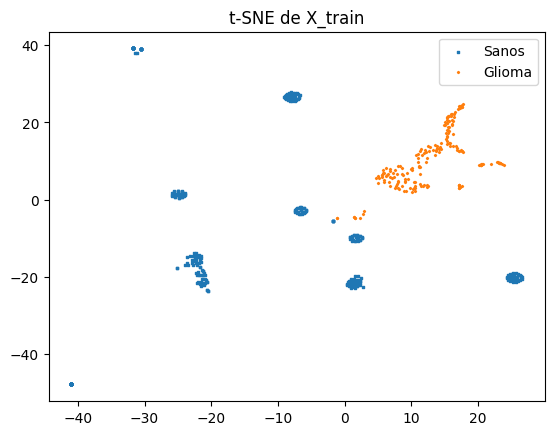

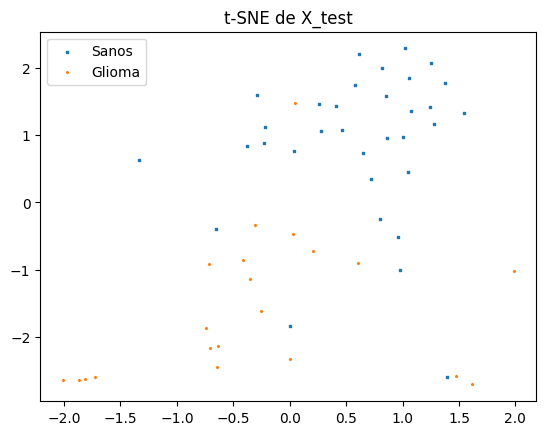

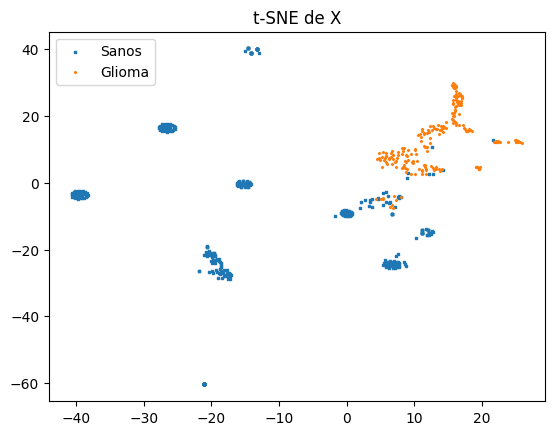

[I 2024-06-28 11:04:02,592] A new study created in memory with name: no-name-3f6a14dd-5940-4e56-ad9d-c29ccd1a9532
[I 2024-06-28 11:04:02,618] Trial 1 finished with value: 0.6885245901639344 and parameters: {'C': 9.480622119072489}. Best is trial 1 with value: 0.6885245901639344.
[I 2024-06-28 11:04:02,629] Trial 3 finished with value: 0.6666666666666666 and parameters: {'C': 33.27435063648768}. Best is trial 1 with value: 0.6885245901639344.
[I 2024-06-28 11:04:02,634] Trial 0 finished with value: 0.7547169811320755 and parameters: {'C': 1.6616271074201896}. Best is trial 0 with value: 0.7547169811320755.
[I 2024-06-28 11:04:02,635] Trial 4 finished with value: 0.7547169811320755 and parameters: {'C': 2.1862674051696707}. Best is trial 0 with value: 0.7547169811320755.
[I 2024-06-28 11:04:02,702] Trial 5 finished with value: 0.711864406779661 and parameters: {'C': 8.64919387802939}. Best is trial 0 with value: 0.7547169811320755.
[I 2024-06-28 11:04:02,704] Trial 2 finished with value:

[I 2024-06-28 11:04:03,555] Trial 46 finished with value: 0.7916666666666666 and parameters: {'C': 0.47303116803861034}. Best is trial 31 with value: 0.8095238095238095.
[I 2024-06-28 11:04:03,558] Trial 52 finished with value: 0.8085106382978723 and parameters: {'C': 0.4240292799530907}. Best is trial 31 with value: 0.8095238095238095.
[I 2024-06-28 11:04:03,583] Trial 51 finished with value: 0.7916666666666666 and parameters: {'C': 0.48489205485297493}. Best is trial 31 with value: 0.8095238095238095.
[I 2024-06-28 11:04:03,585] Trial 40 finished with value: 0.8085106382978723 and parameters: {'C': 0.32754432869410144}. Best is trial 31 with value: 0.8095238095238095.
[I 2024-06-28 11:04:03,608] Trial 57 finished with value: 0.7916666666666666 and parameters: {'C': 0.4565048050580135}. Best is trial 31 with value: 0.8095238095238095.
[I 2024-06-28 11:04:03,619] Trial 61 finished with value: 0.7916666666666666 and parameters: {'C': 0.6017680496993876}. Best is trial 31 with value: 0.8

[I 2024-06-28 11:04:04,086] Trial 98 finished with value: 0.7692307692307693 and parameters: {'C': 1.0234529557906182}. Best is trial 31 with value: 0.8095238095238095.
[I 2024-06-28 11:04:04,095] Trial 97 finished with value: 0.7692307692307693 and parameters: {'C': 1.0078673803702292}. Best is trial 31 with value: 0.8095238095238095.
[I 2024-06-28 11:04:04,099] Trial 100 finished with value: 0.7692307692307693 and parameters: {'C': 0.9983517559211679}. Best is trial 31 with value: 0.8095238095238095.
[I 2024-06-28 11:04:04,119] Trial 99 finished with value: 0.7692307692307693 and parameters: {'C': 1.0144284265379915}. Best is trial 31 with value: 0.8095238095238095.
[I 2024-06-28 11:04:04,125] Trial 102 finished with value: 0.7804878048780488 and parameters: {'C': 0.14154575249455414}. Best is trial 31 with value: 0.8095238095238095.
[I 2024-06-28 11:04:04,139] Trial 103 finished with value: 0.8095238095238095 and parameters: {'C': 0.1438796684724892}. Best is trial 31 with value: 0.

[I 2024-06-28 11:04:04,723] Trial 140 finished with value: 0.6470588235294118 and parameters: {'C': 0.03278574096508104}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:04,758] Trial 150 finished with value: 0.7906976744186046 and parameters: {'C': 0.19708196732437544}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:04,761] Trial 148 finished with value: 0.7906976744186046 and parameters: {'C': 0.2005165598402485}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:04,816] Trial 149 finished with value: 0.7906976744186046 and parameters: {'C': 0.19479556141816484}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:04,828] Trial 153 finished with value: 0.8 and parameters: {'C': 0.22093278602565766}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:04,865] Trial 151 finished with value: 0.7906976744186046 and parameters: {'C': 0.20404725004593743}. Best is trial 142 with value: 0.81

[I 2024-06-28 11:04:05,652] Trial 193 finished with value: 0.6842105263157895 and parameters: {'C': 0.0826493660449346}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:05,666] Trial 194 finished with value: 0.782608695652174 and parameters: {'C': 0.25774773918481814}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:05,671] Trial 197 finished with value: 0.6842105263157895 and parameters: {'C': 0.09713769467762146}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:05,737] Trial 199 finished with value: 0.6842105263157895 and parameters: {'C': 0.0962411436239367}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:05,836] Trial 201 finished with value: 0.6842105263157895 and parameters: {'C': 0.0928966483066869}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:05,842] Trial 203 finished with value: 0.6774193548387096 and parameters: {'C': 13.798383934816826}. Best is trial 142 with 

[I 2024-06-28 11:04:06,582] Trial 244 finished with value: 0.8181818181818182 and parameters: {'C': 0.21111931610616821}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:06,584] Trial 242 finished with value: 0.8085106382978723 and parameters: {'C': 0.3236668470434386}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:06,636] Trial 247 finished with value: 0.8 and parameters: {'C': 0.2140596499937468}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:06,643] Trial 251 finished with value: 0.8 and parameters: {'C': 0.22298868091665652}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:06,647] Trial 249 finished with value: 0.8 and parameters: {'C': 0.22974027124798557}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:06,659] Trial 253 finished with value: 0.7906976744186046 and parameters: {'C': 0.1844664036231584}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11

[I 2024-06-28 11:04:07,293] Trial 295 finished with value: 0.782608695652174 and parameters: {'C': 0.24276211138356257}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:07,298] Trial 296 finished with value: 0.7906976744186046 and parameters: {'C': 0.1982976106488676}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:07,317] Trial 291 finished with value: 0.782608695652174 and parameters: {'C': 0.26178209138795516}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:07,318] Trial 297 finished with value: 0.7906976744186046 and parameters: {'C': 0.20174816400917794}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:07,346] Trial 298 finished with value: 0.7906976744186046 and parameters: {'C': 0.19581478275643802}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:07,354] Trial 299 finished with value: 0.7906976744186046 and parameters: {'C': 0.20160260155786608}. Best is trial 142 wit

[I 2024-06-28 11:04:08,263] Trial 343 finished with value: 0.75 and parameters: {'C': 0.127649224904556}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:08,266] Trial 348 finished with value: 0.6461538461538462 and parameters: {'C': 88.6995105355236}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:08,269] Trial 342 finished with value: 0.8 and parameters: {'C': 0.22070633577182008}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:08,306] Trial 349 finished with value: 0.75 and parameters: {'C': 0.12987047138659413}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:08,316] Trial 345 finished with value: 0.75 and parameters: {'C': 0.13966011889324306}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:08,317] Trial 346 finished with value: 0.75 and parameters: {'C': 0.13228810569362048}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:08,345] Trial 347 finish

[I 2024-06-28 11:04:09,300] Trial 390 finished with value: 0.717948717948718 and parameters: {'C': 0.11633488892014858}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:09,376] Trial 395 finished with value: 0.8 and parameters: {'C': 0.21688775143654226}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:09,388] Trial 393 finished with value: 0.717948717948718 and parameters: {'C': 0.10626543156380551}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:09,390] Trial 394 finished with value: 0.8181818181818182 and parameters: {'C': 0.210127494316663}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:09,400] Trial 398 finished with value: 0.8 and parameters: {'C': 0.2197323758337717}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:09,453] Trial 396 finished with value: 0.8 and parameters: {'C': 0.2164099662188973}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04

[I 2024-06-28 11:04:10,499] Trial 443 finished with value: 0.7906976744186046 and parameters: {'C': 0.20413998142003545}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:10,501] Trial 441 finished with value: 0.7906976744186046 and parameters: {'C': 0.19949169912009154}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:10,506] Trial 442 finished with value: 0.7906976744186046 and parameters: {'C': 0.2021826440238798}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:10,535] Trial 445 finished with value: 0.782608695652174 and parameters: {'C': 0.2794161691417094}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:10,561] Trial 448 finished with value: 0.782608695652174 and parameters: {'C': 0.3003640667997583}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:10,570] Trial 444 finished with value: 0.782608695652174 and parameters: {'C': 0.29193596883869755}. Best is trial 142 with v

[I 2024-06-28 11:04:11,360] Trial 490 finished with value: 0.7906976744186046 and parameters: {'C': 0.19665974307679984}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:11,389] Trial 491 finished with value: 0.782608695652174 and parameters: {'C': 0.25039807787853174}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:11,393] Trial 492 finished with value: 0.782608695652174 and parameters: {'C': 0.2509727031196978}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:11,405] Trial 496 finished with value: 0.782608695652174 and parameters: {'C': 0.24307265533594097}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:11,409] Trial 494 finished with value: 0.782608695652174 and parameters: {'C': 0.2490731760535973}. Best is trial 142 with value: 0.8181818181818182.
[I 2024-06-28 11:04:11,410] Trial 493 finished with value: 0.782608695652174 and parameters: {'C': 0.26322823150119085}. Best is trial 142 with va

Best Threshold ROC = 0.999999072402715
Best Threshold PR = 0.999999072402715
Confusion Matrix:
[[26  7]
 [ 1 20]]
Recall for class 0: 0.7878787878787878
Recall for class 1: 0.9523809523809523
Accuracy: 0.8518518518518519
F1 Score: 0.8333333333333334

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.79      0.87        33
           1       0.74      0.95      0.83        21

    accuracy                           0.85        54
   macro avg       0.85      0.87      0.85        54
weighted avg       0.88      0.85      0.85        54



Training set - healthy: 297 glioma: 297
Test set - healthy: 33 glioma: 21


In [71]:
def objective(trial, X_train, y_train, X_test, y_test):
    C = trial.suggest_float("C", 1e-3, 1e2, log=True)
    clf = SVC(C=C, kernel="poly", probability=True, random_state=42)    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return f1_score(y_test, y_pred)

def classificate(mse_train_common, mse_test_common, 
                 mse_glioma_train_common, mse_glioma_test_common,
                 logl_train_common, logl_test_common,
                 logl_glioma_train_common, logl_glioma_test_commo):
    
    X_healthy_train, X_glioma_train, X_healthy_test, X_glioma_test = [], [], [], []
    
    for i, MRI_type in enumerate(["T1", "T2", "FLAIR"]):
        # Paso 1: Aplanamos las listas para que no estén separadas por fold
        MSE_healthy_train_common_f = [elemento for sublista in mse_train_common[i] for elemento in sublista]
        MSE_healthy_test_common_f = [elemento for sublista in mse_test_common[i] for elemento in sublista]
        MSE_glioma_train_common_f = [elemento for sublista in mse_glioma_train_common[i] for elemento in sublista]
        MSE_glioma_test_common_f = [elemento for sublista in mse_glioma_test_common[i] for elemento in sublista]

        LOGL_healthy_train_common_f = [elemento for sublista in logl_train_common[i] for elemento in sublista]
        LOGL_healthy_test_common_f = [elemento for sublista in logl_test_common[i] for elemento in sublista]
        LOGL_glioma_train_common_f = [elemento for sublista in logl_glioma_train_common[i] for elemento in sublista]
        LOGL_glioma_test_common_f = [elemento for sublista in logl_glioma_test_common[i] for elemento in sublista]
        
        # Queremos generar una matriz que contenga en cada fila los valores de un paciente: 
        # [MSE_T1, LOGL_T1, MSE_T2, LOGL_T2, MSE_FLAIR, LOGL_FLAIR]
        
        # Longitud 33, porque hay 33 pacientes, cada sublista contiene los 6 valores de arriba
        for j in range(len(MSE_healthy_train_common_f)):
            if i == 0: # Si estamos en el primer tipo de MRI creamos una lista, sino añadimos a la lista
                X_healthy_train.append([MSE_healthy_train_common_f[j], LOGL_healthy_train_common_f[j]])
            else: # Concatenamos los valores que ya había de ese paciente con los del siguiente tipo MRI
                X_healthy_train[j] = X_healthy_train[j] + [MSE_healthy_train_common_f[j], LOGL_healthy_train_common_f[j]]
                
        for j in range(len(MSE_healthy_test_common_f)):
            if i == 0: # Si estamos en el primer tipo de MRI creamos una lista, sino añadimos a la lista
                X_healthy_test.append([MSE_healthy_test_common_f[j], LOGL_healthy_test_common_f[j]])
            else: # Concatenamos los valores que ya había de ese paciente con los del siguiente tipo MRI
                X_healthy_test[j] = X_healthy_test[j] + [MSE_healthy_test_common_f[j], LOGL_healthy_test_common_f[j]]
                
        for j in range(len(MSE_glioma_train_common_f)):
            if i == 0: # Si estamos en el primer tipo de MRI creamos una lista, sino añadimos a la lista
                X_glioma_train.append([MSE_glioma_train_common_f[j], LOGL_glioma_train_common_f[j]])
            else: # Concatenamos los valores que ya había de ese paciente con los del siguiente tipo MRI
                X_glioma_train[j] = X_glioma_train[j] + [MSE_glioma_train_common_f[j], LOGL_glioma_train_common_f[j]]
                
        for j in range(len(MSE_glioma_test_common_f)):
            if i == 0: # Si estamos en el primer tipo de MRI creamos una lista, sino añadimos a la lista
                X_glioma_test.append([MSE_glioma_test_common_f[j], LOGL_glioma_test_common_f[j]])
            else: # Concatenamos los valores que ya había de ese paciente con los del siguiente tipo MRI
                X_glioma_test[j] = X_glioma_test[j] + [MSE_glioma_test_common_f[j], LOGL_glioma_test_common_f[j]]
        
    y_train = [0] * len(X_healthy_train) + [1] * len(X_glioma_train)
    X_train = X_healthy_train + X_glioma_train
    y_test = [0] * len(X_healthy_test) + [1] * len(X_glioma_test)
    X_test = X_healthy_test + X_glioma_test
    
    # Visualizamos X_train para ver como los espacios de 6 valores de sanos y gliomas se distribuyen
    tsne = TSNE(n_components=2)
    X_2D = tsne.fit_transform(np.array(X_train))
    
    plt.figure()    
    # Graficar cuadrados para la clase 0 (Sanos)
    plt.scatter(X_2D[np.array(y_train) == 0, 0], X_2D[np.array(y_train) == 0, 1], 
                marker='s', s=2, label='Sanos')
    
    # Graficar cruces para la clase 1 (Glioma)
    plt.scatter(X_2D[np.array(y_train) == 1, 0], X_2D[np.array(y_train) == 1, 1], 
                marker='x', s=2, label='Glioma')
    
    plt.title('t-SNE de X_train')
    plt.legend()
    plt.show()
    
    # Visualizamos X_test para ver como los espacios de 6 valores de sanos y gliomas se distribuyen
    tsne = TSNE(n_components=2)
    X_2D = tsne.fit_transform(np.array(X_test))

    plt.figure()    
    # Graficar cuadrados para la clase 0 (Sanos)
    plt.scatter(X_2D[np.array(y_test) == 0, 0], X_2D[np.array(y_test) == 0, 1], 
                marker='s', s=2, label='Sanos')
    
    # Graficar cruces para la clase 1 (Glioma)
    plt.scatter(X_2D[np.array(y_test) == 1, 0], X_2D[np.array(y_test) == 1, 1], 
                marker='x', s=2, label='Glioma')
    
    plt.title('t-SNE de X_test')
    plt.legend()
    plt.show()
    
    # Visualizamos todo X para ver como los espacios de 6 valores de sanos y gliomas se distribuyen
    tsne = TSNE(n_components=2)
    X_2D = tsne.fit_transform(np.array(X_train + X_test))

    plt.figure()    
    # Graficar cuadrados para la clase 0 (Sanos)
    plt.scatter(X_2D[np.array(y_train+y_test) == 0, 0], X_2D[np.array(y_train+y_test) == 0, 1], 
                marker='s', s=2, label='Sanos')
    
    # Graficar cruces para la clase 1 (Glioma)
    plt.scatter(X_2D[np.array(y_train+y_test) == 1, 0], X_2D[np.array(y_train+y_test) == 1, 1], 
                marker='x', s=2, label='Glioma')
    
    plt.title('t-SNE de X')
    plt.legend()
    plt.show()
    
    # Aplicar SMOTE
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, X_train_res, y_train_res, X_test, y_test), n_trials=500, n_jobs=-1)

    # Inicializamos el clasificador con los mejores parámetros
    best_clf = SVC(**study.best_params, probability=True, random_state=42)
    best_clf.fit(X_train_res, y_train_res)

    # Hacemos predicciones
    y_prob = best_clf.predict_proba(X_test)[:, 1]

    # Calcular la curva ROC y encontrar el umbral óptimo
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    J = tpr - fpr
    ix = np.argmax(J)
    best_threshold = thresholds[ix]
    print('Best Threshold ROC =',best_threshold)
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index]
    print('Best Threshold PR =', best_threshold)
    
    # Hacer predicciones usando el umbral óptimo
    y_pred_opt = (y_prob >= best_threshold).astype(int)

    # Paso 5: Evaluar el modelo
    conf_matrix = confusion_matrix(y_test, y_pred_opt)
    accuracy = accuracy_score(y_test, y_pred_opt)
    f1 = f1_score(y_test, y_pred_opt)
    recall_per_class = recall_score(y_test, y_pred_opt, average=None)
    class_report = classification_report(y_test, y_pred_opt)

    # Imprimir resultados
    print("Confusion Matrix:")
    print(conf_matrix)
    for j, recall in enumerate(recall_per_class):
        print(f"Recall for class {j}: {recall}")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print("\nClassification Report:\n", class_report)
    print("\n")

    print("Training set - healthy:", y_train_res.count(0), "glioma:", y_train_res.count(1))
    print("Test set - healthy:", y_test.count(0), "glioma:", y_test.count(1))

classificate(mse_train_common, mse_test_common, mse_glioma_train_common, mse_glioma_test_common, logl_train_common,
             logl_test_common, logl_glioma_train_common, logl_glioma_test_common)

### LO MISMO PERO SIN T2


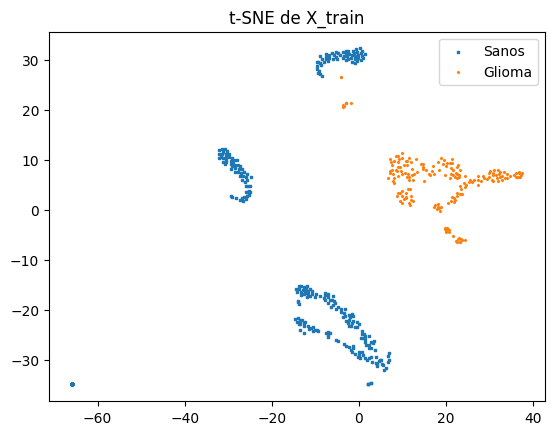

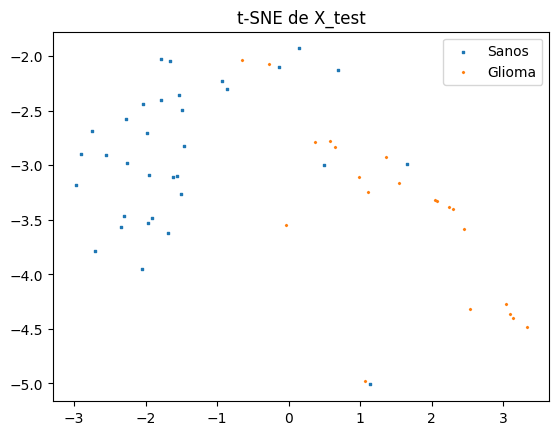

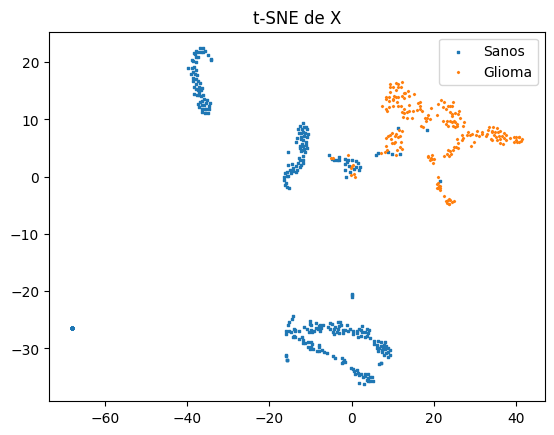

[I 2024-06-28 17:09:51,584] A new study created in memory with name: no-name-7271d15c-f86f-4ccb-b626-b9ef71b51ddb
[I 2024-06-28 17:09:51,614] Trial 4 finished with value: 0.8260869565217391 and parameters: {'C': 1.5652368034241189}. Best is trial 4 with value: 0.8260869565217391.
[I 2024-06-28 17:09:51,635] Trial 3 finished with value: 0.6470588235294118 and parameters: {'C': 0.0894387919332918}. Best is trial 4 with value: 0.8260869565217391.
[I 2024-06-28 17:09:51,637] Trial 1 finished with value: 0.84 and parameters: {'C': 41.20627836629957}. Best is trial 1 with value: 0.84.
[I 2024-06-28 17:09:51,638] Trial 2 finished with value: 0.84 and parameters: {'C': 47.83807612325849}. Best is trial 1 with value: 0.84.
[I 2024-06-28 17:09:51,639] Trial 5 finished with value: 0.84 and parameters: {'C': 7.817018268619698}. Best is trial 1 with value: 0.84.
[I 2024-06-28 17:09:51,642] Trial 7 finished with value: 0.8 and parameters: {'C': 1.1312474708293094}. Best is trial 1 with value: 0.84.


[I 2024-06-28 17:09:52,085] Trial 57 finished with value: 0.875 and parameters: {'C': 3.264454891172728}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:52,086] Trial 58 finished with value: 0.875 and parameters: {'C': 3.342298616523521}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:52,101] Trial 60 finished with value: 0.875 and parameters: {'C': 3.2859216220018825}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:52,119] Trial 56 finished with value: 0.875 and parameters: {'C': 4.016690652553459}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:52,120] Trial 59 finished with value: 0.875 and parameters: {'C': 3.751748395588236}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:52,126] Trial 61 finished with value: 0.851063829787234 and parameters: {'C': 2.7407989440684113}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:52,155] Trial 62 finished with value: 0.851063829787234 and parameters: {'C': 2.653092814341125}. Best is trial 53

[I 2024-06-28 17:09:52,579] Trial 114 finished with value: 0.8181818181818182 and parameters: {'C': 0.8251368264838722}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:52,583] Trial 113 finished with value: 0.7906976744186046 and parameters: {'C': 0.6967434957097006}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:52,598] Trial 115 finished with value: 0.8181818181818182 and parameters: {'C': 0.7540952510422293}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:52,604] Trial 116 finished with value: 0.8181818181818182 and parameters: {'C': 0.8579459789777879}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:52,608] Trial 118 finished with value: 0.8181818181818182 and parameters: {'C': 0.8326439386610545}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:52,612] Trial 117 finished with value: 0.8181818181818182 and parameters: {'C': 0.9879343003848648}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:52,612] Trial 119 finished with value:

[I 2024-06-28 17:09:53,096] Trial 169 finished with value: 0.851063829787234 and parameters: {'C': 2.0429644462259566}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:53,100] Trial 167 finished with value: 0.851063829787234 and parameters: {'C': 2.0132669630582574}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:53,115] Trial 170 finished with value: 0.851063829787234 and parameters: {'C': 1.9426841077045935}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:53,131] Trial 173 finished with value: 0.851063829787234 and parameters: {'C': 2.081549930936976}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:53,156] Trial 171 finished with value: 0.6470588235294118 and parameters: {'C': 0.12000371966010404}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:53,165] Trial 172 finished with value: 0.851063829787234 and parameters: {'C': 1.86873479378466}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:53,166] Trial 174 finished with value: 0.8510

[I 2024-06-28 17:09:53,540] Trial 222 finished with value: 0.875 and parameters: {'C': 3.6354362711155415}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:53,545] Trial 223 finished with value: 0.875 and parameters: {'C': 3.4977247794275286}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:53,553] Trial 224 finished with value: 0.875 and parameters: {'C': 3.8672087835575772}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:53,554] Trial 226 finished with value: 0.875 and parameters: {'C': 3.68867038962556}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:53,577] Trial 227 finished with value: 0.875 and parameters: {'C': 3.437461213411227}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:53,578] Trial 225 finished with value: 0.875 and parameters: {'C': 3.490677551038843}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:53,585] Trial 228 finished with value: 0.84 and parameters: {'C': 37.98599864066768}. Best is trial 53 with value: 0.875

[I 2024-06-28 17:09:54,116] Trial 275 finished with value: 0.875 and parameters: {'C': 4.46107632503258}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:54,118] Trial 277 finished with value: 0.8571428571428571 and parameters: {'C': 5.1511519427525965}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:54,148] Trial 278 finished with value: 0.8571428571428571 and parameters: {'C': 4.6131710259204235}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:54,152] Trial 282 finished with value: 0.7692307692307693 and parameters: {'C': 0.45636562598042385}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:54,157] Trial 280 finished with value: 0.8571428571428571 and parameters: {'C': 5.190666587051816}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:54,182] Trial 281 finished with value: 0.8571428571428571 and parameters: {'C': 4.691125728936644}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:54,190] Trial 284 finished with value: 0.8571428571428

[I 2024-06-28 17:09:54,696] Trial 334 finished with value: 0.851063829787234 and parameters: {'C': 2.0158755262860657}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:54,704] Trial 335 finished with value: 0.851063829787234 and parameters: {'C': 2.1317952864817413}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:54,705] Trial 330 finished with value: 0.8571428571428571 and parameters: {'C': 5.166843793438855}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:54,714] Trial 332 finished with value: 0.851063829787234 and parameters: {'C': 2.0631425044483525}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:54,776] Trial 336 finished with value: 0.851063829787234 and parameters: {'C': 1.9582983170718204}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:54,787] Trial 340 finished with value: 0.875 and parameters: {'C': 3.820218345973542}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:54,800] Trial 337 finished with value: 0.875 and paramete

[I 2024-06-28 17:09:55,364] Trial 389 finished with value: 0.851063829787234 and parameters: {'C': 2.2260048860548975}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:55,385] Trial 388 finished with value: 0.851063829787234 and parameters: {'C': 2.106483897742128}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:55,386] Trial 383 finished with value: 0.851063829787234 and parameters: {'C': 2.2361493471313643}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:55,388] Trial 391 finished with value: 0.875 and parameters: {'C': 3.3979178436300956}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:55,396] Trial 390 finished with value: 0.875 and parameters: {'C': 3.414314522938602}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:55,409] Trial 392 finished with value: 0.875 and parameters: {'C': 3.5058465598936164}. Best is trial 53 with value: 0.875.
[I 2024-06-28 17:09:55,440] Trial 393 finished with value: 0.875 and parameters: {'C': 3.3713198629211

In [ ]:
def objective(trial, X_train, y_train, X_test, y_test):
    C = trial.suggest_float("C", 1e-3, 1e2, log=True)
#     gamma = trial.suggest_float("gamma", 1e-4, 1e1, log=True)
    
    clf = SVC(C=C, kernel="poly", random_state=42)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return f1_score(y_test, y_pred)

def classificate(mse_train_common, mse_test_common, 
                 mse_glioma_train_common, mse_glioma_test_common,
                 logl_train_common, logl_test_common,
                 logl_glioma_train_common, logl_glioma_test_commo):
    
    X_healthy_train, X_glioma_train, X_healthy_test, X_glioma_test = [], [], [], []
    
    for i, MRI_type in enumerate(["T1", "FLAIR"]):
        # Paso 1: Aplanamos las listas para que no estén separadas por fold
        MSE_healthy_train_common_f = [elemento for sublista in mse_train_common[i] for elemento in sublista]
        MSE_healthy_test_common_f = [elemento for sublista in mse_test_common[i] for elemento in sublista]
        MSE_glioma_train_common_f = [elemento for sublista in mse_glioma_train_common[i] for elemento in sublista]
        MSE_glioma_test_common_f = [elemento for sublista in mse_glioma_test_common[i] for elemento in sublista]

        LOGL_healthy_train_common_f = [elemento for sublista in logl_train_common[i] for elemento in sublista]
        LOGL_healthy_test_common_f = [elemento for sublista in logl_test_common[i] for elemento in sublista]
        LOGL_glioma_train_common_f = [elemento for sublista in logl_glioma_train_common[i] for elemento in sublista]
        LOGL_glioma_test_common_f = [elemento for sublista in logl_glioma_test_common[i] for elemento in sublista]
        
        # Queremos generar una matriz que contenga en cada fila los valores de un paciente: 
        # [MSE_T1, LOGL_T1, MSE_T2, LOGL_T2, MSE_FLAIR, LOGL_FLAIR]
        
        # Longitud 33, porque hay 33 pacientes, cada sublista contiene los 6 valores de arriba
        for j in range(len(MSE_healthy_train_common_f)):
            if i == 0: # Si estamos en el primer tipo de MRI creamos una lista, sino añadimos a la lista
                X_healthy_train.append([MSE_healthy_train_common_f[j], LOGL_healthy_train_common_f[j]])
            else: # Concatenamos los valores que ya había de ese paciente con los del siguiente tipo MRI
                X_healthy_train[j] = X_healthy_train[j] + [MSE_healthy_train_common_f[j], LOGL_healthy_train_common_f[j]]
                
        for j in range(len(MSE_healthy_test_common_f)):
            if i == 0: # Si estamos en el primer tipo de MRI creamos una lista, sino añadimos a la lista
                X_healthy_test.append([MSE_healthy_test_common_f[j], LOGL_healthy_test_common_f[j]])
            else: # Concatenamos los valores que ya había de ese paciente con los del siguiente tipo MRI
                X_healthy_test[j] = X_healthy_test[j] + [MSE_healthy_test_common_f[j], LOGL_healthy_test_common_f[j]]
                
        for j in range(len(MSE_glioma_train_common_f)):
            if i == 0: # Si estamos en el primer tipo de MRI creamos una lista, sino añadimos a la lista
                X_glioma_train.append([MSE_glioma_train_common_f[j], LOGL_glioma_train_common_f[j]])
            else: # Concatenamos los valores que ya había de ese paciente con los del siguiente tipo MRI
                X_glioma_train[j] = X_glioma_train[j] + [MSE_glioma_train_common_f[j], LOGL_glioma_train_common_f[j]]
                
        for j in range(len(MSE_glioma_test_common_f)):
            if i == 0: # Si estamos en el primer tipo de MRI creamos una lista, sino añadimos a la lista
                X_glioma_test.append([MSE_glioma_test_common_f[j], LOGL_glioma_test_common_f[j]])
            else: # Concatenamos los valores que ya había de ese paciente con los del siguiente tipo MRI
                X_glioma_test[j] = X_glioma_test[j] + [MSE_glioma_test_common_f[j], LOGL_glioma_test_common_f[j]]
        
    y_train = [0] * len(X_healthy_train) + [1] * len(X_glioma_train)
    X_train = X_healthy_train + X_glioma_train
    y_test = [0] * len(X_healthy_test) + [1] * len(X_glioma_test)
    X_test = X_healthy_test + X_glioma_test
    
    # Visualizamos X_train para ver como los espacios de 6 valores de sanos y gliomas se distribuyen
    tsne = TSNE(n_components=2)
    X_2D = tsne.fit_transform(np.array(X_train))
    
    plt.figure()    
    # Graficar cuadrados para la clase 0 (Sanos)
    plt.scatter(X_2D[np.array(y_train) == 0, 0], X_2D[np.array(y_train) == 0, 1], 
                marker='s', s=2, label='Sanos')
    
    # Graficar cruces para la clase 1 (Glioma)
    plt.scatter(X_2D[np.array(y_train) == 1, 0], X_2D[np.array(y_train) == 1, 1], 
                marker='x', s=2, label='Glioma')
    
    plt.title('t-SNE de X_train')
    plt.legend()
    plt.show()
    
    # Visualizamos X_test para ver como los espacios de 6 valores de sanos y gliomas se distribuyen
    tsne = TSNE(n_components=2)
    X_2D = tsne.fit_transform(np.array(X_test))

    plt.figure()    
    # Graficar cuadrados para la clase 0 (Sanos)
    plt.scatter(X_2D[np.array(y_test) == 0, 0], X_2D[np.array(y_test) == 0, 1], 
                marker='s', s=2, label='Sanos')
    
    # Graficar cruces para la clase 1 (Glioma)
    plt.scatter(X_2D[np.array(y_test) == 1, 0], X_2D[np.array(y_test) == 1, 1], 
                marker='x', s=2, label='Glioma')
    
    plt.title('t-SNE de X_test')
    plt.legend()
    plt.show()
    
    # Visualizamos todo X para ver como los espacios de 6 valores de sanos y gliomas se distribuyen
    tsne = TSNE(n_components=2)
    X_2D = tsne.fit_transform(np.array(X_train + X_test))

    plt.figure()    
    # Graficar cuadrados para la clase 0 (Sanos)
    plt.scatter(X_2D[np.array(y_train+y_test) == 0, 0], X_2D[np.array(y_train+y_test) == 0, 1], 
                marker='s', s=2, label='Sanos')
    
    # Graficar cruces para la clase 1 (Glioma)
    plt.scatter(X_2D[np.array(y_train+y_test) == 1, 0], X_2D[np.array(y_train+y_test) == 1, 1], 
                marker='x', s=2, label='Glioma')
    
    plt.title('t-SNE de X')
    plt.legend()
    plt.show()
    
    # Aplicar SMOTE
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, X_train_res, y_train_res, X_test, y_test), n_trials=500, n_jobs=-1)

    # Inicializamos el clasificador con los mejores parámetros
    best_clf = SVC(**study.best_params, probability=True, random_state=42)
    best_clf.fit(X_train_res, y_train_res)

    # Hacemos predicciones
    y_prob = best_clf.predict_proba(X_test)[:, 1]

    # Calcular la curva ROC y encontrar el umbral óptimo
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    J = tpr - fpr
    ix = np.argmax(J)
    best_threshold = thresholds[ix]
    print('Best Threshold=%f' % best_threshold)

    # Hacer predicciones usando el umbral óptimo
    y_pred_opt = (y_prob >= best_threshold).astype(int)

    # Paso 5: Evaluar el modelo
    conf_matrix = confusion_matrix(y_test, y_pred_opt)
    accuracy = accuracy_score(y_test, y_pred_opt)
    f1 = f1_score(y_test, y_pred_opt)
    recall_per_class = recall_score(y_test, y_pred_opt, average=None)
    class_report = classification_report(y_test, y_pred_opt)

    # Imprimir resultados
    print("Confusion Matrix:")
    print(conf_matrix)
    for j, recall in enumerate(recall_per_class):
        print(f"Recall for class {j}: {recall}")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print("\nClassification Report:\n", class_report)
    print("\n")

    print("Training set - healthy:", y_train_res.count(0), "glioma:", y_train_res.count(1))
    print("Test set - healthy:", y_test.count(0), "glioma:", y_test.count(1))


mse_train_common2 = [mse_train_common_T1, mse_train_common_FLAIR]
logl_train_common2 = [logl_train_common_T1, logl_train_common_FLAIR]
mse_test_common2 = [mse_test_common_T1, mse_test_common_FLAIR]
logl_test_common2 = [logl_test_common_T1, logl_test_common_FLAIR]

mse_glioma_train_common2 = [mse_glioma_train_common_T1, mse_glioma_train_common_FLAIR]
logl_glioma_train_common2 = [logl_glioma_train_common_T1, logl_glioma_train_common_FLAIR]
mse_glioma_test_common2 = [mse_glioma_test_common_T1, mse_glioma_test_common_FLAIR]
logl_glioma_test_common2 = [logl_glioma_test_common_T1, logl_glioma_test_common_FLAIR]

classificate(mse_train_common2, mse_test_common2, mse_glioma_train_common2, mse_glioma_test_common2, logl_train_common2,
             logl_test_common2, logl_glioma_train_common2, logl_glioma_test_common2)

### SVM CON KERNEL POLY CON SMOTE POR FOLD

In [63]:
num_folds = 10

accuracies = []
recalls_0 = []
recalls_1 = []
f1_scores = []

def objective(trial, X_train, y_train, X_test, y_test):
    C = trial.suggest_float("C", 1e-3, 1e2, log=True)
    clf = SVC(C=C, kernel="poly", class_weight="balanced", probability=True, random_state=42)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return f1_score(y_test, y_pred)

def classificate(mse_train, mse_test, mse_glioma_train, mse_glioma_test, logl_train, logl_test, logl_glioma_train,
                 logl_glioma_test):
    
    for i, MRI_type in enumerate(["T1", "T2", "FLAIR"]):
        accuracy_MRI = []
        recall_0_MRI = []
        recall_1_MRI = []
        f1_score_MRI = []

        for fold_index in range(num_folds):
            # Obtenemos los resultados de cada fold
            mse_train_fold = mse_train[i][fold_index]
            logl_train_fold = logl_train[i][fold_index]

            mse_test_fold = mse_test[i][fold_index]
            logl_test_fold = logl_test[i][fold_index]

            mse_glioma_train_fold = mse_glioma_train[i][fold_index]
            logl_glioma_train_fold = logl_glioma_train[i][fold_index]

            mse_glioma_test_fold = mse_glioma_test[i][fold_index]
            logl_glioma_test_fold = logl_glioma_test[i][fold_index]

            # Los guardamos en listas healthy o glioma, en función de la clase
            X_train_healthy = list(zip(mse_train_fold, logl_train_fold))
            X_train_glioma = list(zip(mse_glioma_train_fold, logl_glioma_train_fold))
            
            # En base a las listas anteriores podemos definir las etiquetas de y
            X_train = X_train_healthy + X_train_glioma
            y_train = [0] * len(X_train_healthy) + [1] * len(X_train_glioma)

            X_test_healthy = list(zip(mse_test_fold, logl_test_fold))
            X_test_glioma = list(zip(mse_glioma_test_fold, logl_glioma_test_fold))

            X_test = X_test_healthy + X_test_glioma
            y_test = [0] * len(X_test_healthy) + [1] * len(X_test_glioma)
            
            # Aplicar SMOTE
            sm = SMOTE(random_state=42)
            X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
            
            # Empleamos Optuna para optimizar parámetros del clasificador
            study = optuna.create_study(direction="maximize")
            study.optimize(lambda trial: objective(trial, X_train_res, y_train_res, X_test, y_test), n_trials=100, n_jobs=-1)

            print(f"Best parameters for MRI type {MRI_type}: {study.best_params}")
            
            # Inicializamos el clasificador con los mejores parámetros
            best_clf = SVC(**study.best_params, class_weight="balanced", probability=True, random_state=42)
            best_clf.fit(X_train_res, y_train_res)
            
            # Hacemos predicciones
            y_prob = best_clf.predict_proba(X_test)[:, 1]

            # Calcular la curva ROC y encontrar el umbral óptimo
            fpr, tpr, thresholds = roc_curve(y_test, y_prob)
            J = tpr - fpr
            ix = np.argmax(J)
            best_threshold = thresholds[ix]
            print('Best Threshold=%f' % best_threshold)

            # Hacer predicciones usando el umbral óptimo
            y_pred_opt = (y_prob >= best_threshold).astype(int)

            # Evaluar el modelo
            conf_matrix = confusion_matrix(y_test, y_pred_opt)
            accuracy = accuracy_score(y_test, y_pred_opt)
            accuracy_MRI.append(accuracy)
            f1 = f1_score(y_test, y_pred_opt)
            f1_score_MRI.append(f1)
            recall_per_class = recall_score(y_test, y_pred_opt, average=None)
            recall_0_MRI.append(recall_per_class[0])
            recall_1_MRI.append(recall_per_class[1])

            # Imprimir resultados
            print("Resultados para Tipo MRI:", MRI_type + " y fold " + str(fold_index) + "\n")
            print("Confusion Matrix:")
            print(conf_matrix)
            for j, recall in enumerate(recall_per_class):
                print(f"Recall for class {j}: {recall}")
            print(f"Accuracy: {accuracy}")
            print(f"F1 Score: {f1}")
            print("\n")
        
        accuracies.append(accuracy_MRI)
        f1_scores.append(f1_score_MRI)
        recalls_0.append(recall_0_MRI)
        recalls_1.append(recall_1_MRI)

classificate(mse_train, mse_test, mse_glioma_train, mse_glioma_test, loglikelihoods_train, loglikelihoods_test,
             loglikelihoods_glioma_train, loglikelihoods_glioma_test)
for i, MRI_type in enumerate(["T1", "T2", "FLAIR"]):
    print("Media de Accuracy en "+str(MRI_type)+":", np.mean(np.array(accuracies[i])))
    print("Media de Recall clase 0 en "+str(MRI_type)+":", np.mean(np.array(recalls_0[i])))
    print("Media de Recall clase 1 en "+str(MRI_type)+":", np.mean(np.array(recalls_1[i])))
    print("Media de F1-Score en "+str(MRI_type)+":", np.mean(np.array(f1_scores[i])))
    
    print("STD de Accuracy en "+str(MRI_type)+":", np.std(np.array(accuracies[i])))
    print("STD de Recall clase 0 en "+str(MRI_type)+":", np.std(np.array(recalls_0[i])))
    print("STD de Recall clase 1 en "+str(MRI_type)+":", np.std(np.array(recalls_1[i])))
    print("STD de F1-Score en "+str(MRI_type)+":", np.std(np.array(f1_scores[i])))
    print("\n")


[I 2024-06-28 10:31:41,155] A new study created in memory with name: no-name-48065529-bd6b-4a0d-9fbc-7d761fee4a86
[I 2024-06-28 10:31:41,217] Trial 2 finished with value: 0.2857142857142857 and parameters: {'C': 0.029515927532450668}. Best is trial 2 with value: 0.2857142857142857.
[I 2024-06-28 10:31:41,226] Trial 0 finished with value: 0.7 and parameters: {'C': 2.2784554010675495}. Best is trial 0 with value: 0.7.
[I 2024-06-28 10:31:41,236] Trial 1 finished with value: 0.7 and parameters: {'C': 2.0015587360172615}. Best is trial 0 with value: 0.7.
[I 2024-06-28 10:31:41,255] Trial 6 finished with value: 0.631578947368421 and parameters: {'C': 0.8011860990940622}. Best is trial 0 with value: 0.7.
[I 2024-06-28 10:31:41,257] Trial 8 finished with value: 0.2857142857142857 and parameters: {'C': 0.08002895527800095}. Best is trial 0 with value: 0.7.
[I 2024-06-28 10:31:41,258] Trial 3 finished with value: 0.6363636363636364 and parameters: {'C': 24.93139736245878}. Best is trial 0 with 

[I 2024-06-28 10:31:42,172] Trial 50 finished with value: 0.7 and parameters: {'C': 3.1944805840319024}. Best is trial 40 with value: 0.75.
[I 2024-06-28 10:31:42,186] Trial 59 finished with value: 0.72 and parameters: {'C': 76.29533982149871}. Best is trial 40 with value: 0.75.
[I 2024-06-28 10:31:42,197] Trial 58 finished with value: 0.6956521739130435 and parameters: {'C': 52.63796645536251}. Best is trial 40 with value: 0.75.
[I 2024-06-28 10:31:42,200] Trial 67 finished with value: 0.72 and parameters: {'C': 88.5487396299836}. Best is trial 40 with value: 0.75.
[I 2024-06-28 10:31:42,205] Trial 63 finished with value: 0.7 and parameters: {'C': 2.1156946167034265}. Best is trial 40 with value: 0.75.
[I 2024-06-28 10:31:42,208] Trial 60 finished with value: 0.7 and parameters: {'C': 3.372501204972781}. Best is trial 40 with value: 0.75.
[I 2024-06-28 10:31:42,218] Trial 57 finished with value: 0.72 and parameters: {'C': 92.41345838648164}. Best is trial 40 with value: 0.75.
[I 2024-

[I 2024-06-28 10:31:42,824] Trial 12 finished with value: 0.2857142857142857 and parameters: {'C': 0.0011573425024301082}. Best is trial 10 with value: 0.8181818181818182.
[I 2024-06-28 10:31:42,827] Trial 11 finished with value: 0.7333333333333333 and parameters: {'C': 16.361869655551885}. Best is trial 10 with value: 0.8181818181818182.
[I 2024-06-28 10:31:42,835] Trial 13 finished with value: 0.72 and parameters: {'C': 0.5481766783640688}. Best is trial 10 with value: 0.8181818181818182.
[I 2024-06-28 10:31:42,851] Trial 14 finished with value: 0.2857142857142857 and parameters: {'C': 0.0022256121886209536}. Best is trial 10 with value: 0.8181818181818182.


Best parameters for MRI type T1: {'C': 62.51998347106073}
Best Threshold=0.999998
Resultados para Tipo MRI: T1 y fold 0

Confusion Matrix:
[[ 6  4]
 [ 1 11]]
Recall for class 0: 0.6
Recall for class 1: 0.9166666666666666
Accuracy: 0.7727272727272727
F1 Score: 0.8148148148148148




[I 2024-06-28 10:31:42,945] Trial 16 finished with value: 0.7741935483870968 and parameters: {'C': 20.950002177416444}. Best is trial 10 with value: 0.8181818181818182.
[I 2024-06-28 10:31:42,983] Trial 17 finished with value: 0.7333333333333333 and parameters: {'C': 17.418662995983937}. Best is trial 10 with value: 0.8181818181818182.
[I 2024-06-28 10:31:43,008] Trial 15 finished with value: 0.7741935483870968 and parameters: {'C': 20.38681398576916}. Best is trial 10 with value: 0.8181818181818182.
[I 2024-06-28 10:31:43,018] Trial 18 finished with value: 0.7741935483870968 and parameters: {'C': 23.116442457617357}. Best is trial 10 with value: 0.8181818181818182.
[I 2024-06-28 10:31:43,028] Trial 22 finished with value: 0.7142857142857143 and parameters: {'C': 2.4491465149377225}. Best is trial 10 with value: 0.8181818181818182.
[I 2024-06-28 10:31:43,050] Trial 20 finished with value: 0.7142857142857143 and parameters: {'C': 2.106311696690825}. Best is trial 10 with value: 0.818181

[I 2024-06-28 10:31:43,761] Trial 65 finished with value: 0.8181818181818182 and parameters: {'C': 0.11931110923301112}. Best is trial 10 with value: 0.8181818181818182.
[I 2024-06-28 10:31:43,773] Trial 68 finished with value: 0.8181818181818182 and parameters: {'C': 0.10521829289276656}. Best is trial 10 with value: 0.8181818181818182.
[I 2024-06-28 10:31:43,779] Trial 67 finished with value: 0.8181818181818182 and parameters: {'C': 0.09591767444332291}. Best is trial 10 with value: 0.8181818181818182.
[I 2024-06-28 10:31:43,787] Trial 66 finished with value: 0.8181818181818182 and parameters: {'C': 0.11916520306431064}. Best is trial 10 with value: 0.8181818181818182.
[I 2024-06-28 10:31:43,806] Trial 69 finished with value: 0.7619047619047619 and parameters: {'C': 0.08248637394785228}. Best is trial 10 with value: 0.8181818181818182.
[I 2024-06-28 10:31:43,807] Trial 72 finished with value: 0.7619047619047619 and parameters: {'C': 0.09421007699609388}. Best is trial 10 with value: 

[I 2024-06-28 10:31:44,203] Trial 12 finished with value: 0.9090909090909091 and parameters: {'C': 0.1548214719269659}. Best is trial 0 with value: 0.9090909090909091.


Best parameters for MRI type T1: {'C': 0.20907475639884016}
Best Threshold=1.000000
Resultados para Tipo MRI: T1 y fold 1

Confusion Matrix:
[[7 3]
 [3 9]]
Recall for class 0: 0.7
Recall for class 1: 0.75
Accuracy: 0.7272727272727273
F1 Score: 0.75




[I 2024-06-28 10:31:44,208] Trial 15 finished with value: 0.8571428571428571 and parameters: {'C': 1.0025790872735953}. Best is trial 0 with value: 0.9090909090909091.
[I 2024-06-28 10:31:44,210] Trial 16 finished with value: 1.0 and parameters: {'C': 0.19574663324888159}. Best is trial 16 with value: 1.0.
[I 2024-06-28 10:31:44,218] Trial 14 finished with value: 0.8571428571428571 and parameters: {'C': 0.9805270003947846}. Best is trial 16 with value: 1.0.
[I 2024-06-28 10:31:44,223] Trial 18 finished with value: 0.8571428571428571 and parameters: {'C': 1.2441956724005039}. Best is trial 16 with value: 1.0.
[I 2024-06-28 10:31:44,226] Trial 19 finished with value: 0.8571428571428571 and parameters: {'C': 0.05805241888023091}. Best is trial 16 with value: 1.0.
[I 2024-06-28 10:31:44,228] Trial 17 finished with value: 0.5 and parameters: {'C': 0.0018563249567527624}. Best is trial 16 with value: 1.0.
[I 2024-06-28 10:31:44,231] Trial 20 finished with value: 0.9090909090909091 and parame

[I 2024-06-28 10:31:45,104] Trial 74 finished with value: 0.8 and parameters: {'C': 0.015699437552692316}. Best is trial 16 with value: 1.0.
[I 2024-06-28 10:31:45,112] Trial 75 finished with value: 0.8 and parameters: {'C': 0.013284916762453513}. Best is trial 16 with value: 1.0.
[I 2024-06-28 10:31:45,116] Trial 73 finished with value: 0.8 and parameters: {'C': 0.01885849137717345}. Best is trial 16 with value: 1.0.
[I 2024-06-28 10:31:45,135] Trial 71 finished with value: 0.8 and parameters: {'C': 0.017296939148205244}. Best is trial 16 with value: 1.0.
[I 2024-06-28 10:31:45,137] Trial 78 finished with value: 0.8571428571428571 and parameters: {'C': 0.01963329881595289}. Best is trial 16 with value: 1.0.
[I 2024-06-28 10:31:45,170] Trial 76 finished with value: 0.8 and parameters: {'C': 0.011043885465415305}. Best is trial 16 with value: 1.0.
[I 2024-06-28 10:31:45,174] Trial 84 finished with value: 0.8 and parameters: {'C': 0.015526789396630788}. Best is trial 16 with value: 1.0.


Best parameters for MRI type T1: {'C': 0.19574663324888159}
Best Threshold=1.000000
Resultados para Tipo MRI: T1 y fold 2

Confusion Matrix:
[[10  0]
 [ 2 10]]
Recall for class 0: 1.0
Recall for class 1: 0.8333333333333334
Accuracy: 0.9090909090909091
F1 Score: 0.9090909090909091




[I 2024-06-28 10:31:45,453] Trial 5 finished with value: 0.7272727272727273 and parameters: {'C': 7.227157172930328}. Best is trial 7 with value: 0.7272727272727273.
[I 2024-06-28 10:31:45,510] Trial 10 finished with value: 0.5555555555555556 and parameters: {'C': 0.03281402748872976}. Best is trial 7 with value: 0.7272727272727273.
[I 2024-06-28 10:31:45,525] Trial 9 finished with value: 0.6 and parameters: {'C': 0.9717004320144353}. Best is trial 7 with value: 0.7272727272727273.
[I 2024-06-28 10:31:45,527] Trial 8 finished with value: 0.6 and parameters: {'C': 0.6318525524419734}. Best is trial 7 with value: 0.7272727272727273.
[I 2024-06-28 10:31:45,528] Trial 4 finished with value: 0.5555555555555556 and parameters: {'C': 0.03262406353166733}. Best is trial 7 with value: 0.7272727272727273.
[I 2024-06-28 10:31:45,541] Trial 11 finished with value: 0.6 and parameters: {'C': 0.6558069189630595}. Best is trial 7 with value: 0.7272727272727273.
[I 2024-06-28 10:31:45,549] Trial 13 fin

[I 2024-06-28 10:31:46,632] Trial 56 finished with value: 0.7272727272727273 and parameters: {'C': 6.295361793145637}. Best is trial 7 with value: 0.7272727272727273.
[I 2024-06-28 10:31:46,632] Trial 54 finished with value: 0.7272727272727273 and parameters: {'C': 6.058851546593609}. Best is trial 7 with value: 0.7272727272727273.
[I 2024-06-28 10:31:46,638] Trial 55 finished with value: 0.7272727272727273 and parameters: {'C': 5.321124562817228}. Best is trial 7 with value: 0.7272727272727273.
[I 2024-06-28 10:31:46,650] Trial 57 finished with value: 0.7272727272727273 and parameters: {'C': 6.891582692566726}. Best is trial 7 with value: 0.7272727272727273.
[I 2024-06-28 10:31:46,650] Trial 61 finished with value: 0.7272727272727273 and parameters: {'C': 5.8068786533418875}. Best is trial 7 with value: 0.7272727272727273.
[I 2024-06-28 10:31:46,657] Trial 60 finished with value: 0.7272727272727273 and parameters: {'C': 5.40048342184568}. Best is trial 7 with value: 0.7272727272727273

[I 2024-06-28 10:31:47,260] Trial 6 finished with value: 0.375 and parameters: {'C': 0.028969449321953895}. Best is trial 0 with value: 0.8275862068965517.
[I 2024-06-28 10:31:47,262] Trial 9 finished with value: 0.8275862068965517 and parameters: {'C': 97.81335050737808}. Best is trial 0 with value: 0.8275862068965517.
[I 2024-06-28 10:31:47,264] Trial 7 finished with value: 0.6 and parameters: {'C': 0.6656548986678766}. Best is trial 0 with value: 0.8275862068965517.
[I 2024-06-28 10:31:47,269] Trial 5 finished with value: 0.26666666666666666 and parameters: {'C': 0.002599971962537548}. Best is trial 0 with value: 0.8275862068965517.
[I 2024-06-28 10:31:47,273] Trial 8 finished with value: 0.8 and parameters: {'C': 3.568877086382231}. Best is trial 0 with value: 0.8275862068965517.
[I 2024-06-28 10:31:47,308] Trial 10 finished with value: 0.7692307692307693 and parameters: {'C': 22.4926396196127}. Best is trial 0 with value: 0.8275862068965517.
[I 2024-06-28 10:31:47,354] Trial 11 fi

Best parameters for MRI type T1: {'C': 3.6588429859709857}
Best Threshold=0.999982
Resultados para Tipo MRI: T1 y fold 3

Confusion Matrix:
[[8 2]
 [6 6]]
Recall for class 0: 0.8
Recall for class 1: 0.5
Accuracy: 0.6363636363636364
F1 Score: 0.6




[I 2024-06-28 10:31:47,423] Trial 14 finished with value: 0.8275862068965517 and parameters: {'C': 82.06064759094797}. Best is trial 0 with value: 0.8275862068965517.
[I 2024-06-28 10:31:47,426] Trial 15 finished with value: 0.7857142857142857 and parameters: {'C': 50.90898799060266}. Best is trial 0 with value: 0.8275862068965517.
[I 2024-06-28 10:31:47,449] Trial 13 finished with value: 0.7857142857142857 and parameters: {'C': 38.552771379307174}. Best is trial 0 with value: 0.8275862068965517.
[I 2024-06-28 10:31:47,510] Trial 17 finished with value: 0.8275862068965517 and parameters: {'C': 87.36034467026306}. Best is trial 0 with value: 0.8275862068965517.
[I 2024-06-28 10:31:47,512] Trial 16 finished with value: 0.8275862068965517 and parameters: {'C': 83.20845419697561}. Best is trial 0 with value: 0.8275862068965517.
[I 2024-06-28 10:31:47,566] Trial 19 finished with value: 0.8275862068965517 and parameters: {'C': 78.33106770164422}. Best is trial 0 with value: 0.827586206896551

[I 2024-06-28 10:31:48,658] Trial 67 finished with value: 0.6 and parameters: {'C': 0.3616172076309624}. Best is trial 0 with value: 0.8275862068965517.
[I 2024-06-28 10:31:48,734] Trial 66 finished with value: 0.6 and parameters: {'C': 0.3295925474973558}. Best is trial 0 with value: 0.8275862068965517.
[I 2024-06-28 10:31:48,736] Trial 68 finished with value: 0.6 and parameters: {'C': 0.32732943825745275}. Best is trial 0 with value: 0.8275862068965517.
[I 2024-06-28 10:31:48,740] Trial 71 finished with value: 0.6 and parameters: {'C': 0.3756360377660918}. Best is trial 0 with value: 0.8275862068965517.
[I 2024-06-28 10:31:48,761] Trial 69 finished with value: 0.4444444444444444 and parameters: {'C': 0.2607031095383222}. Best is trial 0 with value: 0.8275862068965517.
[I 2024-06-28 10:31:48,756] Trial 70 finished with value: 0.6 and parameters: {'C': 0.4488095772339367}. Best is trial 0 with value: 0.8275862068965517.
[I 2024-06-28 10:31:48,777] Trial 76 finished with value: 0.8 and 

[I 2024-06-28 10:31:49,740] Trial 15 finished with value: 0.0 and parameters: {'C': 0.005998639447657782}. Best is trial 0 with value: 0.7692307692307693.
[I 2024-06-28 10:31:49,741] Trial 14 finished with value: 0.0 and parameters: {'C': 0.0012655887195009107}. Best is trial 0 with value: 0.7692307692307693.
[I 2024-06-28 10:31:49,743] Trial 18 finished with value: 0.6956521739130435 and parameters: {'C': 18.446728389677727}. Best is trial 0 with value: 0.7692307692307693.
[I 2024-06-28 10:31:49,746] Trial 16 finished with value: 0.35294117647058826 and parameters: {'C': 0.42000426671799446}. Best is trial 0 with value: 0.7692307692307693.
[I 2024-06-28 10:31:49,783] Trial 19 finished with value: 0.7692307692307693 and parameters: {'C': 94.89057804539304}. Best is trial 0 with value: 0.7692307692307693.


Best parameters for MRI type T1: {'C': 88.66677010413161}
Best Threshold=1.000000
Resultados para Tipo MRI: T1 y fold 4

Confusion Matrix:
[[9 1]
 [4 8]]
Recall for class 0: 0.9
Recall for class 1: 0.6666666666666666
Accuracy: 0.7727272727272727
F1 Score: 0.7619047619047619




[I 2024-06-28 10:31:49,809] Trial 22 finished with value: 0.7692307692307693 and parameters: {'C': 94.53131733887308}. Best is trial 0 with value: 0.7692307692307693.
[I 2024-06-28 10:31:49,820] Trial 23 finished with value: 0.7692307692307693 and parameters: {'C': 98.19038406495389}. Best is trial 0 with value: 0.7692307692307693.
[I 2024-06-28 10:31:49,822] Trial 21 finished with value: 0.7692307692307693 and parameters: {'C': 97.40449549439275}. Best is trial 0 with value: 0.7692307692307693.
[I 2024-06-28 10:31:49,823] Trial 20 finished with value: 0.7692307692307693 and parameters: {'C': 56.870935885844546}. Best is trial 0 with value: 0.7692307692307693.
[I 2024-06-28 10:31:49,835] Trial 24 finished with value: 0.0 and parameters: {'C': 0.001406326128481858}. Best is trial 0 with value: 0.7692307692307693.
[I 2024-06-28 10:31:49,884] Trial 25 finished with value: 0.7692307692307693 and parameters: {'C': 83.48583248434376}. Best is trial 0 with value: 0.7692307692307693.
[I 2024-0

[I 2024-06-28 10:31:50,502] Trial 72 finished with value: 0.6363636363636364 and parameters: {'C': 7.941094649609683}. Best is trial 0 with value: 0.7692307692307693.
[I 2024-06-28 10:31:50,506] Trial 75 finished with value: 0.5714285714285714 and parameters: {'C': 6.474371701818211}. Best is trial 0 with value: 0.7692307692307693.
[I 2024-06-28 10:31:50,514] Trial 69 finished with value: 0.6363636363636364 and parameters: {'C': 7.715161502394469}. Best is trial 0 with value: 0.7692307692307693.
[I 2024-06-28 10:31:50,532] Trial 67 finished with value: 0.5714285714285714 and parameters: {'C': 4.923099459387108}. Best is trial 0 with value: 0.7692307692307693.
[I 2024-06-28 10:31:50,546] Trial 70 finished with value: 0.5714285714285714 and parameters: {'C': 6.535839917668664}. Best is trial 0 with value: 0.7692307692307693.
[I 2024-06-28 10:31:50,552] Trial 78 finished with value: 0.5714285714285714 and parameters: {'C': 6.074509172654886}. Best is trial 0 with value: 0.7692307692307693

Best parameters for MRI type T1: {'C': 94.26563057918301}
Best Threshold=1.000000
Resultados para Tipo MRI: T1 y fold 5

Confusion Matrix:
[[8 2]
 [3 9]]
Recall for class 0: 0.8
Recall for class 1: 0.75
Accuracy: 0.7727272727272727
F1 Score: 0.782608695652174




[I 2024-06-28 10:31:50,938] Trial 7 finished with value: 0.7619047619047619 and parameters: {'C': 1.403707878576745}. Best is trial 5 with value: 0.8333333333333334.
[I 2024-06-28 10:31:50,952] Trial 8 finished with value: 0.8333333333333334 and parameters: {'C': 21.199940595920207}. Best is trial 5 with value: 0.8333333333333334.
[I 2024-06-28 10:31:50,964] Trial 9 finished with value: 0.8333333333333334 and parameters: {'C': 4.675971832497291}. Best is trial 5 with value: 0.8333333333333334.
[I 2024-06-28 10:31:50,973] Trial 12 finished with value: 0.8333333333333334 and parameters: {'C': 17.588360362172125}. Best is trial 5 with value: 0.8333333333333334.
[I 2024-06-28 10:31:50,986] Trial 13 finished with value: 0.2857142857142857 and parameters: {'C': 0.002618526108158355}. Best is trial 5 with value: 0.8333333333333334.
[I 2024-06-28 10:31:51,000] Trial 11 finished with value: 0.8333333333333334 and parameters: {'C': 16.940982045282215}. Best is trial 5 with value: 0.8333333333333

[I 2024-06-28 10:31:51,888] Trial 61 finished with value: 0.782608695652174 and parameters: {'C': 4.334656176520865}. Best is trial 5 with value: 0.8333333333333334.
[I 2024-06-28 10:31:51,902] Trial 59 finished with value: 0.8333333333333334 and parameters: {'C': 33.62141693673834}. Best is trial 5 with value: 0.8333333333333334.
[I 2024-06-28 10:31:51,924] Trial 64 finished with value: 0.8333333333333334 and parameters: {'C': 28.295965992100047}. Best is trial 5 with value: 0.8333333333333334.
[I 2024-06-28 10:31:51,950] Trial 62 finished with value: 0.8333333333333334 and parameters: {'C': 26.751327389548504}. Best is trial 5 with value: 0.8333333333333334.
[I 2024-06-28 10:31:51,950] Trial 54 finished with value: 0.8333333333333334 and parameters: {'C': 28.33608054485272}. Best is trial 5 with value: 0.8333333333333334.
[I 2024-06-28 10:31:51,958] Trial 55 finished with value: 0.8333333333333334 and parameters: {'C': 35.014025316752225}. Best is trial 5 with value: 0.83333333333333

[I 2024-06-28 10:31:52,452] Trial 7 finished with value: 0.8181818181818182 and parameters: {'C': 0.19674642821139685}. Best is trial 7 with value: 0.8181818181818182.
[I 2024-06-28 10:31:52,452] Trial 5 finished with value: 0.7857142857142857 and parameters: {'C': 95.98931709960208}. Best is trial 7 with value: 0.8181818181818182.
[I 2024-06-28 10:31:52,461] Trial 2 finished with value: 0.7407407407407407 and parameters: {'C': 7.881109412651263}. Best is trial 7 with value: 0.8181818181818182.
[I 2024-06-28 10:31:52,470] Trial 8 finished with value: 0.4 and parameters: {'C': 0.002509394283672007}. Best is trial 7 with value: 0.8181818181818182.
[I 2024-06-28 10:31:52,491] Trial 11 finished with value: 0.5555555555555556 and parameters: {'C': 0.017791071491876684}. Best is trial 7 with value: 0.8181818181818182.
[I 2024-06-28 10:31:52,501] Trial 10 finished with value: 0.7407407407407407 and parameters: {'C': 7.257316387536687}. Best is trial 7 with value: 0.8181818181818182.
[I 2024-0

Best parameters for MRI type T1: {'C': 21.691008871655953}
Best Threshold=1.000000
Resultados para Tipo MRI: T1 y fold 6

Confusion Matrix:
[[8 2]
 [4 8]]
Recall for class 0: 0.8
Recall for class 1: 0.6666666666666666
Accuracy: 0.7272727272727273
F1 Score: 0.7272727272727273




[I 2024-06-28 10:31:52,673] Trial 19 finished with value: 0.8181818181818182 and parameters: {'C': 0.24418777621793877}. Best is trial 7 with value: 0.8181818181818182.
[I 2024-06-28 10:31:52,680] Trial 20 finished with value: 0.8181818181818182 and parameters: {'C': 0.2839847785831573}. Best is trial 7 with value: 0.8181818181818182.
[I 2024-06-28 10:31:52,761] Trial 22 finished with value: 0.8181818181818182 and parameters: {'C': 0.29938706887044}. Best is trial 7 with value: 0.8181818181818182.
[I 2024-06-28 10:31:52,773] Trial 21 finished with value: 0.8181818181818182 and parameters: {'C': 0.24408528108956976}. Best is trial 7 with value: 0.8181818181818182.
[I 2024-06-28 10:31:52,776] Trial 23 finished with value: 0.8181818181818182 and parameters: {'C': 0.4135039981177284}. Best is trial 7 with value: 0.8181818181818182.
[I 2024-06-28 10:31:52,794] Trial 24 finished with value: 0.8181818181818182 and parameters: {'C': 0.19109588989245915}. Best is trial 7 with value: 0.818181818

[I 2024-06-28 10:31:53,636] Trial 67 finished with value: 0.7 and parameters: {'C': 0.08433542970578407}. Best is trial 7 with value: 0.8181818181818182.
[I 2024-06-28 10:31:53,639] Trial 72 finished with value: 0.631578947368421 and parameters: {'C': 0.05771389340341486}. Best is trial 7 with value: 0.8181818181818182.
[I 2024-06-28 10:31:53,647] Trial 73 finished with value: 0.631578947368421 and parameters: {'C': 0.05963773696681688}. Best is trial 7 with value: 0.8181818181818182.
[I 2024-06-28 10:31:53,699] Trial 71 finished with value: 0.631578947368421 and parameters: {'C': 0.0614717865389489}. Best is trial 7 with value: 0.8181818181818182.
[I 2024-06-28 10:31:53,760] Trial 76 finished with value: 0.631578947368421 and parameters: {'C': 0.0595435763884307}. Best is trial 7 with value: 0.8181818181818182.
[I 2024-06-28 10:31:53,788] Trial 78 finished with value: 0.7 and parameters: {'C': 0.07380445266927134}. Best is trial 7 with value: 0.8181818181818182.
[I 2024-06-28 10:31:53

Best parameters for MRI type T1: {'C': 0.19674642821139685}
Best Threshold=1.000000
Resultados para Tipo MRI: T1 y fold 7

Confusion Matrix:
[[9 1]
 [3 9]]
Recall for class 0: 0.9
Recall for class 1: 0.75
Accuracy: 0.8181818181818182
F1 Score: 0.8181818181818182




[I 2024-06-28 10:31:54,138] Trial 7 finished with value: 0.5555555555555556 and parameters: {'C': 0.04313995762388118}. Best is trial 4 with value: 0.7272727272727273.
[I 2024-06-28 10:31:54,149] Trial 8 finished with value: 0.72 and parameters: {'C': 53.82113000136485}. Best is trial 4 with value: 0.7272727272727273.
[I 2024-06-28 10:31:54,150] Trial 9 finished with value: 0.6666666666666666 and parameters: {'C': 0.7564061222016815}. Best is trial 4 with value: 0.7272727272727273.
[I 2024-06-28 10:31:54,172] Trial 11 finished with value: 0.6666666666666666 and parameters: {'C': 1.5677423373911563}. Best is trial 4 with value: 0.7272727272727273.
[I 2024-06-28 10:31:54,178] Trial 14 finished with value: 0.6956521739130435 and parameters: {'C': 7.786766001386092}. Best is trial 4 with value: 0.7272727272727273.
[I 2024-06-28 10:31:54,183] Trial 13 finished with value: 0.72 and parameters: {'C': 62.729177839701286}. Best is trial 4 with value: 0.7272727272727273.
[I 2024-06-28 10:31:54,1

[I 2024-06-28 10:31:55,097] Trial 63 finished with value: 0.6666666666666666 and parameters: {'C': 0.437390530214985}. Best is trial 4 with value: 0.7272727272727273.
[I 2024-06-28 10:31:55,108] Trial 69 finished with value: 0.6666666666666666 and parameters: {'C': 0.4565399185427221}. Best is trial 4 with value: 0.7272727272727273.
[I 2024-06-28 10:31:55,113] Trial 59 finished with value: 0.6666666666666666 and parameters: {'C': 0.4550770814552756}. Best is trial 4 with value: 0.7272727272727273.
[I 2024-06-28 10:31:55,113] Trial 67 finished with value: 0.6666666666666666 and parameters: {'C': 0.43233004703674505}. Best is trial 4 with value: 0.7272727272727273.
[I 2024-06-28 10:31:55,139] Trial 68 finished with value: 0.6666666666666666 and parameters: {'C': 0.4371761261378048}. Best is trial 4 with value: 0.7272727272727273.
[I 2024-06-28 10:31:55,160] Trial 61 finished with value: 0.6666666666666666 and parameters: {'C': 0.4869704230942048}. Best is trial 4 with value: 0.7272727272

[I 2024-06-28 10:31:55,753] Trial 14 finished with value: 0.15384615384615385 and parameters: {'C': 0.0011220730961225018}. Best is trial 7 with value: 0.75.
[I 2024-06-28 10:31:55,754] Trial 10 finished with value: 0.5 and parameters: {'C': 0.2701131360569623}. Best is trial 7 with value: 0.75.
[I 2024-06-28 10:31:55,758] Trial 6 finished with value: 0.15384615384615385 and parameters: {'C': 0.002798689867863853}. Best is trial 7 with value: 0.75.
[I 2024-06-28 10:31:55,759] Trial 15 finished with value: 0.15384615384615385 and parameters: {'C': 0.00589222717603734}. Best is trial 7 with value: 0.75.


Best parameters for MRI type T1: {'C': 2.9947659832166}
Best Threshold=0.934138
Resultados para Tipo MRI: T1 y fold 8

Confusion Matrix:
[[ 5  5]
 [ 1 11]]
Recall for class 0: 0.5
Recall for class 1: 0.9166666666666666
Accuracy: 0.7272727272727273
F1 Score: 0.7857142857142857




[I 2024-06-28 10:31:55,761] Trial 13 finished with value: 0.5 and parameters: {'C': 0.4212521925196515}. Best is trial 7 with value: 0.75.
[I 2024-06-28 10:31:55,763] Trial 12 finished with value: 0.6 and parameters: {'C': 15.890410179612628}. Best is trial 7 with value: 0.75.
[I 2024-06-28 10:31:55,764] Trial 9 finished with value: 0.47058823529411764 and parameters: {'C': 2.2716514892351958}. Best is trial 7 with value: 0.75.
[I 2024-06-28 10:31:55,782] Trial 17 finished with value: 0.15384615384615385 and parameters: {'C': 0.002573617576615707}. Best is trial 7 with value: 0.75.
[I 2024-06-28 10:31:55,789] Trial 16 finished with value: 0.4 and parameters: {'C': 0.05486780960609295}. Best is trial 7 with value: 0.75.
[I 2024-06-28 10:31:55,805] Trial 19 finished with value: 0.5 and parameters: {'C': 0.25968643060001073}. Best is trial 7 with value: 0.75.
[I 2024-06-28 10:31:55,814] Trial 18 finished with value: 0.4 and parameters: {'C': 0.043170959595617606}. Best is trial 7 with val

[I 2024-06-28 10:31:56,576] Trial 77 finished with value: 0.6956521739130435 and parameters: {'C': 47.88042553148262}. Best is trial 32 with value: 0.8.
[I 2024-06-28 10:31:56,586] Trial 73 finished with value: 0.75 and parameters: {'C': 82.76777446646801}. Best is trial 32 with value: 0.8.
[I 2024-06-28 10:31:56,593] Trial 71 finished with value: 0.75 and parameters: {'C': 87.67342346273156}. Best is trial 32 with value: 0.8.
[I 2024-06-28 10:31:56,603] Trial 82 finished with value: 0.75 and parameters: {'C': 55.27093695099495}. Best is trial 32 with value: 0.8.
[I 2024-06-28 10:31:56,604] Trial 74 finished with value: 0.75 and parameters: {'C': 89.60895777758586}. Best is trial 32 with value: 0.8.
[I 2024-06-28 10:31:56,627] Trial 76 finished with value: 0.75 and parameters: {'C': 51.046848463291454}. Best is trial 32 with value: 0.8.
[I 2024-06-28 10:31:56,630] Trial 83 finished with value: 0.75 and parameters: {'C': 81.35605168587136}. Best is trial 32 with value: 0.8.
[I 2024-06-2

Best parameters for MRI type T1: {'C': 99.77517908747008}
Best Threshold=1.000000
Resultados para Tipo MRI: T1 y fold 9

Confusion Matrix:
[[7 3]
 [2 9]]
Recall for class 0: 0.7
Recall for class 1: 0.8181818181818182
Accuracy: 0.7619047619047619
F1 Score: 0.782608695652174




[I 2024-06-28 10:31:56,856] Trial 17 finished with value: 0.6190476190476191 and parameters: {'C': 0.3401967517857845}. Best is trial 4 with value: 0.6190476190476191.
[I 2024-06-28 10:31:56,858] Trial 2 finished with value: 0.6190476190476191 and parameters: {'C': 22.317311775057437}. Best is trial 4 with value: 0.6190476190476191.
[I 2024-06-28 10:31:56,861] Trial 8 finished with value: 0.5 and parameters: {'C': 0.007432451529639691}. Best is trial 4 with value: 0.6190476190476191.
[I 2024-06-28 10:31:56,884] Trial 12 finished with value: 0.34782608695652173 and parameters: {'C': 0.003698741184466738}. Best is trial 4 with value: 0.6190476190476191.
[I 2024-06-28 10:31:56,897] Trial 18 finished with value: 0.6190476190476191 and parameters: {'C': 0.7310272134693165}. Best is trial 4 with value: 0.6190476190476191.
[I 2024-06-28 10:31:56,901] Trial 13 finished with value: 0.11764705882352941 and parameters: {'C': 0.0022045633486493773}. Best is trial 4 with value: 0.6190476190476191.


[I 2024-06-28 10:31:57,640] Trial 58 finished with value: 0.6190476190476191 and parameters: {'C': 13.141522222759246}. Best is trial 4 with value: 0.6190476190476191.
[I 2024-06-28 10:31:57,664] Trial 61 finished with value: 0.6190476190476191 and parameters: {'C': 12.615481114398857}. Best is trial 4 with value: 0.6190476190476191.
[I 2024-06-28 10:31:57,670] Trial 65 finished with value: 0.6190476190476191 and parameters: {'C': 8.52007023982827}. Best is trial 4 with value: 0.6190476190476191.
[I 2024-06-28 10:31:57,690] Trial 59 finished with value: 0.6190476190476191 and parameters: {'C': 13.34577285495624}. Best is trial 4 with value: 0.6190476190476191.
[I 2024-06-28 10:31:57,701] Trial 68 finished with value: 0.6190476190476191 and parameters: {'C': 11.651613386385225}. Best is trial 4 with value: 0.6190476190476191.
[I 2024-06-28 10:31:57,712] Trial 63 finished with value: 0.6190476190476191 and parameters: {'C': 12.81499376928392}. Best is trial 4 with value: 0.61904761904761

Best parameters for MRI type T2: {'C': 25.534016490707813}
Best Threshold=1.000000
Resultados para Tipo MRI: T2 y fold 0

Confusion Matrix:
[[12  4]
 [ 8  6]]
Recall for class 0: 0.75
Recall for class 1: 0.42857142857142855
Accuracy: 0.6
F1 Score: 0.5




[I 2024-06-28 10:31:58,262] Trial 5 finished with value: 0.6046511627906976 and parameters: {'C': 3.897162423872632}. Best is trial 2 with value: 0.6190476190476191.
[I 2024-06-28 10:31:58,284] Trial 6 finished with value: 0.6046511627906976 and parameters: {'C': 6.022031580130565}. Best is trial 2 with value: 0.6190476190476191.
[I 2024-06-28 10:31:58,347] Trial 7 finished with value: 0.6046511627906976 and parameters: {'C': 1.224762628669492}. Best is trial 2 with value: 0.6190476190476191.
[I 2024-06-28 10:31:58,388] Trial 9 finished with value: 0.35294117647058826 and parameters: {'C': 0.0016872082789496992}. Best is trial 2 with value: 0.6190476190476191.
[I 2024-06-28 10:31:58,407] Trial 10 finished with value: 0.6046511627906976 and parameters: {'C': 2.8815221348760685}. Best is trial 2 with value: 0.6190476190476191.
[I 2024-06-28 10:31:58,435] Trial 8 finished with value: 0.6046511627906976 and parameters: {'C': 1.5292958902587208}. Best is trial 2 with value: 0.61904761904761

[I 2024-06-28 10:31:59,292] Trial 58 finished with value: 0.6190476190476191 and parameters: {'C': 0.13385779891753632}. Best is trial 18 with value: 0.6363636363636364.
[I 2024-06-28 10:31:59,319] Trial 56 finished with value: 0.6046511627906976 and parameters: {'C': 0.2937914550579227}. Best is trial 18 with value: 0.6363636363636364.
[I 2024-06-28 10:31:59,339] Trial 57 finished with value: 0.6190476190476191 and parameters: {'C': 0.14532838659027383}. Best is trial 18 with value: 0.6363636363636364.
[I 2024-06-28 10:31:59,341] Trial 54 finished with value: 0.6190476190476191 and parameters: {'C': 0.1429576503066392}. Best is trial 18 with value: 0.6363636363636364.
[I 2024-06-28 10:31:59,344] Trial 59 finished with value: 0.6190476190476191 and parameters: {'C': 0.12182051288383436}. Best is trial 18 with value: 0.6363636363636364.
[I 2024-06-28 10:31:59,351] Trial 63 finished with value: 0.6190476190476191 and parameters: {'C': 0.08704317502714232}. Best is trial 18 with value: 0.

[I 2024-06-28 10:31:59,960] Trial 5 finished with value: 0.19047619047619047 and parameters: {'C': 0.022873771403545615}. Best is trial 2 with value: 0.6190476190476191.
[I 2024-06-28 10:31:59,962] Trial 0 finished with value: 0.125 and parameters: {'C': 0.0035454650035589242}. Best is trial 2 with value: 0.6190476190476191.
[I 2024-06-28 10:31:59,972] Trial 8 finished with value: 0.6190476190476191 and parameters: {'C': 34.336003329100876}. Best is trial 2 with value: 0.6190476190476191.
[I 2024-06-28 10:31:59,973] Trial 9 finished with value: 0.6190476190476191 and parameters: {'C': 3.6634363062120094}. Best is trial 2 with value: 0.6190476190476191.
[I 2024-06-28 10:31:59,974] Trial 4 finished with value: 0.6190476190476191 and parameters: {'C': 29.96051104618788}. Best is trial 2 with value: 0.6190476190476191.
[I 2024-06-28 10:31:59,975] Trial 7 finished with value: 0.5454545454545454 and parameters: {'C': 0.05867447581662937}. Best is trial 2 with value: 0.6190476190476191.
[I 20

Best parameters for MRI type T2: {'C': 0.029342540583912204}
Best Threshold=0.532360
Resultados para Tipo MRI: T2 y fold 1

Confusion Matrix:
[[13  3]
 [ 9  5]]
Recall for class 0: 0.8125
Recall for class 1: 0.35714285714285715
Accuracy: 0.6
F1 Score: 0.45454545454545453




[I 2024-06-28 10:32:00,009] Trial 10 finished with value: 0.0 and parameters: {'C': 0.0013835300513112493}. Best is trial 2 with value: 0.6190476190476191.
[I 2024-06-28 10:32:00,016] Trial 15 finished with value: 0.5454545454545454 and parameters: {'C': 0.062210912952289685}. Best is trial 2 with value: 0.6190476190476191.
[I 2024-06-28 10:32:00,021] Trial 12 finished with value: 0.6190476190476191 and parameters: {'C': 19.962493559377318}. Best is trial 2 with value: 0.6190476190476191.
[I 2024-06-28 10:32:00,036] Trial 13 finished with value: 0.0 and parameters: {'C': 0.001784294474209788}. Best is trial 2 with value: 0.6190476190476191.
[I 2024-06-28 10:32:00,047] Trial 14 finished with value: 0.6 and parameters: {'C': 0.44971460182382217}. Best is trial 2 with value: 0.6190476190476191.
[I 2024-06-28 10:32:00,087] Trial 16 finished with value: 0.6190476190476191 and parameters: {'C': 79.9440874016869}. Best is trial 2 with value: 0.6190476190476191.
[I 2024-06-28 10:32:00,092] Tri

[I 2024-06-28 10:32:00,974] Trial 63 finished with value: 0.6190476190476191 and parameters: {'C': 7.334106103861266}. Best is trial 2 with value: 0.6190476190476191.
[I 2024-06-28 10:32:01,000] Trial 69 finished with value: 0.6190476190476191 and parameters: {'C': 10.50819461191192}. Best is trial 2 with value: 0.6190476190476191.
[I 2024-06-28 10:32:01,006] Trial 61 finished with value: 0.6190476190476191 and parameters: {'C': 7.613888694120249}. Best is trial 2 with value: 0.6190476190476191.
[I 2024-06-28 10:32:01,009] Trial 54 finished with value: 0.6190476190476191 and parameters: {'C': 9.709368001763243}. Best is trial 2 with value: 0.6190476190476191.
[I 2024-06-28 10:32:01,011] Trial 70 finished with value: 0.6190476190476191 and parameters: {'C': 11.898151680530807}. Best is trial 2 with value: 0.6190476190476191.
[I 2024-06-28 10:32:01,018] Trial 74 finished with value: 0.6190476190476191 and parameters: {'C': 12.04051221507242}. Best is trial 2 with value: 0.619047619047619

[I 2024-06-28 10:32:01,350] Trial 14 finished with value: 0.6190476190476191 and parameters: {'C': 5.0667476765756}. Best is trial 5 with value: 0.6190476190476191.
[I 2024-06-28 10:32:01,359] Trial 10 finished with value: 0.55 and parameters: {'C': 0.03517979490185941}. Best is trial 5 with value: 0.6190476190476191.
[I 2024-06-28 10:32:01,361] Trial 13 finished with value: 0.6190476190476191 and parameters: {'C': 0.15360833291928583}. Best is trial 5 with value: 0.6190476190476191.
[I 2024-06-28 10:32:01,369] Trial 11 finished with value: 0.6190476190476191 and parameters: {'C': 0.3608468287544831}. Best is trial 5 with value: 0.6190476190476191.
[I 2024-06-28 10:32:01,370] Trial 12 finished with value: 0.125 and parameters: {'C': 0.003926924465082179}. Best is trial 5 with value: 0.6190476190476191.
[I 2024-06-28 10:32:01,371] Trial 15 finished with value: 0.55 and parameters: {'C': 0.03718730692829439}. Best is trial 5 with value: 0.6190476190476191.
[I 2024-06-28 10:32:01,374] Tri

Best parameters for MRI type T2: {'C': 72.30596059489154}
Best Threshold=1.000000
Resultados para Tipo MRI: T2 y fold 2

Confusion Matrix:
[[8 8]
 [4 9]]
Recall for class 0: 0.5
Recall for class 1: 0.6923076923076923
Accuracy: 0.5862068965517241
F1 Score: 0.6




[I 2024-06-28 10:32:01,468] Trial 22 finished with value: 0.6190476190476191 and parameters: {'C': 52.425353161657036}. Best is trial 5 with value: 0.6190476190476191.
[I 2024-06-28 10:32:01,496] Trial 21 finished with value: 0.6190476190476191 and parameters: {'C': 0.12227616780193759}. Best is trial 5 with value: 0.6190476190476191.
[I 2024-06-28 10:32:01,497] Trial 25 finished with value: 0.6190476190476191 and parameters: {'C': 95.57341893060843}. Best is trial 5 with value: 0.6190476190476191.
[I 2024-06-28 10:32:01,499] Trial 24 finished with value: 0.6190476190476191 and parameters: {'C': 29.42357338763839}. Best is trial 5 with value: 0.6190476190476191.
[I 2024-06-28 10:32:01,504] Trial 23 finished with value: 0.6190476190476191 and parameters: {'C': 66.86131560198794}. Best is trial 5 with value: 0.6190476190476191.
[I 2024-06-28 10:32:01,532] Trial 27 finished with value: 0.6190476190476191 and parameters: {'C': 72.53364036075195}. Best is trial 5 with value: 0.6190476190476

[I 2024-06-28 10:32:01,964] Trial 75 finished with value: 0.6190476190476191 and parameters: {'C': 8.737650215937995}. Best is trial 5 with value: 0.6190476190476191.
[I 2024-06-28 10:32:01,965] Trial 67 finished with value: 0.6190476190476191 and parameters: {'C': 7.808020580555171}. Best is trial 5 with value: 0.6190476190476191.
[I 2024-06-28 10:32:01,966] Trial 72 finished with value: 0.6190476190476191 and parameters: {'C': 13.31443127969898}. Best is trial 5 with value: 0.6190476190476191.
[I 2024-06-28 10:32:01,994] Trial 74 finished with value: 0.6190476190476191 and parameters: {'C': 10.012431377385719}. Best is trial 5 with value: 0.6190476190476191.
[I 2024-06-28 10:32:01,996] Trial 70 finished with value: 0.6190476190476191 and parameters: {'C': 12.061676182046494}. Best is trial 5 with value: 0.6190476190476191.
[I 2024-06-28 10:32:02,059] Trial 76 finished with value: 0.6190476190476191 and parameters: {'C': 7.4037474576607165}. Best is trial 5 with value: 0.6190476190476

Best parameters for MRI type T2: {'C': 2.094168727174667}
Best Threshold=1.000000
Resultados para Tipo MRI: T2 y fold 3

Confusion Matrix:
[[ 5 11]
 [ 4  9]]
Recall for class 0: 0.3125
Recall for class 1: 0.6923076923076923
Accuracy: 0.4827586206896552
F1 Score: 0.5454545454545454




[I 2024-06-28 10:32:02,351] Trial 21 finished with value: 0.65 and parameters: {'C': 97.01089545421146}. Best is trial 1 with value: 0.65.
[I 2024-06-28 10:32:02,353] Trial 22 finished with value: 0.65 and parameters: {'C': 84.74379368073124}. Best is trial 1 with value: 0.65.
[I 2024-06-28 10:32:02,355] Trial 23 finished with value: 0.65 and parameters: {'C': 78.58683417282603}. Best is trial 1 with value: 0.65.
[I 2024-06-28 10:32:02,376] Trial 24 finished with value: 0.65 and parameters: {'C': 76.23183613958166}. Best is trial 1 with value: 0.65.
[I 2024-06-28 10:32:02,396] Trial 25 finished with value: 0.65 and parameters: {'C': 82.31736478550515}. Best is trial 1 with value: 0.65.
[I 2024-06-28 10:32:02,399] Trial 26 finished with value: 0.65 and parameters: {'C': 94.6745838177602}. Best is trial 1 with value: 0.65.
[I 2024-06-28 10:32:02,401] Trial 27 finished with value: 0.65 and parameters: {'C': 91.76853819631158}. Best is trial 1 with value: 0.65.
[I 2024-06-28 10:32:02,416] 

[I 2024-06-28 10:32:02,881] Trial 81 finished with value: 0.65 and parameters: {'C': 9.425876891612733}. Best is trial 1 with value: 0.65.
[I 2024-06-28 10:32:02,904] Trial 91 finished with value: 0.65 and parameters: {'C': 13.037009560764384}. Best is trial 1 with value: 0.65.
[I 2024-06-28 10:32:02,905] Trial 88 finished with value: 0.65 and parameters: {'C': 15.574658610812483}. Best is trial 1 with value: 0.65.
[I 2024-06-28 10:32:02,906] Trial 79 finished with value: 0.65 and parameters: {'C': 10.967512087751036}. Best is trial 1 with value: 0.65.
[I 2024-06-28 10:32:02,907] Trial 76 finished with value: 0.65 and parameters: {'C': 9.745322681500836}. Best is trial 1 with value: 0.65.
[I 2024-06-28 10:32:02,915] Trial 83 finished with value: 0.65 and parameters: {'C': 10.496515504599842}. Best is trial 1 with value: 0.65.
[I 2024-06-28 10:32:02,916] Trial 84 finished with value: 0.65 and parameters: {'C': 9.55159268391032}. Best is trial 1 with value: 0.65.
[I 2024-06-28 10:32:02,9

Best parameters for MRI type T2: {'C': 25.868863349646134}
Best Threshold=1.000000
Resultados para Tipo MRI: T2 y fold 4

Confusion Matrix:
[[13  2]
 [ 9  4]]
Recall for class 0: 0.8666666666666667
Recall for class 1: 0.3076923076923077
Accuracy: 0.6071428571428571
F1 Score: 0.42105263157894735




[I 2024-06-28 10:32:03,162] Trial 20 finished with value: 0.631578947368421 and parameters: {'C': 5.079702028421963}. Best is trial 1 with value: 0.631578947368421.
[I 2024-06-28 10:32:03,174] Trial 23 finished with value: 0.631578947368421 and parameters: {'C': 5.361819499306747}. Best is trial 1 with value: 0.631578947368421.
[I 2024-06-28 10:32:03,179] Trial 24 finished with value: 0.631578947368421 and parameters: {'C': 6.130782062587043}. Best is trial 1 with value: 0.631578947368421.
[I 2024-06-28 10:32:03,189] Trial 22 finished with value: 0.631578947368421 and parameters: {'C': 6.78650427537597}. Best is trial 1 with value: 0.631578947368421.
[I 2024-06-28 10:32:03,206] Trial 25 finished with value: 0.631578947368421 and parameters: {'C': 6.473476165277404}. Best is trial 1 with value: 0.631578947368421.
[I 2024-06-28 10:32:03,213] Trial 26 finished with value: 0.631578947368421 and parameters: {'C': 7.182809958545761}. Best is trial 1 with value: 0.631578947368421.
[I 2024-06-

[I 2024-06-28 10:32:03,683] Trial 71 finished with value: 0.631578947368421 and parameters: {'C': 24.293970743696985}. Best is trial 1 with value: 0.631578947368421.
[I 2024-06-28 10:32:03,693] Trial 70 finished with value: 0.631578947368421 and parameters: {'C': 25.45241879392245}. Best is trial 1 with value: 0.631578947368421.
[I 2024-06-28 10:32:03,706] Trial 76 finished with value: 0.6153846153846154 and parameters: {'C': 28.162747577330727}. Best is trial 1 with value: 0.631578947368421.
[I 2024-06-28 10:32:03,719] Trial 77 finished with value: 0.6153846153846154 and parameters: {'C': 30.61257287921737}. Best is trial 1 with value: 0.631578947368421.
[I 2024-06-28 10:32:03,723] Trial 74 finished with value: 0.6153846153846154 and parameters: {'C': 27.061448757645085}. Best is trial 1 with value: 0.631578947368421.
[I 2024-06-28 10:32:03,725] Trial 85 finished with value: 0.6153846153846154 and parameters: {'C': 29.5747423955922}. Best is trial 1 with value: 0.631578947368421.
[I 2

[I 2024-06-28 10:32:04,022] Trial 22 finished with value: 0.65 and parameters: {'C': 2.3200122417253928}. Best is trial 0 with value: 0.65.


Best parameters for MRI type T2: {'C': 20.44055279810683}
Best Threshold=1.000000
Resultados para Tipo MRI: T2 y fold 5

Confusion Matrix:
[[10  5]
 [ 5  8]]
Recall for class 0: 0.6666666666666666
Recall for class 1: 0.6153846153846154
Accuracy: 0.6428571428571429
F1 Score: 0.6153846153846154




[I 2024-06-28 10:32:04,051] Trial 24 finished with value: 0.65 and parameters: {'C': 2.330403750420925}. Best is trial 0 with value: 0.65.
[I 2024-06-28 10:32:04,057] Trial 25 finished with value: 0.5945945945945946 and parameters: {'C': 0.09079410869641275}. Best is trial 0 with value: 0.65.
[I 2024-06-28 10:32:04,084] Trial 26 finished with value: 0.5945945945945946 and parameters: {'C': 0.07355587529266576}. Best is trial 0 with value: 0.65.
[I 2024-06-28 10:32:04,093] Trial 28 finished with value: 0.5945945945945946 and parameters: {'C': 0.10762262518802113}. Best is trial 0 with value: 0.65.
[I 2024-06-28 10:32:04,094] Trial 27 finished with value: 0.5945945945945946 and parameters: {'C': 0.07460629123114922}. Best is trial 0 with value: 0.65.
[I 2024-06-28 10:32:04,105] Trial 29 finished with value: 0.65 and parameters: {'C': 3.193566753114861}. Best is trial 0 with value: 0.65.
[I 2024-06-28 10:32:04,127] Trial 30 finished with value: 0.5945945945945946 and parameters: {'C': 0.0

[I 2024-06-28 10:32:04,608] Trial 80 finished with value: 0.65 and parameters: {'C': 10.472237718382774}. Best is trial 0 with value: 0.65.
[I 2024-06-28 10:32:04,621] Trial 82 finished with value: 0.65 and parameters: {'C': 11.673249190212749}. Best is trial 0 with value: 0.65.
[I 2024-06-28 10:32:04,623] Trial 84 finished with value: 0.65 and parameters: {'C': 16.3267913248914}. Best is trial 0 with value: 0.65.
[I 2024-06-28 10:32:04,623] Trial 89 finished with value: 0.65 and parameters: {'C': 10.836629054695829}. Best is trial 0 with value: 0.65.
[I 2024-06-28 10:32:04,626] Trial 91 finished with value: 0.65 and parameters: {'C': 8.92017151806488}. Best is trial 0 with value: 0.65.
[I 2024-06-28 10:32:04,628] Trial 81 finished with value: 0.65 and parameters: {'C': 10.106351329571217}. Best is trial 0 with value: 0.65.
[I 2024-06-28 10:32:04,629] Trial 86 finished with value: 0.65 and parameters: {'C': 10.417278936315348}. Best is trial 0 with value: 0.65.
[I 2024-06-28 10:32:04,6

Best parameters for MRI type T2: {'C': 4.708476146591337}
Best Threshold=0.999997
Resultados para Tipo MRI: T2 y fold 6

Confusion Matrix:
[[ 4 11]
 [ 2 11]]
Recall for class 0: 0.26666666666666666
Recall for class 1: 0.8461538461538461
Accuracy: 0.5357142857142857
F1 Score: 0.6285714285714286




[I 2024-06-28 10:32:04,871] Trial 19 finished with value: 0.6666666666666666 and parameters: {'C': 0.7533178024023868}. Best is trial 14 with value: 0.6842105263157895.
[I 2024-06-28 10:32:04,876] Trial 20 finished with value: 0.6666666666666666 and parameters: {'C': 0.8528413615121354}. Best is trial 14 with value: 0.6842105263157895.
[I 2024-06-28 10:32:04,876] Trial 21 finished with value: 0.6666666666666666 and parameters: {'C': 0.8270693077000816}. Best is trial 14 with value: 0.6842105263157895.
[I 2024-06-28 10:32:04,877] Trial 22 finished with value: 0.65 and parameters: {'C': 2.2027276227551753}. Best is trial 14 with value: 0.6842105263157895.
[I 2024-06-28 10:32:04,941] Trial 23 finished with value: 0.6842105263157895 and parameters: {'C': 0.09246951229239667}. Best is trial 14 with value: 0.6842105263157895.
[I 2024-06-28 10:32:04,944] Trial 25 finished with value: 0.6842105263157895 and parameters: {'C': 0.07796196078911988}. Best is trial 14 with value: 0.6842105263157895

[I 2024-06-28 10:32:05,365] Trial 66 finished with value: 0.6842105263157895 and parameters: {'C': 0.0559469698260883}. Best is trial 29 with value: 0.7027027027027027.
[I 2024-06-28 10:32:05,372] Trial 65 finished with value: 0.6842105263157895 and parameters: {'C': 0.06618345565902359}. Best is trial 29 with value: 0.7027027027027027.
[I 2024-06-28 10:32:05,375] Trial 68 finished with value: 0.6842105263157895 and parameters: {'C': 0.07439991815742232}. Best is trial 29 with value: 0.7027027027027027.
[I 2024-06-28 10:32:05,379] Trial 73 finished with value: 0.6842105263157895 and parameters: {'C': 0.064849884676105}. Best is trial 29 with value: 0.7027027027027027.
[I 2024-06-28 10:32:05,381] Trial 70 finished with value: 0.6842105263157895 and parameters: {'C': 0.05413852682231347}. Best is trial 29 with value: 0.7027027027027027.
[I 2024-06-28 10:32:05,383] Trial 74 finished with value: 0.7027027027027027 and parameters: {'C': 0.04763791295644054}. Best is trial 29 with value: 0.7

[I 2024-06-28 10:32:05,686] Trial 17 finished with value: 0.6341463414634146 and parameters: {'C': 81.88749687348825}. Best is trial 0 with value: 0.6341463414634146.
[I 2024-06-28 10:32:05,688] Trial 16 finished with value: 0.6341463414634146 and parameters: {'C': 15.12514181402837}. Best is trial 0 with value: 0.6341463414634146.
[I 2024-06-28 10:32:05,691] Trial 19 finished with value: 0.6 and parameters: {'C': 1.1907120845476804}. Best is trial 0 with value: 0.6341463414634146.


Best parameters for MRI type T2: {'C': 0.04570953583182209}
Best Threshold=0.776830
Resultados para Tipo MRI: T2 y fold 7

Confusion Matrix:
[[ 4 11]
 [ 0 13]]
Recall for class 0: 0.26666666666666666
Recall for class 1: 1.0
Accuracy: 0.6071428571428571
F1 Score: 0.7027027027027027




[I 2024-06-28 10:32:05,784] Trial 21 finished with value: 0.6341463414634146 and parameters: {'C': 7.404884142400499}. Best is trial 0 with value: 0.6341463414634146.
[I 2024-06-28 10:32:05,810] Trial 22 finished with value: 0.6341463414634146 and parameters: {'C': 5.2362958819090615}. Best is trial 0 with value: 0.6341463414634146.
[I 2024-06-28 10:32:05,811] Trial 23 finished with value: 0.6341463414634146 and parameters: {'C': 6.218258314617999}. Best is trial 0 with value: 0.6341463414634146.
[I 2024-06-28 10:32:05,813] Trial 20 finished with value: 0.0 and parameters: {'C': 0.0010854728971950152}. Best is trial 0 with value: 0.6341463414634146.
[I 2024-06-28 10:32:05,821] Trial 24 finished with value: 0.6341463414634146 and parameters: {'C': 5.972626299957706}. Best is trial 0 with value: 0.6341463414634146.
[I 2024-06-28 10:32:05,841] Trial 25 finished with value: 0.6341463414634146 and parameters: {'C': 5.934592564855301}. Best is trial 0 with value: 0.6341463414634146.
[I 2024-

[I 2024-06-28 10:32:06,320] Trial 68 finished with value: 0.6341463414634146 and parameters: {'C': 5.380322502167945}. Best is trial 0 with value: 0.6341463414634146.
[I 2024-06-28 10:32:06,320] Trial 80 finished with value: 0.6341463414634146 and parameters: {'C': 4.808303398668904}. Best is trial 0 with value: 0.6341463414634146.
[I 2024-06-28 10:32:06,323] Trial 79 finished with value: 0.6341463414634146 and parameters: {'C': 4.780744242738561}. Best is trial 0 with value: 0.6341463414634146.
[I 2024-06-28 10:32:06,327] Trial 76 finished with value: 0.6341463414634146 and parameters: {'C': 4.30832053025961}. Best is trial 0 with value: 0.6341463414634146.
[I 2024-06-28 10:32:06,331] Trial 72 finished with value: 0.6341463414634146 and parameters: {'C': 4.617180573746832}. Best is trial 0 with value: 0.6341463414634146.
[I 2024-06-28 10:32:06,338] Trial 85 finished with value: 0.6341463414634146 and parameters: {'C': 5.777442668689146}. Best is trial 0 with value: 0.6341463414634146.

[I 2024-06-28 10:32:06,559] Trial 18 finished with value: 0.5555555555555556 and parameters: {'C': 1.2029575941355837}. Best is trial 0 with value: 0.5945945945945946.
[I 2024-06-28 10:32:06,614] Trial 20 finished with value: 0.5945945945945946 and parameters: {'C': 5.89954996009467}. Best is trial 0 with value: 0.5945945945945946.
[I 2024-06-28 10:32:06,617] Trial 21 finished with value: 0.5945945945945946 and parameters: {'C': 3.4918646483627356}. Best is trial 0 with value: 0.5945945945945946.
[I 2024-06-28 10:32:06,630] Trial 22 finished with value: 0.5945945945945946 and parameters: {'C': 5.396885006373839}. Best is trial 0 with value: 0.5945945945945946.
[I 2024-06-28 10:32:06,636] Trial 23 finished with value: 0.5945945945945946 and parameters: {'C': 4.648692432714976}. Best is trial 0 with value: 0.5945945945945946.


Best parameters for MRI type T2: {'C': 28.088668092373315}
Best Threshold=0.999994
Resultados para Tipo MRI: T2 y fold 8

Confusion Matrix:
[[ 3 12]
 [ 1 12]]
Recall for class 0: 0.2
Recall for class 1: 0.9230769230769231
Accuracy: 0.5357142857142857
F1 Score: 0.6486486486486487




[I 2024-06-28 10:32:06,651] Trial 25 finished with value: 0.5945945945945946 and parameters: {'C': 6.5081547664800565}. Best is trial 0 with value: 0.5945945945945946.
[I 2024-06-28 10:32:06,654] Trial 24 finished with value: 0.5945945945945946 and parameters: {'C': 5.165593324865839}. Best is trial 0 with value: 0.5945945945945946.
[I 2024-06-28 10:32:06,669] Trial 26 finished with value: 0.5945945945945946 and parameters: {'C': 7.73266441790057}. Best is trial 0 with value: 0.5945945945945946.
[I 2024-06-28 10:32:06,681] Trial 27 finished with value: 0.5945945945945946 and parameters: {'C': 10.662026401632247}. Best is trial 0 with value: 0.5945945945945946.
[I 2024-06-28 10:32:06,691] Trial 28 finished with value: 0.5945945945945946 and parameters: {'C': 5.828902945062164}. Best is trial 0 with value: 0.5945945945945946.
[I 2024-06-28 10:32:06,709] Trial 29 finished with value: 0.5945945945945946 and parameters: {'C': 7.624620716319375}. Best is trial 0 with value: 0.594594594594594

[I 2024-06-28 10:32:07,607] Trial 80 finished with value: 0.5945945945945946 and parameters: {'C': 90.10589491051331}. Best is trial 0 with value: 0.5945945945945946.
[I 2024-06-28 10:32:07,671] Trial 89 finished with value: 0.5945945945945946 and parameters: {'C': 95.15953490640248}. Best is trial 0 with value: 0.5945945945945946.
[I 2024-06-28 10:32:07,677] Trial 77 finished with value: 0.5945945945945946 and parameters: {'C': 97.42124060362568}. Best is trial 0 with value: 0.5945945945945946.
[I 2024-06-28 10:32:07,680] Trial 76 finished with value: 0.5945945945945946 and parameters: {'C': 80.64140517793096}. Best is trial 0 with value: 0.5945945945945946.
[I 2024-06-28 10:32:07,687] Trial 79 finished with value: 0.5945945945945946 and parameters: {'C': 94.6019564329819}. Best is trial 0 with value: 0.5945945945945946.
[I 2024-06-28 10:32:07,696] Trial 74 finished with value: 0.5945945945945946 and parameters: {'C': 91.12551316055442}. Best is trial 0 with value: 0.5945945945945946.

Best parameters for MRI type T2: {'C': 8.965812458287393}
Best Threshold=1.000000
Resultados para Tipo MRI: T2 y fold 9

Confusion Matrix:
[[8 7]
 [5 8]]
Recall for class 0: 0.5333333333333333
Recall for class 1: 0.6153846153846154
Accuracy: 0.5714285714285714
F1 Score: 0.5714285714285714




[I 2024-06-28 10:32:08,027] Trial 8 finished with value: 0.47619047619047616 and parameters: {'C': 5.6054585647216335}. Best is trial 4 with value: 0.6923076923076923.
[I 2024-06-28 10:32:08,053] Trial 7 finished with value: 0.42105263157894735 and parameters: {'C': 0.15592042207924478}. Best is trial 4 with value: 0.6923076923076923.
[I 2024-06-28 10:32:08,069] Trial 9 finished with value: 0.42105263157894735 and parameters: {'C': 0.21324035419686066}. Best is trial 4 with value: 0.6923076923076923.
[I 2024-06-28 10:32:08,110] Trial 12 finished with value: 0.42105263157894735 and parameters: {'C': 0.5214565157208486}. Best is trial 4 with value: 0.6923076923076923.
[I 2024-06-28 10:32:08,112] Trial 16 finished with value: 0.42105263157894735 and parameters: {'C': 0.3491049328266813}. Best is trial 4 with value: 0.6923076923076923.
[I 2024-06-28 10:32:08,125] Trial 14 finished with value: 0.125 and parameters: {'C': 0.0016643227397888517}. Best is trial 4 with value: 0.6923076923076923

[I 2024-06-28 10:32:09,023] Trial 49 finished with value: 0.6923076923076923 and parameters: {'C': 83.78742197158944}. Best is trial 4 with value: 0.6923076923076923.
[I 2024-06-28 10:32:09,063] Trial 54 finished with value: 0.6923076923076923 and parameters: {'C': 71.80446351321154}. Best is trial 4 with value: 0.6923076923076923.
[I 2024-06-28 10:32:09,092] Trial 59 finished with value: 0.6923076923076923 and parameters: {'C': 71.25818009328961}. Best is trial 4 with value: 0.6923076923076923.
[I 2024-06-28 10:32:09,123] Trial 65 finished with value: 0.6923076923076923 and parameters: {'C': 70.89971358653625}. Best is trial 4 with value: 0.6923076923076923.
[I 2024-06-28 10:32:09,153] Trial 62 finished with value: 0.6923076923076923 and parameters: {'C': 98.66499502436798}. Best is trial 4 with value: 0.6923076923076923.
[I 2024-06-28 10:32:09,183] Trial 58 finished with value: 0.6923076923076923 and parameters: {'C': 83.79937085153705}. Best is trial 4 with value: 0.6923076923076923

[I 2024-06-28 10:32:10,115] Trial 8 finished with value: 0.25 and parameters: {'C': 0.0019198000144186353}. Best is trial 3 with value: 0.5263157894736842.
[I 2024-06-28 10:32:10,116] Trial 9 finished with value: 0.5263157894736842 and parameters: {'C': 45.119581808752486}. Best is trial 3 with value: 0.5263157894736842.
[I 2024-06-28 10:32:10,117] Trial 7 finished with value: 0.5263157894736842 and parameters: {'C': 41.00279585498291}. Best is trial 3 with value: 0.5263157894736842.
[I 2024-06-28 10:32:10,125] Trial 6 finished with value: 0.35294117647058826 and parameters: {'C': 0.1323712589568704}. Best is trial 3 with value: 0.5263157894736842.
[I 2024-06-28 10:32:10,127] Trial 10 finished with value: 0.5263157894736842 and parameters: {'C': 14.381342849399813}. Best is trial 3 with value: 0.5263157894736842.
[I 2024-06-28 10:32:10,130] Trial 12 finished with value: 0.25 and parameters: {'C': 0.0016824506924402517}. Best is trial 3 with value: 0.5263157894736842.
[I 2024-06-28 10:3

Best parameters for MRI type FLAIR: {'C': 42.12663038120744}
Best Threshold=0.999999
Resultados para Tipo MRI: FLAIR y fold 0

Confusion Matrix:
[[13  4]
 [ 2 13]]
Recall for class 0: 0.7647058823529411
Recall for class 1: 0.8666666666666667
Accuracy: 0.8125
F1 Score: 0.8125




[I 2024-06-28 10:32:10,238] Trial 16 finished with value: 0.4444444444444444 and parameters: {'C': 6.718932078703443}. Best is trial 11 with value: 0.6.
[I 2024-06-28 10:32:10,244] Trial 17 finished with value: 0.6 and parameters: {'C': 93.39763971559705}. Best is trial 11 with value: 0.6.
[I 2024-06-28 10:32:10,296] Trial 20 finished with value: 0.4444444444444444 and parameters: {'C': 6.432639311986608}. Best is trial 11 with value: 0.6.
[I 2024-06-28 10:32:10,301] Trial 18 finished with value: 0.6 and parameters: {'C': 93.85631294294917}. Best is trial 11 with value: 0.6.
[I 2024-06-28 10:32:10,326] Trial 19 finished with value: 0.4444444444444444 and parameters: {'C': 3.941159096431583}. Best is trial 11 with value: 0.6.
[I 2024-06-28 10:32:10,345] Trial 21 finished with value: 0.4444444444444444 and parameters: {'C': 6.8276189524192885}. Best is trial 11 with value: 0.6.
[I 2024-06-28 10:32:10,361] Trial 22 finished with value: 0.4444444444444444 and parameters: {'C': 3.5248295211

[I 2024-06-28 10:32:11,493] Trial 69 finished with value: 0.6 and parameters: {'C': 96.25688546555132}. Best is trial 11 with value: 0.6.
[I 2024-06-28 10:32:11,526] Trial 67 finished with value: 0.4444444444444444 and parameters: {'C': 3.9370865322858193}. Best is trial 11 with value: 0.6.
[I 2024-06-28 10:32:11,599] Trial 77 finished with value: 0.6 and parameters: {'C': 78.10278027112388}. Best is trial 11 with value: 0.6.
[I 2024-06-28 10:32:11,626] Trial 74 finished with value: 0.5263157894736842 and parameters: {'C': 19.555776597134283}. Best is trial 11 with value: 0.6.
[I 2024-06-28 10:32:11,627] Trial 76 finished with value: 0.6 and parameters: {'C': 91.30199165768519}. Best is trial 11 with value: 0.6.
[I 2024-06-28 10:32:11,628] Trial 75 finished with value: 0.6 and parameters: {'C': 95.04302555237508}. Best is trial 11 with value: 0.6.
[I 2024-06-28 10:32:11,658] Trial 79 finished with value: 0.6 and parameters: {'C': 82.42016751596186}. Best is trial 11 with value: 0.6.
[I

Best parameters for MRI type FLAIR: {'C': 97.57860499307489}
Best Threshold=1.000000
Resultados para Tipo MRI: FLAIR y fold 1

Confusion Matrix:
[[17  0]
 [ 8  6]]
Recall for class 0: 1.0
Recall for class 1: 0.42857142857142855
Accuracy: 0.7419354838709677
F1 Score: 0.6




[I 2024-06-28 10:32:12,290] Trial 2 finished with value: 0.25 and parameters: {'C': 0.008355393558636008}. Best is trial 0 with value: 0.5833333333333334.
[I 2024-06-28 10:32:12,532] Trial 3 finished with value: 0.0 and parameters: {'C': 0.0010026737913676823}. Best is trial 0 with value: 0.5833333333333334.
[I 2024-06-28 10:32:12,554] Trial 10 finished with value: 0.35294117647058826 and parameters: {'C': 0.13536373769094978}. Best is trial 0 with value: 0.5833333333333334.
[I 2024-06-28 10:32:12,571] Trial 15 finished with value: 0.45454545454545453 and parameters: {'C': 5.073847224659226}. Best is trial 0 with value: 0.5833333333333334.
[I 2024-06-28 10:32:12,572] Trial 8 finished with value: 0.45454545454545453 and parameters: {'C': 9.184017367714068}. Best is trial 0 with value: 0.5833333333333334.
[I 2024-06-28 10:32:12,577] Trial 4 finished with value: 0.5833333333333334 and parameters: {'C': 15.113192180765916}. Best is trial 0 with value: 0.5833333333333334.
[I 2024-06-28 10:3

[I 2024-06-28 10:32:13,355] Trial 58 finished with value: 0.56 and parameters: {'C': 90.74045778542019}. Best is trial 42 with value: 0.6153846153846154.
[I 2024-06-28 10:32:13,355] Trial 56 finished with value: 0.56 and parameters: {'C': 68.91787655325213}. Best is trial 42 with value: 0.6153846153846154.
[I 2024-06-28 10:32:13,369] Trial 52 finished with value: 0.6153846153846154 and parameters: {'C': 98.1674435909155}. Best is trial 42 with value: 0.6153846153846154.
[I 2024-06-28 10:32:13,382] Trial 55 finished with value: 0.56 and parameters: {'C': 95.97887574522811}. Best is trial 42 with value: 0.6153846153846154.
[I 2024-06-28 10:32:13,391] Trial 60 finished with value: 0.5833333333333334 and parameters: {'C': 14.736471337743488}. Best is trial 42 with value: 0.6153846153846154.
[I 2024-06-28 10:32:13,395] Trial 62 finished with value: 0.5833333333333334 and parameters: {'C': 62.037878147991755}. Best is trial 42 with value: 0.6153846153846154.
[I 2024-06-28 10:32:13,408] Trial

[I 2024-06-28 10:32:14,033] Trial 5 finished with value: 0.25 and parameters: {'C': 0.007275274894890223}. Best is trial 1 with value: 0.7222222222222222.
[I 2024-06-28 10:32:14,053] Trial 6 finished with value: 0.8666666666666667 and parameters: {'C': 6.271491566341436}. Best is trial 6 with value: 0.8666666666666667.
[I 2024-06-28 10:32:14,082] Trial 11 finished with value: 0.8125 and parameters: {'C': 12.357326218530613}. Best is trial 6 with value: 0.8666666666666667.
[I 2024-06-28 10:32:14,085] Trial 7 finished with value: 0.35294117647058826 and parameters: {'C': 0.00870361162075885}. Best is trial 6 with value: 0.8666666666666667.


Best parameters for MRI type FLAIR: {'C': 98.2346536589072}
Best Threshold=0.991576
Resultados para Tipo MRI: FLAIR y fold 2

Confusion Matrix:
[[10  7]
 [ 2 12]]
Recall for class 0: 0.5882352941176471
Recall for class 1: 0.8571428571428571
Accuracy: 0.7096774193548387
F1 Score: 0.7272727272727273




[I 2024-06-28 10:32:14,090] Trial 12 finished with value: 0.7368421052631579 and parameters: {'C': 53.74913832647913}. Best is trial 6 with value: 0.8666666666666667.
[I 2024-06-28 10:32:14,092] Trial 9 finished with value: 0.5 and parameters: {'C': 0.1470062480035022}. Best is trial 6 with value: 0.8666666666666667.
[I 2024-06-28 10:32:14,104] Trial 10 finished with value: 0.7692307692307693 and parameters: {'C': 2.4371952384939326}. Best is trial 6 with value: 0.8666666666666667.
[I 2024-06-28 10:32:14,142] Trial 8 finished with value: 0.7428571428571429 and parameters: {'C': 31.99233548873777}. Best is trial 6 with value: 0.8666666666666667.
[I 2024-06-28 10:32:14,145] Trial 13 finished with value: 0.7368421052631579 and parameters: {'C': 74.45788724613477}. Best is trial 6 with value: 0.8666666666666667.
[I 2024-06-28 10:32:14,149] Trial 15 finished with value: 0.72 and parameters: {'C': 1.898730802621876}. Best is trial 6 with value: 0.8666666666666667.
[I 2024-06-28 10:32:14,178]

[I 2024-06-28 10:32:14,999] Trial 61 finished with value: 0.8666666666666667 and parameters: {'C': 7.871274623844746}. Best is trial 22 with value: 0.896551724137931.
[I 2024-06-28 10:32:15,016] Trial 53 finished with value: 0.8125 and parameters: {'C': 11.364139115881374}. Best is trial 22 with value: 0.896551724137931.
[I 2024-06-28 10:32:15,016] Trial 63 finished with value: 0.8666666666666667 and parameters: {'C': 7.58887962156813}. Best is trial 22 with value: 0.896551724137931.
[I 2024-06-28 10:32:15,019] Trial 60 finished with value: 0.8666666666666667 and parameters: {'C': 9.908150725030527}. Best is trial 22 with value: 0.896551724137931.
[I 2024-06-28 10:32:15,020] Trial 62 finished with value: 0.8125 and parameters: {'C': 11.876857726458496}. Best is trial 22 with value: 0.896551724137931.
[I 2024-06-28 10:32:15,072] Trial 64 finished with value: 0.8666666666666667 and parameters: {'C': 7.396423825855312}. Best is trial 22 with value: 0.896551724137931.
[I 2024-06-28 10:32:1

[I 2024-06-28 10:32:15,589] Trial 7 finished with value: 0.25 and parameters: {'C': 0.1411631261376878}. Best is trial 3 with value: 0.6153846153846154.
[I 2024-06-28 10:32:15,593] Trial 4 finished with value: 0.5833333333333334 and parameters: {'C': 13.80596214447249}. Best is trial 3 with value: 0.6153846153846154.


Best parameters for MRI type FLAIR: {'C': 4.758806789110007}
Best Threshold=1.000000
Resultados para Tipo MRI: FLAIR y fold 3

Confusion Matrix:
[[15  2]
 [ 2 12]]
Recall for class 0: 0.8823529411764706
Recall for class 1: 0.8571428571428571
Accuracy: 0.8709677419354839
F1 Score: 0.8571428571428571




[I 2024-06-28 10:32:15,596] Trial 13 finished with value: 0.25 and parameters: {'C': 0.004566131024926883}. Best is trial 3 with value: 0.6153846153846154.
[I 2024-06-28 10:32:15,602] Trial 15 finished with value: 0.25 and parameters: {'C': 0.19418405096810776}. Best is trial 3 with value: 0.6153846153846154.
[I 2024-06-28 10:32:15,602] Trial 12 finished with value: 0.25 and parameters: {'C': 0.03326205208535446}. Best is trial 3 with value: 0.6153846153846154.
[I 2024-06-28 10:32:15,605] Trial 14 finished with value: 0.35294117647058826 and parameters: {'C': 0.8011543102259432}. Best is trial 3 with value: 0.6153846153846154.
[I 2024-06-28 10:32:15,608] Trial 1 finished with value: 0.47619047619047616 and parameters: {'C': 4.9621282858292926}. Best is trial 3 with value: 0.6153846153846154.
[I 2024-06-28 10:32:15,609] Trial 16 finished with value: 0.25 and parameters: {'C': 0.014418609094072585}. Best is trial 3 with value: 0.6153846153846154.
[I 2024-06-28 10:32:15,613] Trial 11 fini

[I 2024-06-28 10:32:16,467] Trial 65 finished with value: 0.47619047619047616 and parameters: {'C': 5.78371641517597}. Best is trial 21 with value: 0.6666666666666666.
[I 2024-06-28 10:32:16,479] Trial 64 finished with value: 0.47619047619047616 and parameters: {'C': 5.319441071078078}. Best is trial 21 with value: 0.6666666666666666.
[I 2024-06-28 10:32:16,482] Trial 60 finished with value: 0.0 and parameters: {'C': 0.0011068539404868205}. Best is trial 21 with value: 0.6666666666666666.
[I 2024-06-28 10:32:16,501] Trial 58 finished with value: 0.47619047619047616 and parameters: {'C': 4.970754653011223}. Best is trial 21 with value: 0.6666666666666666.
[I 2024-06-28 10:32:16,510] Trial 62 finished with value: 0.47619047619047616 and parameters: {'C': 4.882731092316969}. Best is trial 21 with value: 0.6666666666666666.
[I 2024-06-28 10:32:16,513] Trial 63 finished with value: 0.0 and parameters: {'C': 0.001381749274548333}. Best is trial 21 with value: 0.6666666666666666.
[I 2024-06-2

Best parameters for MRI type FLAIR: {'C': 96.66916656363567}
Best Threshold=0.988370
Resultados para Tipo MRI: FLAIR y fold 4

Confusion Matrix:
[[ 9  7]
 [ 1 13]]
Recall for class 0: 0.5625
Recall for class 1: 0.9285714285714286
Accuracy: 0.7333333333333333
F1 Score: 0.7647058823529411




[I 2024-06-28 10:32:17,013] Trial 8 finished with value: 0.0 and parameters: {'C': 0.188063551079048}. Best is trial 6 with value: 0.47619047619047616.
[I 2024-06-28 10:32:17,030] Trial 10 finished with value: 0.0 and parameters: {'C': 0.004046217781004427}. Best is trial 6 with value: 0.47619047619047616.
[I 2024-06-28 10:32:17,031] Trial 9 finished with value: 0.0 and parameters: {'C': 0.5529925618132774}. Best is trial 6 with value: 0.47619047619047616.
[I 2024-06-28 10:32:17,045] Trial 12 finished with value: 0.0 and parameters: {'C': 0.3822112035332997}. Best is trial 6 with value: 0.47619047619047616.
[I 2024-06-28 10:32:17,058] Trial 15 finished with value: 0.0 and parameters: {'C': 0.14564059150427686}. Best is trial 6 with value: 0.47619047619047616.
[I 2024-06-28 10:32:17,063] Trial 13 finished with value: 0.0 and parameters: {'C': 0.1155976848914326}. Best is trial 6 with value: 0.47619047619047616.
[I 2024-06-28 10:32:17,069] Trial 16 finished with value: 0.0 and parameters

[I 2024-06-28 10:32:17,802] Trial 65 finished with value: 0.25 and parameters: {'C': 2.7058007714568273}. Best is trial 21 with value: 0.72.
[I 2024-06-28 10:32:17,827] Trial 72 finished with value: 0.47619047619047616 and parameters: {'C': 29.358706546762974}. Best is trial 21 with value: 0.72.
[I 2024-06-28 10:32:17,827] Trial 66 finished with value: 0.47619047619047616 and parameters: {'C': 25.198670197847264}. Best is trial 21 with value: 0.72.
[I 2024-06-28 10:32:17,829] Trial 68 finished with value: 0.47619047619047616 and parameters: {'C': 33.3984059003807}. Best is trial 21 with value: 0.72.
[I 2024-06-28 10:32:17,831] Trial 59 finished with value: 0.47619047619047616 and parameters: {'C': 34.39382665847575}. Best is trial 21 with value: 0.72.
[I 2024-06-28 10:32:17,836] Trial 74 finished with value: 0.47619047619047616 and parameters: {'C': 31.824356926825708}. Best is trial 21 with value: 0.72.
[I 2024-06-28 10:32:17,844] Trial 70 finished with value: 0.47619047619047616 and 

Best parameters for MRI type FLAIR: {'C': 92.25287943605848}
Best Threshold=0.961205
Resultados para Tipo MRI: FLAIR y fold 5

Confusion Matrix:
[[13  3]
 [ 1 13]]
Recall for class 0: 0.8125
Recall for class 1: 0.9285714285714286
Accuracy: 0.8666666666666667
F1 Score: 0.8666666666666667




[I 2024-06-28 10:32:18,169] Trial 14 finished with value: 0.25 and parameters: {'C': 0.6329217851005943}. Best is trial 0 with value: 0.72.
[I 2024-06-28 10:32:18,180] Trial 15 finished with value: 0.0 and parameters: {'C': 0.0038280352718641627}. Best is trial 0 with value: 0.72.
[I 2024-06-28 10:32:18,180] Trial 12 finished with value: 0.25 and parameters: {'C': 0.8067920253046714}. Best is trial 0 with value: 0.72.
[I 2024-06-28 10:32:18,182] Trial 17 finished with value: 0.25 and parameters: {'C': 0.07632489122326164}. Best is trial 0 with value: 0.72.
[I 2024-06-28 10:32:18,184] Trial 18 finished with value: 0.25 and parameters: {'C': 0.2738454905345621}. Best is trial 0 with value: 0.72.
[I 2024-06-28 10:32:18,186] Trial 19 finished with value: 0.6956521739130435 and parameters: {'C': 39.84679081786317}. Best is trial 0 with value: 0.72.
[I 2024-06-28 10:32:18,193] Trial 16 finished with value: 0.25 and parameters: {'C': 0.1465303499775164}. Best is trial 0 with value: 0.72.
[I 2

[I 2024-06-28 10:32:19,075] Trial 68 finished with value: 0.4444444444444444 and parameters: {'C': 4.986508515369967}. Best is trial 33 with value: 0.7407407407407407.
[I 2024-06-28 10:32:19,079] Trial 74 finished with value: 0.5263157894736842 and parameters: {'C': 13.40933134293357}. Best is trial 33 with value: 0.7407407407407407.
[I 2024-06-28 10:32:19,089] Trial 57 finished with value: 0.35294117647058826 and parameters: {'C': 4.4394908467585354}. Best is trial 33 with value: 0.7407407407407407.
[I 2024-06-28 10:32:19,103] Trial 71 finished with value: 0.4444444444444444 and parameters: {'C': 6.997554550259963}. Best is trial 33 with value: 0.7407407407407407.
[I 2024-06-28 10:32:19,103] Trial 77 finished with value: 0.5714285714285714 and parameters: {'C': 14.403323554080638}. Best is trial 33 with value: 0.7407407407407407.
[I 2024-06-28 10:32:19,111] Trial 66 finished with value: 0.4444444444444444 and parameters: {'C': 5.698776324202877}. Best is trial 33 with value: 0.7407407

Best parameters for MRI type FLAIR: {'C': 98.61670824064468}
Best Threshold=0.999996
Resultados para Tipo MRI: FLAIR y fold 6

Confusion Matrix:
[[13  3]
 [ 2 12]]
Recall for class 0: 0.8125
Recall for class 1: 0.8571428571428571
Accuracy: 0.8333333333333334
F1 Score: 0.8275862068965517




[I 2024-06-28 10:32:19,385] Trial 9 finished with value: 0.3333333333333333 and parameters: {'C': 0.0351461299432881}. Best is trial 4 with value: 0.6153846153846154.
[I 2024-06-28 10:32:19,391] Trial 14 finished with value: 0.25 and parameters: {'C': 0.008902154781518895}. Best is trial 4 with value: 0.6153846153846154.
[I 2024-06-28 10:32:19,394] Trial 15 finished with value: 0.25 and parameters: {'C': 0.015509502853980072}. Best is trial 4 with value: 0.6153846153846154.
[I 2024-06-28 10:32:19,400] Trial 16 finished with value: 0.23529411764705882 and parameters: {'C': 0.027899431233394383}. Best is trial 4 with value: 0.6153846153846154.
[I 2024-06-28 10:32:19,402] Trial 18 finished with value: 0.47619047619047616 and parameters: {'C': 0.2183148527732562}. Best is trial 4 with value: 0.6153846153846154.
[I 2024-06-28 10:32:19,410] Trial 17 finished with value: 0.25 and parameters: {'C': 0.006760754384006195}. Best is trial 4 with value: 0.6153846153846154.
[I 2024-06-28 10:32:19,48

[I 2024-06-28 10:32:20,523] Trial 65 finished with value: 0.5833333333333334 and parameters: {'C': 18.840343309989205}. Best is trial 57 with value: 0.64.
[I 2024-06-28 10:32:20,524] Trial 64 finished with value: 0.5833333333333334 and parameters: {'C': 24.19813020302892}. Best is trial 57 with value: 0.64.
[I 2024-06-28 10:32:20,536] Trial 66 finished with value: 0.5833333333333334 and parameters: {'C': 23.393718601707818}. Best is trial 57 with value: 0.64.
[I 2024-06-28 10:32:20,596] Trial 68 finished with value: 0.5833333333333334 and parameters: {'C': 21.45361123177105}. Best is trial 57 with value: 0.64.
[I 2024-06-28 10:32:20,622] Trial 63 finished with value: 0.6153846153846154 and parameters: {'C': 29.75786442112762}. Best is trial 57 with value: 0.64.
[I 2024-06-28 10:32:20,623] Trial 69 finished with value: 0.5833333333333334 and parameters: {'C': 22.946702831937973}. Best is trial 57 with value: 0.64.
[I 2024-06-28 10:32:20,624] Trial 70 finished with value: 0.5833333333333

Best parameters for MRI type FLAIR: {'C': 27.142868712641544}
Best Threshold=0.972995
Resultados para Tipo MRI: FLAIR y fold 7

Confusion Matrix:
[[ 7  9]
 [ 2 12]]
Recall for class 0: 0.4375
Recall for class 1: 0.8571428571428571
Accuracy: 0.6333333333333333
F1 Score: 0.6857142857142857




[I 2024-06-28 10:32:21,268] Trial 16 finished with value: 0.5 and parameters: {'C': 66.12099044230645}. Best is trial 13 with value: 0.5217391304347826.
[I 2024-06-28 10:32:21,282] Trial 15 finished with value: 0.5 and parameters: {'C': 62.41139891585563}. Best is trial 13 with value: 0.5217391304347826.
[I 2024-06-28 10:32:21,304] Trial 17 finished with value: 0.4 and parameters: {'C': 12.002244399935764}. Best is trial 13 with value: 0.5217391304347826.
[I 2024-06-28 10:32:21,346] Trial 19 finished with value: 0.47619047619047616 and parameters: {'C': 14.430683217284686}. Best is trial 13 with value: 0.5217391304347826.
[I 2024-06-28 10:32:21,366] Trial 18 finished with value: 0.47619047619047616 and parameters: {'C': 17.39136587271924}. Best is trial 13 with value: 0.5217391304347826.
[I 2024-06-28 10:32:21,372] Trial 20 finished with value: 0.47619047619047616 and parameters: {'C': 18.467902343946065}. Best is trial 13 with value: 0.5217391304347826.
[I 2024-06-28 10:32:21,399] Tri

[I 2024-06-28 10:32:22,029] Trial 64 finished with value: 0.3157894736842105 and parameters: {'C': 4.046975334584068}. Best is trial 13 with value: 0.5217391304347826.
[I 2024-06-28 10:32:22,037] Trial 66 finished with value: 0.3157894736842105 and parameters: {'C': 2.185000058560818}. Best is trial 13 with value: 0.5217391304347826.
[I 2024-06-28 10:32:22,047] Trial 74 finished with value: 0.3157894736842105 and parameters: {'C': 3.4813676152077453}. Best is trial 13 with value: 0.5217391304347826.
[I 2024-06-28 10:32:22,056] Trial 69 finished with value: 0.3333333333333333 and parameters: {'C': 1.5317519851335617}. Best is trial 13 with value: 0.5217391304347826.
[I 2024-06-28 10:32:22,078] Trial 75 finished with value: 0.3157894736842105 and parameters: {'C': 2.375916116950975}. Best is trial 13 with value: 0.5217391304347826.
[I 2024-06-28 10:32:22,086] Trial 73 finished with value: 0.3157894736842105 and parameters: {'C': 2.4430822689053255}. Best is trial 13 with value: 0.5217391

[I 2024-06-28 10:32:22,503] Trial 15 finished with value: 0.13333333333333333 and parameters: {'C': 0.0031234193743933437}. Best is trial 1 with value: 0.6086956521739131.
[I 2024-06-28 10:32:22,507] Trial 16 finished with value: 0.42105263157894735 and parameters: {'C': 1.9875833829218297}. Best is trial 1 with value: 0.6086956521739131.
[I 2024-06-28 10:32:22,514] Trial 18 finished with value: 0.6666666666666666 and parameters: {'C': 69.8499502097414}. Best is trial 18 with value: 0.6666666666666666.
[I 2024-06-28 10:32:22,515] Trial 17 finished with value: 0.3333333333333333 and parameters: {'C': 1.3278129624429238}. Best is trial 18 with value: 0.6666666666666666.


Best parameters for MRI type FLAIR: {'C': 37.13466204845057}
Best Threshold=0.995720
Resultados para Tipo MRI: FLAIR y fold 8

Confusion Matrix:
[[10  6]
 [ 1 13]]
Recall for class 0: 0.625
Recall for class 1: 0.9285714285714286
Accuracy: 0.7666666666666667
F1 Score: 0.7878787878787878




[I 2024-06-28 10:32:22,521] Trial 19 finished with value: 0.47619047619047616 and parameters: {'C': 7.509448242867666}. Best is trial 18 with value: 0.6666666666666666.
[I 2024-06-28 10:32:22,582] Trial 20 finished with value: 0.6666666666666666 and parameters: {'C': 59.00556352837137}. Best is trial 18 with value: 0.6666666666666666.
[I 2024-06-28 10:32:22,590] Trial 22 finished with value: 0.6666666666666666 and parameters: {'C': 72.45042908702229}. Best is trial 18 with value: 0.6666666666666666.
[I 2024-06-28 10:32:22,594] Trial 21 finished with value: 0.7142857142857143 and parameters: {'C': 93.63331187577869}. Best is trial 21 with value: 0.7142857142857143.
[I 2024-06-28 10:32:22,623] Trial 23 finished with value: 0.6666666666666666 and parameters: {'C': 87.45007321541975}. Best is trial 21 with value: 0.7142857142857143.
[I 2024-06-28 10:32:22,683] Trial 24 finished with value: 0.7142857142857143 and parameters: {'C': 97.7662865294487}. Best is trial 21 with value: 0.7142857142

[I 2024-06-28 10:32:23,438] Trial 67 finished with value: 0.6666666666666666 and parameters: {'C': 89.85576713760489}. Best is trial 52 with value: 0.72.
[I 2024-06-28 10:32:23,466] Trial 75 finished with value: 0.6666666666666666 and parameters: {'C': 56.420344093414016}. Best is trial 52 with value: 0.72.
[I 2024-06-28 10:32:23,467] Trial 73 finished with value: 0.6923076923076923 and parameters: {'C': 81.61805995237599}. Best is trial 52 with value: 0.72.
[I 2024-06-28 10:32:23,468] Trial 77 finished with value: 0.7142857142857143 and parameters: {'C': 98.10823234117521}. Best is trial 52 with value: 0.72.
[I 2024-06-28 10:32:23,480] Trial 71 finished with value: 0.6086956521739131 and parameters: {'C': 30.695523083235027}. Best is trial 52 with value: 0.72.
[I 2024-06-28 10:32:23,488] Trial 76 finished with value: 0.7142857142857143 and parameters: {'C': 98.78857368792289}. Best is trial 52 with value: 0.72.
[I 2024-06-28 10:32:23,502] Trial 84 finished with value: 0.66666666666666

Best parameters for MRI type FLAIR: {'C': 76.31967738881205}
Best Threshold=0.993684
Resultados para Tipo MRI: FLAIR y fold 9

Confusion Matrix:
[[12  4]
 [ 4 10]]
Recall for class 0: 0.75
Recall for class 1: 0.7142857142857143
Accuracy: 0.7333333333333333
F1 Score: 0.7142857142857143


Media de Accuracy en T1: 0.7625541125541127
Media de Recall clase 0 en T1: 0.77
Media de Recall clase 1 en T1: 0.7568181818181818
Media de F1-Score en T1: 0.7732196708283664
STD de Accuracy en T1: 0.0667358526700312
STD de Recall clase 0 en T1: 0.14177446878757827
STD de Recall clase 1 en T1: 0.11961303155860968
STD de F1-Score en T1: 0.07438314548446777


Media de Accuracy en T2: 0.5768965517241379
Media de Recall clase 0 en T2: 0.5175
Media de Recall clase 1 en T2: 0.6478021978021978
Media de F1-Score en T2: 0.5687788598314913
STD de Accuracy en T2: 0.04429278233102765
STD de Recall clase 0 en T2: 0.23547233855003485
STD de Recall clase 1 en T2: 0.22213640851387045
STD de F1-Score en T2: 0.08437456473

## DEMENTIA PATIENTS

El modelo se ve que clasifica correctamente para casos de pacientes con tumores (gliomas) si se usan las métricas de desviación estándar de la densidad y densidad media (con densidad media y error de reconstrucción: 0.82 accuracy y 0.7 F1-score).

Vamos a probar ahora usando imágenes de pacientes con demencia, a ver si el modelo es capaz de reconocer las diferencias y poder establecer una clasificación.

In [ ]:
!ls /data/neurologia/OASIS_MNI_Registered-main/OAS1_0307_MR1/

OAS1_0307_MR1_mpr-1_anon.nii_registered.nii.gz
OAS1_0307_MR1_mpr-2_anon.nii_registered.nii.gz
OAS1_0307_MR1_mpr-3_anon.nii_registered.nii.gz
OAS1_0307_MR1_mpr-4_anon.nii_registered.nii.gz


In [ ]:
import pandas as pd

dataset_labels = pd.read_csv("/data/neurologia/OASIS_MNI_Registered-main/kaggle.csv")
dataset_labels

ID M/F Hand  Age  Educ  SES  MMSE  CDR  eTIV   nWBV    ASF  \
0    OAS1_0001_MR1   F    R   74   2.0  3.0  29.0  0.0  1344  0.743  1.306   
1    OAS1_0002_MR1   F    R   55   4.0  1.0  29.0  0.0  1147  0.810  1.531   
2    OAS1_0003_MR1   F    R   73   4.0  3.0  27.0  0.5  1454  0.708  1.207   
3    OAS1_0004_MR1   M    R   28   NaN  NaN   NaN  NaN  1588  0.803  1.105   
4    OAS1_0005_MR1   M    R   18   NaN  NaN   NaN  NaN  1737  0.848  1.010   
..             ...  ..  ...  ...   ...  ...   ...  ...   ...    ...    ...   
431  OAS1_0285_MR2   M    R   20   NaN  NaN   NaN  NaN  1469  0.847  1.195   
432  OAS1_0353_MR2   M    R   22   NaN  NaN   NaN  NaN  1684  0.790  1.042   
433  OAS1_0368_MR2   M    R   22   NaN  NaN   NaN  NaN  1580  0.856  1.111   
434  OAS1_0379_MR2   F    R   20   NaN  NaN   NaN  NaN  1262  0.861  1.390   
435  OAS1_0395_MR2   F    R   26   NaN  NaN   NaN  NaN  1283  0.834  1.368   

     Delay               Group  
0      NaN        Non Demented  
1      NaN        Non Demented  
2      NaN  Very mild Dementia  
3      NaN        Non Demented  
4      NaN        Non Demented  
..     ...                 ...  
431    2.0        Non Demented  
432   40.0        Non Demented  
433   89.0        Non Demented  
434    2.0        Non Demented  
435   39.0        Non Demented  

[436 rows x 13 columns]

In [ ]:
ID_non_demented = dataset_labels[dataset_labels["Group"] == "Non Demented"]["ID"][:50] # Limitamos a 50 pacientes

ID_demented = dataset_labels[dataset_labels["Group"] != "Non Demented"]["ID"][:50]

In [ ]:
ID_non_demented

0     OAS1_0001_MR1
1     OAS1_0002_MR1
3     OAS1_0004_MR1
4     OAS1_0005_MR1
5     OAS1_0006_MR1
6     OAS1_0007_MR1
7     OAS1_0009_MR1
8     OAS1_0010_MR1
9     OAS1_0011_MR1
10    OAS1_0012_MR1
11    OAS1_0013_MR1
12    OAS1_0014_MR1
15    OAS1_0017_MR1
16    OAS1_0018_MR1
17    OAS1_0019_MR1
18    OAS1_0020_MR1
22    OAS1_0025_MR1
23    OAS1_0026_MR1
24    OAS1_0027_MR1
26    OAS1_0029_MR1
27    OAS1_0030_MR1
29    OAS1_0032_MR1
30    OAS1_0033_MR1
31    OAS1_0034_MR1
33    OAS1_0037_MR1
34    OAS1_0038_MR1
36    OAS1_0040_MR1
39    OAS1_0043_MR1
40    OAS1_0044_MR1
41    OAS1_0045_MR1
43    OAS1_0047_MR1
44    OAS1_0049_MR1
45    OAS1_0050_MR1
46    OAS1_0051_MR1
49    OAS1_0054_MR1
50    OAS1_0055_MR1
52    OAS1_0057_MR1
53    OAS1_0058_MR1
54    OAS1_0059_MR1
56    OAS1_0061_MR1
57    OAS1_0062_MR1
58    OAS1_0063_MR1
59    OAS1_0064_MR1
60    OAS1_0065_MR1
63    OAS1_0068_MR1
64    OAS1_0069_MR1
65    OAS1_0070_MR1
66    OAS1_0071_MR1
67    OAS1_0072_MR1
69    OAS1_0074_MR1


In [ ]:
ID_demented

2      OAS1_0003_MR1
13     OAS1_0015_MR1
14     OAS1_0016_MR1
19     OAS1_0021_MR1
20     OAS1_0022_MR1
21     OAS1_0023_MR1
25     OAS1_0028_MR1
28     OAS1_0031_MR1
32     OAS1_0035_MR1
35     OAS1_0039_MR1
37     OAS1_0041_MR1
38     OAS1_0042_MR1
42     OAS1_0046_MR1
47     OAS1_0052_MR1
48     OAS1_0053_MR1
51     OAS1_0056_MR1
55     OAS1_0060_MR1
61     OAS1_0066_MR1
62     OAS1_0067_MR1
68     OAS1_0073_MR1
77     OAS1_0082_MR1
79     OAS1_0084_MR1
87     OAS1_0094_MR1
91     OAS1_0098_MR1
107    OAS1_0115_MR1
111    OAS1_0120_MR1
113    OAS1_0122_MR1
114    OAS1_0123_MR1
115    OAS1_0124_MR1
124    OAS1_0134_MR1
127    OAS1_0137_MR1
132    OAS1_0142_MR1
133    OAS1_0143_MR1
143    OAS1_0155_MR1
146    OAS1_0158_MR1
149    OAS1_0161_MR1
152    OAS1_0164_MR1
154    OAS1_0166_MR1
164    OAS1_0179_MR1
169    OAS1_0184_MR1
170    OAS1_0185_MR1
187    OAS1_0205_MR1
192    OAS1_0210_MR1
198    OAS1_0217_MR1
203    OAS1_0223_MR1
205    OAS1_0226_MR1
212    OAS1_0233_MR1
217    OAS1_0

### Esta celda de a continuación debe ejecutarse una vez únicamente para guardar en disco dos directorios, uno con los pacientes con demencia, y otro con los pacientes sanos.

In [ ]:
"""
import os
import shutil

directorio_origen = "/data/neurologia/OASIS_MNI_Registered-main/"
dir_non_demented = "/data/neurologia/NON_DEMENTED/"
dir_demented = "/data/neurologia/DEMENTED/"

if not os.path.exists(dir_non_demented):
    os.makedirs(dir_non_demented)

if not os.path.exists(dir_demented):
    os.makedirs(dir_demented)

# Hay cuatro archivos temporales distintos (del 1 al 4) pero no todos los pacientes coinciden con uno. Por
# eso se copia el primero que aparezca.
for patient in os.listdir(directorio_origen):
    if patient in ID_non_demented.to_list():
        shutil.copy(directorio_origen+patient+"/"+os.listdir(directorio_origen+patient)[0], dir_non_demented)

    elif patient in ID_demented.to_list():
        shutil.copy(directorio_origen+patient+"/"+os.listdir(directorio_origen+patient)[0], dir_demented)
"""

Una vez creados ambos directorios, uno que contiene pacientes con algún grado de demencia y otro con pacientes sanos, pasamos a testear el modelo con estos pacientes.

## EXPERIMENTO: IMPACTO DE PARÁMETROS DE ADQUISICIÓN

Vamos a recrear el experimento realizado en versiones anteriores (se puede ver el original en el informe final y en el pdf de mejoras de informe seguimiento 1).

In [5]:
transform_T1 = transforms.Compose([transforms.ToTensor(),
                                         transforms.Lambda(lambda x: x.float()), 
                                         transforms.Normalize(mean=156.7395, std=405.9176)])

dataset_T1 = NIFTIDataset(root_dir=("/../data/neurologia/train_healthy_nifti_T1"), transform=transform_T1)

transform_T1 = transforms.Compose([transforms.ToTensor(),
                                         transforms.Lambda(lambda x: x.float()), 
                                         transforms.Normalize(mean=124.5437, std=269.3226)])

glioma_dataset_T1 = NIFTIDataset(root_dir=("/../data/neurologia/train_unhealthy_nifti_T1"), transform=transform_T1)


Total de pacientes: 278
Total de pacientes: 307


Con los datos de T1 (no hacen falta las otras modalidades) vamos a crear un KDE con los vectores latentes con el conjunto de pacientes sanos del dataset RSNA-MICCAI (dataset_T1). Por otro lado, 

In [6]:
transform_OASIS = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.float())])

non_demented_dataset = NIFTIDataset(root_dir=("/data/neurologia/NON_DEMENTED"),
                                    transform=transform_OASIS)

num_folds = 3
kf = KFold(n_splits=num_folds)

train_oasis_idxs = [] # Lista de los índices de train del fold para poder recuperar los datos pertenecientes a este grupo
test_oasis_idxs = []

for train_index, test_index in kf.split(range(len(non_demented_dataset))):
    train_oasis_idxs.append(train_index.tolist())
    test_oasis_idxs.append(test_index.tolist())
    
with open("./fold_indices_OASIS_.json", "w") as f:
    json.dump({"train_oasis_idxs": train_oasis_idxs, "test_oasis_idxs": test_oasis_idxs}, f)
    
print("Total de pacientes:", len(non_demented_dataset))

Total de pacientes: 42
Total de pacientes: 42


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

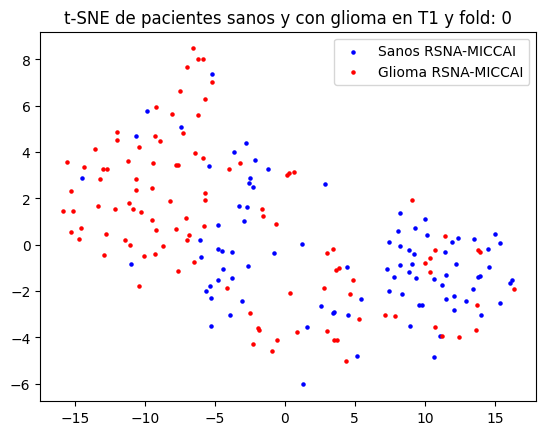

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

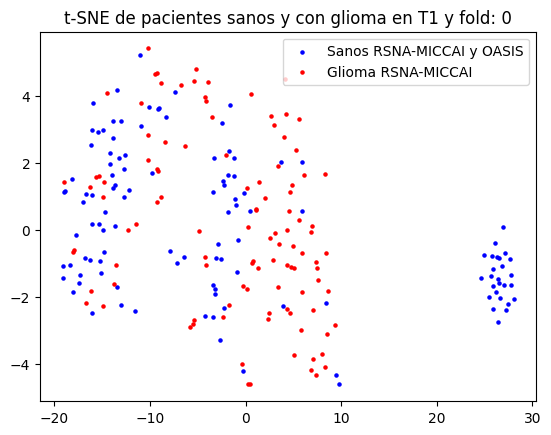

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

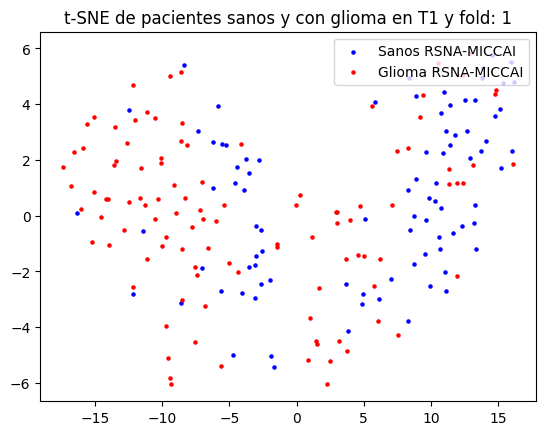

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

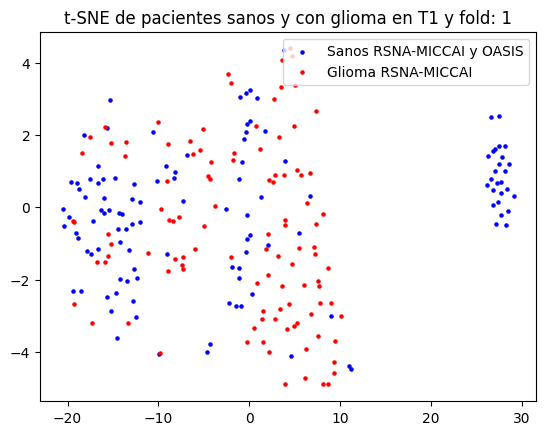

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

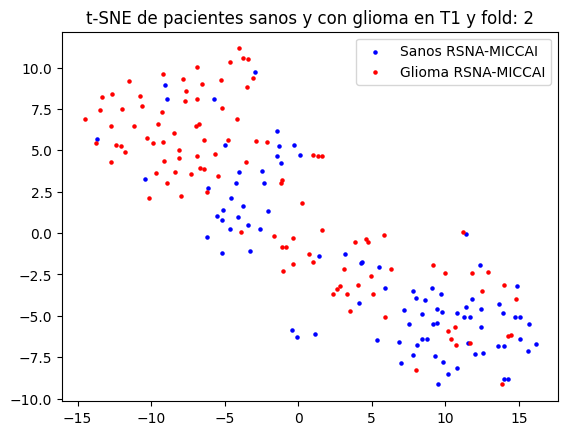

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

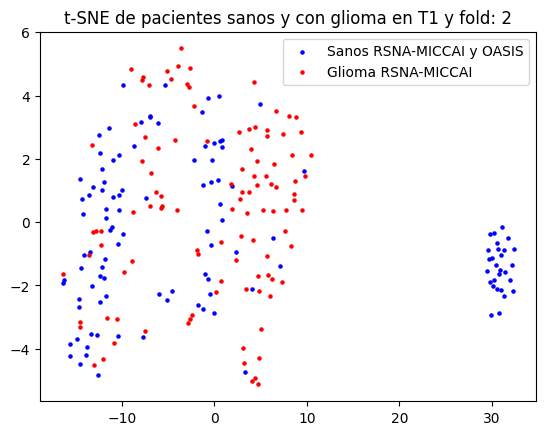

In [26]:
# Definimos los colores para cada clase de los plot
colores = {0: 'blue', 1: 'red'}

# Leemos los índices para que coincidan con los de entrenamiento
with open("./fold_indices_T1.json", "r") as f:
    indices = json.load(f)
    train_idxs = indices["train_idxs"]
    test_idxs = indices["test_idxs"]
    
with open("./fold_indices_OASIS_.json", "r") as f:
    indices_o = json.load(f)
    train_oasis_idxs = indices_o["train_oasis_idxs"]
    test_oasis_idxs = indices_o["test_oasis_idxs"]

with open("./fold_indices_glioma_T1.json", "r") as f:
    indices_g = json.load(f)
    train_glioma_idxs = indices_g["glioma_train_idxs"]
    test_glioma_idxs = indices_g["glioma_test_idxs"]

# Mean-squared error loss
criterion = nn.MSELoss()
epochs = 10

for fold_index in range(num_folds):
    # Creamos el modelo para este fold
    encoder_fold = Encoder().to(device)
    optimizer = torch.optim.RMSprop(encoder_fold.parameters(), lr=1e-3)
    
    # TRAIN RSNA-MICCAI
    train_dataset = [dataset_T1[idx] for idx in train_idxs[fold_index]]
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=False, num_workers=2)
    
    state_dict = torch.load('./MODELS_T1/model_weights_fold_' + str(fold_index) + '_T1.pth') # Cargamos los pesos
    
    encoder_fold.encoder[0].weight.data = state_dict['encoder.0.weight']
    encoder_fold.encoder[0].bias.data = state_dict['encoder.0.bias']
    encoder_fold.encoder[3].weight.data = state_dict['encoder.3.weight']
    encoder_fold.encoder[3].bias.data = state_dict['encoder.3.bias']
    
    encoded_volumes_train_fold = test(encoder_fold, train_loader, criterion)

    out_vector_shape = encoded_volumes_train_fold[0].shape[0] * encoded_volumes_train_fold[0].shape[1] * encoded_volumes_train_fold[0].shape[2] * encoded_volumes_train_fold[0].shape[3]
    latent_vectors_fold_train = [np.reshape(np.array(encoded_vol), (out_vector_shape)) for encoded_vol in encoded_volumes_train_fold]

    bandwidths = np.logspace(-1, 1, 20)

    grid = GridSearchCV(KernelDensity(), {'bandwidth': bandwidths})
    grid.fit(latent_vectors_fold_train)

    best_bandwidth = grid.best_params_['bandwidth']
    
    kde = KernelDensity(kernel='gaussian', bandwidth=best_bandwidth).fit(latent_vectors_fold_train)
    
    del train_loader, train_dataset, encoded_volumes_train_fold
    gc.collect()
    torch.cuda.empty_cache()
    
    # TRAIN GLIOMA RSNA-MICCAI
    glioma_train_dataset = [glioma_dataset_T1[idx] for idx in train_glioma_idxs[fold_index]]
    glioma_train_loader = torch.utils.data.DataLoader(glioma_train_dataset, batch_size=4, shuffle=False, num_workers=2)
    
    encoded_volumes_glioma_fold = test(encoder_fold, glioma_train_loader, criterion)

    out_vector_shape = encoded_volumes_glioma_fold[0].shape[0] * encoded_volumes_glioma_fold[0].shape[1] * encoded_volumes_glioma_fold[0].shape[2] * encoded_volumes_glioma_fold[0].shape[3]
    latent_vectors_train_fold_glioma = [np.reshape(np.array(encoded_vol), (out_vector_shape)) for encoded_vol in encoded_volumes_glioma_fold]
    
    del glioma_train_loader, glioma_train_dataset, encoded_volumes_glioma_fold
    gc.collect()
    torch.cuda.empty_cache()
    
    # TRAIN OASIS
    train_oasis = [non_demented_dataset[idx] for idx in train_oasis_idxs[fold_index]]
    train_oasis_loader = torch.utils.data.DataLoader(train_oasis, batch_size=4, shuffle=False, num_workers=2)
    
    encoded_volumes_train_fold_oasis = test(encoder_fold, train_oasis_loader, criterion)

    out_vector_shape = encoded_volumes_train_fold_oasis[0].shape[0] * encoded_volumes_train_fold_oasis[0].shape[1] * encoded_volumes_train_fold_oasis[0].shape[2] * encoded_volumes_train_fold_oasis[0].shape[3]
    latent_vectors_fold_train_oasis = [np.reshape(np.array(encoded_vol), (out_vector_shape)) for encoded_vol in encoded_volumes_train_fold_oasis]
    
    del train_oasis_loader, train_oasis, encoded_volumes_train_fold_oasis
    gc.collect()
    torch.cuda.empty_cache()
    
    # t-SNE
    
    total_patients = latent_vectors_fold_train + latent_vectors_train_fold_glioma
    X_flat = np.array(total_patients)
    
    train_labels = [0] * len(latent_vectors_fold_train)
    glioma_labels = [1] * len(latent_vectors_train_fold_glioma)

    y_valid = train_labels + glioma_labels
    
    tsne = TSNE(n_components=2)
    X_2D = tsne.fit_transform(X_flat)
    
    plt.figure()
    plt.title(f"t-SNE de pacientes sanos y con glioma en T1 y fold: {fold_index}")
    
    etiquetas = ["Sanos RSNA-MICCAI", "Glioma RSNA-MICCAI"]
    
    for label in np.unique(y_valid):
        indices = np.where(y_valid == label)
        plt.scatter(X_2D[indices, 0], X_2D[indices, 1], s=5, c=colores[label], label=etiquetas[label])
    
    plt.legend(loc='upper right')
    plt.show()
    
    total_patients = latent_vectors_fold_train + latent_vectors_fold_train_oasis + latent_vectors_train_fold_glioma
    X_flat = np.array(total_patients)
    
    train_labels = [0] * len(latent_vectors_fold_train + latent_vectors_fold_train_oasis)
    glioma_labels = [1] * len(latent_vectors_train_fold_glioma)

    y_valid = train_labels + glioma_labels
    
    tsne = TSNE(n_components=2)
    X_2D = tsne.fit_transform(X_flat)
    
    plt.figure()
    plt.title(f"t-SNE de pacientes sanos y con glioma en T1 y fold: {fold_index}")
    
    etiquetas = ["Sanos RSNA-MICCAI y OASIS", "Glioma RSNA-MICCAI"]
    
    for label in np.unique(y_valid):
        indices = np.where(y_valid == label)
        plt.scatter(X_2D[indices, 0], X_2D[indices, 1], s=5, c=colores[label], label=etiquetas[label])
    
    plt.legend(loc='upper right')
    plt.show()


Se observa como a la derecha de la mezcla de los datos hay un pequeño grupo de pacientes sanos que corresponden a los pacientes del dataset de OASIS. De esta forma se verifica que hay una distinción por los parámetros de adquisción de las distintas fuentes y que puede inducir errores en la clasificación.

Esta última celda sirve para vaciar la GPU en el entrono usado para realziar el proyecto, en otro entorno deberá modificarse adecuadamente u omitirla.

In [24]:
free_memory = True
if free_memory:
    from numba import cuda
    cuda.select_device(0)
    cuda.close()